# Titanic with Deep Learning    

## Setup

In [32]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


In [33]:
SEED = 0
csv_path = r"./data/titanic.csv"
savepath = r"./output"
device = "cpu"

columns = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex", "Embarked"]

batch_size = 16
n_epochs = 100
lr = 0.01
momentum = 0.5

In [34]:
os.makedirs(savepath, exist_ok=True)

In [35]:
print("PyTorch Version: ",torch.__version__)

print("CUDA is available" if torch.cuda.is_available() else "CUDA is not available")
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

PyTorch Version:  2.2.1+cu121
CUDA is available
NVIDIA GeForce RTX 4070 Laptop GPU


In [36]:
data = pd.read_csv(csv_path)
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [37]:
class TitanicDataset(Dataset):
    """
    Custom Dataset for the Titanic dataset

    Args:
        csv_path (str): path to the csv file
        train (bool): whether the dataset is for training or validation
        columns (list): list of columns to use
        val_split (float): validation split
        seed (int): random seed
    """

    def __init__(self, csv_path:str, train:bool, columns:list=None, val_split:float=0.2, seed:int=0):

        self.data = pd.read_csv(csv_path)

        if columns:
            if "Survived" not in columns:
                columns.append("Survived")
            self.data = self.data[columns]

        self.scaler = StandardScaler()
        self.train_flag = train

        if self.train_flag:
            self.data = train_test_split(self.data, test_size=val_split, random_state=seed)[0] # 80% train
        else:
            self.data = train_test_split(self.data, test_size=val_split, random_state=seed)[1] # 20% val

        self._preprocess()
        self.X, self.y = self.data.drop(columns=["Survived"], axis=1), self.data["Survived"]

        self.X = self.scaler.fit_transform(self.X)
        self.y = self.y.values

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)


    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y

    def _preprocess(self):
        # Train: Impute missing values
        if self.train_flag:
            categorical_columns = self.data.select_dtypes(exclude=np.number).columns
            imp_freq = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
            self.data[categorical_columns] = imp_freq.fit_transform(self.data[categorical_columns])

            numeric_columns = self.data.select_dtypes(include=np.number).columns
            imp_mean = SimpleImputer(missing_values=np.nan, strategy="median")
            self.data[numeric_columns]= imp_mean.fit_transform(self.data[numeric_columns])
        
        # Val: Drop missing values
        else:
            self.data = self.data.dropna()

    
        # One-hot encoding
        self.data = pd.get_dummies(self.data)
            
         
        
     

In [38]:
class NN(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, dropout=0.0):
        super(NN, self).__init__()
        self.blocks = nn.ModuleList()

        self.in_layer = nn.Linear(in_dim, hidden_dims[0])
        for i in range(1, len(hidden_dims)):
            self.blocks.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            if dropout > 0:
                self.blocks.append(nn.Dropout(dropout))
        self.out_layer = nn.Linear(hidden_dims[-1], out_dim)
        
        # self._init_weights()
    
    def _init_weights(self):
        for layer in self.blocks:
            if isinstance(layer, nn.Linear):
                nn.init.normal(layer.weight, std=0.01)
                nn.init.constant_(layer.bias, 0)
        nn.init.normal(self.out_layer.weight, std=0.01)
        nn.init.constant_(self.out_layer.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.in_layer(x))
        for layer in self.blocks:
            x = F.relu(layer(x))
        x = self.out_layer(x)
        return torch.sigmoid(x)



In [39]:
from tqdm import tqdm


def train(model: nn.Module, dataloader_train: DataLoader, dataloader_val: DataLoader, optimizer: optim.Optimizer, criterion: nn.Module, n_epochs: int, val_freq: int):
    train_stats = {"epoch": [], "loss": []}
    val_stats = {"epoch": [], "acc": [], "loss": []}
    model.train()
    for epoch in range(n_epochs):
        with tqdm(enumerate(dataloader_train, 0), total=len(dataloader_train), desc=f"Epoch {epoch+1}/{n_epochs}", unit="batch") as pbar:

            running_loss = 0.0
            for i, data in pbar:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            running_loss /= len(dataloader_train)
            train_stats["epoch"].append(epoch)
            train_stats["loss"].append(running_loss)
            # print(f"[Epoch {epoch+1}/{n_epochs}] Loss: {running_loss:.3f}")

            if epoch % val_freq == 0:
                val_loss = 0.0
                model.eval()
                running_acc = 0
                with torch.no_grad():
                    for data in dataloader_val:
                        inputs, labels = data
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)

                        loss = criterion(outputs.squeeze(), labels)
                        val_loss += loss.item()
                        print(outputs)
                        print(labels)
                        acc = (outputs.squeeze().round() == labels).sum()
                        running_acc += acc
                
                running_acc = running_acc.to(torch.float32).mean().item()
                val_loss /= len(dataloader_val)
                print(f"Accuracy: {acc:.2f}%")
                val_stats["epoch"].append(epoch)
                val_stats["acc"].append(running_acc)
                val_stats["loss"].append(val_loss)

    return model, train_stats, val_stats

In [40]:
# Data
dataset_train = TitanicDataset(csv_path, train=True, columns=columns)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TitanicDataset(csv_path, train=False, columns=columns)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

display(dataset_train.data.shape, dataset_val.data.shape)

(712, 11)

(143, 11)

In [41]:
in_dim = dataset_train.data.shape[1] - 1 # exclude the target column
hidden_dims = [3]
out_dim = 1
dropout = 0.1
val_freq = 1

models = [ 
    NN(in_dim, [3], out_dim, dropout=0),
    NN(in_dim, [3, 6, 12, 6, 3], out_dim, dropout=0),
    NN(in_dim, [20,40,80,40,20], out_dim, dropout=0),
    NN(in_dim, [20,40,80,120,160], out_dim, dropout=0),
    NN(in_dim, [20,40,80,40,20], out_dim, dropout=0.5),
    NN(in_dim, [3], out_dim, dropout=0.8),


]
overall_train_stats = []
overall_val_stats = []
for model in models:
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.BCELoss()
    trained_model, train_stats, val_stats = train(model, dataloader_train, dataloader_val, optimizer, criterion, n_epochs, val_freq)
    overall_train_stats.append(train_stats)
    overall_val_stats.append(val_stats)



Epoch 1/100: 100%|██████████| 45/45 [00:00<00:00, 1164.35batch/s]


tensor([[0.3986],
        [0.3786],
        [0.4116],
        [0.4234],
        [0.4176],
        [0.3455],
        [0.4097],
        [0.4174],
        [0.3779],
        [0.3368],
        [0.4301],
        [0.4087],
        [0.4257],
        [0.4252],
        [0.4303],
        [0.4138]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.])
tensor([[0.4077],
        [0.4337],
        [0.3769],
        [0.4152],
        [0.4337],
        [0.3795],
        [0.4337],
        [0.4270],
        [0.4001],
        [0.4336],
        [0.3688],
        [0.3132],
        [0.4293],
        [0.4288],
        [0.4290],
        [0.3708]])
tensor([0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.])
tensor([[0.4197],
        [0.4239],
        [0.4298],
        [0.3023],
        [0.4220],
        [0.3962],
        [0.3797],
        [0.4110],
        [0.4246],
        [0.3473],
        [0.3784],
        [0.4337],
        [0.4274],
        [0.4067],
        [0.3799],
      

Epoch 2/100: 100%|██████████| 45/45 [00:00<00:00, 549.29batch/s]


tensor([[0.4173],
        [0.3564],
        [0.4320],
        [0.3560],
        [0.3479],
        [0.4113],
        [0.4006],
        [0.3685],
        [0.3404],
        [0.3570],
        [0.4320],
        [0.3513],
        [0.4328],
        [0.3575],
        [0.4298],
        [0.4291]])
tensor([0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.4132],
        [0.4263],
        [0.4152],
        [0.4256],
        [0.4142],
        [0.4314],
        [0.3798],
        [0.3890],
        [0.4316],
        [0.3503],
        [0.4338],
        [0.3803],
        [0.4111],
        [0.3911],
        [0.4261],
        [0.4350]])
tensor([0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.4284],
        [0.4062],
        [0.3550],
        [0.4270],
        [0.2652],
        [0.4262],
        [0.4316],
        [0.3557],
        [0.4316],
        [0.3436],
        [0.4316],
        [0.4171],
        [0.3567],
        [0.2719],
        [0.4317],
      

Epoch 3/100: 100%|██████████| 45/45 [00:00<00:00, 1350.01batch/s]


tensor([[0.3610],
        [0.4118],
        [0.3391],
        [0.4312],
        [0.3261],
        [0.3129],
        [0.4308],
        [0.3195],
        [0.3714],
        [0.3138],
        [0.4386],
        [0.3189],
        [0.3299],
        [0.2903],
        [0.4308],
        [0.4326]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.3372],
        [0.4031],
        [0.3316],
        [0.2992],
        [0.3617],
        [0.3125],
        [0.4443],
        [0.3305],
        [0.3204],
        [0.4308],
        [0.4178],
        [0.3177],
        [0.2211],
        [0.3305],
        [0.4138],
        [0.3138]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.3712],
        [0.4108],
        [0.3705],
        [0.4461],
        [0.4239],
        [0.3695],
        [0.4324],
        [0.4125],
        [0.3802],
        [0.3313],
        [0.4308],
        [0.4191],
        [0.2571],
        [0.3294],
        [0.4308],
      

Epoch 4/100: 100%|██████████| 45/45 [00:00<00:00, 1002.24batch/s]


tensor([[0.4390],
        [0.3511],
        [0.2823],
        [0.4318],
        [0.3021],
        [0.4100],
        [0.3975],
        [0.4223],
        [0.2275],
        [0.3032],
        [0.1932],
        [0.3018],
        [0.4462],
        [0.4427],
        [0.3759],
        [0.4124]])
tensor([1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.4075],
        [0.4475],
        [0.4156],
        [0.3192],
        [0.4567],
        [0.2271],
        [0.3626],
        [0.2988],
        [0.4560],
        [0.3020],
        [0.4065],
        [0.2968],
        [0.4334],
        [0.3415],
        [0.3842],
        [0.4015]])
tensor([0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.3420],
        [0.3020],
        [0.2924],
        [0.4630],
        [0.2999],
        [0.3997],
        [0.4273],
        [0.4128],
        [0.2954],
        [0.2086],
        [0.4318],
        [0.4306],
        [0.3712],
        [0.4397],
        [0.4142],
      

Epoch 5/100: 100%|██████████| 45/45 [00:00<00:00, 1276.39batch/s]


tensor([[0.4477],
        [0.2396],
        [0.2464],
        [0.3882],
        [0.3996],
        [0.3897],
        [0.3035],
        [0.3682],
        [0.1800],
        [0.3280],
        [0.2004],
        [0.3691],
        [0.2522],
        [0.3169],
        [0.2751],
        [0.3256]])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.4501],
        [0.3267],
        [0.4185],
        [0.4215],
        [0.4588],
        [0.4431],
        [0.3456],
        [0.2762],
        [0.3277],
        [0.2726],
        [0.3209],
        [0.4363],
        [0.3113],
        [0.3123],
        [0.2749],
        [0.4482]])
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.4263],
        [0.3191],
        [0.4257],
        [0.4363],
        [0.3841],
        [0.4400],
        [0.3306],
        [0.2704],
        [0.2577],
        [0.3240],
        [0.4438],
        [0.4785],
        [0.4259],
        [0.4012],
        [0.4200],
      

Epoch 6/100: 100%|██████████| 45/45 [00:00<00:00, 1358.91batch/s]


tensor([[0.2883],
        [0.4627],
        [0.2892],
        [0.4649],
        [0.1745],
        [0.3078],
        [0.2909],
        [0.2426],
        [0.4256],
        [0.4498],
        [0.4278],
        [0.3797],
        [0.4421],
        [0.4094],
        [0.2462],
        [0.2267]])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.])
tensor([[0.2582],
        [0.2471],
        [0.3599],
        [0.2482],
        [0.4421],
        [0.4421],
        [0.4346],
        [0.3118],
        [0.3368],
        [0.5233],
        [0.4421],
        [0.3723],
        [0.3072],
        [0.4422],
        [0.3070],
        [0.4421]])
tensor([0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.])
tensor([[0.2238],
        [0.4340],
        [0.3102],
        [0.3623],
        [0.3835],
        [0.2468],
        [0.2990],
        [0.4482],
        [0.3640],
        [0.4650],
        [0.2484],
        [0.3006],
        [0.4361],
        [0.2167],
        [0.2445],
      

Epoch 7/100: 100%|██████████| 45/45 [00:00<00:00, 1322.89batch/s]


tensor([[0.5309],
        [0.4383],
        [0.3437],
        [0.3393],
        [0.1973],
        [0.4832],
        [0.4345],
        [0.1978],
        [0.2870],
        [0.4433],
        [0.4257],
        [0.2226],
        [0.4505],
        [0.2036],
        [0.5424],
        [0.3742]])
tensor([1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.4262],
        [0.4714],
        [0.4724],
        [0.4705],
        [0.4378],
        [0.4529],
        [0.3687],
        [0.4831],
        [0.4424],
        [0.4654],
        [0.4532],
        [0.4102],
        [0.2089],
        [0.3109],
        [0.2204],
        [0.2253]])
tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.4658],
        [0.4591],
        [0.2605],
        [0.2964],
        [0.4685],
        [0.2881],
        [0.2836],
        [0.4813],
        [0.1256],
        [0.2859],
        [0.2282],
        [0.4928],
        [0.1914],
        [0.5274],
        [0.2255],
      

Epoch 8/100: 100%|██████████| 45/45 [00:00<00:00, 1181.21batch/s]


tensor([[0.3898],
        [0.4653],
        [0.4866],
        [0.3748],
        [0.2220],
        [0.3274],
        [0.1756],
        [0.4420],
        [0.1595],
        [0.4731],
        [0.1984],
        [0.1797],
        [0.2339],
        [0.1878],
        [0.2606],
        [0.5216]])
tensor([0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.1681],
        [0.4664],
        [0.4254],
        [0.4820],
        [0.1333],
        [0.2771],
        [0.5035],
        [0.1952],
        [0.2080],
        [0.2042],
        [0.3432],
        [0.4885],
        [0.2735],
        [0.5620],
        [0.1970],
        [0.1731]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.])
tensor([[0.4316],
        [0.2077],
        [0.5461],
        [0.4659],
        [0.4608],
        [0.4926],
        [0.4580],
        [0.4084],
        [0.3714],
        [0.4343],
        [0.2945],
        [0.4580],
        [0.2323],
        [0.2722],
        [0.3519],
      

Epoch 9/100: 100%|██████████| 45/45 [00:00<00:00, 1346.12batch/s]


tensor([[0.2650],
        [0.4764],
        [0.1496],
        [0.4535],
        [0.2357],
        [0.5948],
        [0.1667],
        [0.4699],
        [0.5222],
        [0.3788],
        [0.1900],
        [0.1633],
        [0.6453],
        [0.1389],
        [0.4471],
        [0.5994]])
tensor([1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.2436],
        [0.6001],
        [0.4373],
        [0.4804],
        [0.3230],
        [0.4829],
        [0.3764],
        [0.1167],
        [0.1800],
        [0.1781],
        [0.4801],
        [0.1412],
        [0.1830],
        [0.4203],
        [0.4401],
        [0.1634]])
tensor([0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.1923],
        [0.1552],
        [0.2769],
        [0.4198],
        [0.3841],
        [0.3897],
        [0.5252],
        [0.4798],
        [0.1855],
        [0.5748],
        [0.1859],
        [0.1404],
        [0.4601],
        [0.2116],
        [0.2477],
      

Epoch 10/100: 100%|██████████| 45/45 [00:00<00:00, 1389.91batch/s]


tensor([[0.1637],
        [0.4470],
        [0.4492],
        [0.1517],
        [0.4006],
        [0.1068],
        [0.3861],
        [0.5314],
        [0.5547],
        [0.5392],
        [0.5512],
        [0.1625],
        [0.1509],
        [0.4623],
        [0.1391],
        [0.5359]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.4332],
        [0.1518],
        [0.4939],
        [0.4980],
        [0.1777],
        [0.1725],
        [0.2584],
        [0.5814],
        [0.2685],
        [0.3565],
        [0.0867],
        [0.1718],
        [0.5203],
        [0.4256],
        [0.4936],
        [0.3167]])
tensor([1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.5228],
        [0.3248],
        [0.4302],
        [0.1742],
        [0.3648],
        [0.4744],
        [0.2630],
        [0.2317],
        [0.1644],
        [0.5188],
        [0.1060],
        [0.6049],
        [0.1695],
        [0.4820],
        [0.4468],
      

Epoch 11/100: 100%|██████████| 45/45 [00:00<00:00, 677.89batch/s]


tensor([[0.5805],
        [0.3089],
        [0.2278],
        [0.2040],
        [0.6759],
        [0.3471],
        [0.1345],
        [0.1549],
        [0.2395],
        [0.3883],
        [0.2345],
        [0.1135],
        [0.5453],
        [0.5816],
        [0.1434],
        [0.0949]])
tensor([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.2470],
        [0.2286],
        [0.5584],
        [0.2237],
        [0.4935],
        [0.5536],
        [0.1563],
        [0.6016],
        [0.6796],
        [0.6292],
        [0.4359],
        [0.4493],
        [0.1623],
        [0.7050],
        [0.1587],
        [0.4144]])
tensor([0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1511],
        [0.4842],
        [0.4215],
        [0.5366],
        [0.5886],
        [0.4627],
        [0.1476],
        [0.1669],
        [0.4512],
        [0.5025],
        [0.1085],
        [0.2223],
        [0.2516],
        [0.4784],
        [0.5491],
      

Epoch 12/100: 100%|██████████| 45/45 [00:00<00:00, 1523.63batch/s]


tensor([[0.1588],
        [0.5584],
        [0.4182],
        [0.6294],
        [0.2257],
        [0.5797],
        [0.2929],
        [0.5400],
        [0.2118],
        [0.1525],
        [0.1436],
        [0.1538],
        [0.1557],
        [0.4643],
        [0.1015],
        [0.2120]])
tensor([0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.6587],
        [0.4457],
        [0.2404],
        [0.4160],
        [0.0855],
        [0.0831],
        [0.1178],
        [0.0964],
        [0.0874],
        [0.5270],
        [0.5410],
        [0.6185],
        [0.5283],
        [0.1146],
        [0.1539],
        [0.1469]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.1361],
        [0.1362],
        [0.5676],
        [0.3958],
        [0.5885],
        [0.3039],
        [0.1600],
        [0.2407],
        [0.7424],
        [0.5854],
        [0.1498],
        [0.2077],
        [0.4405],
        [0.5358],
        [0.3543],
      

Epoch 13/100: 100%|██████████| 45/45 [00:00<00:00, 1393.07batch/s]


tensor([[0.5052],
        [0.6195],
        [0.2082],
        [0.2057],
        [0.0565],
        [0.6061],
        [0.0670],
        [0.5969],
        [0.4207],
        [0.1495],
        [0.1489],
        [0.1694],
        [0.5626],
        [0.7764],
        [0.6089],
        [0.3506]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.])
tensor([[0.6484],
        [0.2273],
        [0.7491],
        [0.5682],
        [0.4523],
        [0.6973],
        [0.5134],
        [0.1366],
        [0.5172],
        [0.4076],
        [0.1484],
        [0.4197],
        [0.1001],
        [0.4968],
        [0.3715],
        [0.3298]])
tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.4531],
        [0.1443],
        [0.2560],
        [0.1443],
        [0.6034],
        [0.6311],
        [0.5479],
        [0.4200],
        [0.1487],
        [0.2117],
        [0.0803],
        [0.3369],
        [0.7477],
        [0.1239],
        [0.2452],
      

Epoch 14/100: 100%|██████████| 45/45 [00:00<00:00, 1406.96batch/s]


tensor([[0.2093],
        [0.6922],
        [0.3979],
        [0.2241],
        [0.5396],
        [0.1424],
        [0.7773],
        [0.1309],
        [0.1206],
        [0.4721],
        [0.6528],
        [0.1516],
        [0.4516],
        [0.2059],
        [0.1442],
        [0.1020]])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.0633],
        [0.5164],
        [0.4516],
        [0.6876],
        [0.0679],
        [0.3169],
        [0.0989],
        [0.0959],
        [0.1985],
        [0.4463],
        [0.1130],
        [0.8046],
        [0.0503],
        [0.6332],
        [0.0744],
        [0.5269]])
tensor([0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.2594],
        [0.1357],
        [0.2004],
        [0.1438],
        [0.2126],
        [0.1294],
        [0.2163],
        [0.5740],
        [0.2059],
        [0.4780],
        [0.1343],
        [0.2026],
        [0.3624],
        [0.6038],
        [0.5152],
      

Epoch 15/100: 100%|██████████| 45/45 [00:00<00:00, 1453.81batch/s]


tensor([[0.6680],
        [0.1037],
        [0.1582],
        [0.1597],
        [0.2221],
        [0.1490],
        [0.4266],
        [0.4788],
        [0.8247],
        [0.0869],
        [0.6322],
        [0.4380],
        [0.3968],
        [0.6035],
        [0.5361],
        [0.7115]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.4833],
        [0.1033],
        [0.0977],
        [0.1292],
        [0.1425],
        [0.6684],
        [0.0791],
        [0.6696],
        [0.0452],
        [0.6954],
        [0.4521],
        [0.7100],
        [0.0912],
        [0.6567],
        [0.3080],
        [0.2031]])
tensor([1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.1101],
        [0.6510],
        [0.2471],
        [0.2015],
        [0.7163],
        [0.2390],
        [0.5297],
        [0.6038],
        [0.7522],
        [0.1331],
        [0.1876],
        [0.4600],
        [0.6764],
        [0.3434],
        [0.5118],
      

Epoch 16/100: 100%|██████████| 45/45 [00:00<00:00, 859.58batch/s]


tensor([[0.1914],
        [0.0882],
        [0.6871],
        [0.2035],
        [0.7309],
        [0.8264],
        [0.8383],
        [0.4918],
        [0.7257],
        [0.2398],
        [0.1054],
        [0.5156],
        [0.0949],
        [0.0686],
        [0.0997],
        [0.2980]])
tensor([0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.2340],
        [0.6338],
        [0.2430],
        [0.4385],
        [0.0735],
        [0.1227],
        [0.7198],
        [0.6661],
        [0.6215],
        [0.1341],
        [0.0680],
        [0.5459],
        [0.8693],
        [0.4607],
        [0.2113],
        [0.6009]])
tensor([0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1.])
tensor([[0.2097],
        [0.1283],
        [0.0862],
        [0.1528],
        [0.6211],
        [0.1125],
        [0.4491],
        [0.6191],
        [0.4849],
        [0.1297],
        [0.0584],
        [0.4323],
        [0.0987],
        [0.0595],
        [0.8144],
      

Epoch 17/100: 100%|██████████| 45/45 [00:00<00:00, 941.64batch/s]


tensor([[0.1299],
        [0.0549],
        [0.0556],
        [0.1473],
        [0.1500],
        [0.6687],
        [0.4457],
        [0.7403],
        [0.2208],
        [0.1210],
        [0.7072],
        [0.7479],
        [0.2245],
        [0.1270],
        [0.7498],
        [0.4983]])
tensor([0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.7028],
        [0.4281],
        [0.6833],
        [0.0608],
        [0.7119],
        [0.1332],
        [0.0528],
        [0.5476],
        [0.4877],
        [0.2189],
        [0.0831],
        [0.3259],
        [0.7941],
        [0.5598],
        [0.0362],
        [0.4818]])
tensor([1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.1392],
        [0.6481],
        [0.3941],
        [0.3299],
        [0.4273],
        [0.1392],
        [0.0933],
        [0.7031],
        [0.0900],
        [0.2925],
        [0.5238],
        [0.7028],
        [0.2424],
        [0.8827],
        [0.6658],
      

Epoch 18/100: 100%|██████████| 45/45 [00:00<00:00, 1074.05batch/s]

tensor([[0.5487],
        [0.8905],
        [0.0929],
        [0.1514],
        [0.1962],
        [0.4805],
        [0.2323],
        [0.0895],
        [0.1325],
        [0.0325],
        [0.8476],
        [0.6853],
        [0.2016],
        [0.1119],
        [0.1364],
        [0.4153]])


tensor([1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.0660],
        [0.1177],
        [0.6566],
        [0.4300],
        [0.1993],
        [0.0866],
        [0.0875],
        [0.6905],
        [0.1120],
        [0.1387],
        [0.8544],
        [0.1552],
        [0.5250],
        [0.4678],
        [0.4482],
        [0.5580]])
tensor([0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.1259],
        [0.7695],
        [0.4956],
        [0.1081],
        [0.1470],
        [0.0815],
        [0.7870],
        [0.6246],
        [0.2196],
        [0.1195],
        [0.1872],
        [0.0966],
        [0.8617],
        [0.1943],
        [0.1392],
        [0.5043]])
tensor([0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.0802],
        [0.5505],
        [0.1413],
        [0.6770],
        [0.4748],
        [0.7156],
        [0.7177],
        [0.7630],
        [0.0548],
        [0.7440],
        [0.1325],
    

Epoch 19/100: 100%|██████████| 45/45 [00:00<00:00, 1058.88batch/s]


tensor([[0.2155],
        [0.1384],
        [0.5794],
        [0.2016],
        [0.1355],
        [0.5236],
        [0.7061],
        [0.5085],
        [0.0783],
        [0.4957],
        [0.1467],
        [0.1380],
        [0.1908],
        [0.1438],
        [0.7410],
        [0.1837]])
tensor([0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.0458],
        [0.7391],
        [0.0543],
        [0.1749],
        [0.1941],
        [0.6576],
        [0.5566],
        [0.1551],
        [0.7812],
        [0.7378],
        [0.0956],
        [0.1212],
        [0.0624],
        [0.1473],
        [0.1197],
        [0.2089]])
tensor([0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.1793],
        [0.1065],
        [0.4695],
        [0.2436],
        [0.1907],
        [0.0529],
        [0.1058],
        [0.3923],
        [0.5519],
        [0.5487],
        [0.5728],
        [0.5586],
        [0.0298],
        [0.0913],
        [0.8588],
      

Epoch 20/100: 100%|██████████| 45/45 [00:00<00:00, 1060.44batch/s]


tensor([[0.1266],
        [0.1962],
        [0.2223],
        [0.1203],
        [0.0860],
        [0.7906],
        [0.1350],
        [0.7164],
        [0.1399],
        [0.6830],
        [0.4961],
        [0.7918],
        [0.6986],
        [0.2663],
        [0.5421],
        [0.0836]])
tensor([0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0.])
tensor([[0.5139],
        [0.1368],
        [0.1286],
        [0.7400],
        [0.0973],
        [0.3788],
        [0.1043],
        [0.1611],
        [0.1164],
        [0.2991],
        [0.0555],
        [0.2164],
        [0.2026],
        [0.5643],
        [0.0500],
        [0.0460]])
tensor([1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.8148],
        [0.5503],
        [0.6598],
        [0.5878],
        [0.0276],
        [0.7180],
        [0.7589],
        [0.4748],
        [0.2444],
        [0.0783],
        [0.0699],
        [0.1442],
        [0.0894],
        [0.8384],
        [0.1252],
      

Epoch 21/100: 100%|██████████| 45/45 [00:00<00:00, 691.70batch/s]


tensor([[0.0896],
        [0.0521],
        [0.1420],
        [0.4831],
        [0.1218],
        [0.0539],
        [0.1373],
        [0.7233],
        [0.2924],
        [0.5487],
        [0.1955],
        [0.1098],
        [0.1175],
        [0.4383],
        [0.4654],
        [0.6958]])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.5239],
        [0.7017],
        [0.1889],
        [0.2501],
        [0.7635],
        [0.3590],
        [0.7049],
        [0.3906],
        [0.2116],
        [0.2356],
        [0.2477],
        [0.6872],
        [0.8045],
        [0.1819],
        [0.2598],
        [0.0591]])
tensor([1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.1730],
        [0.1878],
        [0.6759],
        [0.2003],
        [0.4741],
        [0.7120],
        [0.4814],
        [0.8052],
        [0.1784],
        [0.2283],
        [0.7466],
        [0.0417],
        [0.7013],
        [0.4883],
        [0.0444],
      

Epoch 22/100: 100%|██████████| 45/45 [00:00<00:00, 1223.72batch/s]


tensor([[0.0796],
        [0.0653],
        [0.1482],
        [0.7306],
        [0.1152],
        [0.1389],
        [0.0988],
        [0.7791],
        [0.3564],
        [0.5140],
        [0.7582],
        [0.1924],
        [0.8844],
        [0.0416],
        [0.4423],
        [0.0936]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.3722],
        [0.4704],
        [0.6115],
        [0.1269],
        [0.6873],
        [0.8133],
        [0.7127],
        [0.4218],
        [0.2442],
        [0.1026],
        [0.3332],
        [0.5107],
        [0.7876],
        [0.4881],
        [0.5084],
        [0.5572]])
tensor([0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.])
tensor([[0.2096],
        [0.5310],
        [0.0900],
        [0.7021],
        [0.4703],
        [0.1153],
        [0.1398],
        [0.0960],
        [0.1408],
        [0.8832],
        [0.6975],
        [0.1833],
        [0.2495],
        [0.2139],
        [0.1894],
      

Epoch 23/100: 100%|██████████| 45/45 [00:00<00:00, 1098.30batch/s]


tensor([[0.2987],
        [0.1065],
        [0.1698],
        [0.1998],
        [0.7177],
        [0.0548],
        [0.7185],
        [0.1820],
        [0.8901],
        [0.1241],
        [0.6157],
        [0.7671],
        [0.6650],
        [0.7240],
        [0.1274],
        [0.4342]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1.])
tensor([[0.7905],
        [0.1923],
        [0.2456],
        [0.8232],
        [0.4904],
        [0.0925],
        [0.5630],
        [0.0858],
        [0.2093],
        [0.1391],
        [0.1781],
        [0.4224],
        [0.1816],
        [0.8258],
        [0.1484],
        [0.1174]])
tensor([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.3928],
        [0.7700],
        [0.2338],
        [0.1228],
        [0.0492],
        [0.0370],
        [0.8018],
        [0.3568],
        [0.8296],
        [0.5211],
        [0.1388],
        [0.1245],
        [0.4015],
        [0.1388],
        [0.6598],
      

Epoch 24/100: 100%|██████████| 45/45 [00:00<00:00, 1153.59batch/s]


tensor([[0.6953],
        [0.7413],
        [0.0655],
        [0.1250],
        [0.8960],
        [0.1706],
        [0.1576],
        [0.8320],
        [0.7337],
        [0.5532],
        [0.1230],
        [0.2957],
        [0.1837],
        [0.1188],
        [0.5003],
        [0.1759]])
tensor([1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.0831],
        [0.2730],
        [0.1391],
        [0.2296],
        [0.1337],
        [0.8013],
        [0.1055],
        [0.5612],
        [0.0627],
        [0.2006],
        [0.2486],
        [0.3600],
        [0.4498],
        [0.8352],
        [0.2225],
        [0.1362]])
tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.0535],
        [0.7122],
        [0.8751],
        [0.1391],
        [0.5590],
        [0.8417],
        [0.2431],
        [0.5190],
        [0.4687],
        [0.8206],
        [0.0914],
        [0.4954],
        [0.1382],
        [0.8517],
        [0.1240],
      

Epoch 25/100: 100%|██████████| 45/45 [00:00<00:00, 1139.99batch/s]


tensor([[0.1397],
        [0.0912],
        [0.0644],
        [0.7248],
        [0.9000],
        [0.8483],
        [0.0372],
        [0.5248],
        [0.5022],
        [0.1773],
        [0.5549],
        [0.1007],
        [0.7643],
        [0.7180],
        [0.1532],
        [0.1763]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.7514],
        [0.1170],
        [0.7409],
        [0.0826],
        [0.3504],
        [0.7070],
        [0.1240],
        [0.2628],
        [0.7312],
        [0.2343],
        [0.8589],
        [0.0790],
        [0.1310],
        [0.7190],
        [0.1567],
        [0.7436]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1.])
tensor([[0.8078],
        [0.1335],
        [0.2558],
        [0.0794],
        [0.1753],
        [0.1266],
        [0.0450],
        [0.4631],
        [0.8867],
        [0.1423],
        [0.1495],
        [0.0853],
        [0.1145],
        [0.0520],
        [0.3494],
      

Epoch 26/100: 100%|██████████| 45/45 [00:00<00:00, 1345.32batch/s]


tensor([[0.8332],
        [0.1151],
        [0.4907],
        [0.2196],
        [0.7094],
        [0.0934],
        [0.1431],
        [0.8154],
        [0.7598],
        [0.1342],
        [0.1714],
        [0.6217],
        [0.1540],
        [0.5296],
        [0.0525],
        [0.2756]])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.4892],
        [0.6890],
        [0.8870],
        [0.8471],
        [0.7749],
        [0.8103],
        [0.2268],
        [0.1315],
        [0.0825],
        [0.0788],
        [0.2865],
        [0.0365],
        [0.0794],
        [0.8645],
        [0.2140],
        [0.9023]])
tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.])
tensor([[0.7435],
        [0.7745],
        [0.1271],
        [0.3816],
        [0.1009],
        [0.1365],
        [0.0854],
        [0.5551],
        [0.1958],
        [0.4656],
        [0.8158],
        [0.7181],
        [0.6016],
        [0.4638],
        [0.1149],
      

Epoch 27/100: 100%|██████████| 45/45 [00:00<00:00, 1288.58batch/s]


tensor([[0.4798],
        [0.0460],
        [0.5631],
        [0.0996],
        [0.1304],
        [0.1304],
        [0.7669],
        [0.7335],
        [0.2297],
        [0.9203],
        [0.7330],
        [0.7485],
        [0.0774],
        [0.2039],
        [0.4550],
        [0.1329]])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.8908],
        [0.6183],
        [0.1697],
        [0.1955],
        [0.8212],
        [0.0812],
        [0.7636],
        [0.2506],
        [0.5526],
        [0.1239],
        [0.1765],
        [0.8625],
        [0.1419],
        [0.6778],
        [0.3550],
        [0.7582]])
tensor([1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.])
tensor([[0.1919],
        [0.6917],
        [0.6770],
        [0.2264],
        [0.0829],
        [0.5137],
        [0.8896],
        [0.2419],
        [0.5437],
        [0.4466],
        [0.0899],
        [0.8684],
        [0.1180],
        [0.6212],
        [0.8327],
      

Epoch 28/100: 100%|██████████| 45/45 [00:00<00:00, 1276.32batch/s]


tensor([[0.6088],
        [0.7744],
        [0.2126],
        [0.1582],
        [0.8074],
        [0.1924],
        [0.2150],
        [0.0350],
        [0.1132],
        [0.1960],
        [0.6645],
        [0.1102],
        [0.0660],
        [0.7168],
        [0.2309],
        [0.0601]])
tensor([0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.8275],
        [0.8223],
        [0.8544],
        [0.1853],
        [0.1493],
        [0.1730],
        [0.3639],
        [0.3671],
        [0.1301],
        [0.3186],
        [0.0863],
        [0.6418],
        [0.8950],
        [0.8682],
        [0.6835],
        [0.5369]])
tensor([1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.0907],
        [0.9092],
        [0.8277],
        [0.8728],
        [0.4320],
        [0.7671],
        [0.1036],
        [0.2425],
        [0.3667],
        [0.0779],
        [0.1301],
        [0.4981],
        [0.8186],
        [0.2353],
        [0.0519],
      

Epoch 29/100: 100%|██████████| 45/45 [00:00<00:00, 1001.88batch/s]


tensor([[0.0436],
        [0.7987],
        [0.8219],
        [0.1289],
        [0.2045],
        [0.4272],
        [0.1161],
        [0.8775],
        [0.2078],
        [0.4516],
        [0.8342],
        [0.2423],
        [0.1397],
        [0.8483],
        [0.1627],
        [0.0655]])
tensor([0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.1522],
        [0.2283],
        [0.1023],
        [0.0728],
        [0.8600],
        [0.8732],
        [0.7376],
        [0.0865],
        [0.1119],
        [0.6537],
        [0.0648],
        [0.0973],
        [0.1545],
        [0.1664],
        [0.7826],
        [0.1623]])
tensor([0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.7912],
        [0.4291],
        [0.0602],
        [0.7366],
        [0.1215],
        [0.0895],
        [0.6194],
        [0.2419],
        [0.8926],
        [0.0430],
        [0.2620],
        [0.8995],
        [0.0876],
        [0.9124],
        [0.7372],
      

Epoch 30/100: 100%|██████████| 45/45 [00:00<00:00, 944.90batch/s]


tensor([[0.0429],
        [0.3139],
        [0.2670],
        [0.0593],
        [0.7190],
        [0.9195],
        [0.1287],
        [0.1377],
        [0.8913],
        [0.8385],
        [0.7875],
        [0.4208],
        [0.1482],
        [0.4936],
        [0.8045],
        [0.8175]])
tensor([0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.])
tensor([[0.6153],
        [0.0480],
        [0.8601],
        [0.3680],
        [0.9139],
        [0.5872],
        [0.1524],
        [0.1375],
        [0.0581],
        [0.2051],
        [0.7366],
        [0.8472],
        [0.5005],
        [0.1139],
        [0.6654],
        [0.3483]])
tensor([0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.4471],
        [0.0870],
        [0.1664],
        [0.2420],
        [0.7364],
        [0.1748],
        [0.1204],
        [0.0648],
        [0.1199],
        [0.8382],
        [0.4867],
        [0.9016],
        [0.4334],
        [0.1869],
        [0.6392],
      

Epoch 31/100: 100%|██████████| 45/45 [00:00<00:00, 583.94batch/s]


tensor([[0.1360],
        [0.1194],
        [0.1143],
        [0.6285],
        [0.7946],
        [0.0411],
        [0.1362],
        [0.0763],
        [0.1321],
        [0.8335],
        [0.4162],
        [0.1140],
        [0.1943],
        [0.6460],
        [0.2628],
        [0.8993]])
tensor([0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.1726],
        [0.0839],
        [0.8611],
        [0.2542],
        [0.3684],
        [0.1506],
        [0.0628],
        [0.2140],
        [0.7983],
        [0.0556],
        [0.7662],
        [0.1867],
        [0.4468],
        [0.7944],
        [0.9056],
        [0.1508]])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.8256],
        [0.5093],
        [0.1649],
        [0.0950],
        [0.8038],
        [0.1535],
        [0.4921],
        [0.8840],
        [0.3103],
        [0.9070],
        [0.4426],
        [0.1802],
        [0.9169],
        [0.0781],
        [0.7386],
      

Epoch 32/100: 100%|██████████| 45/45 [00:00<00:00, 1326.53batch/s]


tensor([[0.0448],
        [0.1120],
        [0.8087],
        [0.6943],
        [0.0852],
        [0.1297],
        [0.1144],
        [0.8882],
        [0.8731],
        [0.1297],
        [0.1392],
        [0.3745],
        [0.0791],
        [0.1554],
        [0.4448],
        [0.4352]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.1350],
        [0.0642],
        [0.2131],
        [0.4405],
        [0.4949],
        [0.0722],
        [0.1219],
        [0.1390],
        [0.7426],
        [0.1390],
        [0.0192],
        [0.7415],
        [0.0472],
        [0.8652],
        [0.1917],
        [0.5177]])
tensor([0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.8036],
        [0.0565],
        [0.6834],
        [0.4533],
        [0.9091],
        [0.0868],
        [0.3163],
        [0.3552],
        [0.5599],
        [0.1020],
        [0.9203],
        [0.1288],
        [0.1164],
        [0.2077],
        [0.5859],
      

Epoch 33/100: 100%|██████████| 45/45 [00:00<00:00, 1161.32batch/s]


tensor([[0.2474],
        [0.6671],
        [0.2282],
        [0.1414],
        [0.0883],
        [0.1554],
        [0.7006],
        [0.9121],
        [0.8924],
        [0.8046],
        [0.6096],
        [0.1037],
        [0.1414],
        [0.6036],
        [0.8613],
        [0.2232]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.9093],
        [0.1134],
        [0.7679],
        [0.0856],
        [0.8749],
        [0.2896],
        [0.8524],
        [0.0592],
        [0.0574],
        [0.1526],
        [0.4216],
        [0.0485],
        [0.4906],
        [0.5580],
        [0.6992],
        [0.1395]])
tensor([1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.1031],
        [0.7427],
        [0.5516],
        [0.1184],
        [0.0809],
        [0.8559],
        [0.7238],
        [0.0423],
        [0.1785],
        [0.1416],
        [0.4863],
        [0.2026],
        [0.4554],
        [0.8272],
        [0.2417],
      

Epoch 34/100: 100%|██████████| 45/45 [00:00<00:00, 1168.69batch/s]


tensor([[0.8049],
        [0.1390],
        [0.2088],
        [0.0447],
        [0.1350],
        [0.3383],
        [0.4083],
        [0.1247],
        [0.4619],
        [0.7452],
        [0.2958],
        [0.4335],
        [0.0632],
        [0.1502],
        [0.7165],
        [0.1392]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.0564],
        [0.2363],
        [0.0833],
        [0.2459],
        [0.7438],
        [0.8567],
        [0.1398],
        [0.0792],
        [0.8521],
        [0.1295],
        [0.0787],
        [0.2009],
        [0.9231],
        [0.8152],
        [0.1295],
        [0.5758]])
tensor([1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.5059],
        [0.7690],
        [0.0410],
        [0.1013],
        [0.1372],
        [0.0712],
        [0.2122],
        [0.9148],
        [0.6813],
        [0.1202],
        [0.1878],
        [0.0629],
        [0.4034],
        [0.8049],
        [0.1972],
      

Epoch 35/100: 100%|██████████| 45/45 [00:00<00:00, 1292.64batch/s]


tensor([[0.8999],
        [0.0966],
        [0.1703],
        [0.7456],
        [0.2369],
        [0.2119],
        [0.0789],
        [0.2539],
        [0.1384],
        [0.6852],
        [0.1982],
        [0.0846],
        [0.1741],
        [0.1890],
        [0.1980],
        [0.0457]])
tensor([1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.3493],
        [0.1182],
        [0.8384],
        [0.0764],
        [0.1296],
        [0.4887],
        [0.8978],
        [0.9025],
        [0.1913],
        [0.1392],
        [0.1390],
        [0.4454],
        [0.0875],
        [0.8652],
        [0.3381],
        [0.4695]])
tensor([1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.2429],
        [0.1115],
        [0.0784],
        [0.8981],
        [0.1247],
        [0.0313],
        [0.0857],
        [0.4543],
        [0.1200],
        [0.2091],
        [0.1205],
        [0.1394],
        [0.0405],
        [0.2929],
        [0.9252],
      

Epoch 36/100: 100%|██████████| 45/45 [00:00<00:00, 992.16batch/s]


tensor([[0.4972],
        [0.2286],
        [0.7243],
        [0.0454],
        [0.8417],
        [0.1131],
        [0.2032],
        [0.2524],
        [0.1819],
        [0.1237],
        [0.1338],
        [0.8443],
        [0.9005],
        [0.0338],
        [0.2313],
        [0.4856]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.5840],
        [0.1301],
        [0.0581],
        [0.1421],
        [0.8631],
        [0.8081],
        [0.3021],
        [0.5977],
        [0.2058],
        [0.4747],
        [0.1421],
        [0.6865],
        [0.2822],
        [0.8553],
        [0.2029],
        [0.1463]])
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.1322],
        [0.0810],
        [0.8921],
        [0.7706],
        [0.8088],
        [0.7903],
        [0.2267],
        [0.1581],
        [0.2907],
        [0.1244],
        [0.6923],
        [0.1030],
        [0.8588],
        [0.0312],
        [0.1161],
      

Epoch 37/100: 100%|██████████| 45/45 [00:00<00:00, 1199.37batch/s]


tensor([[0.0726],
        [0.3219],
        [0.1837],
        [0.1218],
        [0.2069],
        [0.0191],
        [0.2547],
        [0.4112],
        [0.1348],
        [0.0945],
        [0.3091],
        [0.1558],
        [0.0464],
        [0.0343],
        [0.0562],
        [0.8993]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.0804],
        [0.1311],
        [0.8435],
        [0.1939],
        [0.6961],
        [0.9202],
        [0.3889],
        [0.8246],
        [0.1242],
        [0.0811],
        [0.9056],
        [0.8108],
        [0.1255],
        [0.9011],
        [0.4357],
        [0.0901]])
tensor([0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.0408],
        [0.4235],
        [0.8777],
        [0.8395],
        [0.8563],
        [0.3612],
        [0.7322],
        [0.1397],
        [0.4250],
        [0.7922],
        [0.9052],
        [0.3280],
        [0.1665],
        [0.4230],
        [0.0642],
      

Epoch 38/100: 100%|██████████| 45/45 [00:00<00:00, 1367.80batch/s]


tensor([[0.7316],
        [0.1343],
        [0.0865],
        [0.5640],
        [0.9086],
        [0.3142],
        [0.1151],
        [0.1445],
        [0.4160],
        [0.1792],
        [0.0407],
        [0.4509],
        [0.5975],
        [0.1343],
        [0.1445],
        [0.2624]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.8197],
        [0.2881],
        [0.0345],
        [0.6898],
        [0.1177],
        [0.4632],
        [0.0897],
        [0.4217],
        [0.1970],
        [0.3685],
        [0.7973],
        [0.8606],
        [0.0579],
        [0.1565],
        [0.1401],
        [0.1145]])
tensor([1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.1449],
        [0.2788],
        [0.2556],
        [0.2335],
        [0.4697],
        [0.0802],
        [0.1480],
        [0.2162],
        [0.8483],
        [0.1677],
        [0.9235],
        [0.8820],
        [0.5530],
        [0.8121],
        [0.7737],
      

Epoch 39/100: 100%|██████████| 45/45 [00:00<00:00, 968.76batch/s]


tensor([[0.9132],
        [0.0882],
        [0.0556],
        [0.0868],
        [0.2317],
        [0.0729],
        [0.4123],
        [0.4311],
        [0.3929],
        [0.9300],
        [0.8135],
        [0.8791],
        [0.8904],
        [0.8506],
        [0.3235],
        [0.2850]])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.])
tensor([[0.9114],
        [0.8437],
        [0.9153],
        [0.1290],
        [0.2624],
        [0.1161],
        [0.3199],
        [0.0457],
        [0.1465],
        [0.1463],
        [0.4177],
        [0.8719],
        [0.4850],
        [0.4438],
        [0.7520],
        [0.4263]])
tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.])
tensor([[0.6935],
        [0.5544],
        [0.1155],
        [0.2257],
        [0.7330],
        [0.0403],
        [0.1305],
        [0.4150],
        [0.0400],
        [0.1146],
        [0.1048],
        [0.1799],
        [0.0847],
        [0.1634],
        [0.1209],
      

Epoch 40/100: 100%|██████████| 45/45 [00:00<00:00, 790.62batch/s]


tensor([[0.1196],
        [0.8678],
        [0.7959],
        [0.1893],
        [0.2141],
        [0.0195],
        [0.6977],
        [0.1256],
        [0.2088],
        [0.0866],
        [0.2310],
        [0.4495],
        [0.4132],
        [0.2357],
        [0.0396],
        [0.4115]])
tensor([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.8718],
        [0.8188],
        [0.7564],
        [0.0772],
        [0.6961],
        [0.8245],
        [0.4760],
        [0.8666],
        [0.9240],
        [0.9024],
        [0.5932],
        [0.9043],
        [0.0567],
        [0.1982],
        [0.5628],
        [0.0421]])
tensor([1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.2127],
        [0.4072],
        [0.1781],
        [0.8636],
        [0.7601],
        [0.2073],
        [0.4111],
        [0.8048],
        [0.1344],
        [0.0630],
        [0.0845],
        [0.0795],
        [0.1147],
        [0.2758],
        [0.9323],
      

Epoch 41/100: 100%|██████████| 45/45 [00:00<00:00, 1085.76batch/s]


tensor([[0.2582],
        [0.4141],
        [0.9178],
        [0.0775],
        [0.4213],
        [0.8271],
        [0.2116],
        [0.0492],
        [0.1432],
        [0.9249],
        [0.0704],
        [0.1427],
        [0.5677],
        [0.1320],
        [0.6879],
        [0.1280]])
tensor([0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.0434],
        [0.1123],
        [0.4030],
        [0.4075],
        [0.2931],
        [0.0315],
        [0.2583],
        [0.0406],
        [0.5818],
        [0.1904],
        [0.1325],
        [0.7976],
        [0.2702],
        [0.1290],
        [0.7797],
        [0.1430]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.])
tensor([[0.2568],
        [0.8955],
        [0.0196],
        [0.9021],
        [0.8852],
        [0.1623],
        [0.1103],
        [0.4105],
        [0.1707],
        [0.9287],
        [0.8687],
        [0.3950],
        [0.3180],
        [0.3754],
        [0.3777],
      

Epoch 42/100: 100%|██████████| 45/45 [00:00<00:00, 897.96batch/s]


tensor([[0.8948],
        [0.3582],
        [0.2092],
        [0.3929],
        [0.3611],
        [0.8734],
        [0.1111],
        [0.0693],
        [0.4371],
        [0.5671],
        [0.3760],
        [0.3898],
        [0.4828],
        [0.1456],
        [0.4012],
        [0.3992]])
tensor([1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.])
tensor([[0.1747],
        [0.1415],
        [0.2625],
        [0.9095],
        [0.1419],
        [0.5731],
        [0.1372],
        [0.3313],
        [0.9230],
        [0.0522],
        [0.2014],
        [0.1408],
        [0.2563],
        [0.9106],
        [0.2253],
        [0.1347]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.9286],
        [0.2635],
        [0.1005],
        [0.1197],
        [0.1126],
        [0.0307],
        [0.2099],
        [0.4051],
        [0.0872],
        [0.8688],
        [0.0780],
        [0.2534],
        [0.0950],
        [0.0765],
        [0.1601],
      

Epoch 43/100: 100%|██████████| 45/45 [00:00<00:00, 1200.13batch/s]


tensor([[0.3735],
        [0.5597],
        [0.3972],
        [0.2571],
        [0.2076],
        [0.1379],
        [0.1738],
        [0.4163],
        [0.1258],
        [0.8985],
        [0.2385],
        [0.1279],
        [0.7787],
        [0.1266],
        [0.9042],
        [0.1548]])
tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.5547],
        [0.3561],
        [0.1171],
        [0.2000],
        [0.1319],
        [0.0697],
        [0.7576],
        [0.5511],
        [0.1428],
        [0.0430],
        [0.1596],
        [0.2975],
        [0.2194],
        [0.3969],
        [0.1232],
        [0.6758]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.0375],
        [0.2148],
        [0.8725],
        [0.9053],
        [0.1117],
        [0.6950],
        [0.9135],
        [0.8275],
        [0.8462],
        [0.0489],
        [0.2109],
        [0.0610],
        [0.9313],
        [0.9201],
        [0.1288],
      

Epoch 44/100: 100%|██████████| 45/45 [00:00<00:00, 959.21batch/s]


tensor([[0.0774],
        [0.5389],
        [0.3745],
        [0.8758],
        [0.2175],
        [0.1238],
        [0.3006],
        [0.4276],
        [0.3957],
        [0.0775],
        [0.9055],
        [0.3008],
        [0.2290],
        [0.2583],
        [0.2561],
        [0.1386]])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.4942],
        [0.6723],
        [0.0800],
        [0.0529],
        [0.9265],
        [0.1286],
        [0.1556],
        [0.0504],
        [0.1940],
        [0.1448],
        [0.3988],
        [0.1509],
        [0.1115],
        [0.8763],
        [0.3875],
        [0.1822]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.1604],
        [0.2063],
        [0.8843],
        [0.5425],
        [0.0554],
        [0.4192],
        [0.2711],
        [0.7682],
        [0.0377],
        [0.1226],
        [0.9066],
        [0.0609],
        [0.4102],
        [0.8671],
        [0.3912],
      

Epoch 45/100: 100%|██████████| 45/45 [00:00<00:00, 1055.29batch/s]


tensor([[0.1837],
        [0.4369],
        [0.2904],
        [0.0762],
        [0.4605],
        [0.0341],
        [0.1163],
        [0.4949],
        [0.0372],
        [0.3407],
        [0.5365],
        [0.1922],
        [0.6708],
        [0.0751],
        [0.0369],
        [0.1267]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.1094],
        [0.1414],
        [0.3817],
        [0.8786],
        [0.1258],
        [0.0720],
        [0.1417],
        [0.0948],
        [0.0843],
        [0.2695],
        [0.3886],
        [0.2396],
        [0.5338],
        [0.2162],
        [0.1430],
        [0.3856]])
tensor([1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.8794],
        [0.4140],
        [0.1274],
        [0.3977],
        [0.9251],
        [0.2996],
        [0.0312],
        [0.0502],
        [0.1109],
        [0.9435],
        [0.1802],
        [0.7453],
        [0.1377],
        [0.9083],
        [0.0838],
      

Epoch 46/100: 100%|██████████| 45/45 [00:00<00:00, 986.27batch/s]


tensor([[0.5604],
        [0.1843],
        [0.0546],
        [0.8976],
        [0.4591],
        [0.3954],
        [0.1094],
        [0.7825],
        [0.9087],
        [0.2968],
        [0.1218],
        [0.8821],
        [0.5350],
        [0.2718],
        [0.7017],
        [0.9473]])
tensor([1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.7633],
        [0.7635],
        [0.1279],
        [0.7593],
        [0.1782],
        [0.1325],
        [0.1427],
        [0.3671],
        [0.2911],
        [0.0426],
        [0.1939],
        [0.0374],
        [0.2175],
        [0.3767],
        [0.0955],
        [0.9209]])
tensor([1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.8558],
        [0.0562],
        [0.0314],
        [0.1381],
        [0.3841],
        [0.5416],
        [0.1601],
        [0.8878],
        [0.2024],
        [0.5606],
        [0.0767],
        [0.8732],
        [0.0602],
        [0.1117],
        [0.1502],
      

Epoch 47/100: 100%|██████████| 45/45 [00:00<00:00, 1174.42batch/s]


tensor([[0.1532],
        [0.9249],
        [0.0524],
        [0.8249],
        [0.3458],
        [0.8853],
        [0.0428],
        [0.9287],
        [0.0554],
        [0.2196],
        [0.7561],
        [0.1323],
        [0.1431],
        [0.3831],
        [0.9098],
        [0.1012]])
tensor([0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.5138],
        [0.2156],
        [0.1173],
        [0.8600],
        [0.1307],
        [0.7570],
        [0.0372],
        [0.4962],
        [0.2776],
        [0.3496],
        [0.0850],
        [0.1906],
        [0.8243],
        [0.8857],
        [0.7644],
        [0.1235]])
tensor([0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.0747],
        [0.0769],
        [0.0569],
        [0.2768],
        [0.0933],
        [0.7029],
        [0.1269],
        [0.2811],
        [0.3883],
        [0.2312],
        [0.0724],
        [0.2450],
        [0.8558],
        [0.1124],
        [0.3947],
      

Epoch 48/100: 100%|██████████| 45/45 [00:00<00:00, 566.42batch/s]


tensor([[0.8882],
        [0.7642],
        [0.1346],
        [0.5650],
        [0.2649],
        [0.0817],
        [0.8331],
        [0.0374],
        [0.7594],
        [0.1427],
        [0.0378],
        [0.5521],
        [0.3647],
        [0.7808],
        [0.5215],
        [0.3702]])
tensor([1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.0770],
        [0.1126],
        [0.0526],
        [0.3903],
        [0.5600],
        [0.0430],
        [0.1319],
        [0.1174],
        [0.1554],
        [0.7030],
        [0.1270],
        [0.2637],
        [0.7874],
        [0.6556],
        [0.2835],
        [0.9265]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.2465],
        [0.9535],
        [0.8329],
        [0.1013],
        [0.1512],
        [0.3784],
        [0.0819],
        [0.7492],
        [0.0848],
        [0.1432],
        [0.1479],
        [0.2212],
        [0.1255],
        [0.1770],
        [0.1222],
      

Epoch 49/100: 100%|██████████| 45/45 [00:00<00:00, 1359.60batch/s]


tensor([[0.0348],
        [0.1435],
        [0.2765],
        [0.8826],
        [0.0581],
        [0.5698],
        [0.1299],
        [0.1753],
        [0.1156],
        [0.1258],
        [0.0566],
        [0.4017],
        [0.4006],
        [0.0884],
        [0.0698],
        [0.3599]])
tensor([0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.8933],
        [0.1225],
        [0.0608],
        [0.0347],
        [0.5013],
        [0.1060],
        [0.9088],
        [0.1305],
        [0.7480],
        [0.9274],
        [0.1535],
        [0.8897],
        [0.4469],
        [0.3438],
        [0.2225],
        [0.0821]])
tensor([1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.1433],
        [0.0379],
        [0.7839],
        [0.1430],
        [0.5533],
        [0.1862],
        [0.8358],
        [0.0431],
        [0.0698],
        [0.3959],
        [0.7677],
        [0.3639],
        [0.0961],
        [0.2342],
        [0.1580],
      

Epoch 50/100: 100%|██████████| 45/45 [00:00<00:00, 1813.74batch/s]


tensor([[0.5713],
        [0.6276],
        [0.2472],
        [0.1849],
        [0.1612],
        [0.0907],
        [0.1540],
        [0.3426],
        [0.7439],
        [0.4186],
        [0.1919],
        [0.2344],
        [0.2900],
        [0.1943],
        [0.2646],
        [0.8295]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.1045],
        [0.2214],
        [0.1738],
        [0.8054],
        [0.0213],
        [0.0681],
        [0.5235],
        [0.3625],
        [0.5475],
        [0.3732],
        [0.5534],
        [0.3978],
        [0.8620],
        [0.9263],
        [0.4463],
        [0.3082]])
tensor([1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.])
tensor([[0.4497],
        [0.0540],
        [0.3800],
        [0.2868],
        [0.9351],
        [0.2795],
        [0.0892],
        [0.1986],
        [0.9293],
        [0.0350],
        [0.3672],
        [0.3741],
        [0.5066],
        [0.0604],
        [0.1390],
      

Epoch 51/100: 100%|██████████| 45/45 [00:00<00:00, 1057.85batch/s]


tensor([[0.4423],
        [0.4236],
        [0.0905],
        [0.8296],
        [0.0331],
        [0.0957],
        [0.7539],
        [0.5720],
        [0.3953],
        [0.3587],
        [0.8974],
        [0.5077],
        [0.4138],
        [0.1433],
        [0.2179],
        [0.2467]])
tensor([1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.0727],
        [0.0346],
        [0.9328],
        [0.8979],
        [0.7397],
        [0.5491],
        [0.9106],
        [0.0523],
        [0.3756],
        [0.0426],
        [0.3630],
        [0.6221],
        [0.2338],
        [0.3601],
        [0.8446],
        [0.7096]])
tensor([1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.])
tensor([[0.8407],
        [0.1238],
        [0.3075],
        [0.1823],
        [0.8290],
        [0.0882],
        [0.2571],
        [0.9436],
        [0.2760],
        [0.0609],
        [0.7701],
        [0.0603],
        [0.0883],
        [0.8764],
        [0.1474],
      

Epoch 52/100: 100%|██████████| 45/45 [00:00<00:00, 1216.57batch/s]


tensor([[0.8935],
        [0.9654],
        [0.1544],
        [0.7888],
        [0.9346],
        [0.9331],
        [0.0650],
        [0.3942],
        [0.1329],
        [0.9381],
        [0.9192],
        [0.2479],
        [0.0225],
        [0.7551],
        [0.3663],
        [0.4471]])
tensor([1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.8964],
        [0.1712],
        [0.3688],
        [0.0603],
        [0.2078],
        [0.1581],
        [0.1274],
        [0.4746],
        [0.1155],
        [0.9198],
        [0.1915],
        [0.2368],
        [0.6177],
        [0.0560],
        [0.7701],
        [0.0894]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.])
tensor([[0.1225],
        [0.5135],
        [0.4089],
        [0.3673],
        [0.4380],
        [0.1346],
        [0.3112],
        [0.1313],
        [0.0769],
        [0.8999],
        [0.8642],
        [0.8978],
        [0.6497],
        [0.9123],
        [0.1437],
      

Epoch 53/100: 100%|██████████| 45/45 [00:00<00:00, 1122.71batch/s]


tensor([[0.0232],
        [0.1517],
        [0.3682],
        [0.9214],
        [0.3074],
        [0.1325],
        [0.1609],
        [0.0369],
        [0.1402],
        [0.9146],
        [0.9459],
        [0.2729],
        [0.0763],
        [0.5236],
        [0.2028],
        [0.0343]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.1123],
        [0.1310],
        [0.4464],
        [0.8641],
        [0.3653],
        [0.8971],
        [0.1724],
        [0.5653],
        [0.0375],
        [0.0696],
        [0.1220],
        [0.8295],
        [0.2774],
        [0.1005],
        [0.1462],
        [0.0812]])
tensor([0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.7981],
        [0.8289],
        [0.4061],
        [0.1949],
        [0.0607],
        [0.1433],
        [0.2078],
        [0.1428],
        [0.9008],
        [0.2549],
        [0.0726],
        [0.9313],
        [0.0421],
        [0.0742],
        [0.9361],
      

Epoch 54/100: 100%|██████████| 45/45 [00:00<00:00, 1461.63batch/s]


tensor([[0.1416],
        [0.3591],
        [0.1458],
        [0.3595],
        [0.1369],
        [0.1269],
        [0.0540],
        [0.1254],
        [0.0587],
        [0.6106],
        [0.2308],
        [0.1308],
        [0.1415],
        [0.9468],
        [0.1108],
        [0.1302]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.])
tensor([[0.5050],
        [0.8692],
        [0.0752],
        [0.0940],
        [0.1205],
        [0.0801],
        [0.0883],
        [0.3472],
        [0.1157],
        [0.0869],
        [0.0345],
        [0.1715],
        [0.3949],
        [0.0688],
        [0.3093],
        [0.9402]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.0978],
        [0.9032],
        [0.9244],
        [0.2748],
        [0.3484],
        [0.3528],
        [0.2612],
        [0.8616],
        [0.9236],
        [0.3843],
        [0.2069],
        [0.1417],
        [0.2148],
        [0.0360],
        [0.9405],
      

Epoch 55/100: 100%|██████████| 45/45 [00:00<00:00, 1422.56batch/s]


tensor([[0.7490],
        [0.2193],
        [0.2552],
        [0.1371],
        [0.9023],
        [0.9262],
        [0.3449],
        [0.2612],
        [0.2438],
        [0.0884],
        [0.3603],
        [0.1543],
        [0.2308],
        [0.2033],
        [0.9711],
        [0.1923]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.7990],
        [0.1591],
        [0.7643],
        [0.3575],
        [0.0720],
        [0.3525],
        [0.4492],
        [0.5089],
        [0.0803],
        [0.9412],
        [0.1233],
        [0.0911],
        [0.3506],
        [0.1304],
        [0.1866],
        [0.4317]])
tensor([0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.0602],
        [0.2918],
        [0.1970],
        [0.9418],
        [0.3709],
        [0.9475],
        [0.2259],
        [0.1422],
        [0.0832],
        [0.5250],
        [0.1272],
        [0.1312],
        [0.0790],
        [0.9074],
        [0.0362],
      

Epoch 56/100: 100%|██████████| 45/45 [00:00<00:00, 1368.04batch/s]


tensor([[0.2281],
        [0.6262],
        [0.9281],
        [0.0748],
        [0.2018],
        [0.9272],
        [0.2983],
        [0.1146],
        [0.3755],
        [0.2580],
        [0.2035],
        [0.9352],
        [0.2123],
        [0.3571],
        [0.2714],
        [0.7672]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1.])
tensor([[0.5117],
        [0.8981],
        [0.4209],
        [0.1395],
        [0.4928],
        [0.1600],
        [0.2443],
        [0.8452],
        [0.9434],
        [0.2410],
        [0.4333],
        [0.1701],
        [0.0656],
        [0.1263],
        [0.2124],
        [0.8664]])
tensor([1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.5236],
        [0.1398],
        [0.0881],
        [0.0933],
        [0.7811],
        [0.3896],
        [0.3524],
        [0.5964],
        [0.0686],
        [0.2283],
        [0.1307],
        [0.4392],
        [0.0804],
        [0.3636],
        [0.8618],
      

Epoch 57/100: 100%|██████████| 45/45 [00:00<00:00, 1474.26batch/s]


tensor([[0.3564],
        [0.2585],
        [0.8353],
        [0.1031],
        [0.1522],
        [0.8662],
        [0.0374],
        [0.1228],
        [0.9080],
        [0.5246],
        [0.1099],
        [0.1405],
        [0.9459],
        [0.3465],
        [0.0512],
        [0.3913]])
tensor([1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.1904],
        [0.1303],
        [0.0788],
        [0.9168],
        [0.1472],
        [0.7150],
        [0.1448],
        [0.0876],
        [0.9135],
        [0.0367],
        [0.2020],
        [0.1303],
        [0.2522],
        [0.0802],
        [0.1990],
        [0.0605]])
tensor([0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.9007],
        [0.0939],
        [0.2384],
        [0.3012],
        [0.2413],
        [0.1318],
        [0.0417],
        [0.3801],
        [0.3521],
        [0.5166],
        [0.0934],
        [0.2049],
        [0.8130],
        [0.0733],
        [0.4256],
      

Epoch 58/100: 100%|██████████| 45/45 [00:00<00:00, 598.56batch/s]


tensor([[0.1933],
        [0.3223],
        [0.4200],
        [0.1417],
        [0.3099],
        [0.4911],
        [0.8637],
        [0.0877],
        [0.1465],
        [0.3422],
        [0.0417],
        [0.0698],
        [0.1727],
        [0.0833],
        [0.1435],
        [0.7552]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.7698],
        [0.0271],
        [0.3773],
        [0.3537],
        [0.9466],
        [0.1282],
        [0.2533],
        [0.1110],
        [0.0999],
        [0.0727],
        [0.0363],
        [0.2905],
        [0.1415],
        [0.0755],
        [0.3918],
        [0.0538]])
tensor([1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.1423],
        [0.2687],
        [0.9079],
        [0.1588],
        [0.6232],
        [0.9454],
        [0.1222],
        [0.0418],
        [0.0800],
        [0.2413],
        [0.1285],
        [0.2080],
        [0.8479],
        [0.2007],
        [0.0804],
      

Epoch 59/100: 100%|██████████| 45/45 [00:00<00:00, 1129.19batch/s]


tensor([[0.4193],
        [0.3332],
        [0.2261],
        [0.1268],
        [0.0344],
        [0.0797],
        [0.2714],
        [0.0568],
        [0.2463],
        [0.9540],
        [0.1400],
        [0.0359],
        [0.3879],
        [0.0728],
        [0.1854],
        [0.0825]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.1214],
        [0.0386],
        [0.3896],
        [0.2005],
        [0.2014],
        [0.1405],
        [0.4234],
        [0.1195],
        [0.7187],
        [0.1403],
        [0.9109],
        [0.1403],
        [0.0658],
        [0.1528],
        [0.0869],
        [0.1298]])
tensor([0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.9327],
        [0.3146],
        [0.2317],
        [0.2104],
        [0.1211],
        [0.9031],
        [0.3778],
        [0.1148],
        [0.8312],
        [0.0273],
        [0.0421],
        [0.8199],
        [0.5277],
        [0.9423],
        [0.3254],
      

Epoch 60/100: 100%|██████████| 45/45 [00:00<00:00, 1315.53batch/s]


tensor([[0.9468],
        [0.8621],
        [0.0413],
        [0.0274],
        [0.1372],
        [0.1399],
        [0.2616],
        [0.1484],
        [0.9486],
        [0.4244],
        [0.1357],
        [0.3890],
        [0.3433],
        [0.0990],
        [0.1260],
        [0.5767]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.0389],
        [0.1358],
        [0.0362],
        [0.1195],
        [0.9097],
        [0.0425],
        [0.1741],
        [0.1994],
        [0.9326],
        [0.1403],
        [0.5076],
        [0.7119],
        [0.0692],
        [0.9344],
        [0.3558],
        [0.2010]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1.])
tensor([[0.1414],
        [0.1008],
        [0.9088],
        [0.2983],
        [0.1575],
        [0.2234],
        [0.7523],
        [0.3285],
        [0.7811],
        [0.2145],
        [0.2166],
        [0.0824],
        [0.5188],
        [0.6152],
        [0.0722],
      

Epoch 61/100: 100%|██████████| 45/45 [00:00<00:00, 1664.91batch/s]


tensor([[0.4090],
        [0.3860],
        [0.3380],
        [0.7019],
        [0.1185],
        [0.9545],
        [0.0356],
        [0.8309],
        [0.9029],
        [0.0578],
        [0.0518],
        [0.0738],
        [0.3000],
        [0.1461],
        [0.2458],
        [0.1723]])
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.1288],
        [0.3256],
        [0.7506],
        [0.8796],
        [0.3122],
        [0.0394],
        [0.3708],
        [0.0787],
        [0.9354],
        [0.2420],
        [0.1398],
        [0.0718],
        [0.3807],
        [0.2966],
        [0.0325],
        [0.9034]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.0598],
        [0.3327],
        [0.2237],
        [0.3735],
        [0.0620],
        [0.9189],
        [0.0951],
        [0.9294],
        [0.1238],
        [0.5696],
        [0.7792],
        [0.7102],
        [0.2198],
        [0.0431],
        [0.9423],
      

Epoch 62/100: 100%|██████████| 45/45 [00:00<00:00, 1101.89batch/s]


tensor([[0.9546],
        [0.2036],
        [0.2602],
        [0.0615],
        [0.9354],
        [0.2554],
        [0.9329],
        [0.9040],
        [0.2981],
        [0.2565],
        [0.1464],
        [0.6964],
        [0.2489],
        [0.2192],
        [0.2096],
        [0.2250]])
tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.9304],
        [0.1947],
        [0.5838],
        [0.3427],
        [0.1353],
        [0.0760],
        [0.0359],
        [0.1856],
        [0.6066],
        [0.2517],
        [0.3728],
        [0.2200],
        [0.3402],
        [0.0728],
        [0.9508],
        [0.0440]])
tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.])
tensor([[0.5194],
        [0.3141],
        [0.3842],
        [0.2895],
        [0.9333],
        [0.0858],
        [0.4905],
        [0.1100],
        [0.4087],
        [0.0750],
        [0.0828],
        [0.8424],
        [0.1219],
        [0.2903],
        [0.3244],
      

Epoch 63/100: 100%|██████████| 45/45 [00:00<00:00, 1104.91batch/s]


tensor([[0.1091],
        [0.3716],
        [0.1670],
        [0.9155],
        [0.3537],
        [0.9562],
        [0.8855],
        [0.0354],
        [0.9371],
        [0.1309],
        [0.9490],
        [0.1387],
        [0.2465],
        [0.0723],
        [0.1098],
        [0.3522]])
tensor([0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.0841],
        [0.7527],
        [0.4203],
        [0.1759],
        [0.1958],
        [0.1319],
        [0.2108],
        [0.0357],
        [0.1401],
        [0.4101],
        [0.0722],
        [0.1966],
        [0.9346],
        [0.1194],
        [0.3857],
        [0.1125]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.4097],
        [0.1026],
        [0.8265],
        [0.2581],
        [0.0501],
        [0.9174],
        [0.7155],
        [0.8451],
        [0.2225],
        [0.1404],
        [0.0854],
        [0.0600],
        [0.0511],
        [0.1840],
        [0.5760],
      

Epoch 64/100: 100%|██████████| 45/45 [00:00<00:00, 1067.34batch/s]


tensor([[0.4858],
        [0.1406],
        [0.0504],
        [0.2105],
        [0.0447],
        [0.0987],
        [0.9452],
        [0.1775],
        [0.9033],
        [0.9509],
        [0.9581],
        [0.2845],
        [0.2471],
        [0.2111],
        [0.0579],
        [0.4176]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1.])
tensor([[0.1195],
        [0.1402],
        [0.0582],
        [0.0721],
        [0.3382],
        [0.1091],
        [0.3540],
        [0.3964],
        [0.7021],
        [0.3059],
        [0.2348],
        [0.9160],
        [0.0780],
        [0.1299],
        [0.8901],
        [0.1749]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.9405],
        [0.8322],
        [0.0848],
        [0.0791],
        [0.2034],
        [0.4976],
        [0.9397],
        [0.2973],
        [0.1178],
        [0.8490],
        [0.9109],
        [0.3289],
        [0.8328],
        [0.1835],
        [0.2625],
      

Epoch 65/100: 100%|██████████| 45/45 [00:00<00:00, 1344.13batch/s]


tensor([[0.1373],
        [0.0353],
        [0.1419],
        [0.9513],
        [0.0701],
        [0.0995],
        [0.0797],
        [0.3526],
        [0.8867],
        [0.1083],
        [0.8900],
        [0.1572],
        [0.7295],
        [0.1421],
        [0.1319],
        [0.9423]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1.])
tensor([[0.1222],
        [0.1355],
        [0.9045],
        [0.2064],
        [0.2516],
        [0.3379],
        [0.2650],
        [0.2550],
        [0.0826],
        [0.1311],
        [0.3282],
        [0.3723],
        [0.4955],
        [0.1789],
        [0.0455],
        [0.6176]])
tensor([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.1255],
        [0.5195],
        [0.7008],
        [0.5130],
        [0.8692],
        [0.1157],
        [0.9553],
        [0.0742],
        [0.9595],
        [0.3056],
        [0.6055],
        [0.3799],
        [0.1845],
        [0.3456],
        [0.0715],
      

Epoch 66/100: 100%|██████████| 45/45 [00:00<00:00, 1580.32batch/s]


tensor([[0.3714],
        [0.7316],
        [0.7907],
        [0.3514],
        [0.9234],
        [0.1277],
        [0.1010],
        [0.5427],
        [0.0725],
        [0.7835],
        [0.1371],
        [0.5500],
        [0.2832],
        [0.4030],
        [0.1417],
        [0.3041]])
tensor([1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.2471],
        [0.4867],
        [0.9402],
        [0.0502],
        [0.4200],
        [0.1155],
        [0.2514],
        [0.2359],
        [0.9194],
        [0.2388],
        [0.8966],
        [0.9607],
        [0.8515],
        [0.1419],
        [0.0700],
        [0.0846]])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.0738],
        [0.9556],
        [0.0306],
        [0.9364],
        [0.0353],
        [0.1220],
        [0.2628],
        [0.1309],
        [0.9440],
        [0.0824],
        [0.1105],
        [0.1594],
        [0.9224],
        [0.1413],
        [0.1948],
      

Epoch 67/100: 100%|██████████| 45/45 [00:00<00:00, 1290.05batch/s]


tensor([[0.8679],
        [0.8186],
        [0.9612],
        [0.2041],
        [0.3521],
        [0.1791],
        [0.9834],
        [0.2080],
        [0.9148],
        [0.0694],
        [0.9555],
        [0.2919],
        [0.0762],
        [0.4167],
        [0.0928],
        [0.8350]])
tensor([1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.])
tensor([[0.2277],
        [0.3385],
        [0.5405],
        [0.8486],
        [0.3426],
        [0.3230],
        [0.1299],
        [0.1355],
        [0.2091],
        [0.1195],
        [0.0565],
        [0.3966],
        [0.0789],
        [0.3236],
        [0.3699],
        [0.1090]])
tensor([0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.5046],
        [0.9300],
        [0.9548],
        [0.4184],
        [0.1355],
        [0.1910],
        [0.1929],
        [0.2032],
        [0.3923],
        [0.0603],
        [0.1125],
        [0.2492],
        [0.1940],
        [0.9431],
        [0.1299],
      

Epoch 68/100: 100%|██████████| 45/45 [00:00<00:00, 1104.21batch/s]


tensor([[0.2387],
        [0.3489],
        [0.3416],
        [0.7294],
        [0.0486],
        [0.9436],
        [0.0347],
        [0.0806],
        [0.3169],
        [0.5254],
        [0.8449],
        [0.9306],
        [0.9046],
        [0.2514],
        [0.7805],
        [0.0804]])
tensor([0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.])
tensor([[0.1149],
        [0.9241],
        [0.2054],
        [0.1510],
        [0.4123],
        [0.1079],
        [0.1249],
        [0.2179],
        [0.9424],
        [0.6794],
        [0.9351],
        [0.1106],
        [0.1811],
        [0.2818],
        [0.3324],
        [0.0488]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.0560],
        [0.3373],
        [0.2815],
        [0.9539],
        [0.1191],
        [0.0707],
        [0.2532],
        [0.8856],
        [0.1223],
        [0.0738],
        [0.0535],
        [0.1342],
        [0.3922],
        [0.3607],
        [0.0719],
      

Epoch 69/100: 100%|██████████| 45/45 [00:00<00:00, 1347.69batch/s]


tensor([[0.0391],
        [0.9437],
        [0.0814],
        [0.0414],
        [0.3640],
        [0.3030],
        [0.6002],
        [0.0788],
        [0.1211],
        [0.2123],
        [0.9564],
        [0.2902],
        [0.1179],
        [0.9265],
        [0.2936],
        [0.9491]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.])
tensor([[0.1060],
        [0.9363],
        [0.0794],
        [0.1700],
        [0.9207],
        [0.0559],
        [0.2548],
        [0.9152],
        [0.9043],
        [0.0587],
        [0.4153],
        [0.1975],
        [0.3677],
        [0.3351],
        [0.5473],
        [0.2128]])
tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.1370],
        [0.0297],
        [0.3893],
        [0.9631],
        [0.4187],
        [0.9063],
        [0.8361],
        [0.2770],
        [0.8367],
        [0.0563],
        [0.0448],
        [0.0997],
        [0.0717],
        [0.4127],
        [0.3481],
      

Epoch 70/100: 100%|██████████| 45/45 [00:00<00:00, 1206.54batch/s]


tensor([[0.2154],
        [0.3375],
        [0.1403],
        [0.5522],
        [0.1730],
        [0.0714],
        [0.2380],
        [0.2182],
        [0.2919],
        [0.0531],
        [0.8393],
        [0.0463],
        [0.8523],
        [0.9567],
        [0.0765],
        [0.2781]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.7397],
        [0.2249],
        [0.0345],
        [0.9368],
        [0.9243],
        [0.2883],
        [0.0710],
        [0.2051],
        [0.9857],
        [0.4258],
        [0.9069],
        [0.9504],
        [0.4177],
        [0.0694],
        [0.4819],
        [0.0923]])
tensor([1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.6228],
        [0.1532],
        [0.9347],
        [0.8337],
        [0.2457],
        [0.1399],
        [0.1405],
        [0.0603],
        [0.0311],
        [0.7644],
        [0.1092],
        [0.6857],
        [0.2579],
        [0.2047],
        [0.0724],
      

Epoch 71/100: 100%|██████████| 45/45 [00:00<00:00, 1134.12batch/s]


tensor([[0.3206],
        [0.9589],
        [0.4795],
        [0.2238],
        [0.8709],
        [0.8896],
        [0.5184],
        [0.1391],
        [0.3371],
        [0.1146],
        [0.9503],
        [0.2863],
        [0.0753],
        [0.6012],
        [0.3655],
        [0.0355]])
tensor([1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.8510],
        [0.1835],
        [0.9243],
        [0.0490],
        [0.8361],
        [0.1182],
        [0.5080],
        [0.4028],
        [0.1437],
        [0.3112],
        [0.6254],
        [0.2032],
        [0.3381],
        [0.1327],
        [0.4301],
        [0.0506]])
tensor([1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.2981],
        [0.9652],
        [0.0318],
        [0.0759],
        [0.4162],
        [0.1334],
        [0.9049],
        [0.9376],
        [0.1433],
        [0.0619],
        [0.9575],
        [0.1007],
        [0.1930],
        [0.1726],
        [0.7409],
      

Epoch 72/100: 100%|██████████| 45/45 [00:00<00:00, 490.53batch/s]


tensor([[0.0788],
        [0.4680],
        [0.0702],
        [0.2170],
        [0.1319],
        [0.9357],
        [0.8392],
        [0.0730],
        [0.0574],
        [0.0471],
        [0.1252],
        [0.1309],
        [0.2814],
        [0.9151],
        [0.4244],
        [0.1289]])
tensor([0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.0818],
        [0.0349],
        [0.1377],
        [0.6041],
        [0.1219],
        [0.5068],
        [0.9244],
        [0.2013],
        [0.2889],
        [0.2287],
        [0.1048],
        [0.0345],
        [0.9052],
        [0.9286],
        [0.9860],
        [0.4145]])
tensor([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.0311],
        [0.0606],
        [0.9454],
        [0.9246],
        [0.1083],
        [0.1186],
        [0.9501],
        [0.0789],
        [0.2796],
        [0.9653],
        [0.3350],
        [0.4100],
        [0.2305],
        [0.3507],
        [0.3480],
      

Epoch 73/100: 100%|██████████| 45/45 [00:00<00:00, 1370.63batch/s]


tensor([[0.7404],
        [0.1692],
        [0.0517],
        [0.3971],
        [0.9625],
        [0.7922],
        [0.2449],
        [0.5119],
        [0.2508],
        [0.4093],
        [0.8704],
        [0.9258],
        [0.1380],
        [0.1321],
        [0.2932],
        [0.1421]])
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.0463],
        [0.1310],
        [0.0346],
        [0.9512],
        [0.4986],
        [0.1203],
        [0.9466],
        [0.9591],
        [0.3221],
        [0.2486],
        [0.1795],
        [0.2123],
        [0.1095],
        [0.8400],
        [0.0605],
        [0.0698]])
tensor([0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1161],
        [0.7615],
        [0.1253],
        [0.1815],
        [0.9597],
        [0.1220],
        [0.1421],
        [0.2141],
        [0.3266],
        [0.5054],
        [0.9604],
        [0.1423],
        [0.3614],
        [0.3144],
        [0.1651],
      

Epoch 74/100: 100%|██████████| 45/45 [00:00<00:00, 1372.14batch/s]


tensor([[0.1644],
        [0.0351],
        [0.4292],
        [0.2724],
        [0.3572],
        [0.7396],
        [0.2068],
        [0.0792],
        [0.5940],
        [0.6038],
        [0.2018],
        [0.7904],
        [0.2859],
        [0.1090],
        [0.2257],
        [0.6631]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.2171],
        [0.0773],
        [0.2681],
        [0.9108],
        [0.1184],
        [0.0355],
        [0.8224],
        [0.0726],
        [0.2489],
        [0.9475],
        [0.0528],
        [0.2034],
        [0.1838],
        [0.9304],
        [0.9495],
        [0.6243]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1.])
tensor([[0.9585],
        [0.8386],
        [0.0407],
        [0.9602],
        [0.1964],
        [0.1234],
        [0.4726],
        [0.9243],
        [0.8691],
        [0.1454],
        [0.1458],
        [0.0623],
        [0.9864],
        [0.8380],
        [0.2194],
      

Epoch 75/100: 100%|██████████| 45/45 [00:00<00:00, 1436.29batch/s]


tensor([[0.3680],
        [0.1256],
        [0.0731],
        [0.1599],
        [0.2094],
        [0.9868],
        [0.9530],
        [0.9386],
        [0.2179],
        [0.1134],
        [0.1290],
        [0.9126],
        [0.2735],
        [0.3319],
        [0.3260],
        [0.9484]])
tensor([1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1.])
tensor([[0.0351],
        [0.2060],
        [0.7618],
        [0.1349],
        [0.4594],
        [0.0467],
        [0.1258],
        [0.9529],
        [0.1142],
        [0.0524],
        [0.7925],
        [0.2741],
        [0.1018],
        [0.0503],
        [0.9073],
        [0.4756]])
tensor([0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.1906],
        [0.7904],
        [0.6279],
        [0.6072],
        [0.1099],
        [0.4079],
        [0.1819],
        [0.9377],
        [0.1187],
        [0.1702],
        [0.0756],
        [0.3026],
        [0.9081],
        [0.3508],
        [0.0785],
      

Epoch 76/100: 100%|██████████| 45/45 [00:00<00:00, 1277.29batch/s]


tensor([[0.9491],
        [0.7839],
        [0.2891],
        [0.8391],
        [0.2053],
        [0.2096],
        [0.1400],
        [0.1334],
        [0.9527],
        [0.3319],
        [0.8343],
        [0.0499],
        [0.0778],
        [0.3480],
        [0.1828],
        [0.9137]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.4915],
        [0.1691],
        [0.9061],
        [0.9866],
        [0.1243],
        [0.1812],
        [0.0748],
        [0.9065],
        [0.4550],
        [0.2307],
        [0.2998],
        [0.4101],
        [0.2692],
        [0.9308],
        [0.4845],
        [0.1081]])
tensor([0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.1007],
        [0.8893],
        [0.0831],
        [0.4007],
        [0.1888],
        [0.1109],
        [0.9668],
        [0.0322],
        [0.0946],
        [0.5838],
        [0.9115],
        [0.3760],
        [0.6564],
        [0.1250],
        [0.3496],
      

Epoch 77/100: 100%|██████████| 45/45 [00:00<00:00, 1192.26batch/s]


tensor([[0.8187],
        [0.0779],
        [0.1846],
        [0.8889],
        [0.7322],
        [0.3965],
        [0.9531],
        [0.8661],
        [0.9611],
        [0.2968],
        [0.0731],
        [0.1310],
        [0.0754],
        [0.1375],
        [0.9589],
        [0.0670]])
tensor([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.1310],
        [0.1556],
        [0.4422],
        [0.1947],
        [0.1683],
        [0.0812],
        [0.4790],
        [0.3666],
        [0.1108],
        [0.9531],
        [0.0566],
        [0.0485],
        [0.1332],
        [0.2043],
        [0.1768],
        [0.7810]])
tensor([0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.3082],
        [0.4361],
        [0.1424],
        [0.2842],
        [0.1084],
        [0.8455],
        [0.0494],
        [0.6533],
        [0.1610],
        [0.3765],
        [0.0392],
        [0.1418],
        [0.3215],
        [0.0784],
        [0.1422],
      

Epoch 78/100: 100%|██████████| 45/45 [00:00<00:00, 1038.26batch/s]


tensor([[0.9399],
        [0.9088],
        [0.9649],
        [0.1429],
        [0.1651],
        [0.0994],
        [0.2106],
        [0.9523],
        [0.7392],
        [0.0752],
        [0.6606],
        [0.2903],
        [0.1320],
        [0.1433],
        [0.1874],
        [0.0343]])
tensor([1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.1229],
        [0.3497],
        [0.1106],
        [0.0717],
        [0.8473],
        [0.1756],
        [0.3144],
        [0.0999],
        [0.0327],
        [0.4645],
        [0.0933],
        [0.4112],
        [0.0736],
        [0.9299],
        [0.9338],
        [0.8698]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.])
tensor([[0.4982],
        [0.0713],
        [0.1386],
        [0.2082],
        [0.3956],
        [0.2710],
        [0.9624],
        [0.8906],
        [0.0504],
        [0.0818],
        [0.8494],
        [0.1947],
        [0.9404],
        [0.0477],
        [0.1375],
      

Epoch 79/100: 100%|██████████| 45/45 [00:00<00:00, 1097.96batch/s]


tensor([[0.0780],
        [0.9161],
        [0.9563],
        [0.1399],
        [0.0338],
        [0.0388],
        [0.7923],
        [0.1423],
        [0.2181],
        [0.3386],
        [0.9350],
        [0.2947],
        [0.5066],
        [0.2584],
        [0.0974],
        [0.2198]])
tensor([0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0.])
tensor([[0.2115],
        [0.0563],
        [0.0708],
        [0.1149],
        [0.0497],
        [0.2971],
        [0.5858],
        [0.0783],
        [0.0333],
        [0.1308],
        [0.4693],
        [0.9418],
        [0.3687],
        [0.1882],
        [0.0435],
        [0.9100]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.])
tensor([[0.1090],
        [0.1661],
        [0.8508],
        [0.0923],
        [0.4015],
        [0.9246],
        [0.2078],
        [0.4075],
        [0.2129],
        [0.2692],
        [0.2615],
        [0.3234],
        [0.1256],
        [0.9321],
        [0.8388],
      

Epoch 80/100: 100%|██████████| 45/45 [00:00<00:00, 1043.81batch/s]


tensor([[0.1154],
        [0.5601],
        [0.0963],
        [0.0432],
        [0.9163],
        [0.9663],
        [0.2212],
        [0.1058],
        [0.2156],
        [0.9619],
        [0.0739],
        [0.1618],
        [0.0783],
        [0.2141],
        [0.6266],
        [0.0565]])
tensor([0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.1317],
        [0.5845],
        [0.2180],
        [0.9569],
        [0.0610],
        [0.9883],
        [0.1073],
        [0.4459],
        [0.5045],
        [0.3322],
        [0.2190],
        [0.9367],
        [0.1970],
        [0.1920],
        [0.0483],
        [0.2097]])
tensor([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.1820],
        [0.6609],
        [0.4029],
        [0.9039],
        [0.1207],
        [0.3517],
        [0.0989],
        [0.0452],
        [0.9526],
        [0.0711],
        [0.9245],
        [0.4641],
        [0.4553],
        [0.1112],
        [0.1878],
      

Epoch 81/100: 100%|██████████| 45/45 [00:00<00:00, 1005.21batch/s]


tensor([[0.1369],
        [0.1379],
        [0.1415],
        [0.0564],
        [0.1071],
        [0.2270],
        [0.3709],
        [0.2806],
        [0.2943],
        [0.8333],
        [0.9109],
        [0.3314],
        [0.2375],
        [0.2722],
        [0.4155],
        [0.1313]])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.1666],
        [0.7947],
        [0.2116],
        [0.6578],
        [0.1426],
        [0.2203],
        [0.2181],
        [0.0482],
        [0.2067],
        [0.4040],
        [0.9535],
        [0.8512],
        [0.1094],
        [0.1725],
        [0.4645],
        [0.0813]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.2099],
        [0.1055],
        [0.7910],
        [0.0729],
        [0.3212],
        [0.2750],
        [0.3513],
        [0.1131],
        [0.2185],
        [0.0495],
        [0.1203],
        [0.9344],
        [0.0960],
        [0.1962],
        [0.0736],
      

Epoch 82/100: 100%|██████████| 45/45 [00:00<00:00, 981.45batch/s]


tensor([[0.1703],
        [0.3109],
        [0.0334],
        [0.4008],
        [0.4585],
        [0.6110],
        [0.0722],
        [0.1092],
        [0.0266],
        [0.2153],
        [0.9011],
        [0.3443],
        [0.2143],
        [0.2035],
        [0.1115],
        [0.1088]])
tensor([1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.9535],
        [0.7630],
        [0.3698],
        [0.2088],
        [0.1060],
        [0.3730],
        [0.1945],
        [0.0708],
        [0.0697],
        [0.1748],
        [0.0331],
        [0.1212],
        [0.2909],
        [0.3027],
        [0.1121],
        [0.1416]])
tensor([1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.0947],
        [0.1194],
        [0.4518],
        [0.8489],
        [0.9426],
        [0.0425],
        [0.2785],
        [0.1410],
        [0.1894],
        [0.0803],
        [0.1418],
        [0.2548],
        [0.2356],
        [0.8257],
        [0.0723],
      

Epoch 83/100: 100%|██████████| 45/45 [00:00<00:00, 1146.00batch/s]


tensor([[0.0976],
        [0.2032],
        [0.9144],
        [0.8433],
        [0.3270],
        [0.2339],
        [0.0327],
        [0.9137],
        [0.7431],
        [0.2768],
        [0.1418],
        [0.0632],
        [0.0772],
        [0.2603],
        [0.1877],
        [0.3159]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.2236],
        [0.1928],
        [0.4136],
        [0.3666],
        [0.1779],
        [0.1016],
        [0.8383],
        [0.9446],
        [0.9423],
        [0.0798],
        [0.9676],
        [0.1415],
        [0.9586],
        [0.3927],
        [0.1675],
        [0.7625]])
tensor([1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.8475],
        [0.9712],
        [0.1635],
        [0.3983],
        [0.4438],
        [0.2168],
        [0.3333],
        [0.9887],
        [0.1839],
        [0.0728],
        [0.9568],
        [0.1109],
        [0.2881],
        [0.1411],
        [0.2099],
      

Epoch 84/100: 100%|██████████| 45/45 [00:00<00:00, 1180.83batch/s]


tensor([[0.5639],
        [0.2097],
        [0.2403],
        [0.7939],
        [0.4769],
        [0.0711],
        [0.2627],
        [0.1091],
        [0.2094],
        [0.0734],
        [0.0480],
        [0.9599],
        [0.0916],
        [0.1881],
        [0.0329],
        [0.3435]])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.3170],
        [0.1427],
        [0.0265],
        [0.8396],
        [0.1047],
        [0.4785],
        [0.2817],
        [0.1139],
        [0.5755],
        [0.3192],
        [0.1221],
        [0.1379],
        [0.1359],
        [0.9134],
        [0.9683],
        [0.0723]])
tensor([1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.7643],
        [0.3493],
        [0.9431],
        [0.9364],
        [0.9656],
        [0.6445],
        [0.3285],
        [0.9670],
        [0.2133],
        [0.2597],
        [0.9543],
        [0.9005],
        [0.2036],
        [0.0476],
        [0.0558],
      

Epoch 85/100: 100%|██████████| 45/45 [00:00<00:00, 1149.73batch/s]


tensor([[0.2891],
        [0.1110],
        [0.4595],
        [0.9728],
        [0.2449],
        [0.1330],
        [0.4192],
        [0.1693],
        [0.1237],
        [0.9613],
        [0.9017],
        [0.2182],
        [0.9306],
        [0.4788],
        [0.9666],
        [0.1052]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0.])
tensor([[0.1388],
        [0.2131],
        [0.6253],
        [0.0451],
        [0.2138],
        [0.0997],
        [0.0712],
        [0.2309],
        [0.0614],
        [0.7527],
        [0.1664],
        [0.6481],
        [0.4506],
        [0.1441],
        [0.4914],
        [0.0339]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.9568],
        [0.9475],
        [0.0272],
        [0.1006],
        [0.8434],
        [0.0389],
        [0.0714],
        [0.0566],
        [0.8517],
        [0.0484],
        [0.0934],
        [0.8741],
        [0.3192],
        [0.1398],
        [0.5731],
      

Epoch 86/100: 100%|██████████| 45/45 [00:00<00:00, 1441.83batch/s]


tensor([[0.2149],
        [0.1132],
        [0.9610],
        [0.1060],
        [0.0707],
        [0.3218],
        [0.1430],
        [0.2869],
        [0.0455],
        [0.1258],
        [0.0445],
        [0.8924],
        [0.9654],
        [0.2994],
        [0.9275],
        [0.2914]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.])
tensor([[0.0482],
        [0.1225],
        [0.2124],
        [0.0736],
        [0.3249],
        [0.2829],
        [0.5771],
        [0.1867],
        [0.4142],
        [0.0910],
        [0.9476],
        [0.8512],
        [0.9099],
        [0.1214],
        [0.9563],
        [0.1148]])
tensor([0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.])
tensor([[0.1770],
        [0.9397],
        [0.9648],
        [0.1737],
        [0.9898],
        [0.2629],
        [0.8456],
        [0.2021],
        [0.5787],
        [0.0334],
        [0.4643],
        [0.1316],
        [0.3346],
        [0.9408],
        [0.4647],
      

Epoch 87/100: 100%|██████████| 45/45 [00:00<00:00, 1435.00batch/s]


tensor([[0.2727],
        [0.3247],
        [0.2156],
        [0.3337],
        [0.2563],
        [0.0377],
        [0.0687],
        [0.9646],
        [0.9401],
        [0.1395],
        [0.8504],
        [0.0980],
        [0.4640],
        [0.9222],
        [0.9552],
        [0.0446]])
tensor([0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.0696],
        [0.0483],
        [0.4685],
        [0.1422],
        [0.1305],
        [0.7690],
        [0.2808],
        [0.2074],
        [0.4911],
        [0.1914],
        [0.2557],
        [0.0323],
        [0.9582],
        [0.2091],
        [0.9898],
        [0.6505]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.1305],
        [0.9671],
        [0.0913],
        [0.0769],
        [0.4632],
        [0.9122],
        [0.4487],
        [0.3141],
        [0.8739],
        [0.3270],
        [0.9647],
        [0.2328],
        [0.1420],
        [0.2615],
        [0.8551],
      

Epoch 88/100: 100%|██████████| 45/45 [00:00<00:00, 1306.90batch/s]


tensor([[0.5683],
        [0.9896],
        [0.9271],
        [0.0373],
        [0.9598],
        [0.2453],
        [0.9386],
        [0.1296],
        [0.0692],
        [0.6475],
        [0.9392],
        [0.2584],
        [0.3478],
        [0.1927],
        [0.2593],
        [0.4555]])
tensor([0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.2089],
        [0.3853],
        [0.4381],
        [0.1096],
        [0.9465],
        [0.1083],
        [0.0475],
        [0.3396],
        [0.3322],
        [0.9382],
        [0.0546],
        [0.0715],
        [0.9696],
        [0.0395],
        [0.1135],
        [0.8320]])
tensor([0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0.])
tensor([[0.1728],
        [0.2218],
        [0.0438],
        [0.1410],
        [0.2608],
        [0.0462],
        [0.2373],
        [0.0691],
        [0.0603],
        [0.0792],
        [0.0895],
        [0.0906],
        [0.1405],
        [0.4822],
        [0.2715],
      

Epoch 89/100: 100%|██████████| 45/45 [00:00<00:00, 1283.29batch/s]


tensor([[0.1249],
        [0.0460],
        [0.5752],
        [0.9395],
        [0.4746],
        [0.2732],
        [0.3321],
        [0.2139],
        [0.0995],
        [0.1311],
        [0.1729],
        [0.9650],
        [0.1175],
        [0.1096],
        [0.1218],
        [0.0771]])
tensor([1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.9289],
        [0.2559],
        [0.1163],
        [0.2735],
        [0.2285],
        [0.9576],
        [0.2075],
        [0.2180],
        [0.9548],
        [0.4826],
        [0.2942],
        [0.5796],
        [0.9733],
        [0.6346],
        [0.0677],
        [0.2362]])
tensor([1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.])
tensor([[0.1618],
        [0.1706],
        [0.0604],
        [0.0392],
        [0.1006],
        [0.7589],
        [0.4201],
        [0.1037],
        [0.2245],
        [0.2495],
        [0.0599],
        [0.0745],
        [0.0267],
        [0.3470],
        [0.9326],
      

Epoch 90/100: 100%|██████████| 45/45 [00:00<00:00, 1032.46batch/s]


tensor([[0.1184],
        [0.0657],
        [0.0448],
        [0.8490],
        [0.8009],
        [0.9653],
        [0.8988],
        [0.2200],
        [0.1951],
        [0.3245],
        [0.0694],
        [0.1203],
        [0.9650],
        [0.3226],
        [0.0273],
        [0.9615]])
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.0870],
        [0.1681],
        [0.0964],
        [0.2923],
        [0.1942],
        [0.1236],
        [0.2087],
        [0.8462],
        [0.1839],
        [0.4069],
        [0.0685],
        [0.0318],
        [0.9680],
        [0.2248],
        [0.0581],
        [0.0439]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.2042],
        [0.2595],
        [0.0448],
        [0.0596],
        [0.3591],
        [0.2949],
        [0.3100],
        [0.0787],
        [0.1411],
        [0.1133],
        [0.5819],
        [0.8738],
        [0.1296],
        [0.0720],
        [0.1162],
      

Epoch 91/100: 100%|██████████| 45/45 [00:00<00:00, 1030.56batch/s]


tensor([[0.4456],
        [0.3271],
        [0.2756],
        [0.1130],
        [0.0324],
        [0.2094],
        [0.4679],
        [0.1082],
        [0.3565],
        [0.9680],
        [0.1099],
        [0.0467],
        [0.0550],
        [0.3417],
        [0.0801],
        [0.4922]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.0717],
        [0.1187],
        [0.6456],
        [0.9413],
        [0.1319],
        [0.4849],
        [0.1436],
        [0.3500],
        [0.2732],
        [0.0726],
        [0.1436],
        [0.1259],
        [0.1225],
        [0.1153],
        [0.2212],
        [0.8735]])
tensor([0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.8019],
        [0.9627],
        [0.1799],
        [0.9410],
        [0.0660],
        [0.9369],
        [0.7619],
        [0.9611],
        [0.2784],
        [0.8410],
        [0.1050],
        [0.0374],
        [0.9650],
        [0.1702],
        [0.0853],
      

Epoch 92/100: 100%|██████████| 45/45 [00:00<00:00, 741.55batch/s]


tensor([[0.2290],
        [0.9058],
        [0.9575],
        [0.3295],
        [0.1956],
        [0.2754],
        [0.3395],
        [0.0770],
        [0.4247],
        [0.8310],
        [0.4556],
        [0.1419],
        [0.8014],
        [0.1320],
        [0.1129],
        [0.6390]])
tensor([0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.])
tensor([[0.1145],
        [0.0758],
        [0.9053],
        [0.1445],
        [0.5821],
        [0.4822],
        [0.9247],
        [0.2428],
        [0.1185],
        [0.2639],
        [0.1320],
        [0.4618],
        [0.2612],
        [0.1581],
        [0.5712],
        [0.1091]])
tensor([0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.0578],
        [0.1099],
        [0.4075],
        [0.8452],
        [0.4224],
        [0.9901],
        [0.0413],
        [0.8716],
        [0.4879],
        [0.1694],
        [0.1259],
        [0.1437],
        [0.0608],
        [0.0696],
        [0.2386],
      

Epoch 93/100: 100%|██████████| 45/45 [00:00<00:00, 810.40batch/s]


tensor([[0.4595],
        [0.1404],
        [0.0464],
        [0.9608],
        [0.0968],
        [0.2304],
        [0.1779],
        [0.2007],
        [0.1894],
        [0.9241],
        [0.1640],
        [0.4821],
        [0.1393],
        [0.0403],
        [0.2102],
        [0.9353]])
tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.1829],
        [0.2195],
        [0.0744],
        [0.3721],
        [0.9698],
        [0.2376],
        [0.3252],
        [0.0544],
        [0.0356],
        [0.8968],
        [0.0461],
        [0.0871],
        [0.2433],
        [0.0962],
        [0.3047],
        [0.2574]])
tensor([0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.2471],
        [0.4344],
        [0.1323],
        [0.9490],
        [0.5834],
        [0.0365],
        [0.1550],
        [0.2455],
        [0.2679],
        [0.8722],
        [0.3447],
        [0.0368],
        [0.4632],
        [0.2618],
        [0.0693],
      

Epoch 94/100: 100%|██████████| 45/45 [00:00<00:00, 808.83batch/s]


tensor([[0.4872],
        [0.9239],
        [0.3315],
        [0.2675],
        [0.0714],
        [0.8043],
        [0.9062],
        [0.9549],
        [0.4814],
        [0.1769],
        [0.2236],
        [0.4133],
        [0.3038],
        [0.9637],
        [0.0713],
        [0.1268]])
tensor([1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.2467],
        [0.9684],
        [0.0632],
        [0.1450],
        [0.2783],
        [0.4683],
        [0.1671],
        [0.0748],
        [0.6440],
        [0.0272],
        [0.3294],
        [0.3198],
        [0.1977],
        [0.9711],
        [0.9737],
        [0.6408]])
tensor([0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.0507],
        [0.1820],
        [0.4350],
        [0.1924],
        [0.0358],
        [0.1037],
        [0.0612],
        [0.1451],
        [0.4630],
        [0.9606],
        [0.9639],
        [0.9701],
        [0.1832],
        [0.1330],
        [0.5863],
      

Epoch 95/100: 100%|██████████| 45/45 [00:00<00:00, 981.45batch/s]

tensor([[0.0497],
        [0.2406],
        [0.9264],
        [0.2395],
        [0.2862],
        [0.0610],
        [0.1200],
        [0.1445],
        [0.9687],
        [0.8281],
        [0.9643],
        [0.0368],
        [0.1649],
        [0.8719],
        [0.9041],
        [0.9621]])


tensor([0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.9361],
        [0.0436],
        [0.1682],
        [0.1677],
        [0.1430],
        [0.1212],
        [0.9715],
        [0.9345],
        [0.9334],
        [0.1135],
        [0.0462],
        [0.0637],
        [0.2623],
        [0.1159],
        [0.0545],
        [0.4309]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.9411],
        [0.9504],
        [0.3451],
        [0.3249],
        [0.2895],
        [0.3396],
        [0.1450],
        [0.3748],
        [0.0920],
        [0.1452],
        [0.4304],
        [0.0363],
        [0.0984],
        [0.0318],
        [0.1902],
        [0.0859]])
tensor([1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.0762],
        [0.8471],
        [0.6432],
        [0.1459],
        [0.1869],
        [0.9709],
        [0.2085],
        [0.0708],
        [0.5854],
        [0.8020],
        [0.2331],
    

Epoch 96/100: 100%|██████████| 45/45 [00:00<00:00, 483.48batch/s]


tensor([[0.4390],
        [0.9649],
        [0.3243],
        [0.1082],
        [0.0752],
        [0.1890],
        [0.0308],
        [0.2629],
        [0.2183],
        [0.1243],
        [0.1209],
        [0.3459],
        [0.6437],
        [0.1305],
        [0.1784],
        [0.0394]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.3743],
        [0.3237],
        [0.1810],
        [0.9657],
        [0.9688],
        [0.4065],
        [0.7637],
        [0.9715],
        [0.2602],
        [0.2342],
        [0.1648],
        [0.1020],
        [0.4882],
        [0.1537],
        [0.8914],
        [0.9358]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.1863],
        [0.4860],
        [0.9565],
        [0.9052],
        [0.9433],
        [0.6395],
        [0.4601],
        [0.2023],
        [0.1136],
        [0.1569],
        [0.2769],
        [0.0731],
        [0.9283],
        [0.9364],
        [0.0304],
      

Epoch 97/100: 100%|██████████| 45/45 [00:00<00:00, 1337.19batch/s]


tensor([[0.0731],
        [0.1082],
        [0.4942],
        [0.9597],
        [0.1961],
        [0.8739],
        [0.2616],
        [0.1818],
        [0.3256],
        [0.1772],
        [0.3753],
        [0.9720],
        [0.3487],
        [0.0307],
        [0.0266],
        [0.0387]])
tensor([1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.4073],
        [0.8958],
        [0.2343],
        [0.2822],
        [0.0696],
        [0.1306],
        [0.2421],
        [0.4574],
        [0.0448],
        [0.3020],
        [0.9717],
        [0.6391],
        [0.9526],
        [0.0682],
        [0.1626],
        [0.1640]])
tensor([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.1874],
        [0.3236],
        [0.9299],
        [0.1952],
        [0.1428],
        [0.9451],
        [0.2182],
        [0.2605],
        [0.0781],
        [0.1306],
        [0.0303],
        [0.0923],
        [0.1210],
        [0.9908],
        [0.1074],
      

Epoch 98/100: 100%|██████████| 45/45 [00:00<00:00, 1110.79batch/s]


tensor([[0.9462],
        [0.9909],
        [0.0491],
        [0.1424],
        [0.4277],
        [0.1004],
        [0.0692],
        [0.5598],
        [0.2634],
        [0.9311],
        [0.2683],
        [0.2325],
        [0.0753],
        [0.3221],
        [0.6293],
        [0.9437]])
tensor([1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.8933],
        [0.1735],
        [0.0260],
        [0.9694],
        [0.2160],
        [0.2629],
        [0.1424],
        [0.9663],
        [0.1888],
        [0.9377],
        [0.1137],
        [0.9357],
        [0.0861],
        [0.2632],
        [0.1950],
        [0.0782]])
tensor([1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.1210],
        [0.0348],
        [0.4719],
        [0.1305],
        [0.0545],
        [0.0377],
        [0.9573],
        [0.2099],
        [0.1305],
        [0.1817],
        [0.0450],
        [0.9663],
        [0.6710],
        [0.1097],
        [0.4969],
      

Epoch 99/100: 100%|██████████| 45/45 [00:00<00:00, 1125.81batch/s]


tensor([[0.1083],
        [0.8922],
        [0.0778],
        [0.2635],
        [0.1301],
        [0.1098],
        [0.9453],
        [0.3164],
        [0.0536],
        [0.1640],
        [0.2622],
        [0.1070],
        [0.9909],
        [0.2545],
        [0.1601],
        [0.1623]])
tensor([0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.2202],
        [0.4307],
        [0.3355],
        [0.1992],
        [0.5896],
        [0.3211],
        [0.3169],
        [0.1421],
        [0.1566],
        [0.6471],
        [0.9393],
        [0.9317],
        [0.8425],
        [0.9532],
        [0.3436],
        [0.9638]])
tensor([0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.])
tensor([[0.2179],
        [0.4959],
        [0.0258],
        [0.9025],
        [0.9595],
        [0.0695],
        [0.1421],
        [0.2784],
        [0.8419],
        [0.0682],
        [0.9359],
        [0.4328],
        [0.1769],
        [0.0528],
        [0.8227],
      

Epoch 100/100: 100%|██████████| 45/45 [00:00<00:00, 1347.85batch/s]


tensor([[0.0299],
        [0.7658],
        [0.0448],
        [0.8932],
        [0.0861],
        [0.9662],
        [0.3201],
        [0.1820],
        [0.1181],
        [0.3445],
        [0.0774],
        [0.3718],
        [0.8709],
        [0.1412],
        [0.1959],
        [0.1416]])
tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.1235],
        [0.9723],
        [0.8463],
        [0.6468],
        [0.1973],
        [0.1197],
        [0.8457],
        [0.0443],
        [0.0264],
        [0.1419],
        [0.0338],
        [0.0528],
        [0.4453],
        [0.0894],
        [0.4756],
        [0.0486]])
tensor([0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.8037],
        [0.2077],
        [0.8420],
        [0.1202],
        [0.4994],
        [0.1591],
        [0.1562],
        [0.2565],
        [0.9602],
        [0.9353],
        [0.3787],
        [0.2592],
        [0.4504],
        [0.8459],
        [0.4330],
      

Epoch 1/100: 100%|██████████| 45/45 [00:00<00:00, 556.12batch/s]


tensor([[0.5593],
        [0.5625],
        [0.5595],
        [0.5605],
        [0.5595],
        [0.5598],
        [0.5598],
        [0.5594],
        [0.5594],
        [0.5598],
        [0.5599],
        [0.5598],
        [0.5598],
        [0.5595],
        [0.5600],
        [0.5605]])
tensor([0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.5602],
        [0.5596],
        [0.5595],
        [0.5598],
        [0.5599],
        [0.5598],
        [0.5595],
        [0.5595],
        [0.5595],
        [0.5596],
        [0.5598],
        [0.5594],
        [0.5601],
        [0.5598],
        [0.5606],
        [0.5596]])
tensor([1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.5599],
        [0.5598],
        [0.5603],
        [0.5595],
        [0.5593],
        [0.5600],
        [0.5609],
        [0.5601],
        [0.5596],
        [0.5598],
        [0.5597],
        [0.5595],
        [0.5593],
        [0.5597],
        [0.5598],
      

Epoch 2/100: 100%|██████████| 45/45 [00:00<00:00, 998.15batch/s]


tensor([[0.5072],
        [0.5073],
        [0.5074],
        [0.5072],
        [0.5072],
        [0.5067],
        [0.5070],
        [0.5081],
        [0.5067],
        [0.5065],
        [0.5065],
        [0.5065],
        [0.5071],
        [0.5072],
        [0.5073],
        [0.5072]])
tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.])
tensor([[0.5072],
        [0.5069],
        [0.5068],
        [0.5079],
        [0.5069],
        [0.5067],
        [0.5072],
        [0.5079],
        [0.5066],
        [0.5070],
        [0.5070],
        [0.5064],
        [0.5072],
        [0.5073],
        [0.5072],
        [0.5074]])
tensor([1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0.])
tensor([[0.5081],
        [0.5072],
        [0.5068],
        [0.5072],
        [0.5065],
        [0.5076],
        [0.5070],
        [0.5069],
        [0.5067],
        [0.5074],
        [0.5070],
        [0.5064],
        [0.5072],
        [0.5072],
        [0.5069],
      

Epoch 3/100: 100%|██████████| 45/45 [00:00<00:00, 901.43batch/s]


tensor([[0.4698],
        [0.4693],
        [0.4690],
        [0.4692],
        [0.4698],
        [0.4699],
        [0.4698],
        [0.4704],
        [0.4692],
        [0.4695],
        [0.4707],
        [0.4694],
        [0.4697],
        [0.4693],
        [0.4700],
        [0.4692]])
tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.4698],
        [0.4689],
        [0.4698],
        [0.4705],
        [0.4705],
        [0.4690],
        [0.4699],
        [0.4688],
        [0.4698],
        [0.4692],
        [0.4693],
        [0.4698],
        [0.4694],
        [0.4694],
        [0.4689],
        [0.4694]])
tensor([1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.4689],
        [0.4697],
        [0.4689],
        [0.4702],
        [0.4694],
        [0.4692],
        [0.4688],
        [0.4698],
        [0.4695],
        [0.4698],
        [0.4692],
        [0.4700],
        [0.4698],
        [0.4698],
        [0.4689],
      

Epoch 4/100: 100%|██████████| 45/45 [00:00<00:00, 946.57batch/s]


tensor([[0.4444],
        [0.4434],
        [0.4424],
        [0.4436],
        [0.4424],
        [0.4434],
        [0.4424],
        [0.4433],
        [0.4432],
        [0.4425],
        [0.4435],
        [0.4434],
        [0.4426],
        [0.4438],
        [0.4423],
        [0.4436]])
tensor([0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1.])
tensor([[0.4434],
        [0.4430],
        [0.4429],
        [0.4441],
        [0.4428],
        [0.4441],
        [0.4423],
        [0.4434],
        [0.4430],
        [0.4424],
        [0.4438],
        [0.4428],
        [0.4423],
        [0.4429],
        [0.4423],
        [0.4436]])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.4426],
        [0.4427],
        [0.4423],
        [0.4434],
        [0.4430],
        [0.4440],
        [0.4429],
        [0.4425],
        [0.4434],
        [0.4441],
        [0.4434],
        [0.4430],
        [0.4424],
        [0.4434],
        [0.4434],
      

Epoch 5/100: 100%|██████████| 45/45 [00:00<00:00, 842.55batch/s]


tensor([[0.4260],
        [0.4238],
        [0.4238],
        [0.4250],
        [0.4253],
        [0.4251],
        [0.4253],
        [0.4243],
        [0.4248],
        [0.4228],
        [0.4239],
        [0.4238],
        [0.4251],
        [0.4238],
        [0.4251],
        [0.4239]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.4258],
        [0.4246],
        [0.4251],
        [0.4243],
        [0.4247],
        [0.4250],
        [0.4251],
        [0.4237],
        [0.4259],
        [0.4250],
        [0.4251],
        [0.4239],
        [0.4252],
        [0.4239],
        [0.4252],
        [0.4240]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.4243],
        [0.4240],
        [0.4247],
        [0.4255],
        [0.4250],
        [0.4259],
        [0.4245],
        [0.4251],
        [0.4250],
        [0.4251],
        [0.4241],
        [0.4256],
        [0.4251],
        [0.4257],
        [0.4251],
      

Epoch 6/100: 100%|██████████| 45/45 [00:00<00:00, 706.43batch/s]


tensor([[0.4127],
        [0.4132],
        [0.4134],
        [0.4134],
        [0.4136],
        [0.4119],
        [0.4121],
        [0.4132],
        [0.4132],
        [0.4131],
        [0.4126],
        [0.4135],
        [0.4132],
        [0.4132],
        [0.4142],
        [0.4135]])
tensor([1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.])
tensor([[0.4124],
        [0.4132],
        [0.4131],
        [0.4132],
        [0.4128],
        [0.4124],
        [0.4123],
        [0.4132],
        [0.4118],
        [0.4134],
        [0.4120],
        [0.4118],
        [0.4119],
        [0.4128],
        [0.4127],
        [0.4127]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.4140],
        [0.4127],
        [0.4120],
        [0.4140],
        [0.4119],
        [0.4132],
        [0.4133],
        [0.4132],
        [0.4131],
        [0.4120],
        [0.4131],
        [0.4133],
        [0.4119],
        [0.4132],
        [0.4119],
      

Epoch 7/100: 100%|██████████| 45/45 [00:00<00:00, 883.08batch/s]


tensor([[0.4048],
        [0.4054],
        [0.4049],
        [0.4035],
        [0.4044],
        [0.4044],
        [0.4049],
        [0.4037],
        [0.4043],
        [0.4036],
        [0.4045],
        [0.4036],
        [0.4052],
        [0.4050],
        [0.4057],
        [0.4050]])
tensor([1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.4057],
        [0.4050],
        [0.3981],
        [0.4043],
        [0.4036],
        [0.4020],
        [0.4037],
        [0.4050],
        [0.4036],
        [0.4050],
        [0.4051],
        [0.4042],
        [0.4041],
        [0.4043],
        [0.4034],
        [0.4036]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.4061],
        [0.4050],
        [0.4049],
        [0.4050],
        [0.4053],
        [0.4037],
        [0.4027],
        [0.4050],
        [0.4037],
        [0.4035],
        [0.4049],
        [0.4036],
        [0.4042],
        [0.4036],
        [0.4036],
      

Epoch 8/100: 100%|██████████| 45/45 [00:00<00:00, 898.20batch/s]


tensor([[0.4013],
        [0.4000],
        [0.3996],
        [0.3990],
        [0.3990],
        [0.4004],
        [0.3998],
        [0.4004],
        [0.3996],
        [0.3979],
        [0.4004],
        [0.4007],
        [0.4003],
        [0.4004],
        [0.3990],
        [0.4008]])
tensor([1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.4004],
        [0.3998],
        [0.4005],
        [0.4006],
        [0.4009],
        [0.4004],
        [0.3997],
        [0.4000],
        [0.4005],
        [0.4010],
        [0.4004],
        [0.4004],
        [0.4008],
        [0.3994],
        [0.3990],
        [0.3998]])
tensor([1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.3975],
        [0.4005],
        [0.4005],
        [0.3992],
        [0.4004],
        [0.4004],
        [0.3991],
        [0.4004],
        [0.4000],
        [0.3990],
        [0.3990],
        [0.3997],
        [0.4011],
        [0.3995],
        [0.3996],
      

Epoch 9/100: 100%|██████████| 45/45 [00:00<00:00, 731.08batch/s]


tensor([[0.3959],
        [0.3964],
        [0.3969],
        [0.3965],
        [0.3959],
        [0.3974],
        [0.3951],
        [0.3968],
        [0.3965],
        [0.3965],
        [0.3950],
        [0.3968],
        [0.3951],
        [0.3965],
        [0.3958],
        [0.3954]])
tensor([0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.3930],
        [0.3958],
        [0.3946],
        [0.3966],
        [0.3964],
        [0.3950],
        [0.3958],
        [0.3958],
        [0.3959],
        [0.3950],
        [0.3950],
        [0.3965],
        [0.3969],
        [0.3964],
        [0.3950],
        [0.3958]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.3965],
        [0.3960],
        [0.3970],
        [0.3965],
        [0.3966],
        [0.3965],
        [0.3881],
        [0.3967],
        [0.3950],
        [0.3960],
        [0.3965],
        [0.3964],
        [0.3965],
        [0.3964],
        [0.3949],
      

Epoch 10/100: 100%|██████████| 45/45 [00:00<00:00, 922.23batch/s]


tensor([[0.3932],
        [0.3909],
        [0.3930],
        [0.3930],
        [0.3918],
        [0.3914],
        [0.3884],
        [0.3930],
        [0.3925],
        [0.3884],
        [0.3924],
        [0.3921],
        [0.3908],
        [0.3930],
        [0.3933],
        [0.3930]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.3930],
        [0.3918],
        [0.3930],
        [0.3915],
        [0.3916],
        [0.3930],
        [0.3920],
        [0.3930],
        [0.3930],
        [0.3907],
        [0.3907],
        [0.3930],
        [0.3906],
        [0.3935],
        [0.3930],
        [0.3933]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.3935],
        [0.3939],
        [0.3913],
        [0.3930],
        [0.3933],
        [0.3935],
        [0.3909],
        [0.3929],
        [0.3925],
        [0.3903],
        [0.3925],
        [0.3934],
        [0.3929],
        [0.3930],
        [0.3922],
      

Epoch 11/100: 100%|██████████| 45/45 [00:00<00:00, 902.37batch/s]


tensor([[0.3890],
        [0.3892],
        [0.3907],
        [0.3898],
        [0.3906],
        [0.3878],
        [0.3907],
        [0.3900],
        [0.3888],
        [0.3905],
        [0.3907],
        [0.3908],
        [0.3878],
        [0.3916],
        [0.3899],
        [0.3907]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.])
tensor([[0.3876],
        [0.3905],
        [0.3891],
        [0.3886],
        [0.3913],
        [0.3897],
        [0.3898],
        [0.3864],
        [0.3877],
        [0.3891],
        [0.3856],
        [0.3868],
        [0.3910],
        [0.3912],
        [0.3891],
        [0.3902]])
tensor([1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.3856],
        [0.3894],
        [0.3902],
        [0.3912],
        [0.3909],
        [0.3907],
        [0.3855],
        [0.3888],
        [0.3906],
        [0.3891],
        [0.3907],
        [0.3907],
        [0.3901],
        [0.3910],
        [0.3899],
      

Epoch 12/100: 100%|██████████| 45/45 [00:00<00:00, 899.09batch/s]


tensor([[0.3888],
        [0.3886],
        [0.3878],
        [0.3897],
        [0.3881],
        [0.3888],
        [0.3889],
        [0.3846],
        [0.3846],
        [0.3888],
        [0.3888],
        [0.3808],
        [0.3867],
        [0.3859],
        [0.3886],
        [0.3888]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.3888],
        [0.3859],
        [0.3894],
        [0.3884],
        [0.3879],
        [0.3875],
        [0.3825],
        [0.3872],
        [0.3856],
        [0.3858],
        [0.3888],
        [0.3878],
        [0.3887],
        [0.3870],
        [0.3857],
        [0.3852]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.3844],
        [0.3888],
        [0.3889],
        [0.3888],
        [0.3889],
        [0.3847],
        [0.3880],
        [0.3880],
        [0.3891],
        [0.3846],
        [0.3888],
        [0.3867],
        [0.3888],
        [0.3886],
        [0.3894],
      

Epoch 13/100: 100%|██████████| 45/45 [00:00<00:00, 900.11batch/s]


tensor([[0.3839],
        [0.3815],
        [0.3875],
        [0.3868],
        [0.3734],
        [0.3874],
        [0.3815],
        [0.3835],
        [0.3828],
        [0.3804],
        [0.3827],
        [0.3868],
        [0.3874],
        [0.3866],
        [0.3861],
        [0.3848]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.3880],
        [0.3807],
        [0.3831],
        [0.3827],
        [0.3827],
        [0.3817],
        [0.3854],
        [0.3878],
        [0.3876],
        [0.3875],
        [0.3882],
        [0.3879],
        [0.3860],
        [0.3830],
        [0.3826],
        [0.3877]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.3855],
        [0.3870],
        [0.3873],
        [0.3858],
        [0.3882],
        [0.3813],
        [0.3874],
        [0.3841],
        [0.3857],
        [0.3872],
        [0.3857],
        [0.3866],
        [0.3873],
        [0.3878],
        [0.3874],
      

Epoch 14/100: 100%|██████████| 45/45 [00:00<00:00, 897.86batch/s]


tensor([[0.3847],
        [0.3869],
        [0.3813],
        [0.3846],
        [0.3873],
        [0.3776],
        [0.3820],
        [0.3846],
        [0.3786],
        [0.3849],
        [0.3872],
        [0.3803],
        [0.3776],
        [0.3885],
        [0.3872],
        [0.3875]])
tensor([1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1.])
tensor([[0.3879],
        [0.3874],
        [0.3837],
        [0.3848],
        [0.3843],
        [0.3798],
        [0.3833],
        [0.3823],
        [0.3876],
        [0.3872],
        [0.3817],
        [0.3831],
        [0.3842],
        [0.3877],
        [0.3877],
        [0.3878]])
tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.])
tensor([[0.3877],
        [0.3860],
        [0.3872],
        [0.3872],
        [0.3820],
        [0.3878],
        [0.3872],
        [0.3863],
        [0.3848],
        [0.3714],
        [0.3863],
        [0.3806],
        [0.3872],
        [0.3872],
        [0.3838],
      

Epoch 15/100: 100%|██████████| 45/45 [00:00<00:00, 885.95batch/s]


tensor([[0.3877],
        [0.3813],
        [0.3877],
        [0.3881],
        [0.3869],
        [0.3877],
        [0.3831],
        [0.3803],
        [0.3767],
        [0.3873],
        [0.3877],
        [0.3886],
        [0.3877],
        [0.3888],
        [0.3809],
        [0.3884]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.3861],
        [0.3883],
        [0.3850],
        [0.3803],
        [0.3869],
        [0.3876],
        [0.3857],
        [0.3862],
        [0.3873],
        [0.3858],
        [0.3841],
        [0.3877],
        [0.3828],
        [0.3797],
        [0.3842],
        [0.3826]])
tensor([1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.3877],
        [0.3821],
        [0.3890],
        [0.3810],
        [0.3877],
        [0.3836],
        [0.3770],
        [0.3852],
        [0.3867],
        [0.3702],
        [0.3845],
        [0.3878],
        [0.3841],
        [0.3876],
        [0.3836],
      

Epoch 16/100: 100%|██████████| 45/45 [00:00<00:00, 898.65batch/s]


tensor([[0.3877],
        [0.3877],
        [0.3837],
        [0.3871],
        [0.3884],
        [0.3797],
        [0.3882],
        [0.3875],
        [0.3865],
        [0.3880],
        [0.3843],
        [0.3875],
        [0.3782],
        [0.3875],
        [0.3879],
        [0.3875]])
tensor([1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.3855],
        [0.3854],
        [0.3875],
        [0.3881],
        [0.3768],
        [0.3804],
        [0.3875],
        [0.3842],
        [0.3875],
        [0.3875],
        [0.3835],
        [0.3879],
        [0.3882],
        [0.3784],
        [0.3875],
        [0.3886]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0.])
tensor([[0.3788],
        [0.3818],
        [0.3856],
        [0.3881],
        [0.3804],
        [0.3875],
        [0.3888],
        [0.3783],
        [0.3866],
        [0.3881],
        [0.3877],
        [0.3875],
        [0.3884],
        [0.3882],
        [0.3779],
      

Epoch 17/100: 100%|██████████| 45/45 [00:00<00:00, 987.17batch/s]


tensor([[0.3841],
        [0.3890],
        [0.3892],
        [0.3887],
        [0.3881],
        [0.3893],
        [0.3781],
        [0.3885],
        [0.3853],
        [0.3800],
        [0.3793],
        [0.3871],
        [0.3845],
        [0.3825],
        [0.3881],
        [0.3754]])
tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.3885],
        [0.3766],
        [0.3881],
        [0.3881],
        [0.3887],
        [0.3892],
        [0.3824],
        [0.3796],
        [0.3777],
        [0.3881],
        [0.3839],
        [0.3783],
        [0.3843],
        [0.3886],
        [0.3794],
        [0.3881]])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.3881],
        [0.3834],
        [0.3798],
        [0.3881],
        [0.3804],
        [0.3752],
        [0.3880],
        [0.3807],
        [0.3849],
        [0.3787],
        [0.3881],
        [0.3804],
        [0.3765],
        [0.3869],
        [0.3881],
      

Epoch 18/100: 100%|██████████| 45/45 [00:00<00:00, 701.01batch/s]


tensor([[0.3841],
        [0.3877],
        [0.3826],
        [0.3877],
        [0.3877],
        [0.3808],
        [0.3888],
        [0.3856],
        [0.3877],
        [0.3882],
        [0.3849],
        [0.3767],
        [0.3863],
        [0.3877],
        [0.3887],
        [0.3870]])
tensor([0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.])
tensor([[0.3885],
        [0.3739],
        [0.3877],
        [0.3869],
        [0.3784],
        [0.3793],
        [0.3883],
        [0.3877],
        [0.3877],
        [0.3738],
        [0.3877],
        [0.3787],
        [0.3769],
        [0.3877],
        [0.3823],
        [0.3885]])
tensor([1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.3886],
        [0.3877],
        [0.3868],
        [0.3877],
        [0.3890],
        [0.3884],
        [0.3790],
        [0.3877],
        [0.3892],
        [0.3883],
        [0.3771],
        [0.3877],
        [0.3871],
        [0.3841],
        [0.3888],
      

Epoch 19/100: 100%|██████████| 45/45 [00:00<00:00, 826.07batch/s]


tensor([[0.3759],
        [0.3860],
        [0.3809],
        [0.3762],
        [0.3761],
        [0.3790],
        [0.3853],
        [0.3858],
        [0.3827],
        [0.3860],
        [0.3833],
        [0.3797],
        [0.3819],
        [0.3770],
        [0.3803],
        [0.3744]])
tensor([0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.3876],
        [0.3743],
        [0.3860],
        [0.3822],
        [0.3741],
        [0.3867],
        [0.3831],
        [0.3737],
        [0.3708],
        [0.3808],
        [0.3829],
        [0.3629],
        [0.3873],
        [0.3785],
        [0.3872],
        [0.3756]])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.3834],
        [0.3875],
        [0.3767],
        [0.3860],
        [0.3805],
        [0.3759],
        [0.3804],
        [0.3860],
        [0.3879],
        [0.3824],
        [0.3871],
        [0.3810],
        [0.3865],
        [0.3783],
        [0.3872],
      

Epoch 20/100: 100%|██████████| 45/45 [00:00<00:00, 891.92batch/s]


tensor([[0.3870],
        [0.3867],
        [0.3869],
        [0.3842],
        [0.3764],
        [0.3870],
        [0.3744],
        [0.3877],
        [0.3870],
        [0.3759],
        [0.3841],
        [0.3761],
        [0.3747],
        [0.3870],
        [0.3813],
        [0.3761]])
tensor([1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.3866],
        [0.3701],
        [0.3870],
        [0.3739],
        [0.3891],
        [0.3870],
        [0.3789],
        [0.3805],
        [0.3784],
        [0.3741],
        [0.3860],
        [0.3721],
        [0.3844],
        [0.3888],
        [0.3878],
        [0.3870]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.3864],
        [0.3848],
        [0.3792],
        [0.3852],
        [0.3884],
        [0.3767],
        [0.3870],
        [0.3734],
        [0.3884],
        [0.3878],
        [0.3880],
        [0.3800],
        [0.3870],
        [0.3798],
        [0.3886],
      

Epoch 21/100: 100%|██████████| 45/45 [00:00<00:00, 851.22batch/s]


tensor([[0.3744],
        [0.3875],
        [0.3792],
        [0.3824],
        [0.3797],
        [0.3882],
        [0.3715],
        [0.3819],
        [0.3721],
        [0.3863],
        [0.3837],
        [0.3826],
        [0.3782],
        [0.3749],
        [0.3749],
        [0.3845]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.3728],
        [0.3775],
        [0.3791],
        [0.3789],
        [0.3739],
        [0.3856],
        [0.3811],
        [0.3753],
        [0.3783],
        [0.3829],
        [0.3832],
        [0.3845],
        [0.3877],
        [0.3878],
        [0.3849],
        [0.3863]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.])
tensor([[0.3863],
        [0.3726],
        [0.3749],
        [0.3863],
        [0.3852],
        [0.3884],
        [0.3876],
        [0.3742],
        [0.3863],
        [0.3789],
        [0.3798],
        [0.3863],
        [0.3879],
        [0.3874],
        [0.3863],
      

Epoch 22/100: 100%|██████████| 45/45 [00:00<00:00, 901.76batch/s]


tensor([[0.3868],
        [0.3881],
        [0.3669],
        [0.3843],
        [0.3868],
        [0.3755],
        [0.3791],
        [0.3749],
        [0.3713],
        [0.3833],
        [0.3724],
        [0.3851],
        [0.3686],
        [0.3720],
        [0.3867],
        [0.3851]])
tensor([1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.3768],
        [0.3876],
        [0.3851],
        [0.3871],
        [0.3640],
        [0.3713],
        [0.3840],
        [0.3851],
        [0.3851],
        [0.3862],
        [0.3872],
        [0.3808],
        [0.3873],
        [0.3865],
        [0.3712],
        [0.3821]])
tensor([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.3732],
        [0.3851],
        [0.3853],
        [0.3836],
        [0.3724],
        [0.3816],
        [0.3849],
        [0.3807],
        [0.3550],
        [0.3773],
        [0.3650],
        [0.3697],
        [0.3851],
        [0.3833],
        [0.3806],
      

Epoch 23/100: 100%|██████████| 45/45 [00:00<00:00, 969.03batch/s]


tensor([[0.3713],
        [0.3708],
        [0.3698],
        [0.3866],
        [0.3860],
        [0.3756],
        [0.3644],
        [0.3850],
        [0.3814],
        [0.3867],
        [0.3676],
        [0.3623],
        [0.3709],
        [0.3850],
        [0.3820],
        [0.3850]])
tensor([0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.3812],
        [0.3760],
        [0.3812],
        [0.3844],
        [0.3853],
        [0.3864],
        [0.3850],
        [0.3869],
        [0.3850],
        [0.3850],
        [0.3845],
        [0.3872],
        [0.3826],
        [0.3668],
        [0.3764],
        [0.3850]])
tensor([1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.3686],
        [0.3823],
        [0.3872],
        [0.3518],
        [0.3697],
        [0.3748],
        [0.3850],
        [0.3850],
        [0.3850],
        [0.3851],
        [0.3757],
        [0.3722],
        [0.3850],
        [0.3762],
        [0.3769],
      

Epoch 24/100: 100%|██████████| 45/45 [00:00<00:00, 831.53batch/s]


tensor([[0.3751],
        [0.3853],
        [0.3677],
        [0.3853],
        [0.3685],
        [0.3878],
        [0.3753],
        [0.3726],
        [0.3876],
        [0.3680],
        [0.3879],
        [0.3874],
        [0.3744],
        [0.3861],
        [0.3845],
        [0.3735]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.3693],
        [0.3859],
        [0.3667],
        [0.3653],
        [0.3736],
        [0.3682],
        [0.3734],
        [0.3825],
        [0.3853],
        [0.3853],
        [0.3618],
        [0.3821],
        [0.3584],
        [0.3653],
        [0.3754],
        [0.3853]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.3821],
        [0.3853],
        [0.3853],
        [0.3853],
        [0.3648],
        [0.3872],
        [0.3870],
        [0.3484],
        [0.3598],
        [0.3748],
        [0.3687],
        [0.3853],
        [0.3595],
        [0.3853],
        [0.3583],
      

Epoch 25/100: 100%|██████████| 45/45 [00:00<00:00, 1009.49batch/s]


tensor([[0.3862],
        [0.3791],
        [0.3727],
        [0.3680],
        [0.3686],
        [0.3651],
        [0.3890],
        [0.3890],
        [0.3770],
        [0.3634],
        [0.3667],
        [0.3735],
        [0.3690],
        [0.3839],
        [0.3758],
        [0.3862]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.3674],
        [0.3746],
        [0.3746],
        [0.3861],
        [0.3710],
        [0.3455],
        [0.3681],
        [0.3886],
        [0.3888],
        [0.3739],
        [0.3650],
        [0.3862],
        [0.3814],
        [0.3668],
        [0.3861],
        [0.3594]])
tensor([0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.3747],
        [0.3863],
        [0.3862],
        [0.3854],
        [0.3674],
        [0.3823],
        [0.3862],
        [0.3862],
        [0.3862],
        [0.3646],
        [0.3862],
        [0.3862],
        [0.3884],
        [0.3667],
        [0.3555],
      

Epoch 26/100: 100%|██████████| 45/45 [00:00<00:00, 1070.71batch/s]


tensor([[0.3720],
        [0.3873],
        [0.3861],
        [0.3918],
        [0.3881],
        [0.3910],
        [0.3881],
        [0.3881],
        [0.3881],
        [0.3680],
        [0.3552],
        [0.3857],
        [0.3891],
        [0.3840],
        [0.3667],
        [0.3881]])
tensor([0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1.])
tensor([[0.3712],
        [0.3767],
        [0.3881],
        [0.3832],
        [0.3428],
        [0.3724],
        [0.3881],
        [0.3907],
        [0.3921],
        [0.3881],
        [0.3874],
        [0.3796],
        [0.3906],
        [0.3780],
        [0.3902],
        [0.3735]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.3655],
        [0.3737],
        [0.3622],
        [0.3872],
        [0.3767],
        [0.3652],
        [0.3614],
        [0.3904],
        [0.3909],
        [0.3667],
        [0.3674],
        [0.3881],
        [0.3909],
        [0.3674],
        [0.3881],
      

Epoch 27/100: 100%|██████████| 45/45 [00:00<00:00, 895.65batch/s]


tensor([[0.3834],
        [0.3928],
        [0.3917],
        [0.3633],
        [0.3774],
        [0.3870],
        [0.3921],
        [0.3496],
        [0.3889],
        [0.3626],
        [0.3774],
        [0.3886],
        [0.3691],
        [0.3922],
        [0.3902],
        [0.3641]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.3840],
        [0.3596],
        [0.3574],
        [0.3918],
        [0.3586],
        [0.3870],
        [0.3890],
        [0.3889],
        [0.3889],
        [0.3926],
        [0.3600],
        [0.3890],
        [0.3929],
        [0.3844],
        [0.3864],
        [0.3377]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.])
tensor([[0.3881],
        [0.3539],
        [0.3655],
        [0.3603],
        [0.3923],
        [0.3916],
        [0.3483],
        [0.3636],
        [0.3837],
        [0.3889],
        [0.3648],
        [0.3701],
        [0.3889],
        [0.3648],
        [0.3752],
      

Epoch 28/100: 100%|██████████| 45/45 [00:00<00:00, 901.07batch/s]


tensor([[0.3840],
        [0.3660],
        [0.3666],
        [0.3584],
        [0.3684],
        [0.3534],
        [0.3641],
        [0.3690],
        [0.3895],
        [0.3850],
        [0.3895],
        [0.3936],
        [0.3941],
        [0.3934],
        [0.3686],
        [0.3932]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.])
tensor([[0.3620],
        [0.3862],
        [0.3530],
        [0.3686],
        [0.3898],
        [0.3681],
        [0.3895],
        [0.3899],
        [0.3844],
        [0.3870],
        [0.3611],
        [0.3884],
        [0.3869],
        [0.3863],
        [0.3699],
        [0.3655]])
tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.3612],
        [0.3907],
        [0.3694],
        [0.3923],
        [0.3895],
        [0.3924],
        [0.3895],
        [0.3902],
        [0.3926],
        [0.3940],
        [0.3888],
        [0.3519],
        [0.3423],
        [0.3310],
        [0.3522],
      

Epoch 29/100: 100%|██████████| 45/45 [00:00<00:00, 985.76batch/s]


tensor([[0.3489],
        [0.3911],
        [0.3889],
        [0.3911],
        [0.3911],
        [0.3788],
        [0.3911],
        [0.3911],
        [0.3911],
        [0.3648],
        [0.3861],
        [0.3864],
        [0.3910],
        [0.3957],
        [0.3493],
        [0.3949]])
tensor([0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.3911],
        [0.3418],
        [0.3852],
        [0.3561],
        [0.3552],
        [0.3948],
        [0.3911],
        [0.3560],
        [0.3674],
        [0.3849],
        [0.3887],
        [0.3546],
        [0.3670],
        [0.3948],
        [0.3672],
        [0.3519]])
tensor([1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.3640],
        [0.3536],
        [0.3913],
        [0.3911],
        [0.3524],
        [0.3646],
        [0.3962],
        [0.3518],
        [0.3951],
        [0.3838],
        [0.3546],
        [0.3918],
        [0.3862],
        [0.3953],
        [0.3761],
      

Epoch 30/100: 100%|██████████| 45/45 [00:00<00:00, 872.18batch/s]


tensor([[0.3787],
        [0.3361],
        [0.3582],
        [0.3967],
        [0.3933],
        [0.3729],
        [0.3594],
        [0.3926],
        [0.3920],
        [0.3752],
        [0.3316],
        [0.3893],
        [0.3637],
        [0.3249],
        [0.3990],
        [0.3911]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.3486],
        [0.3933],
        [0.3926],
        [0.3969],
        [0.3926],
        [0.3698],
        [0.3499],
        [0.3576],
        [0.3487],
        [0.3974],
        [0.3644],
        [0.3926],
        [0.3371],
        [0.3926],
        [0.3600],
        [0.3926]])
tensor([0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.3743],
        [0.3884],
        [0.3407],
        [0.3451],
        [0.3502],
        [0.3926],
        [0.3929],
        [0.3969],
        [0.3926],
        [0.3866],
        [0.3438],
        [0.3873],
        [0.3453],
        [0.3609],
        [0.3926],
      

Epoch 31/100: 100%|██████████| 45/45 [00:00<00:00, 829.17batch/s]


tensor([[0.3936],
        [0.3907],
        [0.4001],
        [0.3550],
        [0.3986],
        [0.3725],
        [0.3652],
        [0.3991],
        [0.3972],
        [0.3501],
        [0.3375],
        [0.3936],
        [0.3897],
        [0.3322],
        [0.3284],
        [0.3557]])
tensor([0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.3291],
        [0.3938],
        [0.3175],
        [0.3932],
        [0.3101],
        [0.3879],
        [0.3994],
        [0.3389],
        [0.3243],
        [0.3936],
        [0.3936],
        [0.3391],
        [0.3936],
        [0.3936],
        [0.3536],
        [0.4000]])
tensor([0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.3233],
        [0.3936],
        [0.3326],
        [0.3881],
        [0.3866],
        [0.3521],
        [0.3103],
        [0.3912],
        [0.3528],
        [0.3352],
        [0.3333],
        [0.3249],
        [0.3996],
        [0.3570],
        [0.3996],
      

Epoch 32/100: 100%|██████████| 45/45 [00:00<00:00, 882.40batch/s]


tensor([[0.3739],
        [0.3254],
        [0.3152],
        [0.3985],
        [0.3985],
        [0.3985],
        [0.4046],
        [0.3926],
        [0.4070],
        [0.3670],
        [0.3985],
        [0.4056],
        [0.3625],
        [0.3270],
        [0.4000],
        [0.3223]])
tensor([0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.])
tensor([[0.3428],
        [0.4067],
        [0.3709],
        [0.3203],
        [0.4012],
        [0.3985],
        [0.3985],
        [0.3943],
        [0.3193],
        [0.3958],
        [0.3985],
        [0.4056],
        [0.3985],
        [0.3985],
        [0.3106],
        [0.3985]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.])
tensor([[0.3254],
        [0.3565],
        [0.4052],
        [0.3440],
        [0.3944],
        [0.3985],
        [0.3510],
        [0.3818],
        [0.4003],
        [0.3042],
        [0.3985],
        [0.3876],
        [0.3985],
        [0.4051],
        [0.3526],
      

Epoch 33/100: 100%|██████████| 45/45 [00:00<00:00, 872.15batch/s]


tensor([[0.4059],
        [0.4123],
        [0.3670],
        [0.3990],
        [0.3360],
        [0.3977],
        [0.3987],
        [0.4143],
        [0.4087],
        [0.4124],
        [0.4059],
        [0.3436],
        [0.4121],
        [0.3352],
        [0.3247],
        [0.3998]])
tensor([1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1.])
tensor([[0.4059],
        [0.3594],
        [0.3961],
        [0.4127],
        [0.4145],
        [0.4059],
        [0.3442],
        [0.3075],
        [0.4059],
        [0.3992],
        [0.4134],
        [0.4131],
        [0.4059],
        [0.4059],
        [0.4059],
        [0.3100]])
tensor([1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.])
tensor([[0.4125],
        [0.2863],
        [0.4128],
        [0.4122],
        [0.3100],
        [0.4059],
        [0.4140],
        [0.3050],
        [0.3110],
        [0.2856],
        [0.3026],
        [0.4026],
        [0.2863],
        [0.3138],
        [0.4012],
      

Epoch 34/100: 100%|██████████| 45/45 [00:00<00:00, 656.87batch/s]


tensor([[0.4193],
        [0.3296],
        [0.4017],
        [0.2784],
        [0.2679],
        [0.4126],
        [0.3367],
        [0.4126],
        [0.4133],
        [0.4032],
        [0.4066],
        [0.3269],
        [0.3289],
        [0.2461],
        [0.2788],
        [0.4048]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.])
tensor([[0.2862],
        [0.3940],
        [0.2909],
        [0.4126],
        [0.3036],
        [0.4098],
        [0.4080],
        [0.3585],
        [0.4197],
        [0.2731],
        [0.2463],
        [0.4126],
        [0.4048],
        [0.4126],
        [0.2808],
        [0.2955]])
tensor([0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.3972],
        [0.4024],
        [0.3563],
        [0.2834],
        [0.4126],
        [0.2877],
        [0.3683],
        [0.4126],
        [0.4196],
        [0.4126],
        [0.4126],
        [0.2559],
        [0.2806],
        [0.4204],
        [0.2891],
      

Epoch 35/100: 100%|██████████| 45/45 [00:00<00:00, 364.60batch/s]


tensor([[0.4218],
        [0.4109],
        [0.3033],
        [0.4218],
        [0.2479],
        [0.4218],
        [0.4179],
        [0.2197],
        [0.1927],
        [0.4129],
        [0.2081],
        [0.4218],
        [0.4306],
        [0.3983],
        [0.4218],
        [0.2392]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.4292],
        [0.2551],
        [0.4225],
        [0.3342],
        [0.4158],
        [0.2536],
        [0.2850],
        [0.4218],
        [0.4218],
        [0.3949],
        [0.4297],
        [0.3728],
        [0.2802],
        [0.3083],
        [0.4221],
        [0.4218]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.4163],
        [0.2543],
        [0.2675],
        [0.2332],
        [0.4318],
        [0.3339],
        [0.3648],
        [0.2228],
        [0.4218],
        [0.4125],
        [0.2570],
        [0.3715],
        [0.3890],
        [0.4300],
        [0.2445],
      

Epoch 36/100: 100%|██████████| 45/45 [00:00<00:00, 898.63batch/s]


tensor([[0.4348],
        [0.4387],
        [0.4360],
        [0.4085],
        [0.2224],
        [0.2307],
        [0.2021],
        [0.4275],
        [0.1729],
        [0.2489],
        [0.4472],
        [0.3310],
        [0.2031],
        [0.1958],
        [0.4464],
        [0.4280]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.4146],
        [0.4309],
        [0.4464],
        [0.4419],
        [0.4469],
        [0.4419],
        [0.4419],
        [0.4483],
        [0.4390],
        [0.2400],
        [0.4419],
        [0.2157],
        [0.4297],
        [0.2127],
        [0.2189],
        [0.4419]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.4468],
        [0.2323],
        [0.4461],
        [0.4470],
        [0.4462],
        [0.4419],
        [0.4419],
        [0.2715],
        [0.1777],
        [0.4083],
        [0.4419],
        [0.4461],
        [0.4476],
        [0.3902],
        [0.4386],
      

Epoch 37/100: 100%|██████████| 45/45 [00:00<00:00, 795.51batch/s]


tensor([[0.4653],
        [0.1911],
        [0.4626],
        [0.4650],
        [0.1822],
        [0.1779],
        [0.1843],
        [0.4108],
        [0.4598],
        [0.1636],
        [0.4626],
        [0.4598],
        [0.1752],
        [0.2341],
        [0.4598],
        [0.4598]])
tensor([1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.1889],
        [0.2227],
        [0.4598],
        [0.4607],
        [0.2034],
        [0.2030],
        [0.2161],
        [0.2253],
        [0.4598],
        [0.4598],
        [0.4569],
        [0.4653],
        [0.3063],
        [0.1933],
        [0.4521],
        [0.4620]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1.])
tensor([[0.4598],
        [0.3767],
        [0.4598],
        [0.2458],
        [0.4495],
        [0.4634],
        [0.4598],
        [0.1512],
        [0.1958],
        [0.3138],
        [0.4490],
        [0.4534],
        [0.4649],
        [0.3172],
        [0.1911],
      

Epoch 38/100: 100%|██████████| 45/45 [00:00<00:00, 757.03batch/s]


tensor([[0.1654],
        [0.1953],
        [0.4817],
        [0.4873],
        [0.4844],
        [0.3982],
        [0.3838],
        [0.4677],
        [0.4821],
        [0.4848],
        [0.4854],
        [0.4711],
        [0.2030],
        [0.4667],
        [0.1557],
        [0.2068]])
tensor([0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0.])
tensor([[0.4707],
        [0.4085],
        [0.4817],
        [0.1307],
        [0.1760],
        [0.1706],
        [0.4817],
        [0.1679],
        [0.4835],
        [0.1654],
        [0.4817],
        [0.4817],
        [0.4744],
        [0.4846],
        [0.1394],
        [0.4817]])
tensor([1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.4843],
        [0.4846],
        [0.2124],
        [0.4817],
        [0.1630],
        [0.4817],
        [0.4817],
        [0.2470],
        [0.2259],
        [0.2027],
        [0.4663],
        [0.4873],
        [0.1608],
        [0.4201],
        [0.1601],
      

Epoch 39/100: 100%|██████████| 45/45 [00:00<00:00, 815.67batch/s]


tensor([[0.5025],
        [0.1544],
        [0.0910],
        [0.4938],
        [0.4887],
        [0.4960],
        [0.5067],
        [0.5016],
        [0.5051],
        [0.1299],
        [0.1429],
        [0.0922],
        [0.4929],
        [0.4316],
        [0.0771],
        [0.4587]])
tensor([1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.5025],
        [0.5055],
        [0.5025],
        [0.4318],
        [0.1311],
        [0.1057],
        [0.4380],
        [0.0820],
        [0.2568],
        [0.1866],
        [0.5013],
        [0.5079],
        [0.5025],
        [0.5056],
        [0.4926],
        [0.5025]])
tensor([1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0.])
tensor([[0.4013],
        [0.5069],
        [0.5025],
        [0.5068],
        [0.5025],
        [0.5035],
        [0.5025],
        [0.4856],
        [0.1329],
        [0.1794],
        [0.5059],
        [0.1385],
        [0.1458],
        [0.5084],
        [0.5051],
      

Epoch 40/100: 100%|██████████| 45/45 [00:00<00:00, 422.13batch/s]


tensor([[0.5289],
        [0.1085],
        [0.3008],
        [0.0970],
        [0.5314],
        [0.5260],
        [0.5278],
        [0.5296],
        [0.1892],
        [0.4172],
        [0.1447],
        [0.5260],
        [0.5260],
        [0.2106],
        [0.5260],
        [0.5312]])
tensor([1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.0652],
        [0.5233],
        [0.5260],
        [0.1199],
        [0.1107],
        [0.0700],
        [0.1784],
        [0.1355],
        [0.5178],
        [0.5306],
        [0.5282],
        [0.5171],
        [0.5221],
        [0.1296],
        [0.4516],
        [0.1238]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.0951],
        [0.4497],
        [0.5302],
        [0.5260],
        [0.1202],
        [0.5260],
        [0.1021],
        [0.1260],
        [0.5260],
        [0.0990],
        [0.5260],
        [0.1628],
        [0.5101],
        [0.5298],
        [0.5260],
      

Epoch 41/100: 100%|██████████| 45/45 [00:00<00:00, 890.40batch/s]


tensor([[0.0917],
        [0.5478],
        [0.1040],
        [0.5501],
        [0.1656],
        [0.1236],
        [0.5377],
        [0.5366],
        [0.1015],
        [0.5348],
        [0.1848],
        [0.5504],
        [0.5499],
        [0.0513],
        [0.2079],
        [0.3338]])
tensor([0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.5453],
        [0.0709],
        [0.1149],
        [0.5498],
        [0.0578],
        [0.4174],
        [0.5515],
        [0.1178],
        [0.1298],
        [0.5187],
        [0.1105],
        [0.1122],
        [0.0936],
        [0.5493],
        [0.5508],
        [0.1298]])
tensor([1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.0942],
        [0.5307],
        [0.5374],
        [0.0625],
        [0.1567],
        [0.5523],
        [0.2410],
        [0.1207],
        [0.5444],
        [0.1246],
        [0.5289],
        [0.2418],
        [0.5467],
        [0.1396],
        [0.1121],
      

Epoch 42/100: 100%|██████████| 45/45 [00:00<00:00, 760.84batch/s]


tensor([[0.0782],
        [0.5642],
        [0.5542],
        [0.1590],
        [0.0960],
        [0.5626],
        [0.0618],
        [0.4364],
        [0.0377],
        [0.5452],
        [0.0695],
        [0.4798],
        [0.1102],
        [0.1072],
        [0.1904],
        [0.5552]])
tensor([0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.1552],
        [0.5505],
        [0.1502],
        [0.5624],
        [0.5635],
        [0.5566],
        [0.5641],
        [0.5566],
        [0.5566],
        [0.0876],
        [0.5566],
        [0.1134],
        [0.2572],
        [0.5566],
        [0.3578],
        [0.5616]])
tensor([0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.1675],
        [0.5566],
        [0.5614],
        [0.5566],
        [0.0904],
        [0.2170],
        [0.5566],
        [0.1976],
        [0.1134],
        [0.1011],
        [0.0716],
        [0.5459],
        [0.1267],
        [0.5566],
        [0.4091],
      

Epoch 43/100: 100%|██████████| 45/45 [00:00<00:00, 707.60batch/s]


tensor([[0.5729],
        [0.5713],
        [0.5002],
        [0.1241],
        [0.0422],
        [0.3018],
        [0.5693],
        [0.0713],
        [0.1557],
        [0.5638],
        [0.5576],
        [0.5713],
        [0.0840],
        [0.0698],
        [0.5713],
        [0.5515]])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.5713],
        [0.5742],
        [0.2332],
        [0.5713],
        [0.5731],
        [0.5605],
        [0.5713],
        [0.1070],
        [0.5713],
        [0.1935],
        [0.1598],
        [0.2141],
        [0.5735],
        [0.5713],
        [0.4437],
        [0.1135]])
tensor([1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.0464],
        [0.5743],
        [0.5719],
        [0.5537],
        [0.5713],
        [0.1468],
        [0.5743],
        [0.0766],
        [0.5382],
        [0.1101],
        [0.1518],
        [0.5713],
        [0.0668],
        [0.5729],
        [0.1135],
      

Epoch 44/100: 100%|██████████| 45/45 [00:00<00:00, 760.22batch/s]


tensor([[0.0926],
        [0.0594],
        [0.5761],
        [0.5683],
        [0.5783],
        [0.5783],
        [0.5816],
        [0.1054],
        [0.1504],
        [0.5810],
        [0.5783],
        [0.2207],
        [0.5783],
        [0.0903],
        [0.0670],
        [0.2001]])
tensor([0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.5825],
        [0.4073],
        [0.0970],
        [0.1376],
        [0.2927],
        [0.5783],
        [0.5818],
        [0.5783],
        [0.5009],
        [0.1290],
        [0.1790],
        [0.5761],
        [0.1440],
        [0.5826],
        [0.5666],
        [0.5649]])
tensor([1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.2548],
        [0.2994],
        [0.4594],
        [0.5709],
        [0.0657],
        [0.5835],
        [0.5808],
        [0.0781],
        [0.5763],
        [0.1969],
        [0.5828],
        [0.0481],
        [0.1054],
        [0.5769],
        [0.5685],
      

Epoch 45/100: 100%|██████████| 45/45 [00:00<00:00, 504.86batch/s]


tensor([[0.5917],
        [0.1075],
        [0.0658],
        [0.2535],
        [0.1398],
        [0.5896],
        [0.5896],
        [0.4699],
        [0.5874],
        [0.5779],
        [0.5819],
        [0.0944],
        [0.0890],
        [0.5830],
        [0.0975],
        [0.0898]])
tensor([1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.5896],
        [0.1625],
        [0.5896],
        [0.1156],
        [0.1007],
        [0.5923],
        [0.5917],
        [0.5896],
        [0.2216],
        [0.5896],
        [0.5507],
        [0.0660],
        [0.5871],
        [0.2302],
        [0.4804],
        [0.5679]])
tensor([0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.5921],
        [0.3632],
        [0.5896],
        [0.0676],
        [0.2334],
        [0.5936],
        [0.0980],
        [0.5834],
        [0.5896],
        [0.0298],
        [0.5934],
        [0.5922],
        [0.4404],
        [0.5774],
        [0.4956],
      

Epoch 46/100: 100%|██████████| 45/45 [00:00<00:00, 720.76batch/s]


tensor([[0.1043],
        [0.1042],
        [0.3733],
        [0.5936],
        [0.0854],
        [0.0770],
        [0.6010],
        [0.1493],
        [0.6004],
        [0.0976],
        [0.5785],
        [0.5792],
        [0.0346],
        [0.0629],
        [0.5936],
        [0.2182]])
tensor([0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.6016],
        [0.2382],
        [0.1786],
        [0.1842],
        [0.2863],
        [0.0264],
        [0.5936],
        [0.5664],
        [0.6018],
        [0.1112],
        [0.5936],
        [0.0754],
        [0.5455],
        [0.5910],
        [0.3410],
        [0.5228]])
tensor([1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.5997],
        [0.0385],
        [0.0868],
        [0.1150],
        [0.6023],
        [0.5936],
        [0.0607],
        [0.2011],
        [0.1586],
        [0.5936],
        [0.0854],
        [0.5936],
        [0.5936],
        [0.5769],
        [0.6002],
      

Epoch 47/100: 100%|██████████| 45/45 [00:00<00:00, 785.94batch/s]


tensor([[0.1149],
        [0.6067],
        [0.4569],
        [0.0817],
        [0.5868],
        [0.0725],
        [0.6067],
        [0.1715],
        [0.1077],
        [0.6067],
        [0.6095],
        [0.0518],
        [0.6122],
        [0.6067],
        [0.6067],
        [0.6109]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1.])
tensor([[0.0679],
        [0.2244],
        [0.0912],
        [0.6067],
        [0.0751],
        [0.5995],
        [0.1149],
        [0.0962],
        [0.4939],
        [0.2910],
        [0.5898],
        [0.1573],
        [0.6067],
        [0.3403],
        [0.1618],
        [0.5906]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.])
tensor([[0.5759],
        [0.1345],
        [0.1077],
        [0.1264],
        [0.0830],
        [0.5183],
        [0.5770],
        [0.6053],
        [0.0856],
        [0.6067],
        [0.6101],
        [0.1481],
        [0.1389],
        [0.6067],
        [0.1223],
      

Epoch 48/100: 100%|██████████| 45/45 [00:00<00:00, 726.20batch/s]


tensor([[0.3144],
        [0.4892],
        [0.6046],
        [0.4645],
        [0.6216],
        [0.0490],
        [0.1039],
        [0.6160],
        [0.4563],
        [0.5731],
        [0.6216],
        [0.0990],
        [0.1305],
        [0.1937],
        [0.0713],
        [0.0401]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.1041],
        [0.6202],
        [0.6207],
        [0.1007],
        [0.6145],
        [0.0898],
        [0.2351],
        [0.6160],
        [0.1317],
        [0.0276],
        [0.0530],
        [0.0643],
        [0.6097],
        [0.3188],
        [0.6200],
        [0.1360]])
tensor([0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.1242],
        [0.0853],
        [0.3297],
        [0.6213],
        [0.5961],
        [0.4070],
        [0.6160],
        [0.2889],
        [0.2031],
        [0.2172],
        [0.6160],
        [0.0771],
        [0.0838],
        [0.6160],
        [0.6143],
      

Epoch 49/100: 100%|██████████| 45/45 [00:00<00:00, 754.69batch/s]


tensor([[0.6008],
        [0.0797],
        [0.2071],
        [0.2876],
        [0.4497],
        [0.6307],
        [0.6314],
        [0.0951],
        [0.6283],
        [0.4325],
        [0.0902],
        [0.1041],
        [0.6007],
        [0.6283],
        [0.1217],
        [0.6087]])
tensor([0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1256],
        [0.1499],
        [0.6320],
        [0.3203],
        [0.1786],
        [0.2276],
        [0.6283],
        [0.6283],
        [0.2124],
        [0.1838],
        [0.0770],
        [0.0535],
        [0.6066],
        [0.0696],
        [0.6274],
        [0.0578]])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.6295],
        [0.1987],
        [0.1031],
        [0.5603],
        [0.6235],
        [0.1144],
        [0.0803],
        [0.6207],
        [0.0915],
        [0.0964],
        [0.5799],
        [0.4154],
        [0.0753],
        [0.1283],
        [0.1057],
      

Epoch 50/100: 100%|██████████| 45/45 [00:00<00:00, 632.88batch/s]


tensor([[0.6287],
        [0.0612],
        [0.0934],
        [0.6359],
        [0.5580],
        [0.0666],
        [0.6390],
        [0.1253],
        [0.6287],
        [0.0949],
        [0.3546],
        [0.6012],
        [0.0738],
        [0.2005],
        [0.5999],
        [0.6159]])
tensor([1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.5873],
        [0.5742],
        [0.6287],
        [0.1137],
        [0.0708],
        [0.6132],
        [0.6287],
        [0.6287],
        [0.1137],
        [0.0690],
        [0.4790],
        [0.1065],
        [0.0424],
        [0.1065],
        [0.4486],
        [0.6287]])
tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.3302],
        [0.2394],
        [0.6287],
        [0.1903],
        [0.6287],
        [0.1550],
        [0.6266],
        [0.4836],
        [0.6392],
        [0.3608],
        [0.6287],
        [0.0801],
        [0.1496],
        [0.6287],
        [0.3741],
      

Epoch 51/100: 100%|██████████| 45/45 [00:00<00:00, 964.14batch/s]


tensor([[0.6481],
        [0.1125],
        [0.0790],
        [0.1289],
        [0.6258],
        [0.0937],
        [0.3193],
        [0.0908],
        [0.6481],
        [0.6481],
        [0.4106],
        [0.0634],
        [0.0798],
        [0.6462],
        [0.6481],
        [0.6187]])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.1188],
        [0.6310],
        [0.1692],
        [0.1210],
        [0.6511],
        [0.2111],
        [0.6505],
        [0.0238],
        [0.1033],
        [0.6513],
        [0.6522],
        [0.1683],
        [0.6214],
        [0.2746],
        [0.6322],
        [0.6481]])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.])
tensor([[0.5319],
        [0.6526],
        [0.0890],
        [0.6481],
        [0.4248],
        [0.1796],
        [0.1170],
        [0.1207],
        [0.6481],
        [0.6500],
        [0.0533],
        [0.3770],
        [0.1586],
        [0.1135],
        [0.1548],
      

Epoch 52/100: 100%|██████████| 45/45 [00:00<00:00, 753.57batch/s]


tensor([[0.4577],
        [0.6570],
        [0.6200],
        [0.1222],
        [0.0780],
        [0.1673],
        [0.6360],
        [0.6614],
        [0.4748],
        [0.6570],
        [0.6570],
        [0.6603],
        [0.2426],
        [0.1032],
        [0.0631],
        [0.6570]])
tensor([1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.6570],
        [0.6617],
        [0.1239],
        [0.6496],
        [0.6608],
        [0.2148],
        [0.0897],
        [0.1520],
        [0.0441],
        [0.1561],
        [0.1115],
        [0.6092],
        [0.1808],
        [0.0701],
        [0.1125],
        [0.1917]])
tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.6621],
        [0.0994],
        [0.6549],
        [0.6570],
        [0.6503],
        [0.1017],
        [0.1150],
        [0.6570],
        [0.5543],
        [0.6120],
        [0.1080],
        [0.6570],
        [0.6570],
        [0.1616],
        [0.1113],
      

Epoch 53/100: 100%|██████████| 45/45 [00:00<00:00, 979.46batch/s]


tensor([[0.1412],
        [0.6328],
        [0.2224],
        [0.6321],
        [0.1204],
        [0.1632],
        [0.4056],
        [0.1182],
        [0.6701],
        [0.1114],
        [0.6490],
        [0.1147],
        [0.1754],
        [0.6701],
        [0.1021],
        [0.1777]])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.2275],
        [0.5723],
        [0.6715],
        [0.0762],
        [0.2194],
        [0.6676],
        [0.1579],
        [0.1146],
        [0.0956],
        [0.6338],
        [0.0851],
        [0.6701],
        [0.6701],
        [0.6701],
        [0.6719],
        [0.0679]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.5356],
        [0.6701],
        [0.6723],
        [0.6701],
        [0.6701],
        [0.1190],
        [0.0985],
        [0.6709],
        [0.1292],
        [0.6701],
        [0.6615],
        [0.4961],
        [0.0844],
        [0.6726],
        [0.5270],
      

Epoch 54/100: 100%|██████████| 45/45 [00:00<00:00, 669.85batch/s]


tensor([[0.1884],
        [0.6315],
        [0.6766],
        [0.6823],
        [0.2550],
        [0.6813],
        [0.6766],
        [0.6822],
        [0.1183],
        [0.1131],
        [0.1432],
        [0.4302],
        [0.6735],
        [0.0831],
        [0.0462],
        [0.6672]])
tensor([0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.0849],
        [0.6819],
        [0.6766],
        [0.6766],
        [0.0680],
        [0.2192],
        [0.4993],
        [0.1647],
        [0.1564],
        [0.1383],
        [0.1055],
        [0.1502],
        [0.1597],
        [0.5535],
        [0.1191],
        [0.6819]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.0659],
        [0.6766],
        [0.6766],
        [0.1191],
        [0.6766],
        [0.5327],
        [0.6766],
        [0.1748],
        [0.0577],
        [0.6822],
        [0.6827],
        [0.6766],
        [0.0215],
        [0.6766],
        [0.2300],
      

Epoch 55/100: 100%|██████████| 45/45 [00:00<00:00, 428.40batch/s]


tensor([[0.4241],
        [0.2062],
        [0.1192],
        [0.6903],
        [0.2136],
        [0.0665],
        [0.1663],
        [0.2366],
        [0.0515],
        [0.6903],
        [0.6931],
        [0.0853],
        [0.4015],
        [0.1768],
        [0.3631],
        [0.6925]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.1979],
        [0.5274],
        [0.6903],
        [0.0935],
        [0.0811],
        [0.6925],
        [0.1479],
        [0.1571],
        [0.6903],
        [0.1190],
        [0.1224],
        [0.5194],
        [0.0896],
        [0.0891],
        [0.6903],
        [0.1302]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.6935],
        [0.1027],
        [0.6903],
        [0.6940],
        [0.6782],
        [0.6931],
        [0.1302],
        [0.1873],
        [0.0881],
        [0.6903],
        [0.6809],
        [0.0567],
        [0.3145],
        [0.6914],
        [0.1996],
      

Epoch 56/100: 100%|██████████| 45/45 [00:00<00:00, 1001.26batch/s]


tensor([[0.0573],
        [0.6568],
        [0.6996],
        [0.6912],
        [0.6912],
        [0.0896],
        [0.1044],
        [0.1321],
        [0.5044],
        [0.1325],
        [0.0961],
        [0.1821],
        [0.0998],
        [0.1609],
        [0.6620],
        [0.0483]])
tensor([0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.1369],
        [0.5774],
        [0.6912],
        [0.1601],
        [0.0632],
        [0.1033],
        [0.1487],
        [0.1074],
        [0.5256],
        [0.6995],
        [0.6174],
        [0.2207],
        [0.7008],
        [0.4298],
        [0.1099],
        [0.0936]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0.])
tensor([[0.6997],
        [0.7011],
        [0.1363],
        [0.6912],
        [0.6396],
        [0.2022],
        [0.1540],
        [0.0437],
        [0.6912],
        [0.5429],
        [0.0823],
        [0.0536],
        [0.6945],
        [0.4670],
        [0.6912],
      

Epoch 57/100: 100%|██████████| 45/45 [00:00<00:00, 615.03batch/s]


tensor([[0.2836],
        [0.1255],
        [0.1383],
        [0.1609],
        [0.0525],
        [0.7082],
        [0.1655],
        [0.6443],
        [0.1090],
        [0.0847],
        [0.1030],
        [0.1144],
        [0.0859],
        [0.6815],
        [0.7012],
        [0.6975]])
tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1.])
tensor([[0.1334],
        [0.5350],
        [0.0505],
        [0.1042],
        [0.7102],
        [0.1198],
        [0.6938],
        [0.7012],
        [0.7077],
        [0.0620],
        [0.7012],
        [0.3474],
        [0.0475],
        [0.7093],
        [0.1126],
        [0.7012]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.6466],
        [0.0474],
        [0.7086],
        [0.7012],
        [0.1294],
        [0.1180],
        [0.1179],
        [0.1260],
        [0.1335],
        [0.0571],
        [0.1418],
        [0.1335],
        [0.7089],
        [0.3691],
        [0.1120],
      

Epoch 58/100: 100%|██████████| 45/45 [00:00<00:00, 788.27batch/s]


tensor([[0.7187],
        [0.1045],
        [0.1631],
        [0.1695],
        [0.3819],
        [0.2041],
        [0.2295],
        [0.1214],
        [0.1292],
        [0.1540],
        [0.7173],
        [0.7173],
        [0.1453],
        [0.5479],
        [0.7173],
        [0.2399]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.4019],
        [0.1369],
        [0.1013],
        [0.4113],
        [0.1803],
        [0.0963],
        [0.7190],
        [0.7201],
        [0.1110],
        [0.7191],
        [0.7186],
        [0.2081],
        [0.1145],
        [0.7173],
        [0.1003],
        [0.1800]])
tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.7127],
        [0.2663],
        [0.7193],
        [0.7173],
        [0.7157],
        [0.1183],
        [0.7173],
        [0.2605],
        [0.0877],
        [0.1292],
        [0.7173],
        [0.1703],
        [0.5632],
        [0.6558],
        [0.7193],
      

Epoch 59/100: 100%|██████████| 45/45 [00:00<00:00, 698.26batch/s]


tensor([[0.0892],
        [0.7219],
        [0.3743],
        [0.1119],
        [0.7219],
        [0.7219],
        [0.7269],
        [0.2493],
        [0.1753],
        [0.1918],
        [0.6901],
        [0.1568],
        [0.2415],
        [0.3780],
        [0.1431],
        [0.6745]])
tensor([0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.])
tensor([[0.5301],
        [0.7219],
        [0.6600],
        [0.7219],
        [0.0524],
        [0.7261],
        [0.1618],
        [0.5336],
        [0.7219],
        [0.7265],
        [0.7240],
        [0.7271],
        [0.7263],
        [0.0494],
        [0.0922],
        [0.0889]])
tensor([0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.7256],
        [0.2912],
        [0.1115],
        [0.0804],
        [0.1086],
        [0.6471],
        [0.7219],
        [0.1904],
        [0.1477],
        [0.1537],
        [0.7266],
        [0.2289],
        [0.5629],
        [0.0525],
        [0.1227],
      

Epoch 60/100: 100%|██████████| 45/45 [00:00<00:00, 447.15batch/s]


tensor([[0.1101],
        [0.1030],
        [0.0611],
        [0.0919],
        [0.1294],
        [0.6272],
        [0.7310],
        [0.7309],
        [0.6894],
        [0.7122],
        [0.7320],
        [0.7181],
        [0.7181],
        [0.1735],
        [0.0459],
        [0.1633]])
tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.])
tensor([[0.7181],
        [0.7181],
        [0.0880],
        [0.6633],
        [0.7181],
        [0.2119],
        [0.1571],
        [0.7314],
        [0.7181],
        [0.6268],
        [0.1258],
        [0.7319],
        [0.1255],
        [0.4954],
        [0.1678],
        [0.7328]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.1864],
        [0.6941],
        [0.0635],
        [0.7181],
        [0.5775],
        [0.7181],
        [0.6965],
        [0.7312],
        [0.0866],
        [0.7181],
        [0.7311],
        [0.1177],
        [0.1064],
        [0.1598],
        [0.1177],
      

Epoch 61/100: 100%|██████████| 45/45 [00:00<00:00, 868.38batch/s]


tensor([[0.7391],
        [0.0936],
        [0.7375],
        [0.1935],
        [0.7108],
        [0.1115],
        [0.0747],
        [0.1237],
        [0.5985],
        [0.2402],
        [0.7124],
        [0.0545],
        [0.7185],
        [0.6836],
        [0.0350],
        [0.0678]])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.6625],
        [0.0421],
        [0.7259],
        [0.5787],
        [0.1321],
        [0.4801],
        [0.5430],
        [0.6360],
        [0.0920],
        [0.0391],
        [0.6964],
        [0.6864],
        [0.7384],
        [0.0967],
        [0.3168],
        [0.0765]])
tensor([1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0.])
tensor([[0.6603],
        [0.7185],
        [0.7185],
        [0.1475],
        [0.2007],
        [0.2035],
        [0.7185],
        [0.7376],
        [0.1465],
        [0.0843],
        [0.2058],
        [0.6975],
        [0.0812],
        [0.7382],
        [0.7185],
      

Epoch 62/100: 100%|██████████| 45/45 [00:00<00:00, 789.80batch/s]


tensor([[0.7445],
        [0.7374],
        [0.7434],
        [0.1022],
        [0.7441],
        [0.1514],
        [0.2038],
        [0.6861],
        [0.1039],
        [0.0693],
        [0.0399],
        [0.2205],
        [0.1263],
        [0.7265],
        [0.5129],
        [0.7265]])
tensor([1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.1220],
        [0.1189],
        [0.7265],
        [0.0622],
        [0.7265],
        [0.1230],
        [0.3962],
        [0.3365],
        [0.0923],
        [0.7265],
        [0.7445],
        [0.1625],
        [0.6936],
        [0.0593],
        [0.1348],
        [0.5857]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.4110],
        [0.1221],
        [0.7436],
        [0.1005],
        [0.7448],
        [0.7052],
        [0.1283],
        [0.7447],
        [0.7265],
        [0.0929],
        [0.7028],
        [0.1557],
        [0.0849],
        [0.1596],
        [0.7265],
      

Epoch 63/100: 100%|██████████| 45/45 [00:00<00:00, 827.64batch/s]


tensor([[0.1476],
        [0.1457],
        [0.7291],
        [0.7291],
        [0.0492],
        [0.1320],
        [0.0971],
        [0.7508],
        [0.1240],
        [0.7502],
        [0.0482],
        [0.4743],
        [0.1235],
        [0.7291],
        [0.1154],
        [0.1195]])
tensor([1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.0199],
        [0.1409],
        [0.3833],
        [0.1099],
        [0.1320],
        [0.7493],
        [0.7291],
        [0.5856],
        [0.6330],
        [0.1320],
        [0.6863],
        [0.1320],
        [0.1118],
        [0.7517],
        [0.1156],
        [0.1585]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.7506],
        [0.5622],
        [0.1584],
        [0.1081],
        [0.1255],
        [0.7291],
        [0.6982],
        [0.6710],
        [0.7510],
        [0.2141],
        [0.1386],
        [0.0850],
        [0.0653],
        [0.0727],
        [0.7499],
      

Epoch 64/100: 100%|██████████| 45/45 [00:00<00:00, 429.10batch/s]


tensor([[0.6995],
        [0.1587],
        [0.1381],
        [0.7314],
        [0.4573],
        [0.6870],
        [0.6279],
        [0.0988],
        [0.1285],
        [0.7314],
        [0.1359],
        [0.3250],
        [0.0462],
        [0.0378],
        [0.3571],
        [0.7545]])
tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.0882],
        [0.1326],
        [0.7554],
        [0.1619],
        [0.7557],
        [0.2397],
        [0.7561],
        [0.7328],
        [0.0996],
        [0.7314],
        [0.6292],
        [0.5781],
        [0.7314],
        [0.4722],
        [0.6950],
        [0.6988]])
tensor([0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.])
tensor([[0.0514],
        [0.0635],
        [0.0463],
        [0.1725],
        [0.0992],
        [0.5719],
        [0.7314],
        [0.1005],
        [0.0758],
        [0.0925],
        [0.1782],
        [0.6748],
        [0.1509],
        [0.1909],
        [0.0971],
      

Epoch 65/100: 100%|██████████| 45/45 [00:00<00:00, 412.13batch/s]


tensor([[0.0743],
        [0.1013],
        [0.5953],
        [0.4278],
        [0.0883],
        [0.7295],
        [0.7567],
        [0.0758],
        [0.7602],
        [0.5970],
        [0.1233],
        [0.0450],
        [0.1159],
        [0.1460],
        [0.7483],
        [0.1592]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.7295],
        [0.7613],
        [0.0795],
        [0.2163],
        [0.0598],
        [0.4052],
        [0.0816],
        [0.1159],
        [0.1623],
        [0.7295],
        [0.7295],
        [0.4786],
        [0.7606],
        [0.7295],
        [0.1614],
        [0.0762]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.6912],
        [0.1823],
        [0.0782],
        [0.0778],
        [0.7615],
        [0.6981],
        [0.3422],
        [0.5735],
        [0.1029],
        [0.0752],
        [0.6706],
        [0.0450],
        [0.7295],
        [0.6888],
        [0.7601],
      

Epoch 66/100: 100%|██████████| 45/45 [00:00<00:00, 711.56batch/s]


tensor([[0.3530],
        [0.7472],
        [0.0820],
        [0.0207],
        [0.2144],
        [0.1573],
        [0.1394],
        [0.0804],
        [0.6888],
        [0.1529],
        [0.6470],
        [0.1412],
        [0.0981],
        [0.7669],
        [0.7661],
        [0.7382]])
tensor([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.0927],
        [0.0579],
        [0.0484],
        [0.0938],
        [0.7342],
        [0.7382],
        [0.0435],
        [0.0792],
        [0.3928],
        [0.0803],
        [0.7382],
        [0.6035],
        [0.7689],
        [0.1225],
        [0.1308],
        [0.0964]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1.])
tensor([[0.7677],
        [0.0481],
        [0.4313],
        [0.1525],
        [0.7382],
        [0.0816],
        [0.7382],
        [0.7674],
        [0.0968],
        [0.7382],
        [0.7382],
        [0.7194],
        [0.7382],
        [0.7329],
        [0.0782],
      

Epoch 67/100: 100%|██████████| 45/45 [00:00<00:00, 906.88batch/s]


tensor([[0.7659],
        [0.1402],
        [0.7726],
        [0.7717],
        [0.2381],
        [0.1433],
        [0.4025],
        [0.2065],
        [0.0903],
        [0.5438],
        [0.5841],
        [0.7356],
        [0.1381],
        [0.0434],
        [0.0568],
        [0.7724]])
tensor([1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.1176],
        [0.5486],
        [0.7107],
        [0.3494],
        [0.7589],
        [0.0759],
        [0.7717],
        [0.7047],
        [0.1481],
        [0.6826],
        [0.7718],
        [0.0813],
        [0.1215],
        [0.1136],
        [0.7732],
        [0.7356]])
tensor([0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.7086],
        [0.1355],
        [0.7696],
        [0.6783],
        [0.7733],
        [0.0639],
        [0.7712],
        [0.1902],
        [0.7356],
        [0.1704],
        [0.1552],
        [0.1045],
        [0.7730],
        [0.1065],
        [0.1101],
      

Epoch 68/100: 100%|██████████| 45/45 [00:00<00:00, 793.09batch/s]


tensor([[0.2048],
        [0.2612],
        [0.7777],
        [0.0747],
        [0.1145],
        [0.7456],
        [0.7456],
        [0.0522],
        [0.5115],
        [0.1364],
        [0.7801],
        [0.6872],
        [0.0990],
        [0.1364],
        [0.7771],
        [0.1554]])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.3964],
        [0.7791],
        [0.7174],
        [0.1164],
        [0.7456],
        [0.1611],
        [0.0357],
        [0.1371],
        [0.1365],
        [0.2234],
        [0.7784],
        [0.1533],
        [0.1200],
        [0.7798],
        [0.0827],
        [0.0686]])
tensor([1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.0886],
        [0.6873],
        [0.7620],
        [0.1569],
        [0.7324],
        [0.7785],
        [0.7456],
        [0.7006],
        [0.1202],
        [0.6856],
        [0.7184],
        [0.1461],
        [0.1241],
        [0.1725],
        [0.1475],
      

Epoch 69/100: 100%|██████████| 45/45 [00:00<00:00, 760.71batch/s]


tensor([[0.7840],
        [0.5734],
        [0.5286],
        [0.1012],
        [0.7844],
        [0.0808],
        [0.7809],
        [0.0888],
        [0.4322],
        [0.0851],
        [0.7300],
        [0.6824],
        [0.2363],
        [0.5968],
        [0.0997],
        [0.5072]])
tensor([1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.])
tensor([[0.0752],
        [0.7481],
        [0.3935],
        [0.7801],
        [0.1207],
        [0.1726],
        [0.1328],
        [0.0904],
        [0.1209],
        [0.0628],
        [0.1153],
        [0.0866],
        [0.1301],
        [0.7481],
        [0.7834],
        [0.7672]])
tensor([0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.0873],
        [0.1545],
        [0.2625],
        [0.7481],
        [0.3947],
        [0.1288],
        [0.0477],
        [0.0865],
        [0.7481],
        [0.1024],
        [0.7481],
        [0.1371],
        [0.7834],
        [0.7830],
        [0.7307],
      

Epoch 70/100: 100%|██████████| 45/45 [00:00<00:00, 526.77batch/s]


tensor([[0.0545],
        [0.0508],
        [0.6930],
        [0.1613],
        [0.3907],
        [0.3895],
        [0.7884],
        [0.7535],
        [0.7888],
        [0.0920],
        [0.7896],
        [0.1264],
        [0.6927],
        [0.1504],
        [0.0905],
        [0.7883]])
tensor([1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1.])
tensor([[0.7902],
        [0.6820],
        [0.0509],
        [0.7898],
        [0.0891],
        [0.0708],
        [0.0251],
        [0.6145],
        [0.7878],
        [0.1519],
        [0.7535],
        [0.1338],
        [0.5085],
        [0.7535],
        [0.0665],
        [0.4354]])
tensor([1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.7535],
        [0.7535],
        [0.0863],
        [0.7535],
        [0.6869],
        [0.7535],
        [0.1305],
        [0.1444],
        [0.1915],
        [0.1151],
        [0.5199],
        [0.7535],
        [0.0927],
        [0.7902],
        [0.1007],
      

Epoch 71/100: 100%|██████████| 45/45 [00:00<00:00, 801.61batch/s]

tensor([[0.1175],
        [0.1175],
        [0.0602],
        [0.1298],
        [0.7932],
        [0.7156],
        [0.7919],
        [0.1618],
        [0.7727],
        [0.6497],
        [0.0960],
        [0.1420],
        [0.2397],
        [0.0836],
        [0.0590],
        [0.1255]])


tensor([0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.7431],
        [0.6668],
        [0.0725],
        [0.7431],
        [0.3399],
        [0.1025],
        [0.1136],
        [0.0677],
        [0.1462],
        [0.4671],
        [0.0993],
        [0.7134],
        [0.3191],
        [0.7926],
        [0.0382],
        [0.7071]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.5418],
        [0.7922],
        [0.7383],
        [0.0540],
        [0.3474],
        [0.0382],
        [0.3830],
        [0.1099],
        [0.1080],
        [0.7431],
        [0.7097],
        [0.6749],
        [0.0961],
        [0.7868],
        [0.7431],
        [0.1563]])
tensor([1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.5572],
        [0.7431],
        [0.0695],
        [0.2660],
        [0.1600],
        [0.7916],
        [0.6644],
        [0.0471],
        [0.4711],
        [0.0678],
        [0.7431],
    

Epoch 72/100: 100%|██████████| 45/45 [00:00<00:00, 602.95batch/s]


tensor([[0.0881],
        [0.6952],
        [0.7542],
        [0.1127],
        [0.1462],
        [0.5540],
        [0.1844],
        [0.7542],
        [0.0852],
        [0.1546],
        [0.7542],
        [0.0726],
        [0.7225],
        [0.0780],
        [0.4879],
        [0.1109]])
tensor([0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.1343],
        [0.0935],
        [0.6768],
        [0.0555],
        [0.0842],
        [0.7542],
        [0.2724],
        [0.0675],
        [0.7542],
        [0.7961],
        [0.7542],
        [0.7949],
        [0.1221],
        [0.7976],
        [0.0462],
        [0.7542]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.1181],
        [0.7990],
        [0.1587],
        [0.7976],
        [0.2935],
        [0.7986],
        [0.0674],
        [0.7989],
        [0.0820],
        [0.7542],
        [0.3490],
        [0.6907],
        [0.1003],
        [0.0969],
        [0.1300],
      

Epoch 73/100: 100%|██████████| 45/45 [00:00<00:00, 741.74batch/s]


tensor([[0.4129],
        [0.0883],
        [0.8030],
        [0.5855],
        [0.0491],
        [0.8040],
        [0.0244],
        [0.7630],
        [0.0859],
        [0.8044],
        [0.8036],
        [0.5787],
        [0.6727],
        [0.2230],
        [0.1329],
        [0.7639]])
tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1.])
tensor([[0.1415],
        [0.0491],
        [0.4272],
        [0.1962],
        [0.0741],
        [0.2974],
        [0.1184],
        [0.7154],
        [0.0740],
        [0.1172],
        [0.6592],
        [0.6893],
        [0.4977],
        [0.8036],
        [0.7639],
        [0.8045]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.0986],
        [0.7639],
        [0.0933],
        [0.6658],
        [0.1326],
        [0.1641],
        [0.7639],
        [0.8029],
        [0.6601],
        [0.1061],
        [0.0848],
        [0.8035],
        [0.4749],
        [0.1368],
        [0.7639],
      

Epoch 74/100: 100%|██████████| 45/45 [00:00<00:00, 386.49batch/s]


tensor([[0.1550],
        [0.6927],
        [0.6531],
        [0.0878],
        [0.8064],
        [0.0796],
        [0.3947],
        [0.1017],
        [0.8073],
        [0.1330],
        [0.8064],
        [0.7590],
        [0.7590],
        [0.7012],
        [0.1851],
        [0.0844]])
tensor([0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.5544],
        [0.6945],
        [0.7590],
        [0.7431],
        [0.8079],
        [0.0689],
        [0.7590],
        [0.3331],
        [0.8049],
        [0.7177],
        [0.1802],
        [0.7590],
        [0.2003],
        [0.8067],
        [0.1447],
        [0.1225]])
tensor([0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.4366],
        [0.2164],
        [0.6586],
        [0.0819],
        [0.1563],
        [0.8060],
        [0.1563],
        [0.0818],
        [0.7590],
        [0.1330],
        [0.6748],
        [0.0947],
        [0.0605],
        [0.1235],
        [0.7590],
      

Epoch 75/100: 100%|██████████| 45/45 [00:00<00:00, 781.87batch/s]


tensor([[0.7627],
        [0.3648],
        [0.7621],
        [0.1585],
        [0.8116],
        [0.7133],
        [0.1657],
        [0.0687],
        [0.4468],
        [0.0886],
        [0.8113],
        [0.0673],
        [0.7389],
        [0.7621],
        [0.8113],
        [0.8118]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1.])
tensor([[0.1229],
        [0.1168],
        [0.1366],
        [0.6967],
        [0.1117],
        [0.1284],
        [0.4238],
        [0.1326],
        [0.8116],
        [0.0583],
        [0.7001],
        [0.4151],
        [0.1101],
        [0.8121],
        [0.1304],
        [0.1451]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.0755],
        [0.4655],
        [0.4278],
        [0.1366],
        [0.5610],
        [0.1043],
        [0.8052],
        [0.1512],
        [0.6331],
        [0.3240],
        [0.8121],
        [0.1286],
        [0.1657],
        [0.1628],
        [0.8110],
      

Epoch 76/100: 100%|██████████| 45/45 [00:00<00:00, 766.62batch/s]


tensor([[0.4232],
        [0.6834],
        [0.1364],
        [0.1087],
        [0.1489],
        [0.1747],
        [0.8149],
        [0.1072],
        [0.6696],
        [0.0670],
        [0.1994],
        [0.0750],
        [0.0618],
        [0.6122],
        [0.8105],
        [0.7585]])
tensor([1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.0668],
        [0.7585],
        [0.4525],
        [0.0752],
        [0.3910],
        [0.5213],
        [0.0775],
        [0.0803],
        [0.7585],
        [0.1213],
        [0.2621],
        [0.5191],
        [0.7585],
        [0.7585],
        [0.0770],
        [0.1395]])
tensor([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.3269],
        [0.7585],
        [0.8143],
        [0.7608],
        [0.1623],
        [0.1371],
        [0.0503],
        [0.0787],
        [0.0465],
        [0.7334],
        [0.1370],
        [0.0855],
        [0.1416],
        [0.1148],
        [0.8146],
      

Epoch 77/100: 100%|██████████| 45/45 [00:00<00:00, 768.48batch/s]


tensor([[0.7366],
        [0.8204],
        [0.0478],
        [0.1707],
        [0.2768],
        [0.8204],
        [0.0766],
        [0.7615],
        [0.6653],
        [0.1198],
        [0.8204],
        [0.1265],
        [0.0870],
        [0.1339],
        [0.7311],
        [0.7669]])
tensor([1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.1430],
        [0.1238],
        [0.5324],
        [0.4607],
        [0.1353],
        [0.0927],
        [0.6943],
        [0.7674],
        [0.7260],
        [0.7637],
        [0.8188],
        [0.1025],
        [0.8195],
        [0.0207],
        [0.0834],
        [0.8194]])
tensor([0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.])
tensor([[0.8178],
        [0.8196],
        [0.1507],
        [0.6866],
        [0.8193],
        [0.0575],
        [0.1162],
        [0.1560],
        [0.6826],
        [0.7615],
        [0.6300],
        [0.6030],
        [0.8201],
        [0.7615],
        [0.7615],
      

Epoch 78/100: 100%|██████████| 45/45 [00:00<00:00, 852.16batch/s]


tensor([[0.7639],
        [0.7627],
        [0.7619],
        [0.2845],
        [0.0793],
        [0.6850],
        [0.0446],
        [0.8167],
        [0.1183],
        [0.1593],
        [0.3572],
        [0.1533],
        [0.7627],
        [0.0653],
        [0.1048],
        [0.0497]])
tensor([1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.1256],
        [0.7627],
        [0.8233],
        [0.7294],
        [0.1080],
        [0.0970],
        [0.0467],
        [0.8190],
        [0.6315],
        [0.0602],
        [0.1218],
        [0.7386],
        [0.3887],
        [0.1360],
        [0.8229],
        [0.7685]])
tensor([0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.0587],
        [0.1935],
        [0.7715],
        [0.0764],
        [0.1487],
        [0.0874],
        [0.8237],
        [0.8216],
        [0.0502],
        [0.0772],
        [0.2669],
        [0.0595],
        [0.3985],
        [0.4599],
        [0.8225],
      

Epoch 79/100: 100%|██████████| 45/45 [00:00<00:00, 384.10batch/s]


tensor([[0.1840],
        [0.0710],
        [0.8266],
        [0.0573],
        [0.8229],
        [0.1199],
        [0.7685],
        [0.0798],
        [0.8230],
        [0.7338],
        [0.6740],
        [0.2385],
        [0.0724],
        [0.7593],
        [0.8261],
        [0.1363]])
tensor([0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.])
tensor([[0.0562],
        [0.1057],
        [0.5058],
        [0.7717],
        [0.1124],
        [0.1267],
        [0.0877],
        [0.7593],
        [0.7319],
        [0.1195],
        [0.0972],
        [0.0621],
        [0.0454],
        [0.7593],
        [0.8265],
        [0.7593]])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.4004],
        [0.7724],
        [0.7105],
        [0.0410],
        [0.3807],
        [0.1194],
        [0.0995],
        [0.6775],
        [0.1124],
        [0.8207],
        [0.2515],
        [0.8266],
        [0.1025],
        [0.7316],
        [0.8260],
      

Epoch 80/100: 100%|██████████| 45/45 [00:00<00:00, 686.39batch/s]


tensor([[0.5335],
        [0.6949],
        [0.4259],
        [0.8301],
        [0.0791],
        [0.0603],
        [0.2838],
        [0.3173],
        [0.2827],
        [0.4291],
        [0.6851],
        [0.7699],
        [0.1645],
        [0.6419],
        [0.7827],
        [0.3565]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.])
tensor([[0.7699],
        [0.1760],
        [0.0721],
        [0.0832],
        [0.1349],
        [0.0820],
        [0.1368],
        [0.8309],
        [0.1134],
        [0.7699],
        [0.2872],
        [0.5593],
        [0.4200],
        [0.7699],
        [0.1821],
        [0.3350]])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.8305],
        [0.1458],
        [0.5834],
        [0.1650],
        [0.1427],
        [0.6985],
        [0.6421],
        [0.1470],
        [0.7853],
        [0.1642],
        [0.1349],
        [0.0658],
        [0.8314],
        [0.1150],
        [0.1533],
      

Epoch 81/100: 100%|██████████| 45/45 [00:00<00:00, 932.10batch/s]


tensor([[0.0228],
        [0.7646],
        [0.0794],
        [0.0522],
        [0.1533],
        [0.2975],
        [0.1094],
        [0.6629],
        [0.1621],
        [0.6118],
        [0.0816],
        [0.7122],
        [0.8340],
        [0.4091],
        [0.0951],
        [0.7397]])
tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.0733],
        [0.1271],
        [0.1077],
        [0.7646],
        [0.0474],
        [0.0587],
        [0.7646],
        [0.1179],
        [0.6803],
        [0.8325],
        [0.2604],
        [0.0456],
        [0.8340],
        [0.0464],
        [0.0827],
        [0.1325]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.0945],
        [0.4540],
        [0.2317],
        [0.7646],
        [0.2493],
        [0.1251],
        [0.1437],
        [0.0709],
        [0.1672],
        [0.3999],
        [0.7818],
        [0.7780],
        [0.8312],
        [0.8340],
        [0.8333],
      

Epoch 82/100: 100%|██████████| 45/45 [00:00<00:00, 811.60batch/s]


tensor([[0.3572],
        [0.1259],
        [0.0371],
        [0.8361],
        [0.8361],
        [0.8353],
        [0.0383],
        [0.8321],
        [0.0972],
        [0.1345],
        [0.8361],
        [0.0738],
        [0.0800],
        [0.7565],
        [0.1105],
        [0.0941]])
tensor([0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.0617],
        [0.0699],
        [0.1327],
        [0.1251],
        [0.2115],
        [0.7673],
        [0.0878],
        [0.0709],
        [0.1036],
        [0.8358],
        [0.0485],
        [0.4813],
        [0.2458],
        [0.0618],
        [0.0823],
        [0.1133]])
tensor([0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.8361],
        [0.7753],
        [0.1340],
        [0.3424],
        [0.6652],
        [0.7328],
        [0.1146],
        [0.0680],
        [0.7078],
        [0.7792],
        [0.0587],
        [0.5385],
        [0.0334],
        [0.7816],
        [0.8360],
      

Epoch 83/100: 100%|██████████| 45/45 [00:00<00:00, 781.32batch/s]


tensor([[0.1410],
        [0.7725],
        [0.1265],
        [0.7725],
        [0.8409],
        [0.8402],
        [0.7948],
        [0.7725],
        [0.1416],
        [0.1459],
        [0.8415],
        [0.0932],
        [0.6935],
        [0.8407],
        [0.1175],
        [0.4538]])
tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.0910],
        [0.5894],
        [0.1029],
        [0.8407],
        [0.1653],
        [0.1474],
        [0.1509],
        [0.1850],
        [0.1339],
        [0.4856],
        [0.8414],
        [0.8414],
        [0.1027],
        [0.5372],
        [0.2256],
        [0.6646]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.8408],
        [0.1380],
        [0.8411],
        [0.8405],
        [0.0821],
        [0.1631],
        [0.0801],
        [0.7984],
        [0.5568],
        [0.0499],
        [0.1503],
        [0.1808],
        [0.7725],
        [0.6877],
        [0.1118],
      

Epoch 84/100: 100%|██████████| 45/45 [00:00<00:00, 462.81batch/s]


tensor([[0.7718],
        [0.1019],
        [0.1288],
        [0.1147],
        [0.0772],
        [0.7668],
        [0.0492],
        [0.0873],
        [0.8438],
        [0.7844],
        [0.8439],
        [0.5048],
        [0.1657],
        [0.0819],
        [0.0430],
        [0.6474]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.1333],
        [0.7719],
        [0.1324],
        [0.0464],
        [0.1466],
        [0.7238],
        [0.7718],
        [0.2275],
        [0.1094],
        [0.2067],
        [0.1046],
        [0.8047],
        [0.1252],
        [0.8045],
        [0.0743],
        [0.0208]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.6925],
        [0.1619],
        [0.7446],
        [0.4404],
        [0.1609],
        [0.0851],
        [0.1387],
        [0.6372],
        [0.1365],
        [0.8029],
        [0.2179],
        [0.8441],
        [0.0581],
        [0.0872],
        [0.0880],
      

Epoch 85/100: 100%|██████████| 45/45 [00:00<00:00, 692.81batch/s]


tensor([[0.8458],
        [0.3815],
        [0.7315],
        [0.8459],
        [0.7579],
        [0.0406],
        [0.3918],
        [0.0951],
        [0.8459],
        [0.0924],
        [0.0837],
        [0.8458],
        [0.0445],
        [0.0736],
        [0.7828],
        [0.7579]])
tensor([1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.0327],
        [0.0560],
        [0.4543],
        [0.0609],
        [0.8459],
        [0.0156],
        [0.0195],
        [0.8445],
        [0.8449],
        [0.0761],
        [0.6544],
        [0.2016],
        [0.0709],
        [0.1365],
        [0.0478],
        [0.1345]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.4177],
        [0.7969],
        [0.8456],
        [0.1251],
        [0.7242],
        [0.1379],
        [0.8453],
        [0.1074],
        [0.8459],
        [0.1565],
        [0.1390],
        [0.0506],
        [0.1157],
        [0.1275],
        [0.2052],
      

Epoch 86/100: 100%|██████████| 45/45 [00:00<00:00, 674.78batch/s]


tensor([[0.8493],
        [0.1177],
        [0.0353],
        [0.8490],
        [0.1011],
        [0.7841],
        [0.0789],
        [0.1669],
        [0.0384],
        [0.0333],
        [0.8500],
        [0.7624],
        [0.7943],
        [0.6819],
        [0.7043],
        [0.0656]])
tensor([1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.0609],
        [0.1942],
        [0.7044],
        [0.7926],
        [0.8496],
        [0.8495],
        [0.6179],
        [0.7383],
        [0.1194],
        [0.8499],
        [0.0560],
        [0.1043],
        [0.0449],
        [0.4369],
        [0.1075],
        [0.1538]])
tensor([0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1472],
        [0.1660],
        [0.1177],
        [0.1903],
        [0.1267],
        [0.7627],
        [0.1798],
        [0.1108],
        [0.1140],
        [0.8077],
        [0.5750],
        [0.0388],
        [0.8074],
        [0.1355],
        [0.3823],
      

Epoch 87/100: 100%|██████████| 45/45 [00:00<00:00, 682.47batch/s]


tensor([[0.0664],
        [0.1123],
        [0.1328],
        [0.0932],
        [0.8116],
        [0.1348],
        [0.1873],
        [0.3758],
        [0.8115],
        [0.8522],
        [0.7409],
        [0.8530],
        [0.0654],
        [0.8013],
        [0.7224],
        [0.7150]])
tensor([0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.])
tensor([[0.3201],
        [0.4308],
        [0.0842],
        [0.1232],
        [0.1192],
        [0.0961],
        [0.5012],
        [0.0643],
        [0.8480],
        [0.8523],
        [0.8531],
        [0.7793],
        [0.6820],
        [0.1194],
        [0.1510],
        [0.0411]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.1055],
        [0.7399],
        [0.4470],
        [0.0729],
        [0.0696],
        [0.0883],
        [0.7485],
        [0.4084],
        [0.1457],
        [0.1401],
        [0.0578],
        [0.0534],
        [0.8529],
        [0.1123],
        [0.4491],
      

Epoch 88/100: 100%|██████████| 45/45 [00:00<00:00, 756.41batch/s]


tensor([[0.1336],
        [0.7544],
        [0.1154],
        [0.1259],
        [0.8271],
        [0.6118],
        [0.1322],
        [0.1259],
        [0.0837],
        [0.0852],
        [0.1330],
        [0.1129],
        [0.8090],
        [0.1334],
        [0.4138],
        [0.1446]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.1335],
        [0.8579],
        [0.1341],
        [0.6229],
        [0.7428],
        [0.5794],
        [0.0909],
        [0.3350],
        [0.7757],
        [0.0815],
        [0.1335],
        [0.1684],
        [0.0817],
        [0.1734],
        [0.0955],
        [0.1075]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.8574],
        [0.8284],
        [0.8576],
        [0.1335],
        [0.4098],
        [0.1184],
        [0.4255],
        [0.5127],
        [0.7757],
        [0.0377],
        [0.8575],
        [0.8286],
        [0.7757],
        [0.1121],
        [0.0531],
      

Epoch 89/100: 100%|██████████| 45/45 [00:00<00:00, 769.37batch/s]


tensor([[0.1200],
        [0.0216],
        [0.8606],
        [0.0732],
        [0.3772],
        [0.8606],
        [0.1433],
        [0.8606],
        [0.8605],
        [0.1228],
        [0.1522],
        [0.4162],
        [0.0830],
        [0.5801],
        [0.1282],
        [0.1027]])
tensor([0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.2163],
        [0.1313],
        [0.1157],
        [0.1343],
        [0.1587],
        [0.0780],
        [0.8592],
        [0.7951],
        [0.8605],
        [0.0394],
        [0.0714],
        [0.5387],
        [0.0329],
        [0.8598],
        [0.1229],
        [0.8600]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.1624],
        [0.4115],
        [0.8267],
        [0.6936],
        [0.0664],
        [0.8273],
        [0.0434],
        [0.1660],
        [0.1779],
        [0.1300],
        [0.8605],
        [0.1086],
        [0.6587],
        [0.1190],
        [0.4050],
      

Epoch 90/100: 100%|██████████| 45/45 [00:00<00:00, 696.11batch/s]


tensor([[0.8638],
        [0.0622],
        [0.6549],
        [0.1665],
        [0.8322],
        [0.7404],
        [0.0577],
        [0.1650],
        [0.2517],
        [0.7775],
        [0.4356],
        [0.7359],
        [0.4469],
        [0.1332],
        [0.1130],
        [0.1242]])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.8645],
        [0.0500],
        [0.1384],
        [0.1325],
        [0.0851],
        [0.0946],
        [0.1197],
        [0.0337],
        [0.7761],
        [0.1504],
        [0.0770],
        [0.1270],
        [0.6776],
        [0.6340],
        [0.1126],
        [0.0904]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.8130],
        [0.1944],
        [0.0844],
        [0.7094],
        [0.1164],
        [0.8647],
        [0.8649],
        [0.8649],
        [0.0801],
        [0.3072],
        [0.8056],
        [0.0970],
        [0.0699],
        [0.4507],
        [0.8643],
      

Epoch 91/100: 100%|██████████| 45/45 [00:00<00:00, 673.26batch/s]


tensor([[0.7804],
        [0.1314],
        [0.8680],
        [0.0708],
        [0.1087],
        [0.1389],
        [0.1355],
        [0.1589],
        [0.8682],
        [0.8674],
        [0.8681],
        [0.0910],
        [0.4333],
        [0.8683],
        [0.8219],
        [0.1679]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0.])
tensor([[0.8683],
        [0.8143],
        [0.7804],
        [0.1107],
        [0.1166],
        [0.0981],
        [0.0656],
        [0.7505],
        [0.8683],
        [0.8384],
        [0.0803],
        [0.3438],
        [0.1944],
        [0.0410],
        [0.1120],
        [0.7268]])
tensor([1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.8102],
        [0.1105],
        [0.4399],
        [0.3055],
        [0.1373],
        [0.1275],
        [0.2164],
        [0.8684],
        [0.4553],
        [0.0753],
        [0.3672],
        [0.8219],
        [0.0238],
        [0.1525],
        [0.1664],
      

Epoch 92/100: 100%|██████████| 45/45 [00:00<00:00, 652.40batch/s]


tensor([[0.1147],
        [0.1715],
        [0.0254],
        [0.1037],
        [0.8716],
        [0.1542],
        [0.7822],
        [0.1208],
        [0.1965],
        [0.7456],
        [0.8710],
        [0.2184],
        [0.5172],
        [0.0524],
        [0.1042],
        [0.1550]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.8716],
        [0.3870],
        [0.8714],
        [0.1282],
        [0.8711],
        [0.3832],
        [0.2999],
        [0.8711],
        [0.0722],
        [0.1779],
        [0.1478],
        [0.4211],
        [0.1303],
        [0.4813],
        [0.1360],
        [0.0929]])
tensor([1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.6777],
        [0.1706],
        [0.8196],
        [0.7485],
        [0.8716],
        [0.2231],
        [0.4928],
        [0.1603],
        [0.0659],
        [0.8099],
        [0.1292],
        [0.2758],
        [0.8512],
        [0.7822],
        [0.0848],
      

Epoch 93/100: 100%|██████████| 45/45 [00:00<00:00, 672.53batch/s]


tensor([[0.0435],
        [0.1424],
        [0.3520],
        [0.1090],
        [0.1358],
        [0.8547],
        [0.0376],
        [0.4320],
        [0.1210],
        [0.4158],
        [0.1105],
        [0.0958],
        [0.8575],
        [0.8748],
        [0.0856],
        [0.5122]])
tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.8251],
        [0.1902],
        [0.7867],
        [0.1241],
        [0.3867],
        [0.7057],
        [0.1534],
        [0.2427],
        [0.1348],
        [0.1865],
        [0.3748],
        [0.5724],
        [0.7513],
        [0.8747],
        [0.0271],
        [0.4871]])
tensor([1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.])
tensor([[0.8388],
        [0.6621],
        [0.8388],
        [0.7130],
        [0.2170],
        [0.8118],
        [0.3522],
        [0.4330],
        [0.1224],
        [0.7165],
        [0.1546],
        [0.1662],
        [0.1776],
        [0.5436],
        [0.8746],
      

Epoch 94/100: 100%|██████████| 45/45 [00:00<00:00, 511.85batch/s]


tensor([[0.8757],
        [0.1010],
        [0.1246],
        [0.1230],
        [0.6703],
        [0.8418],
        [0.0722],
        [0.8764],
        [0.3166],
        [0.1562],
        [0.4219],
        [0.7957],
        [0.1229],
        [0.8764],
        [0.1993],
        [0.1029]])
tensor([1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.4736],
        [0.8764],
        [0.0814],
        [0.1090],
        [0.6836],
        [0.1385],
        [0.8508],
        [0.7722],
        [0.0676],
        [0.4591],
        [0.3248],
        [0.0343],
        [0.1190],
        [0.0711],
        [0.2961],
        [0.0287]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.1608],
        [0.1149],
        [0.1409],
        [0.8765],
        [0.1536],
        [0.0701],
        [0.6336],
        [0.8142],
        [0.3793],
        [0.1796],
        [0.1531],
        [0.1041],
        [0.1240],
        [0.1219],
        [0.0774],
      

Epoch 95/100: 100%|██████████| 45/45 [00:00<00:00, 767.24batch/s]


tensor([[0.1485],
        [0.4046],
        [0.0634],
        [0.8789],
        [0.0947],
        [0.1090],
        [0.1190],
        [0.1913],
        [0.7672],
        [0.0485],
        [0.8788],
        [0.1304],
        [0.6224],
        [0.8782],
        [0.0868],
        [0.4463]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1.])
tensor([[0.3529],
        [0.0470],
        [0.0824],
        [0.0314],
        [0.0866],
        [0.0742],
        [0.6741],
        [0.4984],
        [0.3387],
        [0.8785],
        [0.0649],
        [0.0752],
        [0.1086],
        [0.1048],
        [0.1217],
        [0.1260]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.1119],
        [0.8786],
        [0.1164],
        [0.1190],
        [0.1303],
        [0.8789],
        [0.1344],
        [0.7942],
        [0.0665],
        [0.3043],
        [0.1191],
        [0.0683],
        [0.1427],
        [0.8790],
        [0.0329],
      

Epoch 96/100: 100%|██████████| 45/45 [00:00<00:00, 798.41batch/s]


tensor([[0.1465],
        [0.1807],
        [0.0384],
        [0.8229],
        [0.1393],
        [0.1233],
        [0.8825],
        [0.0541],
        [0.0928],
        [0.8629],
        [0.0775],
        [0.2664],
        [0.0328],
        [0.0859],
        [0.8823],
        [0.1525]])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1.])
tensor([[0.1113],
        [0.8824],
        [0.7748],
        [0.7321],
        [0.0595],
        [0.0290],
        [0.8406],
        [0.1223],
        [0.1293],
        [0.7748],
        [0.0729],
        [0.6703],
        [0.1022],
        [0.1085],
        [0.4245],
        [0.8823]])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.8034],
        [0.0795],
        [0.0686],
        [0.1310],
        [0.7988],
        [0.1067],
        [0.2251],
        [0.4566],
        [0.8413],
        [0.1437],
        [0.7748],
        [0.0718],
        [0.8576],
        [0.0441],
        [0.0604],
      

Epoch 97/100: 100%|██████████| 45/45 [00:00<00:00, 796.83batch/s]


tensor([[0.8166],
        [0.0274],
        [0.0357],
        [0.8860],
        [0.7752],
        [0.8857],
        [0.1200],
        [0.8861],
        [0.0594],
        [0.4810],
        [0.4624],
        [0.1566],
        [0.7557],
        [0.0745],
        [0.8633],
        [0.1353]])
tensor([1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.])
tensor([[0.8860],
        [0.8727],
        [0.8860],
        [0.3444],
        [0.8860],
        [0.1973],
        [0.1594],
        [0.7717],
        [0.1437],
        [0.2817],
        [0.1566],
        [0.0301],
        [0.0859],
        [0.6840],
        [0.0858],
        [0.1311]])
tensor([1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1482],
        [0.0755],
        [0.3777],
        [0.6879],
        [0.3949],
        [0.1659],
        [0.8360],
        [0.0794],
        [0.0316],
        [0.8861],
        [0.0657],
        [0.0871],
        [0.4251],
        [0.1203],
        [0.8725],
      

Epoch 98/100: 100%|██████████| 45/45 [00:00<00:00, 739.03batch/s]


tensor([[0.0995],
        [0.1535],
        [0.8894],
        [0.1283],
        [0.0679],
        [0.0280],
        [0.7969],
        [0.1646],
        [0.0332],
        [0.0704],
        [0.3902],
        [0.1535],
        [0.1357],
        [0.1644],
        [0.8891],
        [0.1647]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.2907],
        [0.5220],
        [0.7236],
        [0.0954],
        [0.0926],
        [0.2545],
        [0.1560],
        [0.0439],
        [0.4639],
        [0.4338],
        [0.1299],
        [0.8622],
        [0.1019],
        [0.7715],
        [0.1535],
        [0.3293]])
tensor([1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.8894],
        [0.0925],
        [0.0765],
        [0.8763],
        [0.8742],
        [0.0383],
        [0.1476],
        [0.1797],
        [0.7454],
        [0.5070],
        [0.8894],
        [0.1020],
        [0.1933],
        [0.4031],
        [0.4639],
      

Epoch 99/100: 100%|██████████| 45/45 [00:00<00:00, 767.41batch/s]


tensor([[0.7731],
        [0.2853],
        [0.0816],
        [0.1281],
        [0.0411],
        [0.0322],
        [0.1379],
        [0.1318],
        [0.3009],
        [0.4639],
        [0.0535],
        [0.8916],
        [0.0608],
        [0.1677],
        [0.6764],
        [0.0809]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.3470],
        [0.0304],
        [0.8916],
        [0.1306],
        [0.1227],
        [0.7893],
        [0.0895],
        [0.6754],
        [0.8916],
        [0.0369],
        [0.8915],
        [0.1300],
        [0.0823],
        [0.6147],
        [0.4351],
        [0.8916]])
tensor([0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.0858],
        [0.8917],
        [0.4177],
        [0.0584],
        [0.8916],
        [0.0939],
        [0.7331],
        [0.1504],
        [0.8306],
        [0.1456],
        [0.1568],
        [0.0321],
        [0.1584],
        [0.1220],
        [0.8741],
      

Epoch 100/100: 100%|██████████| 45/45 [00:00<00:00, 764.68batch/s]


tensor([[0.1308],
        [0.1388],
        [0.3508],
        [0.1025],
        [0.1022],
        [0.0864],
        [0.3142],
        [0.1275],
        [0.1346],
        [0.4166],
        [0.8945],
        [0.0870],
        [0.1534],
        [0.1581],
        [0.1927],
        [0.3997]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.8943],
        [0.2451],
        [0.8944],
        [0.4585],
        [0.1509],
        [0.7973],
        [0.4926],
        [0.8420],
        [0.1640],
        [0.8495],
        [0.7132],
        [0.8944],
        [0.0463],
        [0.4326],
        [0.1158],
        [0.7913]])
tensor([1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.])
tensor([[0.6736],
        [0.0419],
        [0.0261],
        [0.8944],
        [0.8587],
        [0.1730],
        [0.0423],
        [0.8944],
        [0.7973],
        [0.2260],
        [0.0991],
        [0.2011],
        [0.7742],
        [0.3082],
        [0.0591],
      

Epoch 1/100: 100%|██████████| 45/45 [00:00<00:00, 661.31batch/s]


tensor([[0.5184],
        [0.5169],
        [0.5189],
        [0.5184],
        [0.5175],
        [0.5173],
        [0.5160],
        [0.5179],
        [0.5169],
        [0.5182],
        [0.5186],
        [0.5163],
        [0.5189],
        [0.5196],
        [0.5208],
        [0.5172]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.5175],
        [0.5175],
        [0.5188],
        [0.5186],
        [0.5185],
        [0.5180],
        [0.5175],
        [0.5173],
        [0.5151],
        [0.5175],
        [0.5175],
        [0.5151],
        [0.5193],
        [0.5175],
        [0.5179],
        [0.5186]])
tensor([0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.5185],
        [0.5152],
        [0.5158],
        [0.5164],
        [0.5175],
        [0.5181],
        [0.5183],
        [0.5185],
        [0.5188],
        [0.5164],
        [0.5172],
        [0.5203],
        [0.5177],
        [0.5151],
        [0.5170],
      

Epoch 2/100: 100%|██████████| 45/45 [00:00<00:00, 801.85batch/s]


tensor([[0.4800],
        [0.4849],
        [0.4822],
        [0.4836],
        [0.4846],
        [0.4805],
        [0.4822],
        [0.4838],
        [0.4796],
        [0.4843],
        [0.4806],
        [0.4821],
        [0.4821],
        [0.4830],
        [0.4831],
        [0.4851]])
tensor([0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.4833],
        [0.4833],
        [0.4839],
        [0.4821],
        [0.4829],
        [0.4826],
        [0.4806],
        [0.4821],
        [0.4815],
        [0.4851],
        [0.4828],
        [0.4805],
        [0.4833],
        [0.4820],
        [0.4822],
        [0.4811]])
tensor([0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.4824],
        [0.4825],
        [0.4820],
        [0.4826],
        [0.4822],
        [0.4835],
        [0.4796],
        [0.4843],
        [0.4822],
        [0.4822],
        [0.4837],
        [0.4841],
        [0.4826],
        [0.4822],
        [0.4829],
      

Epoch 3/100: 100%|██████████| 45/45 [00:00<00:00, 673.30batch/s]


tensor([[0.4578],
        [0.4567],
        [0.4559],
        [0.4584],
        [0.4578],
        [0.4589],
        [0.4542],
        [0.4590],
        [0.4553],
        [0.4569],
        [0.4564],
        [0.4583],
        [0.4587],
        [0.4557],
        [0.4559],
        [0.4563]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.])
tensor([[0.4562],
        [0.4563],
        [0.4578],
        [0.4576],
        [0.4566],
        [0.4557],
        [0.4574],
        [0.4575],
        [0.4571],
        [0.4559],
        [0.4573],
        [0.4589],
        [0.4533],
        [0.4543],
        [0.4590],
        [0.4557]])
tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.4574],
        [0.4581],
        [0.4585],
        [0.4561],
        [0.4589],
        [0.4557],
        [0.4581],
        [0.4570],
        [0.4564],
        [0.4558],
        [0.4534],
        [0.4544],
        [0.4564],
        [0.4562],
        [0.4560],
      

Epoch 4/100: 100%|██████████| 45/45 [00:00<00:00, 796.86batch/s]


tensor([[0.4377],
        [0.4388],
        [0.4373],
        [0.4365],
        [0.4371],
        [0.4371],
        [0.4372],
        [0.4342],
        [0.4399],
        [0.4369],
        [0.4377],
        [0.4372],
        [0.4354],
        [0.4388],
        [0.4367],
        [0.4371]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.4371],
        [0.4394],
        [0.4370],
        [0.4379],
        [0.4370],
        [0.4396],
        [0.4393],
        [0.4371],
        [0.4391],
        [0.4370],
        [0.4392],
        [0.4392],
        [0.4352],
        [0.4372],
        [0.4340],
        [0.4388]])
tensor([0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.4344],
        [0.4387],
        [0.4393],
        [0.4384],
        [0.4392],
        [0.4340],
        [0.4391],
        [0.4398],
        [0.4374],
        [0.4366],
        [0.4377],
        [0.4392],
        [0.4354],
        [0.4367],
        [0.4363],
      

Epoch 5/100: 100%|██████████| 45/45 [00:00<00:00, 698.18batch/s]


tensor([[0.4219],
        [0.4204],
        [0.4218],
        [0.4217],
        [0.4251],
        [0.4244],
        [0.4212],
        [0.4205],
        [0.4219],
        [0.4186],
        [0.4238],
        [0.4234],
        [0.4242],
        [0.4245],
        [0.4229],
        [0.4221]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.4241],
        [0.4242],
        [0.4227],
        [0.4244],
        [0.4253],
        [0.4214],
        [0.4233],
        [0.4221],
        [0.4242],
        [0.4240],
        [0.4237],
        [0.4219],
        [0.4214],
        [0.4215],
        [0.4231],
        [0.4230]])
tensor([1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.4244],
        [0.4195],
        [0.4217],
        [0.4236],
        [0.4243],
        [0.4219],
        [0.4244],
        [0.4199],
        [0.4219],
        [0.4243],
        [0.4234],
        [0.4234],
        [0.4199],
        [0.4228],
        [0.4199],
      

Epoch 6/100: 100%|██████████| 45/45 [00:00<00:00, 688.41batch/s]


tensor([[0.4135],
        [0.4097],
        [0.4118],
        [0.4095],
        [0.4141],
        [0.4147],
        [0.4118],
        [0.4149],
        [0.4154],
        [0.4119],
        [0.4147],
        [0.4135],
        [0.4147],
        [0.4139],
        [0.4118],
        [0.4134]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1.])
tensor([[0.4144],
        [0.4096],
        [0.4119],
        [0.4145],
        [0.4135],
        [0.4148],
        [0.4104],
        [0.4147],
        [0.4157],
        [0.4138],
        [0.4096],
        [0.4095],
        [0.4113],
        [0.4144],
        [0.4081],
        [0.4117]])
tensor([1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.4082],
        [0.4098],
        [0.4144],
        [0.4118],
        [0.4140],
        [0.4147],
        [0.4137],
        [0.4115],
        [0.4144],
        [0.4146],
        [0.4117],
        [0.4135],
        [0.4148],
        [0.4152],
        [0.4103],
      

Epoch 7/100: 100%|██████████| 45/45 [00:00<00:00, 438.98batch/s]


tensor([[0.4063],
        [0.4003],
        [0.4048],
        [0.4014],
        [0.4049],
        [0.4052],
        [0.4062],
        [0.4060],
        [0.4066],
        [0.4074],
        [0.4042],
        [0.4068],
        [0.4015],
        [0.4074],
        [0.4054],
        [0.4025]])
tensor([1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.4059],
        [0.4026],
        [0.4030],
        [0.4064],
        [0.4046],
        [0.4052],
        [0.4060],
        [0.4025],
        [0.4050],
        [0.4005],
        [0.4073],
        [0.4029],
        [0.3998],
        [0.4008],
        [0.4027],
        [0.4024]])
tensor([1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.4052],
        [0.4069],
        [0.4029],
        [0.4021],
        [0.4020],
        [0.4052],
        [0.4023],
        [0.4047],
        [0.4027],
        [0.4012],
        [0.4056],
        [0.4007],
        [0.4029],
        [0.4029],
        [0.4006],
      

Epoch 8/100: 100%|██████████| 45/45 [00:00<00:00, 747.01batch/s]


tensor([[0.4002],
        [0.3995],
        [0.4007],
        [0.3959],
        [0.3988],
        [0.3946],
        [0.4012],
        [0.3998],
        [0.4009],
        [0.3989],
        [0.3953],
        [0.3963],
        [0.4004],
        [0.3955],
        [0.3979],
        [0.3942]])
tensor([1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.3951],
        [0.3982],
        [0.3998],
        [0.3932],
        [0.3999],
        [0.3952],
        [0.3984],
        [0.3956],
        [0.3990],
        [0.3920],
        [0.4002],
        [0.3989],
        [0.3982],
        [0.3989],
        [0.3995],
        [0.3953]])
tensor([0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.])
tensor([[0.3950],
        [0.3961],
        [0.3990],
        [0.3951],
        [0.3995],
        [0.3955],
        [0.3996],
        [0.3941],
        [0.3982],
        [0.3997],
        [0.4009],
        [0.3996],
        [0.4013],
        [0.3960],
        [0.3961],
      

Epoch 9/100: 100%|██████████| 45/45 [00:00<00:00, 672.54batch/s]


tensor([[0.3954],
        [0.3904],
        [0.3967],
        [0.3907],
        [0.3940],
        [0.3958],
        [0.3959],
        [0.3905],
        [0.3903],
        [0.3912],
        [0.3909],
        [0.3959],
        [0.3886],
        [0.3957],
        [0.3872],
        [0.3890]])
tensor([1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.3954],
        [0.3933],
        [0.3955],
        [0.3900],
        [0.3950],
        [0.3891],
        [0.3900],
        [0.3904],
        [0.3893],
        [0.3908],
        [0.3952],
        [0.3910],
        [0.3946],
        [0.3868],
        [0.3888],
        [0.3944]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.3894],
        [0.3951],
        [0.3950],
        [0.3873],
        [0.3941],
        [0.3902],
        [0.3937],
        [0.3905],
        [0.3908],
        [0.3933],
        [0.3946],
        [0.3962],
        [0.3968],
        [0.3906],
        [0.3955],
      

Epoch 10/100: 100%|██████████| 45/45 [00:00<00:00, 439.70batch/s]


tensor([[0.3940],
        [0.3940],
        [0.3913],
        [0.3921],
        [0.3936],
        [0.3878],
        [0.3909],
        [0.3879],
        [0.3916],
        [0.3871],
        [0.3873],
        [0.3871],
        [0.3882],
        [0.3938],
        [0.3927],
        [0.3927]])
tensor([1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.3856],
        [0.3874],
        [0.3878],
        [0.3940],
        [0.3913],
        [0.3874],
        [0.3923],
        [0.3912],
        [0.3945],
        [0.3923],
        [0.3862],
        [0.3936],
        [0.3868],
        [0.3918],
        [0.3858],
        [0.3835]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0.])
tensor([[0.3935],
        [0.3868],
        [0.3879],
        [0.3862],
        [0.3937],
        [0.3847],
        [0.3907],
        [0.3940],
        [0.3884],
        [0.3933],
        [0.3846],
        [0.3917],
        [0.3931],
        [0.3914],
        [0.3933],
      

Epoch 11/100: 100%|██████████| 45/45 [00:00<00:00, 684.03batch/s]


tensor([[0.3921],
        [0.3840],
        [0.3863],
        [0.3840],
        [0.3910],
        [0.3885],
        [0.3852],
        [0.3918],
        [0.3810],
        [0.3904],
        [0.3905],
        [0.3920],
        [0.3911],
        [0.3849],
        [0.3905],
        [0.3892]])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.3817],
        [0.3885],
        [0.3897],
        [0.3915],
        [0.3917],
        [0.3926],
        [0.3843],
        [0.3849],
        [0.3830],
        [0.3847],
        [0.3817],
        [0.3909],
        [0.3913],
        [0.3834],
        [0.3928],
        [0.3832]])
tensor([0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.3848],
        [0.3899],
        [0.3831],
        [0.3827],
        [0.3817],
        [0.3894],
        [0.3892],
        [0.3908],
        [0.3823],
        [0.3909],
        [0.3916],
        [0.3825],
        [0.3904],
        [0.3842],
        [0.3893],
      

Epoch 12/100: 100%|██████████| 45/45 [00:00<00:00, 452.83batch/s]


tensor([[0.3824],
        [0.3811],
        [0.3888],
        [0.3848],
        [0.3893],
        [0.3887],
        [0.3798],
        [0.3898],
        [0.3902],
        [0.3823],
        [0.3838],
        [0.3792],
        [0.3894],
        [0.3819],
        [0.3918],
        [0.3793]])
tensor([0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.3831],
        [0.3901],
        [0.3905],
        [0.3824],
        [0.3896],
        [0.3837],
        [0.3918],
        [0.3892],
        [0.3821],
        [0.3928],
        [0.3898],
        [0.3892],
        [0.3908],
        [0.3838],
        [0.3816],
        [0.3882]])
tensor([0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.3919],
        [0.3889],
        [0.3843],
        [0.3918],
        [0.3846],
        [0.3810],
        [0.3828],
        [0.3794],
        [0.3842],
        [0.3896],
        [0.3805],
        [0.3917],
        [0.3900],
        [0.3889],
        [0.3901],
      

Epoch 13/100: 100%|██████████| 45/45 [00:00<00:00, 724.56batch/s]


tensor([[0.3858],
        [0.3796],
        [0.3887],
        [0.3795],
        [0.3803],
        [0.3864],
        [0.3793],
        [0.3885],
        [0.3796],
        [0.3894],
        [0.3764],
        [0.3896],
        [0.3869],
        [0.3813],
        [0.3870],
        [0.3871]])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.3796],
        [0.3798],
        [0.3809],
        [0.3785],
        [0.3868],
        [0.3815],
        [0.3879],
        [0.3873],
        [0.3771],
        [0.3901],
        [0.3807],
        [0.3908],
        [0.3893],
        [0.3816],
        [0.3910],
        [0.3889]])
tensor([0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.])
tensor([[0.3792],
        [0.3805],
        [0.3797],
        [0.3864],
        [0.3895],
        [0.3879],
        [0.3878],
        [0.3757],
        [0.3871],
        [0.3773],
        [0.3866],
        [0.3870],
        [0.3874],
        [0.3808],
        [0.3780],
      

Epoch 14/100: 100%|██████████| 45/45 [00:00<00:00, 722.15batch/s]


tensor([[0.3755],
        [0.3887],
        [0.3894],
        [0.3900],
        [0.3873],
        [0.3871],
        [0.3866],
        [0.3783],
        [0.3875],
        [0.3784],
        [0.3866],
        [0.3861],
        [0.3790],
        [0.3793],
        [0.3783],
        [0.3866]])
tensor([0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.3865],
        [0.3755],
        [0.3796],
        [0.3864],
        [0.3877],
        [0.3774],
        [0.3874],
        [0.3771],
        [0.3870],
        [0.3854],
        [0.3863],
        [0.3743],
        [0.3879],
        [0.3759],
        [0.3780],
        [0.3867]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1.])
tensor([[0.3795],
        [0.3858],
        [0.3796],
        [0.3890],
        [0.3888],
        [0.3870],
        [0.3783],
        [0.3896],
        [0.3893],
        [0.3900],
        [0.3859],
        [0.3862],
        [0.3791],
        [0.3869],
        [0.3777],
      

Epoch 15/100: 100%|██████████| 45/45 [00:00<00:00, 651.22batch/s]


tensor([[0.3864],
        [0.3766],
        [0.3760],
        [0.3853],
        [0.3868],
        [0.3848],
        [0.3774],
        [0.3777],
        [0.3722],
        [0.3878],
        [0.3894],
        [0.3885],
        [0.3766],
        [0.3867],
        [0.3860],
        [0.3864]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.])
tensor([[0.3779],
        [0.3766],
        [0.3783],
        [0.3859],
        [0.3774],
        [0.3770],
        [0.3764],
        [0.3898],
        [0.3743],
        [0.3927],
        [0.3867],
        [0.3735],
        [0.3737],
        [0.3887],
        [0.3856],
        [0.3854]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.3859],
        [0.3890],
        [0.3765],
        [0.3787],
        [0.3887],
        [0.3764],
        [0.3857],
        [0.3821],
        [0.3855],
        [0.3757],
        [0.3761],
        [0.3777],
        [0.3914],
        [0.3784],
        [0.3746],
      

Epoch 16/100: 100%|██████████| 45/45 [00:00<00:00, 743.93batch/s]


tensor([[0.3844],
        [0.3752],
        [0.3709],
        [0.3737],
        [0.3714],
        [0.3858],
        [0.3728],
        [0.3844],
        [0.3841],
        [0.3877],
        [0.3756],
        [0.3764],
        [0.3703],
        [0.3889],
        [0.3689],
        [0.3731]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.3702],
        [0.3872],
        [0.3756],
        [0.3729],
        [0.3690],
        [0.3746],
        [0.3834],
        [0.3706],
        [0.3839],
        [0.3884],
        [0.3736],
        [0.3740],
        [0.3746],
        [0.3698],
        [0.3877],
        [0.3852]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.])
tensor([[0.3746],
        [0.3849],
        [0.3889],
        [0.3833],
        [0.3849],
        [0.3850],
        [0.3861],
        [0.3845],
        [0.3843],
        [0.3903],
        [0.3838],
        [0.3742],
        [0.3713],
        [0.3863],
        [0.3865],
      

Epoch 17/100: 100%|██████████| 45/45 [00:00<00:00, 715.84batch/s]


tensor([[0.3718],
        [0.3896],
        [0.3842],
        [0.3682],
        [0.3717],
        [0.3724],
        [0.3831],
        [0.3740],
        [0.3833],
        [0.3867],
        [0.3670],
        [0.3842],
        [0.3844],
        [0.3844],
        [0.3832],
        [0.3710]])
tensor([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0.])
tensor([[0.3848],
        [0.3823],
        [0.3708],
        [0.3839],
        [0.3706],
        [0.3869],
        [0.3725],
        [0.3868],
        [0.3730],
        [0.3928],
        [0.3825],
        [0.3875],
        [0.3861],
        [0.3747],
        [0.3860],
        [0.3709]])
tensor([1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.])
tensor([[0.3892],
        [0.3730],
        [0.3727],
        [0.3732],
        [0.3839],
        [0.3685],
        [0.3902],
        [0.3723],
        [0.3729],
        [0.3806],
        [0.3723],
        [0.3857],
        [0.3854],
        [0.3874],
        [0.3734],
      

Epoch 18/100: 100%|██████████| 45/45 [00:00<00:00, 772.85batch/s]


tensor([[0.3724],
        [0.3847],
        [0.3849],
        [0.3882],
        [0.3710],
        [0.3897],
        [0.3881],
        [0.3708],
        [0.3867],
        [0.3710],
        [0.3840],
        [0.3709],
        [0.3889],
        [0.3652],
        [0.3666],
        [0.3898]])
tensor([0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.3848],
        [0.3888],
        [0.3695],
        [0.3691],
        [0.3908],
        [0.3688],
        [0.3640],
        [0.3878],
        [0.3844],
        [0.3925],
        [0.3799],
        [0.3853],
        [0.3905],
        [0.3666],
        [0.3881],
        [0.3838]])
tensor([1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.3870],
        [0.3884],
        [0.3850],
        [0.3832],
        [0.3855],
        [0.3910],
        [0.3711],
        [0.3702],
        [0.3661],
        [0.3727],
        [0.3720],
        [0.3689],
        [0.3718],
        [0.3854],
        [0.3712],
      

Epoch 19/100: 100%|██████████| 45/45 [00:00<00:00, 625.77batch/s]


tensor([[0.3891],
        [0.3880],
        [0.3697],
        [0.3920],
        [0.3901],
        [0.3667],
        [0.3869],
        [0.3854],
        [0.3923],
        [0.3861],
        [0.3676],
        [0.3687],
        [0.3847],
        [0.3716],
        [0.3893],
        [0.3833]])
tensor([1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.3878],
        [0.3877],
        [0.3697],
        [0.3922],
        [0.3662],
        [0.3633],
        [0.3680],
        [0.3674],
        [0.3853],
        [0.3680],
        [0.3860],
        [0.3861],
        [0.3904],
        [0.3900],
        [0.3911],
        [0.3920]])
tensor([1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])
tensor([[0.3682],
        [0.3698],
        [0.3692],
        [0.3827],
        [0.3847],
        [0.3694],
        [0.3887],
        [0.3852],
        [0.3619],
        [0.3681],
        [0.3824],
        [0.3845],
        [0.3677],
        [0.3846],
        [0.3661],
      

Epoch 20/100: 100%|██████████| 45/45 [00:00<00:00, 582.40batch/s]


tensor([[0.3924],
        [0.3846],
        [0.3694],
        [0.3662],
        [0.3890],
        [0.3844],
        [0.3874],
        [0.3878],
        [0.3640],
        [0.3857],
        [0.3686],
        [0.3898],
        [0.3634],
        [0.3663],
        [0.3657],
        [0.3911]])
tensor([1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.3595],
        [0.3678],
        [0.3844],
        [0.3689],
        [0.3946],
        [0.3666],
        [0.3937],
        [0.3891],
        [0.3669],
        [0.3869],
        [0.3881],
        [0.3900],
        [0.3638],
        [0.3880],
        [0.3632],
        [0.3877]])
tensor([0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.])
tensor([[0.3868],
        [0.3679],
        [0.3676],
        [0.3806],
        [0.3859],
        [0.3610],
        [0.3978],
        [0.3858],
        [0.3978],
        [0.3868],
        [0.3824],
        [0.3679],
        [0.3860],
        [0.3895],
        [0.3913],
      

Epoch 21/100: 100%|██████████| 45/45 [00:00<00:00, 698.85batch/s]


tensor([[0.3586],
        [0.3948],
        [0.3591],
        [0.3535],
        [0.3882],
        [0.3910],
        [0.3889],
        [0.3815],
        [0.3869],
        [0.3650],
        [0.3633],
        [0.3592],
        [0.3620],
        [0.3617],
        [0.3851],
        [0.3613]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.3598],
        [0.3839],
        [0.3629],
        [0.3589],
        [0.3838],
        [0.3605],
        [0.3835],
        [0.3625],
        [0.3955],
        [0.3870],
        [0.3803],
        [0.3910],
        [0.3870],
        [0.3612],
        [0.3946],
        [0.3876]])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1.])
tensor([[0.3782],
        [0.3909],
        [0.3599],
        [0.3896],
        [0.3910],
        [0.3575],
        [0.3840],
        [0.3605],
        [0.3892],
        [0.3516],
        [0.3873],
        [0.3878],
        [0.3651],
        [0.3898],
        [0.3542],
      

Epoch 22/100: 100%|██████████| 45/45 [00:00<00:00, 403.46batch/s]


tensor([[0.3505],
        [0.3932],
        [0.3613],
        [0.3595],
        [0.3565],
        [0.3530],
        [0.3874],
        [0.3503],
        [0.3594],
        [0.3584],
        [0.3884],
        [0.3591],
        [0.3940],
        [0.3657],
        [0.3899],
        [0.3906]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1.])
tensor([[0.3607],
        [0.4012],
        [0.3622],
        [0.3912],
        [0.3489],
        [0.3886],
        [0.3862],
        [0.3628],
        [0.3955],
        [0.3913],
        [0.3513],
        [0.3532],
        [0.3971],
        [0.3992],
        [0.4007],
        [0.3569]])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.])
tensor([[0.3907],
        [0.3629],
        [0.3879],
        [0.3882],
        [0.3875],
        [0.4016],
        [0.3578],
        [0.3911],
        [0.3928],
        [0.3573],
        [0.3930],
        [0.3558],
        [0.3876],
        [0.3569],
        [0.3938],
      

Epoch 23/100: 100%|██████████| 45/45 [00:00<00:00, 593.42batch/s]


tensor([[0.3457],
        [0.3840],
        [0.3866],
        [0.3513],
        [0.3949],
        [0.3906],
        [0.3982],
        [0.3846],
        [0.3448],
        [0.3885],
        [0.4052],
        [0.3928],
        [0.3797],
        [0.4009],
        [0.3923],
        [0.3532]])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0.])
tensor([[0.3475],
        [0.3449],
        [0.3928],
        [0.4034],
        [0.3482],
        [0.3587],
        [0.3504],
        [0.3550],
        [0.3856],
        [0.3401],
        [0.3474],
        [0.3863],
        [0.3506],
        [0.3510],
        [0.4080],
        [0.4034]])
tensor([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.3495],
        [0.3917],
        [0.3525],
        [0.3394],
        [0.3924],
        [0.3874],
        [0.3405],
        [0.3783],
        [0.3850],
        [0.3389],
        [0.3476],
        [0.3957],
        [0.3804],
        [0.3413],
        [0.3491],
      

Epoch 24/100: 100%|██████████| 45/45 [00:00<00:00, 593.55batch/s]


tensor([[0.3996],
        [0.3930],
        [0.3959],
        [0.3535],
        [0.3882],
        [0.3986],
        [0.3439],
        [0.3903],
        [0.3938],
        [0.3290],
        [0.3430],
        [0.3968],
        [0.3858],
        [0.3355],
        [0.3752],
        [0.3919]])
tensor([0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.4140],
        [0.3918],
        [0.3478],
        [0.3466],
        [0.3337],
        [0.3498],
        [0.3457],
        [0.3395],
        [0.3904],
        [0.3912],
        [0.3810],
        [0.3404],
        [0.3929],
        [0.4061],
        [0.3283],
        [0.3966]])
tensor([1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.3925],
        [0.3404],
        [0.3394],
        [0.3969],
        [0.3466],
        [0.3433],
        [0.3432],
        [0.4031],
        [0.3875],
        [0.3399],
        [0.4113],
        [0.3891],
        [0.3807],
        [0.3957],
        [0.3938],
      

Epoch 25/100: 100%|██████████| 45/45 [00:00<00:00, 538.34batch/s]


tensor([[0.3898],
        [0.3481],
        [0.3338],
        [0.4023],
        [0.3312],
        [0.3955],
        [0.3381],
        [0.3985],
        [0.3822],
        [0.4013],
        [0.3955],
        [0.3945],
        [0.3294],
        [0.3362],
        [0.3401],
        [0.4062]])
tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.3750],
        [0.3347],
        [0.3412],
        [0.3235],
        [0.3285],
        [0.3373],
        [0.3943],
        [0.3966],
        [0.3917],
        [0.4189],
        [0.3340],
        [0.4083],
        [0.3947],
        [0.3876],
        [0.3764],
        [0.3380]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.3255],
        [0.3241],
        [0.4150],
        [0.3191],
        [0.3973],
        [0.3870],
        [0.3370],
        [0.3359],
        [0.3950],
        [0.3321],
        [0.3995],
        [0.3328],
        [0.4214],
        [0.3898],
        [0.3971],
      

Epoch 26/100: 100%|██████████| 45/45 [00:00<00:00, 635.47batch/s]


tensor([[0.4131],
        [0.3208],
        [0.4076],
        [0.3255],
        [0.4232],
        [0.3295],
        [0.3202],
        [0.4020],
        [0.4044],
        [0.3280],
        [0.3162],
        [0.4217],
        [0.3292],
        [0.3167],
        [0.3273],
        [0.3181]])
tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.4024],
        [0.3214],
        [0.4019],
        [0.3930],
        [0.3255],
        [0.3365],
        [0.4105],
        [0.4081],
        [0.4251],
        [0.4158],
        [0.4103],
        [0.2990],
        [0.3887],
        [0.4271],
        [0.3232],
        [0.3820]])
tensor([1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.3935],
        [0.3073],
        [0.3014],
        [0.3906],
        [0.4168],
        [0.3223],
        [0.3913],
        [0.3227],
        [0.3136],
        [0.4187],
        [0.4060],
        [0.3080],
        [0.3098],
        [0.3199],
        [0.4241],
      

Epoch 27/100: 100%|██████████| 45/45 [00:00<00:00, 337.55batch/s]


tensor([[0.3064],
        [0.3229],
        [0.3899],
        [0.2901],
        [0.2934],
        [0.4116],
        [0.2842],
        [0.2996],
        [0.3080],
        [0.3059],
        [0.3676],
        [0.4182],
        [0.3021],
        [0.3007],
        [0.4374],
        [0.2712]])
tensor([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.2955],
        [0.4382],
        [0.4100],
        [0.4352],
        [0.4162],
        [0.2931],
        [0.3937],
        [0.4375],
        [0.4113],
        [0.3032],
        [0.2890],
        [0.3873],
        [0.2729],
        [0.2837],
        [0.4297],
        [0.2966]])
tensor([0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.4113],
        [0.2858],
        [0.4011],
        [0.3863],
        [0.4354],
        [0.2745],
        [0.4360],
        [0.4126],
        [0.4001],
        [0.2990],
        [0.3083],
        [0.2794],
        [0.4196],
        [0.3918],
        [0.3847],
      

Epoch 28/100: 100%|██████████| 45/45 [00:00<00:00, 806.81batch/s]


tensor([[0.2576],
        [0.2783],
        [0.4133],
        [0.2703],
        [0.2583],
        [0.4229],
        [0.4187],
        [0.2823],
        [0.2436],
        [0.4222],
        [0.2470],
        [0.2473],
        [0.4243],
        [0.4031],
        [0.4171],
        [0.4199]])
tensor([1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.])
tensor([[0.4228],
        [0.4063],
        [0.4234],
        [0.4032],
        [0.3870],
        [0.2353],
        [0.4401],
        [0.2654],
        [0.2778],
        [0.4296],
        [0.4381],
        [0.4281],
        [0.4461],
        [0.4049],
        [0.2860],
        [0.2828]])
tensor([0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.4047],
        [0.4493],
        [0.2442],
        [0.4421],
        [0.4346],
        [0.4294],
        [0.4174],
        [0.4167],
        [0.4357],
        [0.2745],
        [0.3804],
        [0.3923],
        [0.3612],
        [0.4406],
        [0.2774],
      

Epoch 29/100: 100%|██████████| 45/45 [00:00<00:00, 613.73batch/s]


tensor([[0.4111],
        [0.3558],
        [0.2334],
        [0.2443],
        [0.4639],
        [0.2386],
        [0.3921],
        [0.4516],
        [0.4498],
        [0.2511],
        [0.4098],
        [0.2106],
        [0.2209],
        [0.2437],
        [0.2574],
        [0.4519]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.4574],
        [0.2555],
        [0.2426],
        [0.2534],
        [0.4436],
        [0.4641],
        [0.4322],
        [0.2427],
        [0.2368],
        [0.3894],
        [0.4055],
        [0.4630],
        [0.2261],
        [0.2418],
        [0.2416],
        [0.4407]])
tensor([1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.])
tensor([[0.4554],
        [0.4110],
        [0.4503],
        [0.4595],
        [0.2510],
        [0.4413],
        [0.2477],
        [0.2400],
        [0.2129],
        [0.2118],
        [0.2452],
        [0.4494],
        [0.2575],
        [0.4378],
        [0.4612],
      

Epoch 30/100: 100%|██████████| 45/45 [00:00<00:00, 622.66batch/s]


tensor([[0.2172],
        [0.2009],
        [0.4457],
        [0.3690],
        [0.2184],
        [0.4398],
        [0.4828],
        [0.2144],
        [0.1783],
        [0.4072],
        [0.4385],
        [0.2188],
        [0.3676],
        [0.2310],
        [0.2223],
        [0.1982]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.2134],
        [0.2166],
        [0.1802],
        [0.2221],
        [0.4490],
        [0.2222],
        [0.4556],
        [0.4752],
        [0.4794],
        [0.2017],
        [0.1989],
        [0.4603],
        [0.4724],
        [0.4822],
        [0.4631],
        [0.4669]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.])
tensor([[0.4853],
        [0.2184],
        [0.4223],
        [0.2117],
        [0.3796],
        [0.4804],
        [0.4666],
        [0.2115],
        [0.2149],
        [0.3209],
        [0.4563],
        [0.2005],
        [0.3685],
        [0.3876],
        [0.4305],
      

Epoch 31/100: 100%|██████████| 45/45 [00:00<00:00, 660.57batch/s]


tensor([[0.4969],
        [0.5070],
        [0.1845],
        [0.4893],
        [0.1961],
        [0.2004],
        [0.4869],
        [0.1923],
        [0.4790],
        [0.1653],
        [0.1929],
        [0.4493],
        [0.1793],
        [0.4841],
        [0.1783],
        [0.2218]])
tensor([1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.4283],
        [0.4587],
        [0.1888],
        [0.4108],
        [0.1775],
        [0.4870],
        [0.1555],
        [0.3013],
        [0.1898],
        [0.4809],
        [0.4921],
        [0.1775],
        [0.4127],
        [0.4883],
        [0.1821],
        [0.4741]])
tensor([1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.2450],
        [0.1910],
        [0.4960],
        [0.2004],
        [0.2061],
        [0.1522],
        [0.3895],
        [0.4868],
        [0.4653],
        [0.4968],
        [0.1664],
        [0.3605],
        [0.4031],
        [0.4947],
        [0.2075],
      

Epoch 32/100: 100%|██████████| 45/45 [00:00<00:00, 691.54batch/s]


tensor([[0.5103],
        [0.4205],
        [0.3711],
        [0.1372],
        [0.5150],
        [0.3595],
        [0.5086],
        [0.5272],
        [0.5151],
        [0.4991],
        [0.1388],
        [0.5029],
        [0.5186],
        [0.1234],
        [0.1605],
        [0.3612]])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.])
tensor([[0.5236],
        [0.4857],
        [0.5208],
        [0.1813],
        [0.1953],
        [0.5104],
        [0.4042],
        [0.5024],
        [0.5207],
        [0.5090],
        [0.1777],
        [0.5004],
        [0.5074],
        [0.1595],
        [0.5239],
        [0.1494]])
tensor([1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.2511],
        [0.1333],
        [0.1826],
        [0.2134],
        [0.3556],
        [0.1354],
        [0.4512],
        [0.4227],
        [0.1329],
        [0.5083],
        [0.5027],
        [0.1353],
        [0.3799],
        [0.4253],
        [0.5036],
      

Epoch 33/100: 100%|██████████| 45/45 [00:00<00:00, 674.25batch/s]


tensor([[0.3579],
        [0.3738],
        [0.1687],
        [0.1536],
        [0.5459],
        [0.5432],
        [0.5220],
        [0.5374],
        [0.1098],
        [0.4510],
        [0.3334],
        [0.1514],
        [0.1651],
        [0.5371],
        [0.3855],
        [0.5150]])
tensor([0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.])
tensor([[0.5204],
        [0.5106],
        [0.1018],
        [0.5149],
        [0.5457],
        [0.1139],
        [0.1817],
        [0.2313],
        [0.3901],
        [0.4554],
        [0.1629],
        [0.5252],
        [0.2688],
        [0.1626],
        [0.1288],
        [0.5096]])
tensor([0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.1440],
        [0.3429],
        [0.1488],
        [0.1371],
        [0.5439],
        [0.5108],
        [0.1385],
        [0.5038],
        [0.3396],
        [0.5454],
        [0.1464],
        [0.5398],
        [0.1721],
        [0.4537],
        [0.1686],
      

Epoch 34/100: 100%|██████████| 45/45 [00:00<00:00, 523.59batch/s]


tensor([[0.5528],
        [0.5645],
        [0.1344],
        [0.4822],
        [0.5344],
        [0.1218],
        [0.1206],
        [0.5417],
        [0.1259],
        [0.5610],
        [0.1771],
        [0.5444],
        [0.1018],
        [0.1177],
        [0.5638],
        [0.1395]])
tensor([1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.])
tensor([[0.4770],
        [0.5533],
        [0.5669],
        [0.4676],
        [0.1655],
        [0.3308],
        [0.4208],
        [0.2357],
        [0.0960],
        [0.1122],
        [0.4395],
        [0.5579],
        [0.1192],
        [0.5603],
        [0.5287],
        [0.5606]])
tensor([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.])
tensor([[0.1069],
        [0.1516],
        [0.5321],
        [0.4128],
        [0.1421],
        [0.5257],
        [0.1617],
        [0.3630],
        [0.1244],
        [0.3631],
        [0.1340],
        [0.1398],
        [0.3926],
        [0.1536],
        [0.5129],
      

Epoch 35/100: 100%|██████████| 45/45 [00:00<00:00, 754.92batch/s]


tensor([[0.5241],
        [0.1563],
        [0.5495],
        [0.4635],
        [0.1325],
        [0.5273],
        [0.3635],
        [0.5724],
        [0.1480],
        [0.1557],
        [0.5860],
        [0.0842],
        [0.5871],
        [0.4185],
        [0.1747],
        [0.1346]])
tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.3194],
        [0.4329],
        [0.1576],
        [0.1097],
        [0.5124],
        [0.1353],
        [0.4201],
        [0.5886],
        [0.1987],
        [0.5466],
        [0.3467],
        [0.4841],
        [0.1401],
        [0.3171],
        [0.5617],
        [0.5689]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.1298],
        [0.1136],
        [0.5806],
        [0.0966],
        [0.2404],
        [0.1702],
        [0.3662],
        [0.5539],
        [0.4246],
        [0.5803],
        [0.1169],
        [0.1209],
        [0.1323],
        [0.3857],
        [0.5787],
      

Epoch 36/100: 100%|██████████| 45/45 [00:00<00:00, 617.88batch/s]


tensor([[0.1791],
        [0.1454],
        [0.6042],
        [0.5071],
        [0.5810],
        [0.1518],
        [0.6023],
        [0.1501],
        [0.4323],
        [0.1024],
        [0.1815],
        [0.2059],
        [0.5115],
        [0.1502],
        [0.5627],
        [0.1795]])
tensor([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.6063],
        [0.5861],
        [0.1500],
        [0.1386],
        [0.0868],
        [0.4993],
        [0.3946],
        [0.0824],
        [0.4476],
        [0.1317],
        [0.1662],
        [0.6023],
        [0.5379],
        [0.5304],
        [0.1143],
        [0.1320]])
tensor([1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.1592],
        [0.0928],
        [0.5786],
        [0.1012],
        [0.1155],
        [0.1211],
        [0.5484],
        [0.6162],
        [0.3217],
        [0.5950],
        [0.1099],
        [0.0973],
        [0.0821],
        [0.6031],
        [0.1631],
      

Epoch 37/100: 100%|██████████| 45/45 [00:00<00:00, 641.20batch/s]


tensor([[0.5424],
        [0.3408],
        [0.0802],
        [0.1438],
        [0.5893],
        [0.1008],
        [0.1076],
        [0.1325],
        [0.5819],
        [0.0856],
        [0.1458],
        [0.1107],
        [0.3021],
        [0.6149],
        [0.3963],
        [0.1607]])
tensor([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.6032],
        [0.1375],
        [0.0905],
        [0.5970],
        [0.3670],
        [0.5271],
        [0.4803],
        [0.1061],
        [0.1356],
        [0.6216],
        [0.0729],
        [0.1450],
        [0.5816],
        [0.1490],
        [0.3516],
        [0.6239]])
tensor([1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.])
tensor([[0.1256],
        [0.2635],
        [0.6049],
        [0.6220],
        [0.6283],
        [0.6317],
        [0.1193],
        [0.6369],
        [0.0800],
        [0.0685],
        [0.6247],
        [0.1235],
        [0.0991],
        [0.1189],
        [0.4070],
      

Epoch 38/100: 100%|██████████| 45/45 [00:00<00:00, 407.55batch/s]


tensor([[0.1887],
        [0.6288],
        [0.1308],
        [0.6038],
        [0.5313],
        [0.1400],
        [0.1425],
        [0.1569],
        [0.1163],
        [0.6040],
        [0.5367],
        [0.6330],
        [0.5344],
        [0.1519],
        [0.4913],
        [0.4366]])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1.])
tensor([[0.5949],
        [0.6186],
        [0.1436],
        [0.1235],
        [0.0984],
        [0.3477],
        [0.0826],
        [0.4151],
        [0.0700],
        [0.1033],
        [0.5401],
        [0.6598],
        [0.6041],
        [0.6553],
        [0.1054],
        [0.0820]])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.2008],
        [0.0882],
        [0.6528],
        [0.6083],
        [0.4273],
        [0.1592],
        [0.1436],
        [0.3762],
        [0.1680],
        [0.4615],
        [0.6440],
        [0.1539],
        [0.6350],
        [0.6482],
        [0.0697],
      

Epoch 39/100: 100%|██████████| 45/45 [00:00<00:00, 817.57batch/s]


tensor([[0.6498],
        [0.1063],
        [0.4778],
        [0.6633],
        [0.6701],
        [0.1726],
        [0.4485],
        [0.5723],
        [0.6735],
        [0.0785],
        [0.3039],
        [0.5507],
        [0.2814],
        [0.6652],
        [0.0813],
        [0.3462]])
tensor([1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.6659],
        [0.4758],
        [0.0932],
        [0.6640],
        [0.0930],
        [0.4214],
        [0.3504],
        [0.6652],
        [0.1169],
        [0.1263],
        [0.1378],
        [0.0965],
        [0.1533],
        [0.1233],
        [0.3615],
        [0.0768]])
tensor([1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.6619],
        [0.0836],
        [0.1493],
        [0.5997],
        [0.0887],
        [0.1172],
        [0.6184],
        [0.5472],
        [0.1037],
        [0.1341],
        [0.6493],
        [0.0753],
        [0.2080],
        [0.4056],
        [0.6405],
      

Epoch 40/100: 100%|██████████| 45/45 [00:00<00:00, 899.82batch/s]


tensor([[0.2717],
        [0.1156],
        [0.6681],
        [0.1250],
        [0.0905],
        [0.1140],
        [0.1692],
        [0.4274],
        [0.0903],
        [0.1050],
        [0.1338],
        [0.5736],
        [0.0801],
        [0.2534],
        [0.0868],
        [0.5208]])
tensor([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.3231],
        [0.6613],
        [0.0690],
        [0.6814],
        [0.0602],
        [0.0782],
        [0.5750],
        [0.0915],
        [0.0576],
        [0.1176],
        [0.3282],
        [0.1118],
        [0.0848],
        [0.0848],
        [0.4610],
        [0.1252]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.2747],
        [0.6895],
        [0.4437],
        [0.1474],
        [0.5255],
        [0.5844],
        [0.5368],
        [0.6756],
        [0.1600],
        [0.1361],
        [0.6404],
        [0.3468],
        [0.3529],
        [0.1666],
        [0.1216],
      

Epoch 41/100: 100%|██████████| 45/45 [00:00<00:00, 778.82batch/s]


tensor([[0.1171],
        [0.2326],
        [0.1486],
        [0.1297],
        [0.1498],
        [0.2711],
        [0.2001],
        [0.0758],
        [0.2232],
        [0.0580],
        [0.1309],
        [0.7037],
        [0.4239],
        [0.0756],
        [0.7016],
        [0.7130]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.1273],
        [0.0725],
        [0.0708],
        [0.0967],
        [0.4732],
        [0.0562],
        [0.0754],
        [0.5133],
        [0.2808],
        [0.0669],
        [0.5999],
        [0.1227],
        [0.5798],
        [0.2346],
        [0.3119],
        [0.0911]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.6492],
        [0.1698],
        [0.6860],
        [0.5436],
        [0.5752],
        [0.4897],
        [0.1125],
        [0.6658],
        [0.0612],
        [0.0777],
        [0.1846],
        [0.3622],
        [0.1073],
        [0.3262],
        [0.6934],
      

Epoch 42/100: 100%|██████████| 45/45 [00:00<00:00, 417.99batch/s]


tensor([[0.5894],
        [0.1748],
        [0.7235],
        [0.1635],
        [0.0794],
        [0.6031],
        [0.6131],
        [0.6194],
        [0.7180],
        [0.5179],
        [0.0650],
        [0.1325],
        [0.5885],
        [0.6766],
        [0.6157],
        [0.0639]])
tensor([0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.])
tensor([[0.1427],
        [0.0881],
        [0.2582],
        [0.5514],
        [0.0938],
        [0.1211],
        [0.6133],
        [0.7188],
        [0.6998],
        [0.7025],
        [0.4395],
        [0.6435],
        [0.7020],
        [0.3688],
        [0.1633],
        [0.1067]])
tensor([0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.])
tensor([[0.7176],
        [0.1133],
        [0.7197],
        [0.6679],
        [0.4131],
        [0.1213],
        [0.1108],
        [0.7203],
        [0.1093],
        [0.5792],
        [0.5006],
        [0.0926],
        [0.7023],
        [0.4380],
        [0.1035],
      

Epoch 43/100: 100%|██████████| 45/45 [00:00<00:00, 977.60batch/s]


tensor([[0.2054],
        [0.2490],
        [0.2442],
        [0.4022],
        [0.0485],
        [0.1146],
        [0.0492],
        [0.7408],
        [0.0488],
        [0.3124],
        [0.7159],
        [0.0728],
        [0.6457],
        [0.0670],
        [0.0829],
        [0.4744]])
tensor([0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.0690],
        [0.6162],
        [0.1122],
        [0.4886],
        [0.3387],
        [0.2738],
        [0.3108],
        [0.0945],
        [0.5764],
        [0.7382],
        [0.7151],
        [0.7374],
        [0.7518],
        [0.1745],
        [0.0850],
        [0.7378]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.])
tensor([[0.5813],
        [0.0877],
        [0.4399],
        [0.1069],
        [0.7119],
        [0.1263],
        [0.2395],
        [0.4073],
        [0.1081],
        [0.0641],
        [0.1822],
        [0.5931],
        [0.1381],
        [0.1547],
        [0.1047],
      

Epoch 44/100: 100%|██████████| 45/45 [00:00<00:00, 688.40batch/s]


tensor([[0.1460],
        [0.6496],
        [0.7575],
        [0.1099],
        [0.0774],
        [0.7458],
        [0.0898],
        [0.0572],
        [0.4026],
        [0.0704],
        [0.0758],
        [0.6323],
        [0.2266],
        [0.4144],
        [0.0401],
        [0.7409]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.1207],
        [0.4515],
        [0.4578],
        [0.6681],
        [0.1589],
        [0.0830],
        [0.1254],
        [0.7090],
        [0.6558],
        [0.0974],
        [0.1066],
        [0.6280],
        [0.0936],
        [0.4213],
        [0.0574],
        [0.5052]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.2176],
        [0.1102],
        [0.0998],
        [0.4494],
        [0.7512],
        [0.4016],
        [0.0723],
        [0.1632],
        [0.7749],
        [0.0818],
        [0.7106],
        [0.7519],
        [0.2149],
        [0.0657],
        [0.1338],
      

Epoch 45/100: 100%|██████████| 45/45 [00:00<00:00, 669.54batch/s]


tensor([[0.4177],
        [0.0842],
        [0.6597],
        [0.0839],
        [0.7405],
        [0.6543],
        [0.2801],
        [0.0629],
        [0.0422],
        [0.4426],
        [0.7175],
        [0.4357],
        [0.1033],
        [0.0576],
        [0.0981],
        [0.0480]])
tensor([1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.1718],
        [0.7227],
        [0.1563],
        [0.0881],
        [0.7712],
        [0.0540],
        [0.5167],
        [0.6779],
        [0.7330],
        [0.1166],
        [0.2035],
        [0.7663],
        [0.6923],
        [0.7659],
        [0.2217],
        [0.0994]])
tensor([1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.])
tensor([[0.1845],
        [0.7652],
        [0.1445],
        [0.1842],
        [0.5497],
        [0.1165],
        [0.7529],
        [0.3718],
        [0.5403],
        [0.5816],
        [0.1330],
        [0.1092],
        [0.7757],
        [0.1057],
        [0.5168],
      

Epoch 46/100: 100%|██████████| 45/45 [00:00<00:00, 863.06batch/s]


tensor([[0.3809],
        [0.1228],
        [0.1229],
        [0.7022],
        [0.7886],
        [0.7479],
        [0.5346],
        [0.1018],
        [0.7612],
        [0.8108],
        [0.2083],
        [0.2158],
        [0.7265],
        [0.0931],
        [0.2182],
        [0.0586]])
tensor([1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.2193],
        [0.0843],
        [0.2917],
        [0.7981],
        [0.6090],
        [0.1717],
        [0.7493],
        [0.7852],
        [0.0568],
        [0.7847],
        [0.0756],
        [0.5799],
        [0.1836],
        [0.1154],
        [0.7998],
        [0.1345]])
tensor([1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.0401],
        [0.2188],
        [0.5419],
        [0.1610],
        [0.1083],
        [0.3276],
        [0.1672],
        [0.1094],
        [0.3576],
        [0.0894],
        [0.2897],
        [0.7834],
        [0.1991],
        [0.7036],
        [0.1052],
      

Epoch 47/100: 100%|██████████| 45/45 [00:00<00:00, 385.62batch/s]


tensor([[0.5163],
        [0.8010],
        [0.1630],
        [0.4570],
        [0.1125],
        [0.8169],
        [0.3918],
        [0.0648],
        [0.0965],
        [0.5606],
        [0.1197],
        [0.1272],
        [0.6140],
        [0.7672],
        [0.2328],
        [0.7527]])
tensor([1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.0969],
        [0.3318],
        [0.2165],
        [0.4017],
        [0.0453],
        [0.0988],
        [0.7850],
        [0.4394],
        [0.2099],
        [0.1134],
        [0.1075],
        [0.7297],
        [0.7964],
        [0.4564],
        [0.1156],
        [0.2083]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.1690],
        [0.1183],
        [0.8029],
        [0.2057],
        [0.2563],
        [0.0788],
        [0.5906],
        [0.2145],
        [0.5807],
        [0.5969],
        [0.7913],
        [0.4420],
        [0.8270],
        [0.0411],
        [0.0769],
      

Epoch 48/100: 100%|██████████| 45/45 [00:00<00:00, 893.48batch/s]


tensor([[0.5777],
        [0.0796],
        [0.8130],
        [0.7690],
        [0.7110],
        [0.0570],
        [0.3540],
        [0.7755],
        [0.6206],
        [0.0986],
        [0.5664],
        [0.4207],
        [0.0481],
        [0.5444],
        [0.7407],
        [0.1268]])
tensor([1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.1045],
        [0.1582],
        [0.1085],
        [0.0501],
        [0.8109],
        [0.0842],
        [0.1114],
        [0.7981],
        [0.2418],
        [0.1898],
        [0.1116],
        [0.3337],
        [0.4345],
        [0.1424],
        [0.0548],
        [0.2050]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.0382],
        [0.8193],
        [0.5589],
        [0.2929],
        [0.0796],
        [0.7719],
        [0.1006],
        [0.8096],
        [0.7752],
        [0.0972],
        [0.1789],
        [0.4219],
        [0.6660],
        [0.4204],
        [0.8105],
      

Epoch 49/100: 100%|██████████| 45/45 [00:00<00:00, 697.27batch/s]


tensor([[0.7153],
        [0.0326],
        [0.1391],
        [0.0341],
        [0.8212],
        [0.2952],
        [0.5500],
        [0.7050],
        [0.7210],
        [0.0564],
        [0.8167],
        [0.3325],
        [0.7464],
        [0.5324],
        [0.1396],
        [0.1430]])
tensor([1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.6600],
        [0.2726],
        [0.6783],
        [0.0807],
        [0.0659],
        [0.1675],
        [0.3639],
        [0.1216],
        [0.0290],
        [0.8209],
        [0.0710],
        [0.7996],
        [0.0548],
        [0.0873],
        [0.2169],
        [0.7303]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.1761],
        [0.0639],
        [0.4119],
        [0.0374],
        [0.0366],
        [0.3105],
        [0.7674],
        [0.0838],
        [0.1496],
        [0.7486],
        [0.7393],
        [0.0445],
        [0.4900],
        [0.7767],
        [0.0772],
      

Epoch 50/100: 100%|██████████| 45/45 [00:00<00:00, 749.20batch/s]


tensor([[0.5340],
        [0.0866],
        [0.0631],
        [0.7120],
        [0.4248],
        [0.0978],
        [0.1213],
        [0.0938],
        [0.8265],
        [0.8318],
        [0.0486],
        [0.0774],
        [0.0237],
        [0.0498],
        [0.7202],
        [0.5134]])
tensor([1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.2735],
        [0.0807],
        [0.6449],
        [0.1501],
        [0.3129],
        [0.1815],
        [0.0322],
        [0.0623],
        [0.8487],
        [0.1182],
        [0.1220],
        [0.1308],
        [0.0777],
        [0.1320],
        [0.0422],
        [0.7084]])
tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.0274],
        [0.7492],
        [0.7724],
        [0.2270],
        [0.5847],
        [0.0363],
        [0.1444],
        [0.1206],
        [0.3901],
        [0.7967],
        [0.7884],
        [0.7925],
        [0.2116],
        [0.7310],
        [0.1914],
      

Epoch 51/100: 100%|██████████| 45/45 [00:00<00:00, 411.88batch/s]


tensor([[0.2497],
        [0.0784],
        [0.2538],
        [0.6264],
        [0.1407],
        [0.1485],
        [0.0344],
        [0.0788],
        [0.2130],
        [0.3530],
        [0.7970],
        [0.8434],
        [0.3248],
        [0.2784],
        [0.7962],
        [0.0949]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.])
tensor([[0.3756],
        [0.4517],
        [0.1793],
        [0.7739],
        [0.2454],
        [0.0698],
        [0.4219],
        [0.8363],
        [0.5641],
        [0.8408],
        [0.8155],
        [0.8622],
        [0.0917],
        [0.1595],
        [0.7711],
        [0.0346]])
tensor([1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.])
tensor([[0.4282],
        [0.0983],
        [0.2600],
        [0.4956],
        [0.7568],
        [0.8070],
        [0.8500],
        [0.0747],
        [0.1613],
        [0.3165],
        [0.8425],
        [0.7563],
        [0.8271],
        [0.1349],
        [0.0853],
      

Epoch 52/100: 100%|██████████| 45/45 [00:00<00:00, 667.46batch/s]


tensor([[0.5141],
        [0.8002],
        [0.1564],
        [0.1557],
        [0.1030],
        [0.8556],
        [0.0757],
        [0.0639],
        [0.1320],
        [0.7335],
        [0.5282],
        [0.2685],
        [0.2079],
        [0.0796],
        [0.8129],
        [0.1117]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.])
tensor([[0.0590],
        [0.8479],
        [0.8552],
        [0.2067],
        [0.4236],
        [0.4949],
        [0.5793],
        [0.1856],
        [0.1751],
        [0.0982],
        [0.8462],
        [0.1190],
        [0.0863],
        [0.0949],
        [0.8423],
        [0.0408]])
tensor([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.5355],
        [0.0477],
        [0.8520],
        [0.3502],
        [0.0780],
        [0.3106],
        [0.1159],
        [0.1114],
        [0.8597],
        [0.2051],
        [0.8546],
        [0.1639],
        [0.1056],
        [0.1191],
        [0.1516],
      

Epoch 53/100: 100%|██████████| 45/45 [00:00<00:00, 809.10batch/s]


tensor([[0.3738],
        [0.8421],
        [0.0632],
        [0.8320],
        [0.0783],
        [0.8925],
        [0.6338],
        [0.1520],
        [0.8396],
        [0.1173],
        [0.2558],
        [0.0527],
        [0.8382],
        [0.8528],
        [0.1561],
        [0.0418]])
tensor([1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.8444],
        [0.0363],
        [0.1090],
        [0.8825],
        [0.4790],
        [0.0895],
        [0.1546],
        [0.7796],
        [0.3207],
        [0.8662],
        [0.6027],
        [0.7820],
        [0.0705],
        [0.3927],
        [0.7280],
        [0.4714]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1.])
tensor([[0.8511],
        [0.1673],
        [0.1437],
        [0.7010],
        [0.7886],
        [0.5799],
        [0.1023],
        [0.0956],
        [0.0815],
        [0.0985],
        [0.1906],
        [0.5318],
        [0.5857],
        [0.0472],
        [0.4350],
      

Epoch 54/100: 100%|██████████| 45/45 [00:00<00:00, 952.98batch/s]


tensor([[0.1698],
        [0.5885],
        [0.1876],
        [0.1021],
        [0.0314],
        [0.0351],
        [0.0699],
        [0.3569],
        [0.0451],
        [0.4402],
        [0.7515],
        [0.0776],
        [0.1343],
        [0.0783],
        [0.0528],
        [0.0780]])
tensor([0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.1315],
        [0.0546],
        [0.0935],
        [0.0909],
        [0.0790],
        [0.7712],
        [0.3032],
        [0.0717],
        [0.7793],
        [0.1413],
        [0.1073],
        [0.8179],
        [0.7448],
        [0.0847],
        [0.0960],
        [0.7604]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.2183],
        [0.0319],
        [0.1036],
        [0.8713],
        [0.6758],
        [0.8682],
        [0.8873],
        [0.0811],
        [0.0592],
        [0.8282],
        [0.8779],
        [0.7610],
        [0.0238],
        [0.2683],
        [0.2247],
      

Epoch 55/100: 100%|██████████| 45/45 [00:00<00:00, 815.24batch/s]


tensor([[0.5154],
        [0.0550],
        [0.4621],
        [0.8351],
        [0.6424],
        [0.3693],
        [0.1006],
        [0.1267],
        [0.3314],
        [0.1008],
        [0.0722],
        [0.0378],
        [0.8836],
        [0.8685],
        [0.3343],
        [0.8651]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.])
tensor([[0.0857],
        [0.3118],
        [0.0422],
        [0.1794],
        [0.1450],
        [0.2531],
        [0.1900],
        [0.0699],
        [0.8789],
        [0.1687],
        [0.0340],
        [0.7709],
        [0.0865],
        [0.1562],
        [0.1650],
        [0.0966]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.1029],
        [0.0819],
        [0.3371],
        [0.8890],
        [0.1073],
        [0.0736],
        [0.5079],
        [0.8173],
        [0.4945],
        [0.8743],
        [0.1890],
        [0.1137],
        [0.0875],
        [0.1091],
        [0.3325],
      

Epoch 56/100: 100%|██████████| 45/45 [00:00<00:00, 958.97batch/s]


tensor([[0.1031],
        [0.4160],
        [0.3517],
        [0.0999],
        [0.7727],
        [0.8343],
        [0.9059],
        [0.8925],
        [0.0853],
        [0.1685],
        [0.0519],
        [0.0829],
        [0.8763],
        [0.8844],
        [0.3375],
        [0.3297]])
tensor([0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.1135],
        [0.0394],
        [0.8289],
        [0.0551],
        [0.8947],
        [0.6533],
        [0.8381],
        [0.8644],
        [0.0493],
        [0.0985],
        [0.5835],
        [0.0826],
        [0.3561],
        [0.2215],
        [0.8567],
        [0.1316]])
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.3302],
        [0.6899],
        [0.6218],
        [0.1767],
        [0.1212],
        [0.1470],
        [0.1105],
        [0.8714],
        [0.1418],
        [0.0753],
        [0.2861],
        [0.1959],
        [0.1327],
        [0.2700],
        [0.8770],
      

Epoch 57/100: 100%|██████████| 45/45 [00:00<00:00, 822.46batch/s]


tensor([[0.8665],
        [0.0357],
        [0.1430],
        [0.3054],
        [0.0933],
        [0.9034],
        [0.3531],
        [0.0307],
        [0.0991],
        [0.4474],
        [0.4391],
        [0.4881],
        [0.8942],
        [0.8244],
        [0.8822],
        [0.4885]])
tensor([1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.])
tensor([[0.7791],
        [0.0270],
        [0.1129],
        [0.4338],
        [0.6602],
        [0.9230],
        [0.1784],
        [0.1021],
        [0.3816],
        [0.9119],
        [0.1680],
        [0.8933],
        [0.1077],
        [0.0995],
        [0.0395],
        [0.6811]])
tensor([1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.8813],
        [0.9007],
        [0.1025],
        [0.5435],
        [0.9143],
        [0.3200],
        [0.0556],
        [0.2460],
        [0.8249],
        [0.1062],
        [0.2934],
        [0.9011],
        [0.0848],
        [0.2457],
        [0.2489],
      

Epoch 58/100: 100%|██████████| 45/45 [00:00<00:00, 426.75batch/s]


tensor([[0.0666],
        [0.8960],
        [0.1812],
        [0.6021],
        [0.8598],
        [0.1786],
        [0.1050],
        [0.0933],
        [0.0866],
        [0.3818],
        [0.9049],
        [0.2922],
        [0.0863],
        [0.8922],
        [0.0797],
        [0.1423]])
tensor([0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.])
tensor([[0.1399],
        [0.2102],
        [0.0634],
        [0.1647],
        [0.3092],
        [0.8983],
        [0.1051],
        [0.1674],
        [0.3475],
        [0.4750],
        [0.2543],
        [0.1373],
        [0.2213],
        [0.8425],
        [0.0687],
        [0.5079]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.])
tensor([[0.4435],
        [0.3643],
        [0.0395],
        [0.8407],
        [0.0763],
        [0.7174],
        [0.1345],
        [0.1048],
        [0.7685],
        [0.0354],
        [0.0616],
        [0.0554],
        [0.0303],
        [0.0462],
        [0.8724],
      

Epoch 59/100: 100%|██████████| 45/45 [00:00<00:00, 776.87batch/s]


tensor([[0.1353],
        [0.5142],
        [0.1690],
        [0.1410],
        [0.9104],
        [0.1282],
        [0.1075],
        [0.3372],
        [0.0868],
        [0.1281],
        [0.4297],
        [0.4467],
        [0.0506],
        [0.4946],
        [0.1244],
        [0.9083]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.8530],
        [0.1210],
        [0.9168],
        [0.7989],
        [0.1173],
        [0.8858],
        [0.0697],
        [0.2630],
        [0.1747],
        [0.0996],
        [0.1133],
        [0.2655],
        [0.4497],
        [0.9137],
        [0.1093],
        [0.1963]])
tensor([1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.1108],
        [0.0788],
        [0.1249],
        [0.3090],
        [0.0790],
        [0.1709],
        [0.1281],
        [0.1210],
        [0.0786],
        [0.5731],
        [0.4954],
        [0.0843],
        [0.2257],
        [0.1753],
        [0.0452],
      

Epoch 60/100: 100%|██████████| 45/45 [00:00<00:00, 811.30batch/s]


tensor([[0.2390],
        [0.0878],
        [0.0820],
        [0.0391],
        [0.3520],
        [0.3597],
        [0.0855],
        [0.1330],
        [0.0724],
        [0.6100],
        [0.1338],
        [0.3188],
        [0.0903],
        [0.4454],
        [0.0518],
        [0.1282]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.0583],
        [0.9061],
        [0.2613],
        [0.0831],
        [0.4408],
        [0.1220],
        [0.1518],
        [0.0605],
        [0.0839],
        [0.3315],
        [0.0998],
        [0.8718],
        [0.8555],
        [0.8142],
        [0.0226],
        [0.3694]])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.])
tensor([[0.9103],
        [0.8475],
        [0.0899],
        [0.9230],
        [0.0939],
        [0.0333],
        [0.2195],
        [0.1111],
        [0.2238],
        [0.3415],
        [0.1700],
        [0.8758],
        [0.1292],
        [0.0283],
        [0.0939],
      

Epoch 61/100: 100%|██████████| 45/45 [00:00<00:00, 949.33batch/s]


tensor([[0.0697],
        [0.9048],
        [0.9146],
        [0.5423],
        [0.0314],
        [0.0808],
        [0.1007],
        [0.9131],
        [0.8758],
        [0.2905],
        [0.1044],
        [0.6387],
        [0.9096],
        [0.3651],
        [0.6681],
        [0.9300]])
tensor([1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.])
tensor([[0.1414],
        [0.0611],
        [0.8359],
        [0.3013],
        [0.1006],
        [0.9172],
        [0.1454],
        [0.9112],
        [0.4257],
        [0.7474],
        [0.1756],
        [0.2725],
        [0.8988],
        [0.1177],
        [0.4167],
        [0.1740]])
tensor([0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.])
tensor([[0.0871],
        [0.8222],
        [0.4547],
        [0.0404],
        [0.0847],
        [0.1175],
        [0.1109],
        [0.8528],
        [0.1540],
        [0.2164],
        [0.2784],
        [0.1433],
        [0.2659],
        [0.1571],
        [0.5343],
      

Epoch 62/100: 100%|██████████| 45/45 [00:00<00:00, 808.03batch/s]


tensor([[0.0621],
        [0.9121],
        [0.3386],
        [0.0898],
        [0.1881],
        [0.8617],
        [0.1071],
        [0.0244],
        [0.8264],
        [0.3053],
        [0.1103],
        [0.8873],
        [0.9398],
        [0.4371],
        [0.2897],
        [0.9014]])
tensor([0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1.])
tensor([[0.0655],
        [0.2979],
        [0.1723],
        [0.0494],
        [0.0758],
        [0.6899],
        [0.1099],
        [0.6667],
        [0.4639],
        [0.3708],
        [0.9064],
        [0.7191],
        [0.8355],
        [0.9183],
        [0.1809],
        [0.1331]])
tensor([0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0.])
tensor([[0.1203],
        [0.5555],
        [0.9260],
        [0.8747],
        [0.2059],
        [0.0713],
        [0.1048],
        [0.0872],
        [0.2213],
        [0.1545],
        [0.0363],
        [0.0469],
        [0.1125],
        [0.9042],
        [0.2695],
      

Epoch 63/100: 100%|██████████| 45/45 [00:00<00:00, 733.28batch/s]


tensor([[0.9241],
        [0.9332],
        [0.2042],
        [0.1337],
        [0.5994],
        [0.2940],
        [0.9383],
        [0.3912],
        [0.8589],
        [0.5404],
        [0.3371],
        [0.0703],
        [0.2750],
        [0.7633],
        [0.1604],
        [0.3859]])
tensor([1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.])
tensor([[0.1807],
        [0.1218],
        [0.6120],
        [0.1014],
        [0.5397],
        [0.1771],
        [0.1854],
        [0.0550],
        [0.9156],
        [0.3132],
        [0.4292],
        [0.4453],
        [0.5181],
        [0.8334],
        [0.9245],
        [0.9309]])
tensor([0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.9259],
        [0.1208],
        [0.8730],
        [0.0796],
        [0.1230],
        [0.0260],
        [0.6872],
        [0.3608],
        [0.0925],
        [0.0859],
        [0.0842],
        [0.9237],
        [0.1832],
        [0.2540],
        [0.3434],
      

Epoch 64/100: 100%|██████████| 45/45 [00:00<00:00, 418.47batch/s]


tensor([[0.1122],
        [0.9205],
        [0.1384],
        [0.0641],
        [0.2852],
        [0.0577],
        [0.2361],
        [0.2168],
        [0.0621],
        [0.8465],
        [0.0458],
        [0.1191],
        [0.2604],
        [0.9299],
        [0.9229],
        [0.0941]])
tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.1746],
        [0.0608],
        [0.4628],
        [0.3093],
        [0.1327],
        [0.8749],
        [0.2043],
        [0.0691],
        [0.1097],
        [0.0700],
        [0.1061],
        [0.9338],
        [0.4555],
        [0.0433],
        [0.3558],
        [0.0952]])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.1061],
        [0.1646],
        [0.0202],
        [0.1737],
        [0.8693],
        [0.1009],
        [0.1093],
        [0.8435],
        [0.9426],
        [0.2905],
        [0.0808],
        [0.8187],
        [0.7174],
        [0.3579],
        [0.5298],
      

Epoch 65/100: 100%|██████████| 45/45 [00:00<00:00, 939.87batch/s]


tensor([[0.8579],
        [0.1216],
        [0.1293],
        [0.1086],
        [0.2228],
        [0.0953],
        [0.1415],
        [0.1552],
        [0.0640],
        [0.4489],
        [0.0481],
        [0.1410],
        [0.8046],
        [0.2545],
        [0.6329],
        [0.1113]])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.])
tensor([[0.0510],
        [0.2436],
        [0.7399],
        [0.0266],
        [0.0752],
        [0.1335],
        [0.1424],
        [0.1744],
        [0.0919],
        [0.9085],
        [0.1616],
        [0.0933],
        [0.1025],
        [0.9349],
        [0.9279],
        [0.8805]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.])
tensor([[0.0213],
        [0.9299],
        [0.0669],
        [0.1395],
        [0.0215],
        [0.4851],
        [0.1150],
        [0.1096],
        [0.3216],
        [0.4133],
        [0.0564],
        [0.1942],
        [0.9192],
        [0.1526],
        [0.4049],
      

Epoch 66/100: 100%|██████████| 45/45 [00:00<00:00, 670.97batch/s]


tensor([[0.2178],
        [0.0774],
        [0.3515],
        [0.1209],
        [0.0721],
        [0.2797],
        [0.9338],
        [0.0759],
        [0.0486],
        [0.9136],
        [0.3982],
        [0.0216],
        [0.9336],
        [0.9326],
        [0.1287],
        [0.9292]])
tensor([1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.1288],
        [0.1113],
        [0.7432],
        [0.3662],
        [0.1212],
        [0.0609],
        [0.0667],
        [0.1373],
        [0.0672],
        [0.1083],
        [0.1322],
        [0.1183],
        [0.9182],
        [0.0324],
        [0.7257],
        [0.1146]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.1146],
        [0.1842],
        [0.3367],
        [0.9195],
        [0.4741],
        [0.0916],
        [0.1024],
        [0.9237],
        [0.1401],
        [0.5615],
        [0.2269],
        [0.9349],
        [0.2087],
        [0.3004],
        [0.1120],
      

Epoch 67/100: 100%|██████████| 45/45 [00:00<00:00, 680.42batch/s]


tensor([[0.0403],
        [0.0866],
        [0.0540],
        [0.2830],
        [0.3794],
        [0.0589],
        [0.8510],
        [0.1726],
        [0.0890],
        [0.0511],
        [0.7362],
        [0.1136],
        [0.0154],
        [0.0680],
        [0.9286],
        [0.1504]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.2464],
        [0.5224],
        [0.0825],
        [0.0355],
        [0.1261],
        [0.9276],
        [0.3609],
        [0.1310],
        [0.2007],
        [0.9313],
        [0.3562],
        [0.9277],
        [0.0227],
        [0.0973],
        [0.2903],
        [0.3116]])
tensor([1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1.])
tensor([[0.8760],
        [0.1957],
        [0.1004],
        [0.1597],
        [0.1456],
        [0.0696],
        [0.1405],
        [0.4073],
        [0.0567],
        [0.7657],
        [0.7360],
        [0.2976],
        [0.4050],
        [0.0646],
        [0.8916],
      

Epoch 68/100: 100%|██████████| 45/45 [00:00<00:00, 816.14batch/s]


tensor([[0.9374],
        [0.0565],
        [0.4167],
        [0.0569],
        [0.8886],
        [0.9464],
        [0.0283],
        [0.9450],
        [0.1144],
        [0.0977],
        [0.3239],
        [0.6293],
        [0.9284],
        [0.0777],
        [0.6456],
        [0.8034]])
tensor([1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.9391],
        [0.1367],
        [0.3408],
        [0.9293],
        [0.9591],
        [0.1332],
        [0.1042],
        [0.1211],
        [0.1517],
        [0.4175],
        [0.1306],
        [0.9433],
        [0.0901],
        [0.4741],
        [0.9423],
        [0.8899]])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0.])
tensor([[0.2217],
        [0.1689],
        [0.4417],
        [0.0263],
        [0.6549],
        [0.1381],
        [0.0838],
        [0.1741],
        [0.5086],
        [0.6742],
        [0.4058],
        [0.7819],
        [0.1397],
        [0.1118],
        [0.0855],
      

Epoch 69/100: 100%|██████████| 45/45 [00:00<00:00, 851.08batch/s]


tensor([[0.0933],
        [0.5167],
        [0.2560],
        [0.1283],
        [0.1047],
        [0.7246],
        [0.2360],
        [0.2926],
        [0.5023],
        [0.0865],
        [0.1608],
        [0.0702],
        [0.9240],
        [0.2488],
        [0.0490],
        [0.0548]])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.4223],
        [0.0722],
        [0.1355],
        [0.1168],
        [0.4304],
        [0.0452],
        [0.1382],
        [0.1200],
        [0.1324],
        [0.2565],
        [0.0549],
        [0.0557],
        [0.8152],
        [0.3622],
        [0.8216],
        [0.9119]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.1073],
        [0.1145],
        [0.9399],
        [0.1071],
        [0.2223],
        [0.1298],
        [0.8048],
        [0.9361],
        [0.0798],
        [0.3040],
        [0.6732],
        [0.1423],
        [0.0356],
        [0.0962],
        [0.1073],
      

Epoch 70/100: 100%|██████████| 45/45 [00:00<00:00, 365.05batch/s]


tensor([[0.8731],
        [0.1070],
        [0.7027],
        [0.9272],
        [0.9370],
        [0.9319],
        [0.9152],
        [0.9461],
        [0.0698],
        [0.8417],
        [0.0575],
        [0.0248],
        [0.1101],
        [0.1580],
        [0.3355],
        [0.8286]])
tensor([1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.1346],
        [0.7762],
        [0.2610],
        [0.3928],
        [0.4719],
        [0.3962],
        [0.2649],
        [0.9532],
        [0.9238],
        [0.0967],
        [0.3186],
        [0.1297],
        [0.1537],
        [0.3791],
        [0.0280],
        [0.1371]])
tensor([0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.1194],
        [0.4980],
        [0.9286],
        [0.8577],
        [0.0759],
        [0.4429],
        [0.0749],
        [0.9084],
        [0.1160],
        [0.1537],
        [0.1338],
        [0.9165],
        [0.2659],
        [0.0999],
        [0.1216],
      

Epoch 71/100: 100%|██████████| 45/45 [00:00<00:00, 713.95batch/s]


tensor([[0.0844],
        [0.9282],
        [0.3922],
        [0.2409],
        [0.0948],
        [0.9464],
        [0.1445],
        [0.6432],
        [0.9440],
        [0.8895],
        [0.9339],
        [0.0217],
        [0.4265],
        [0.1064],
        [0.3219],
        [0.4986]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.])
tensor([[0.1066],
        [0.9457],
        [0.1302],
        [0.9531],
        [0.9455],
        [0.0698],
        [0.1385],
        [0.1621],
        [0.1307],
        [0.2428],
        [0.9514],
        [0.9624],
        [0.0658],
        [0.1605],
        [0.0786],
        [0.1487]])
tensor([0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.9449],
        [0.4733],
        [0.9300],
        [0.2435],
        [0.0868],
        [0.1632],
        [0.5901],
        [0.1341],
        [0.5464],
        [0.1248],
        [0.1196],
        [0.3663],
        [0.0254],
        [0.8982],
        [0.1967],
      

Epoch 72/100: 100%|██████████| 45/45 [00:00<00:00, 1132.98batch/s]


tensor([[0.9470],
        [0.5386],
        [0.3645],
        [0.2219],
        [0.1285],
        [0.2757],
        [0.0887],
        [0.1360],
        [0.2531],
        [0.1541],
        [0.9590],
        [0.8536],
        [0.9259],
        [0.1989],
        [0.2064],
        [0.1970]])
tensor([1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.])
tensor([[0.1257],
        [0.2640],
        [0.9445],
        [0.4055],
        [0.9430],
        [0.0552],
        [0.9453],
        [0.5037],
        [0.1820],
        [0.3486],
        [0.0712],
        [0.9414],
        [0.8715],
        [0.5847],
        [0.1210],
        [0.1157]])
tensor([0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.9379],
        [0.9327],
        [0.0979],
        [0.0831],
        [0.9360],
        [0.3035],
        [0.1596],
        [0.3752],
        [0.1998],
        [0.0472],
        [0.1220],
        [0.0239],
        [0.1332],
        [0.2601],
        [0.9430],
      

Epoch 73/100: 100%|██████████| 45/45 [00:00<00:00, 670.27batch/s]


tensor([[0.8462],
        [0.2911],
        [0.2179],
        [0.0495],
        [0.1280],
        [0.9412],
        [0.1244],
        [0.9184],
        [0.9557],
        [0.1181],
        [0.9395],
        [0.1650],
        [0.4462],
        [0.1181],
        [0.0939],
        [0.3809]])
tensor([1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.1117],
        [0.2786],
        [0.9468],
        [0.1244],
        [0.1543],
        [0.9493],
        [0.5290],
        [0.1669],
        [0.0607],
        [0.9450],
        [0.4722],
        [0.3073],
        [0.2037],
        [0.2893],
        [0.4311],
        [0.1307]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.])
tensor([[0.4765],
        [0.2563],
        [0.0738],
        [0.1076],
        [0.0313],
        [0.9489],
        [0.9349],
        [0.8811],
        [0.1191],
        [0.1353],
        [0.1465],
        [0.1054],
        [0.2784],
        [0.8767],
        [0.1122],
      

Epoch 74/100: 100%|██████████| 45/45 [00:00<00:00, 813.81batch/s]


tensor([[0.2859],
        [0.4588],
        [0.3836],
        [0.2029],
        [0.0574],
        [0.4783],
        [0.1157],
        [0.1100],
        [0.9157],
        [0.7235],
        [0.1653],
        [0.9331],
        [0.2826],
        [0.0988],
        [0.0213],
        [0.1044]])
tensor([1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.1129],
        [0.6535],
        [0.9515],
        [0.0591],
        [0.9437],
        [0.1036],
        [0.0977],
        [0.0439],
        [0.2712],
        [0.9591],
        [0.1287],
        [0.2164],
        [0.0714],
        [0.0516],
        [0.1044],
        [0.4287]])
tensor([0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.0159],
        [0.1498],
        [0.1191],
        [0.0962],
        [0.0701],
        [0.8035],
        [0.1166],
        [0.4973],
        [0.9264],
        [0.1262],
        [0.0936],
        [0.9312],
        [0.1709],
        [0.0239],
        [0.0184],
      

Epoch 75/100: 100%|██████████| 45/45 [00:00<00:00, 567.23batch/s]


tensor([[0.9058],
        [0.1312],
        [0.1349],
        [0.9504],
        [0.1628],
        [0.1501],
        [0.1183],
        [0.0973],
        [0.9540],
        [0.9651],
        [0.3452],
        [0.0172],
        [0.9527],
        [0.2681],
        [0.9491],
        [0.1350]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0.])
tensor([[0.2746],
        [0.4559],
        [0.5770],
        [0.1483],
        [0.0323],
        [0.1259],
        [0.5958],
        [0.0916],
        [0.5582],
        [0.3735],
        [0.3460],
        [0.0741],
        [0.0931],
        [0.1452],
        [0.1418],
        [0.1066]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.1577],
        [0.9311],
        [0.9422],
        [0.5847],
        [0.1379],
        [0.1248],
        [0.0789],
        [0.2955],
        [0.5156],
        [0.1721],
        [0.0794],
        [0.4157],
        [0.9494],
        [0.2874],
        [0.2172],
      

Epoch 76/100: 100%|██████████| 45/45 [00:00<00:00, 361.72batch/s]


tensor([[0.3076],
        [0.2217],
        [0.1078],
        [0.1183],
        [0.1194],
        [0.7583],
        [0.8138],
        [0.1081],
        [0.2025],
        [0.0935],
        [0.0113],
        [0.1167],
        [0.5092],
        [0.9430],
        [0.9494],
        [0.0212]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.9641],
        [0.8187],
        [0.9234],
        [0.1038],
        [0.1777],
        [0.0536],
        [0.4654],
        [0.4191],
        [0.9470],
        [0.0746],
        [0.8152],
        [0.1873],
        [0.0921],
        [0.0139],
        [0.9617],
        [0.3072]])
tensor([1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.0599],
        [0.0865],
        [0.1259],
        [0.1366],
        [0.2043],
        [0.2896],
        [0.9298],
        [0.0710],
        [0.1754],
        [0.1024],
        [0.9333],
        [0.3898],
        [0.0996],
        [0.9211],
        [0.0392],
      

Epoch 77/100: 100%|██████████| 45/45 [00:00<00:00, 718.45batch/s]


tensor([[0.9504],
        [0.1449],
        [0.8884],
        [0.8498],
        [0.9443],
        [0.1184],
        [0.2075],
        [0.2980],
        [0.3480],
        [0.0550],
        [0.8961],
        [0.0471],
        [0.3315],
        [0.1148],
        [0.8936],
        [0.7396]])
tensor([1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.])
tensor([[0.0637],
        [0.3753],
        [0.1330],
        [0.8060],
        [0.1135],
        [0.1021],
        [0.4436],
        [0.1204],
        [0.9468],
        [0.7702],
        [0.1225],
        [0.1167],
        [0.1794],
        [0.0633],
        [0.1379],
        [0.0486]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.])
tensor([[0.2720],
        [0.8366],
        [0.9495],
        [0.9351],
        [0.1727],
        [0.4425],
        [0.0550],
        [0.9546],
        [0.0919],
        [0.1116],
        [0.1061],
        [0.2944],
        [0.0654],
        [0.3067],
        [0.9120],
      

Epoch 78/100: 100%|██████████| 45/45 [00:00<00:00, 846.92batch/s]


tensor([[0.1444],
        [0.6001],
        [0.0717],
        [0.8790],
        [0.1780],
        [0.3528],
        [0.5878],
        [0.0807],
        [0.1659],
        [0.9564],
        [0.2137],
        [0.1206],
        [0.2792],
        [0.1768],
        [0.0935],
        [0.9571]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.])
tensor([[0.9562],
        [0.1123],
        [0.4480],
        [0.1584],
        [0.9578],
        [0.1004],
        [0.4636],
        [0.1353],
        [0.9446],
        [0.4008],
        [0.1740],
        [0.9535],
        [0.9523],
        [0.1184],
        [0.1369],
        [0.1371]])
tensor([1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.0187],
        [0.2962],
        [0.8892],
        [0.1409],
        [0.0283],
        [0.9550],
        [0.1723],
        [0.9544],
        [0.5956],
        [0.1369],
        [0.1502],
        [0.1086],
        [0.1259],
        [0.7736],
        [0.1641],
      

Epoch 79/100: 100%|██████████| 45/45 [00:00<00:00, 549.76batch/s]


tensor([[0.1960],
        [0.0540],
        [0.0909],
        [0.0523],
        [0.1010],
        [0.9268],
        [0.1907],
        [0.1280],
        [0.9308],
        [0.9560],
        [0.1372],
        [0.7927],
        [0.7401],
        [0.1910],
        [0.1278],
        [0.0384]])
tensor([1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.0589],
        [0.0913],
        [0.0986],
        [0.1881],
        [0.0434],
        [0.0962],
        [0.9100],
        [0.0849],
        [0.1376],
        [0.3916],
        [0.2395],
        [0.8014],
        [0.1212],
        [0.1575],
        [0.9489],
        [0.8322]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.9459],
        [0.0563],
        [0.1064],
        [0.9348],
        [0.6124],
        [0.9637],
        [0.9092],
        [0.8034],
        [0.1063],
        [0.1740],
        [0.0826],
        [0.0119],
        [0.0108],
        [0.9229],
        [0.1063],
      

Epoch 80/100: 100%|██████████| 45/45 [00:00<00:00, 885.81batch/s]


tensor([[0.9175],
        [0.2667],
        [0.2889],
        [0.8581],
        [0.7496],
        [0.8525],
        [0.1153],
        [0.9483],
        [0.8672],
        [0.4072],
        [0.8758],
        [0.9603],
        [0.1063],
        [0.1841],
        [0.1388],
        [0.1142]])
tensor([1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.8605],
        [0.9363],
        [0.6927],
        [0.0543],
        [0.9442],
        [0.2613],
        [0.0171],
        [0.2225],
        [0.0434],
        [0.9566],
        [0.9430],
        [0.4447],
        [0.1065],
        [0.2519],
        [0.2935],
        [0.1662]])
tensor([1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.3451],
        [0.0719],
        [0.9549],
        [0.0582],
        [0.3951],
        [0.0964],
        [0.1154],
        [0.0154],
        [0.9405],
        [0.0381],
        [0.1014],
        [0.1508],
        [0.0852],
        [0.0940],
        [0.1130],
      

Epoch 81/100: 100%|██████████| 45/45 [00:00<00:00, 472.90batch/s]


tensor([[0.0527],
        [0.9542],
        [0.9537],
        [0.0665],
        [0.1247],
        [0.7206],
        [0.1081],
        [0.8537],
        [0.2399],
        [0.3709],
        [0.4697],
        [0.0636],
        [0.4053],
        [0.2008],
        [0.4457],
        [0.1289]])
tensor([0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.9468],
        [0.2248],
        [0.0453],
        [0.0175],
        [0.1339],
        [0.1180],
        [0.0201],
        [0.5043],
        [0.1461],
        [0.2774],
        [0.3987],
        [0.2812],
        [0.9610],
        [0.9536],
        [0.9540],
        [0.1780]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1.])
tensor([[0.7042],
        [0.0602],
        [0.8661],
        [0.5411],
        [0.1128],
        [0.9616],
        [0.2153],
        [0.5076],
        [0.9511],
        [0.1087],
        [0.2340],
        [0.2264],
        [0.9535],
        [0.0620],
        [0.1507],
      

Epoch 82/100: 100%|██████████| 45/45 [00:00<00:00, 876.70batch/s]


tensor([[0.2760],
        [0.1646],
        [0.9630],
        [0.1763],
        [0.9614],
        [0.0763],
        [0.0505],
        [0.9600],
        [0.2311],
        [0.1415],
        [0.0736],
        [0.1305],
        [0.2842],
        [0.4942],
        [0.0214],
        [0.4714]])
tensor([1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.9471],
        [0.0220],
        [0.9584],
        [0.1311],
        [0.5625],
        [0.1463],
        [0.0571],
        [0.1646],
        [0.9562],
        [0.1239],
        [0.1030],
        [0.1076],
        [0.1239],
        [0.2569],
        [0.6296],
        [0.0641]])
tensor([1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.0843],
        [0.7299],
        [0.1390],
        [0.2750],
        [0.2102],
        [0.2763],
        [0.4016],
        [0.0931],
        [0.2124],
        [0.1539],
        [0.1569],
        [0.1196],
        [0.8020],
        [0.0793],
        [0.8750],
      

Epoch 83/100: 100%|██████████| 45/45 [00:00<00:00, 916.12batch/s]


tensor([[0.1645],
        [0.9563],
        [0.9339],
        [0.9601],
        [0.0096],
        [0.4877],
        [0.4216],
        [0.1307],
        [0.0705],
        [0.1061],
        [0.2772],
        [0.4236],
        [0.0596],
        [0.1026],
        [0.8476],
        [0.1089]])
tensor([0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.1217],
        [0.0779],
        [0.1059],
        [0.0937],
        [0.0539],
        [0.0453],
        [0.0694],
        [0.0909],
        [0.9697],
        [0.3404],
        [0.9488],
        [0.0816],
        [0.4033],
        [0.6930],
        [0.1057],
        [0.0608]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.8578],
        [0.1141],
        [0.1148],
        [0.9507],
        [0.1488],
        [0.7535],
        [0.2602],
        [0.1057],
        [0.0411],
        [0.2252],
        [0.0562],
        [0.0758],
        [0.1499],
        [0.0859],
        [0.0430],
      

Epoch 84/100: 100%|██████████| 45/45 [00:00<00:00, 831.03batch/s]


tensor([[0.1079],
        [0.0489],
        [0.9503],
        [0.2585],
        [0.8794],
        [0.9552],
        [0.1032],
        [0.0376],
        [0.7240],
        [0.1116],
        [0.2603],
        [0.1184],
        [0.9626],
        [0.2789],
        [0.0650],
        [0.1245]])
tensor([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.0985],
        [0.1056],
        [0.0776],
        [0.0795],
        [0.1030],
        [0.0585],
        [0.9461],
        [0.9571],
        [0.0680],
        [0.0436],
        [0.3309],
        [0.4521],
        [0.1264],
        [0.0927],
        [0.1044],
        [0.9572]])
tensor([0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.0528],
        [0.0166],
        [0.0938],
        [0.1121],
        [0.3313],
        [0.0916],
        [0.1114],
        [0.1028],
        [0.0887],
        [0.1328],
        [0.0891],
        [0.0117],
        [0.1120],
        [0.6203],
        [0.4291],
      

Epoch 85/100: 100%|██████████| 45/45 [00:00<00:00, 385.58batch/s]


tensor([[0.3973],
        [0.1234],
        [0.1145],
        [0.1277],
        [0.2226],
        [0.1108],
        [0.6983],
        [0.9532],
        [0.4379],
        [0.1433],
        [0.1531],
        [0.1999],
        [0.3069],
        [0.0671],
        [0.4268],
        [0.0979]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.1076],
        [0.1714],
        [0.2073],
        [0.0589],
        [0.1216],
        [0.9589],
        [0.3051],
        [0.4556],
        [0.0843],
        [0.1132],
        [0.0608],
        [0.2976],
        [0.0200],
        [0.9626],
        [0.0529],
        [0.0479]])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.1327],
        [0.3902],
        [0.0645],
        [0.8484],
        [0.1318],
        [0.0181],
        [0.9413],
        [0.0732],
        [0.1639],
        [0.0475],
        [0.8148],
        [0.1234],
        [0.2254],
        [0.8492],
        [0.3388],
      

Epoch 86/100: 100%|██████████| 45/45 [00:00<00:00, 752.23batch/s]


tensor([[0.8956],
        [0.9587],
        [0.1187],
        [0.2914],
        [0.2191],
        [0.0832],
        [0.1414],
        [0.1050],
        [0.2122],
        [0.0502],
        [0.0386],
        [0.0860],
        [0.1295],
        [0.3186],
        [0.0080],
        [0.0948]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.0713],
        [0.3649],
        [0.5989],
        [0.2826],
        [0.3455],
        [0.9189],
        [0.1007],
        [0.9543],
        [0.8484],
        [0.0392],
        [0.0942],
        [0.1821],
        [0.3217],
        [0.0152],
        [0.3422],
        [0.6005]])
tensor([0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.1243],
        [0.1738],
        [0.8791],
        [0.1450],
        [0.0535],
        [0.4334],
        [0.9671],
        [0.7985],
        [0.8856],
        [0.0829],
        [0.4959],
        [0.1050],
        [0.1060],
        [0.9458],
        [0.9017],
      

Epoch 87/100: 100%|██████████| 45/45 [00:00<00:00, 870.10batch/s]


tensor([[0.1700],
        [0.1052],
        [0.1118],
        [0.1159],
        [0.1327],
        [0.8809],
        [0.3195],
        [0.1304],
        [0.5231],
        [0.1241],
        [0.9495],
        [0.0173],
        [0.6159],
        [0.2203],
        [0.1086],
        [0.0870]])
tensor([0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.2096],
        [0.1715],
        [0.9164],
        [0.9193],
        [0.0660],
        [0.0689],
        [0.1404],
        [0.0681],
        [0.1108],
        [0.0604],
        [0.0485],
        [0.5014],
        [0.2412],
        [0.8488],
        [0.8643],
        [0.1244]])
tensor([0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.1193],
        [0.1225],
        [0.1284],
        [0.0858],
        [0.9141],
        [0.0499],
        [0.0526],
        [0.1856],
        [0.1393],
        [0.1142],
        [0.0911],
        [0.0642],
        [0.9552],
        [0.9628],
        [0.1652],
      

Epoch 88/100: 100%|██████████| 45/45 [00:00<00:00, 727.70batch/s]


tensor([[0.0677],
        [0.4111],
        [0.0532],
        [0.1203],
        [0.0154],
        [0.1219],
        [0.1301],
        [0.8134],
        [0.9516],
        [0.6950],
        [0.0638],
        [0.0500],
        [0.1243],
        [0.4014],
        [0.4269],
        [0.8934]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1.])
tensor([[0.1285],
        [0.1269],
        [0.9536],
        [0.0721],
        [0.1388],
        [0.2142],
        [0.5786],
        [0.1452],
        [0.3495],
        [0.3881],
        [0.4433],
        [0.0674],
        [0.0537],
        [0.9436],
        [0.9474],
        [0.1188]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.2835],
        [0.0927],
        [0.3955],
        [0.2101],
        [0.9305],
        [0.9701],
        [0.1450],
        [0.0932],
        [0.1216],
        [0.4712],
        [0.0595],
        [0.4122],
        [0.0937],
        [0.9286],
        [0.1094],
      

Epoch 89/100: 100%|██████████| 45/45 [00:00<00:00, 888.60batch/s]


tensor([[0.9622],
        [0.5213],
        [0.6452],
        [0.9275],
        [0.1513],
        [0.9461],
        [0.3241],
        [0.2366],
        [0.1997],
        [0.4201],
        [0.0229],
        [0.0824],
        [0.1446],
        [0.1447],
        [0.9591],
        [0.1112]])
tensor([1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.9647],
        [0.9574],
        [0.4158],
        [0.1391],
        [0.1446],
        [0.2547],
        [0.4164],
        [0.0208],
        [0.1321],
        [0.0136],
        [0.2639],
        [0.8505],
        [0.1618],
        [0.9482],
        [0.3039],
        [0.3449]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.2596],
        [0.1138],
        [0.6403],
        [0.1365],
        [0.9614],
        [0.1570],
        [0.1316],
        [0.3677],
        [0.3770],
        [0.0787],
        [0.1661],
        [0.2123],
        [0.0871],
        [0.6997],
        [0.8339],
      

Epoch 90/100: 100%|██████████| 45/45 [00:00<00:00, 449.51batch/s]


tensor([[0.0522],
        [0.0189],
        [0.4083],
        [0.1992],
        [0.8926],
        [0.1207],
        [0.0901],
        [0.0877],
        [0.1299],
        [0.0580],
        [0.9006],
        [0.0562],
        [0.9064],
        [0.2651],
        [0.0149],
        [0.0503]])
tensor([0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.0561],
        [0.9549],
        [0.8673],
        [0.4979],
        [0.9550],
        [0.0496],
        [0.5094],
        [0.1790],
        [0.1192],
        [0.3504],
        [0.9599],
        [0.1240],
        [0.1143],
        [0.0499],
        [0.0943],
        [0.9593]])
tensor([0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.9509],
        [0.1676],
        [0.5615],
        [0.1959],
        [0.1166],
        [0.4413],
        [0.0090],
        [0.1309],
        [0.9571],
        [0.0500],
        [0.1240],
        [0.8719],
        [0.1352],
        [0.7177],
        [0.1157],
      

Epoch 91/100: 100%|██████████| 45/45 [00:00<00:00, 899.58batch/s]


tensor([[0.9585],
        [0.3140],
        [0.3923],
        [0.3301],
        [0.1540],
        [0.3454],
        [0.2396],
        [0.9599],
        [0.1460],
        [0.3162],
        [0.1543],
        [0.8404],
        [0.1157],
        [0.1412],
        [0.0102],
        [0.3563]])
tensor([1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.8678],
        [0.1811],
        [0.2449],
        [0.4228],
        [0.1626],
        [0.3940],
        [0.0650],
        [0.1380],
        [0.1672],
        [0.0695],
        [0.1722],
        [0.9636],
        [0.1604],
        [0.1859],
        [0.9472],
        [0.9506]])
tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.1491],
        [0.0174],
        [0.8603],
        [0.2060],
        [0.3797],
        [0.0164],
        [0.1168],
        [0.1442],
        [0.8405],
        [0.1235],
        [0.1697],
        [0.4153],
        [0.1273],
        [0.0256],
        [0.1565],
      

Epoch 92/100: 100%|██████████| 45/45 [00:00<00:00, 935.71batch/s]


tensor([[0.1129],
        [0.1310],
        [0.1261],
        [0.0909],
        [0.1182],
        [0.2640],
        [0.8263],
        [0.7032],
        [0.1594],
        [0.4195],
        [0.0576],
        [0.1670],
        [0.0142],
        [0.1253],
        [0.1298],
        [0.3367]])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.3926],
        [0.1277],
        [0.9538],
        [0.1399],
        [0.1281],
        [0.0780],
        [0.3763],
        [0.2094],
        [0.2436],
        [0.9401],
        [0.5941],
        [0.4123],
        [0.3347],
        [0.0489],
        [0.9195],
        [0.4091]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.1257],
        [0.9556],
        [0.0914],
        [0.9502],
        [0.9086],
        [0.1712],
        [0.9395],
        [0.3312],
        [0.1207],
        [0.7913],
        [0.2662],
        [0.1340],
        [0.0692],
        [0.9157],
        [0.2420],
      

Epoch 93/100: 100%|██████████| 45/45 [00:00<00:00, 758.51batch/s]


tensor([[0.0604],
        [0.9567],
        [0.1400],
        [0.2567],
        [0.2683],
        [0.1994],
        [0.4183],
        [0.1451],
        [0.9609],
        [0.9533],
        [0.1451],
        [0.1512],
        [0.1440],
        [0.2419],
        [0.4615],
        [0.1371]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.8616],
        [0.9593],
        [0.1256],
        [0.0774],
        [0.3753],
        [0.3614],
        [0.0824],
        [0.1140],
        [0.1501],
        [0.1560],
        [0.1366],
        [0.8963],
        [0.0822],
        [0.1317],
        [0.3361],
        [0.8538]])
tensor([1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.1606],
        [0.9382],
        [0.1455],
        [0.1408],
        [0.0091],
        [0.8315],
        [0.1467],
        [0.0613],
        [0.1329],
        [0.2619],
        [0.1436],
        [0.9757],
        [0.9636],
        [0.1534],
        [0.1327],
      

Epoch 94/100: 100%|██████████| 45/45 [00:00<00:00, 758.00batch/s]


tensor([[0.0984],
        [0.3978],
        [0.2427],
        [0.0793],
        [0.9432],
        [0.9231],
        [0.4771],
        [0.0885],
        [0.6371],
        [0.8046],
        [0.9584],
        [0.8787],
        [0.2346],
        [0.1683],
        [0.9532],
        [0.2321]])
tensor([1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0.])
tensor([[0.2224],
        [0.4104],
        [0.5825],
        [0.5069],
        [0.1985],
        [0.2420],
        [0.1576],
        [0.2483],
        [0.3866],
        [0.9528],
        [0.1778],
        [0.1369],
        [0.1759],
        [0.1777],
        [0.2131],
        [0.1280]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.9646],
        [0.0826],
        [0.1665],
        [0.1790],
        [0.9640],
        [0.1615],
        [0.1153],
        [0.1883],
        [0.9687],
        [0.5191],
        [0.0986],
        [0.1610],
        [0.2524],
        [0.3074],
        [0.4804],
      

Epoch 95/100: 100%|██████████| 45/45 [00:00<00:00, 875.45batch/s]


tensor([[0.3470],
        [0.4516],
        [0.1370],
        [0.0591],
        [0.9677],
        [0.9634],
        [0.1493],
        [0.9642],
        [0.1533],
        [0.9550],
        [0.4149],
        [0.2166],
        [0.2059],
        [0.0076],
        [0.0960],
        [0.1272]])
tensor([0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.3791],
        [0.1418],
        [0.0923],
        [0.9503],
        [0.2808],
        [0.1461],
        [0.1125],
        [0.8269],
        [0.8570],
        [0.8565],
        [0.0489],
        [0.8907],
        [0.4510],
        [0.1926],
        [0.9605],
        [0.9561]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1.])
tensor([[0.1139],
        [0.2996],
        [0.2755],
        [0.1313],
        [0.3192],
        [0.3596],
        [0.9603],
        [0.3402],
        [0.1275],
        [0.3757],
        [0.0524],
        [0.9776],
        [0.3732],
        [0.0920],
        [0.1812],
      

Epoch 96/100: 100%|██████████| 45/45 [00:00<00:00, 1094.29batch/s]


tensor([[0.0713],
        [0.4815],
        [0.0593],
        [0.1123],
        [0.2823],
        [0.2455],
        [0.1742],
        [0.1446],
        [0.3836],
        [0.1490],
        [0.1068],
        [0.8718],
        [0.1409],
        [0.9626],
        [0.9620],
        [0.4885]])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.])
tensor([[0.8462],
        [0.1772],
        [0.1969],
        [0.0774],
        [0.0844],
        [0.9784],
        [0.7087],
        [0.7082],
        [0.1305],
        [0.1463],
        [0.0084],
        [0.1748],
        [0.1631],
        [0.1172],
        [0.0634],
        [0.9645]])
tensor([1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.2033],
        [0.4457],
        [0.1463],
        [0.1409],
        [0.9599],
        [0.9642],
        [0.1141],
        [0.1248],
        [0.3698],
        [0.4100],
        [0.9651],
        [0.1342],
        [0.0230],
        [0.0848],
        [0.1453],
      

Epoch 97/100: 100%|██████████| 45/45 [00:00<00:00, 1060.51batch/s]


tensor([[0.0897],
        [0.9595],
        [0.0060],
        [0.1127],
        [0.1182],
        [0.9624],
        [0.0435],
        [0.9497],
        [0.6193],
        [0.7964],
        [0.9536],
        [0.1129],
        [0.1040],
        [0.9412],
        [0.5770],
        [0.0856]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.1787],
        [0.1082],
        [0.1221],
        [0.3261],
        [0.3004],
        [0.1770],
        [0.0110],
        [0.0860],
        [0.9566],
        [0.1732],
        [0.1505],
        [0.0062],
        [0.0752],
        [0.4150],
        [0.0483],
        [0.0451]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.9527],
        [0.9610],
        [0.8140],
        [0.0977],
        [0.3222],
        [0.0585],
        [0.1020],
        [0.1095],
        [0.0990],
        [0.1313],
        [0.9503],
        [0.9395],
        [0.0501],
        [0.9466],
        [0.3907],
      

Epoch 98/100: 100%|██████████| 45/45 [00:00<00:00, 904.19batch/s]


tensor([[0.2712],
        [0.3788],
        [0.1223],
        [0.1135],
        [0.0903],
        [0.9405],
        [0.9752],
        [0.0863],
        [0.0879],
        [0.3659],
        [0.9571],
        [0.1300],
        [0.1200],
        [0.4180],
        [0.8260],
        [0.3563]])
tensor([1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.8607],
        [0.0501],
        [0.6441],
        [0.1103],
        [0.9440],
        [0.1292],
        [0.0872],
        [0.9636],
        [0.9568],
        [0.2040],
        [0.0078],
        [0.7789],
        [0.2980],
        [0.1213],
        [0.0129],
        [0.1217]])
tensor([0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.0614],
        [0.9507],
        [0.1105],
        [0.0464],
        [0.1483],
        [0.0679],
        [0.1256],
        [0.3529],
        [0.4008],
        [0.3300],
        [0.0488],
        [0.0803],
        [0.1167],
        [0.2027],
        [0.1144],
      

Epoch 99/100: 100%|██████████| 45/45 [00:00<00:00, 900.53batch/s]


tensor([[0.1380],
        [0.9652],
        [0.0715],
        [0.1780],
        [0.9643],
        [0.3113],
        [0.9647],
        [0.1463],
        [0.1985],
        [0.1198],
        [0.1372],
        [0.3343],
        [0.1746],
        [0.1900],
        [0.2783],
        [0.1534]])
tensor([0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.1402],
        [0.0713],
        [0.4748],
        [0.9615],
        [0.1223],
        [0.9076],
        [0.1197],
        [0.3494],
        [0.9606],
        [0.5215],
        [0.0919],
        [0.9518],
        [0.7122],
        [0.8696],
        [0.8638],
        [0.1487]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.])
tensor([[0.1553],
        [0.5526],
        [0.1906],
        [0.9558],
        [0.9485],
        [0.1415],
        [0.8947],
        [0.9781],
        [0.1154],
        [0.2667],
        [0.9630],
        [0.4686],
        [0.5284],
        [0.1493],
        [0.1395],
      

Epoch 100/100: 100%|██████████| 45/45 [00:00<00:00, 865.04batch/s]


tensor([[0.1728],
        [0.1348],
        [0.2952],
        [0.3567],
        [0.2681],
        [0.1223],
        [0.8291],
        [0.1370],
        [0.0582],
        [0.0626],
        [0.5460],
        [0.0081],
        [0.1321],
        [0.1251],
        [0.1498],
        [0.3233]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.0632],
        [0.1414],
        [0.3228],
        [0.1396],
        [0.9763],
        [0.1531],
        [0.1811],
        [0.8876],
        [0.0505],
        [0.9631],
        [0.8588],
        [0.2748],
        [0.0928],
        [0.9534],
        [0.1570],
        [0.1590]])
tensor([0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1.])
tensor([[0.1288],
        [0.1237],
        [0.1386],
        [0.0229],
        [0.0786],
        [0.6890],
        [0.0831],
        [0.0709],
        [0.0747],
        [0.5729],
        [0.0860],
        [0.9544],
        [0.1271],
        [0.0935],
        [0.2385],
      

Epoch 1/100: 100%|██████████| 45/45 [00:00<00:00, 248.94batch/s]


tensor([[0.4736],
        [0.4754],
        [0.4753],
        [0.4746],
        [0.4739],
        [0.4743],
        [0.4738],
        [0.4756],
        [0.4741],
        [0.4750],
        [0.4746],
        [0.4743],
        [0.4733],
        [0.4731],
        [0.4739],
        [0.4735]])
tensor([1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.4726],
        [0.4750],
        [0.4753],
        [0.4735],
        [0.4743],
        [0.4732],
        [0.4735],
        [0.4754],
        [0.4740],
        [0.4743],
        [0.4742],
        [0.4746],
        [0.4739],
        [0.4741],
        [0.4750],
        [0.4740]])
tensor([1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.4741],
        [0.4728],
        [0.4741],
        [0.4729],
        [0.4740],
        [0.4743],
        [0.4745],
        [0.4752],
        [0.4739],
        [0.4741],
        [0.4749],
        [0.4740],
        [0.4749],
        [0.4741],
        [0.4746],
      

Epoch 2/100: 100%|██████████| 45/45 [00:00<00:00, 474.86batch/s]


tensor([[0.4461],
        [0.4454],
        [0.4445],
        [0.4477],
        [0.4446],
        [0.4464],
        [0.4470],
        [0.4459],
        [0.4460],
        [0.4469],
        [0.4458],
        [0.4445],
        [0.4450],
        [0.4479],
        [0.4481],
        [0.4469]])
tensor([0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1.])
tensor([[0.4456],
        [0.4471],
        [0.4470],
        [0.4463],
        [0.4475],
        [0.4452],
        [0.4468],
        [0.4459],
        [0.4459],
        [0.4450],
        [0.4445],
        [0.4462],
        [0.4475],
        [0.4460],
        [0.4461],
        [0.4463]])
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.4466],
        [0.4465],
        [0.4460],
        [0.4471],
        [0.4462],
        [0.4459],
        [0.4459],
        [0.4475],
        [0.4475],
        [0.4453],
        [0.4460],
        [0.4462],
        [0.4467],
        [0.4459],
        [0.4454],
      

Epoch 3/100: 100%|██████████| 45/45 [00:00<00:00, 558.47batch/s]


tensor([[0.4261],
        [0.4289],
        [0.4265],
        [0.4270],
        [0.4280],
        [0.4265],
        [0.4281],
        [0.4266],
        [0.4274],
        [0.4258],
        [0.4260],
        [0.4263],
        [0.4266],
        [0.4260],
        [0.4271],
        [0.4260]])
tensor([0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.4276],
        [0.4270],
        [0.4262],
        [0.4271],
        [0.4266],
        [0.4262],
        [0.4262],
        [0.4266],
        [0.4277],
        [0.4271],
        [0.4270],
        [0.4273],
        [0.4265],
        [0.4274],
        [0.4269],
        [0.4272]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0.])
tensor([[0.4272],
        [0.4244],
        [0.4277],
        [0.4268],
        [0.4272],
        [0.4268],
        [0.4261],
        [0.4263],
        [0.4261],
        [0.4285],
        [0.4253],
        [0.4256],
        [0.4270],
        [0.4263],
        [0.4270],
      

Epoch 4/100: 100%|██████████| 45/45 [00:00<00:00, 573.06batch/s]


tensor([[0.4123],
        [0.4141],
        [0.4127],
        [0.4129],
        [0.4125],
        [0.4137],
        [0.4118],
        [0.4143],
        [0.4135],
        [0.4139],
        [0.4101],
        [0.4133],
        [0.4119],
        [0.4120],
        [0.4128],
        [0.4134]])
tensor([0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.4133],
        [0.4135],
        [0.4133],
        [0.4121],
        [0.4094],
        [0.4104],
        [0.4133],
        [0.4149],
        [0.4118],
        [0.4118],
        [0.4140],
        [0.4147],
        [0.4137],
        [0.4142],
        [0.4139],
        [0.4115]])
tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.4134],
        [0.4128],
        [0.4109],
        [0.4118],
        [0.4130],
        [0.4127],
        [0.4117],
        [0.4116],
        [0.4129],
        [0.4124],
        [0.4157],
        [0.4119],
        [0.4108],
        [0.4137],
        [0.4130],
      

Epoch 5/100: 100%|██████████| 45/45 [00:00<00:00, 549.75batch/s]


tensor([[0.4027],
        [0.4036],
        [0.4037],
        [0.4070],
        [0.4024],
        [0.4027],
        [0.4006],
        [0.4021],
        [0.4025],
        [0.4031],
        [0.4034],
        [0.4020],
        [0.4018],
        [0.4032],
        [0.4017],
        [0.4019]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.4032],
        [0.4024],
        [0.4068],
        [0.4028],
        [0.4032],
        [0.4015],
        [0.4043],
        [0.4001],
        [0.4026],
        [0.4007],
        [0.3996],
        [0.4042],
        [0.4036],
        [0.4021],
        [0.4022],
        [0.4024]])
tensor([0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.4020],
        [0.4011],
        [0.4040],
        [0.4068],
        [0.4045],
        [0.4054],
        [0.3997],
        [0.4032],
        [0.4025],
        [0.4027],
        [0.4047],
        [0.4035],
        [0.4028],
        [0.4031],
        [0.4007],
      

Epoch 6/100: 100%|██████████| 45/45 [00:00<00:00, 556.18batch/s]


tensor([[0.3978],
        [0.4005],
        [0.3975],
        [0.3957],
        [0.4017],
        [0.3977],
        [0.4003],
        [0.3959],
        [0.3973],
        [0.3961],
        [0.3955],
        [0.3940],
        [0.3972],
        [0.3954],
        [0.3954],
        [0.3974]])
tensor([0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.3960],
        [0.3965],
        [0.3957],
        [0.4014],
        [0.3967],
        [0.3952],
        [0.3942],
        [0.3959],
        [0.3933],
        [0.3965],
        [0.3967],
        [0.4006],
        [0.3955],
        [0.3960],
        [0.4016],
        [0.4014]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.3960],
        [0.3958],
        [0.3965],
        [0.3972],
        [0.3979],
        [0.3953],
        [0.3996],
        [0.3943],
        [0.3965],
        [0.3966],
        [0.3965],
        [0.3973],
        [0.3997],
        [0.4002],
        [0.3976],
      

Epoch 7/100: 100%|██████████| 45/45 [00:00<00:00, 296.13batch/s]


tensor([[0.3901],
        [0.3935],
        [0.3930],
        [0.3894],
        [0.3870],
        [0.3900],
        [0.3900],
        [0.3894],
        [0.3947],
        [0.3979],
        [0.3892],
        [0.3959],
        [0.3914],
        [0.3897],
        [0.3894],
        [0.3916]])
tensor([0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.3879],
        [0.3896],
        [0.3886],
        [0.3916],
        [0.3894],
        [0.3966],
        [0.3947],
        [0.3888],
        [0.3907],
        [0.3910],
        [0.3917],
        [0.3870],
        [0.3895],
        [0.3918],
        [0.3909],
        [0.3900]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.3893],
        [0.3914],
        [0.3921],
        [0.3937],
        [0.3968],
        [0.3972],
        [0.3906],
        [0.3903],
        [0.3944],
        [0.3922],
        [0.3906],
        [0.3907],
        [0.3925],
        [0.3885],
        [0.3898],
      

Epoch 8/100: 100%|██████████| 45/45 [00:00<00:00, 442.11batch/s]


tensor([[0.3924],
        [0.3861],
        [0.3861],
        [0.3971],
        [0.3865],
        [0.3926],
        [0.3871],
        [0.3954],
        [0.3871],
        [0.3889],
        [0.3873],
        [0.3855],
        [0.3894],
        [0.3864],
        [0.3899],
        [0.3887]])
tensor([1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1.])
tensor([[0.3873],
        [0.3902],
        [0.3844],
        [0.3873],
        [0.3860],
        [0.3863],
        [0.3875],
        [0.3903],
        [0.3848],
        [0.3855],
        [0.3836],
        [0.3877],
        [0.3875],
        [0.3861],
        [0.3865],
        [0.3859]])
tensor([0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.3878],
        [0.3928],
        [0.3864],
        [0.3887],
        [0.3923],
        [0.3967],
        [0.3915],
        [0.3895],
        [0.3872],
        [0.3893],
        [0.3946],
        [0.3882],
        [0.3865],
        [0.3900],
        [0.3865],
      

Epoch 9/100: 100%|██████████| 45/45 [00:00<00:00, 503.91batch/s]


tensor([[0.3832],
        [0.3850],
        [0.3819],
        [0.3871],
        [0.3816],
        [0.3863],
        [0.3828],
        [0.3853],
        [0.3794],
        [0.3868],
        [0.3924],
        [0.3812],
        [0.3810],
        [0.3845],
        [0.3832],
        [0.3929]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.3818],
        [0.3854],
        [0.3813],
        [0.3817],
        [0.3859],
        [0.3814],
        [0.3823],
        [0.3865],
        [0.3829],
        [0.3852],
        [0.3849],
        [0.3823],
        [0.3820],
        [0.3836],
        [0.3849],
        [0.3811]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.3843],
        [0.3818],
        [0.3829],
        [0.3834],
        [0.3831],
        [0.3852],
        [0.3870],
        [0.3925],
        [0.3835],
        [0.3842],
        [0.3923],
        [0.3931],
        [0.3791],
        [0.3942],
        [0.3896],
      

Epoch 10/100: 100%|██████████| 45/45 [00:00<00:00, 496.11batch/s]


tensor([[0.3886],
        [0.3825],
        [0.3807],
        [0.3922],
        [0.3808],
        [0.3798],
        [0.3858],
        [0.3787],
        [0.3927],
        [0.3830],
        [0.3789],
        [0.3830],
        [0.3833],
        [0.3882],
        [0.3927],
        [0.3769]])
tensor([1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.3807],
        [0.3809],
        [0.3829],
        [0.3787],
        [0.3762],
        [0.3809],
        [0.3781],
        [0.3794],
        [0.3840],
        [0.3881],
        [0.3854],
        [0.3822],
        [0.3917],
        [0.3818],
        [0.3822],
        [0.3823]])
tensor([1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.])
tensor([[0.3921],
        [0.3795],
        [0.3794],
        [0.3783],
        [0.3782],
        [0.3790],
        [0.3867],
        [0.3835],
        [0.3881],
        [0.3813],
        [0.3936],
        [0.3797],
        [0.3811],
        [0.3846],
        [0.3796],
      

Epoch 11/100: 100%|██████████| 45/45 [00:00<00:00, 510.82batch/s]


tensor([[0.3799],
        [0.3781],
        [0.3776],
        [0.3905],
        [0.3808],
        [0.3948],
        [0.3789],
        [0.3851],
        [0.3856],
        [0.3951],
        [0.3846],
        [0.3872],
        [0.3758],
        [0.3792],
        [0.3867],
        [0.3821]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.3823],
        [0.3788],
        [0.3777],
        [0.3879],
        [0.3811],
        [0.3827],
        [0.3790],
        [0.3815],
        [0.3778],
        [0.3851],
        [0.3947],
        [0.3783],
        [0.3916],
        [0.3789],
        [0.3846],
        [0.3871]])
tensor([0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.3927],
        [0.3890],
        [0.3935],
        [0.3788],
        [0.3892],
        [0.3812],
        [0.3808],
        [0.3794],
        [0.3818],
        [0.3780],
        [0.3865],
        [0.3816],
        [0.3938],
        [0.3831],
        [0.3796],
      

Epoch 12/100: 100%|██████████| 45/45 [00:00<00:00, 449.63batch/s]


tensor([[0.3775],
        [0.3968],
        [0.3868],
        [0.3924],
        [0.3995],
        [0.3762],
        [0.3971],
        [0.3905],
        [0.3803],
        [0.3878],
        [0.3772],
        [0.3816],
        [0.3764],
        [0.3772],
        [0.3767],
        [0.3800]])
tensor([0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.3906],
        [0.3833],
        [0.3772],
        [0.3778],
        [0.3813],
        [0.3795],
        [0.3757],
        [0.3947],
        [0.3819],
        [0.3863],
        [0.3963],
        [0.3784],
        [0.3896],
        [0.3787],
        [0.3788],
        [0.3993]])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.])
tensor([[0.3774],
        [0.3769],
        [0.3801],
        [0.3868],
        [0.3766],
        [0.3747],
        [0.3949],
        [0.3741],
        [0.3775],
        [0.3845],
        [0.3790],
        [0.3796],
        [0.3783],
        [0.3804],
        [0.3867],
      

Epoch 13/100: 100%|██████████| 45/45 [00:00<00:00, 241.35batch/s]


tensor([[0.3766],
        [0.3894],
        [0.3781],
        [0.3899],
        [0.3747],
        [0.3994],
        [0.3761],
        [0.3772],
        [0.3840],
        [0.3783],
        [0.3811],
        [0.3738],
        [0.3758],
        [0.3797],
        [0.3860],
        [0.3952]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.3771],
        [0.3792],
        [0.3769],
        [0.3764],
        [0.3974],
        [0.3724],
        [0.3890],
        [0.3767],
        [0.3884],
        [0.3881],
        [0.3785],
        [0.3790],
        [0.3723],
        [0.3834],
        [0.3757],
        [0.3995]])
tensor([1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.])
tensor([[0.3996],
        [0.3816],
        [0.3854],
        [0.3756],
        [0.3764],
        [0.3841],
        [0.3913],
        [0.3782],
        [0.3801],
        [0.3792],
        [0.3830],
        [0.4006],
        [0.3747],
        [0.3764],
        [0.3759],
      

Epoch 14/100: 100%|██████████| 45/45 [00:00<00:00, 431.72batch/s]


tensor([[0.3721],
        [0.3973],
        [0.3742],
        [0.3746],
        [0.3753],
        [0.3845],
        [0.3722],
        [0.3850],
        [0.3794],
        [0.3769],
        [0.3855],
        [0.3894],
        [0.3763],
        [0.4021],
        [0.3893],
        [0.3779]])
tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.])
tensor([[0.3759],
        [0.3853],
        [0.3766],
        [0.3785],
        [0.3729],
        [0.3762],
        [0.3737],
        [0.3922],
        [0.3919],
        [0.3736],
        [0.3813],
        [0.3838],
        [0.3773],
        [0.3746],
        [0.3824],
        [0.4022]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.3770],
        [0.3835],
        [0.3781],
        [0.4059],
        [0.3789],
        [0.3742],
        [0.3994],
        [0.3780],
        [0.3932],
        [0.3763],
        [0.3733],
        [0.3790],
        [0.3781],
        [0.3795],
        [0.3906],
      

Epoch 15/100: 100%|██████████| 45/45 [00:00<00:00, 612.25batch/s]


tensor([[0.3726],
        [0.3866],
        [0.3938],
        [0.3772],
        [0.3783],
        [0.3748],
        [0.3771],
        [0.3997],
        [0.4103],
        [0.3776],
        [0.3704],
        [0.3721],
        [0.3706],
        [0.3939],
        [0.3842],
        [0.3733]])
tensor([0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.3761],
        [0.3742],
        [0.3777],
        [0.3922],
        [0.3855],
        [0.3791],
        [0.3767],
        [0.3927],
        [0.3772],
        [0.3703],
        [0.4023],
        [0.3818],
        [0.3832],
        [0.3812],
        [0.3751],
        [0.3846]])
tensor([0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.])
tensor([[0.3727],
        [0.3708],
        [0.3760],
        [0.3875],
        [0.4022],
        [0.3721],
        [0.3824],
        [0.3881],
        [0.3943],
        [0.3716],
        [0.3716],
        [0.3923],
        [0.3914],
        [0.3906],
        [0.3851],
      

Epoch 16/100: 100%|██████████| 45/45 [00:00<00:00, 505.78batch/s]


tensor([[0.3723],
        [0.4061],
        [0.3939],
        [0.3921],
        [0.3699],
        [0.3959],
        [0.3688],
        [0.4108],
        [0.3760],
        [0.3750],
        [0.3824],
        [0.3697],
        [0.3781],
        [0.4089],
        [0.3873],
        [0.3829]])
tensor([0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.4152],
        [0.4034],
        [0.4048],
        [0.3663],
        [0.3755],
        [0.3941],
        [0.3696],
        [0.3835],
        [0.3679],
        [0.3725],
        [0.3867],
        [0.3774],
        [0.3699],
        [0.3729],
        [0.3716],
        [0.3639]])
tensor([1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.3698],
        [0.3662],
        [0.4107],
        [0.3964],
        [0.3684],
        [0.3949],
        [0.3664],
        [0.3877],
        [0.3962],
        [0.3712],
        [0.3866],
        [0.3661],
        [0.3650],
        [0.3643],
        [0.3719],
      

Epoch 17/100: 100%|██████████| 45/45 [00:00<00:00, 400.24batch/s]


tensor([[0.3704],
        [0.3656],
        [0.4173],
        [0.3828],
        [0.3743],
        [0.3761],
        [0.3680],
        [0.4182],
        [0.3953],
        [0.3762],
        [0.4014],
        [0.3994],
        [0.3611],
        [0.3710],
        [0.3693],
        [0.3735]])
tensor([0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.3685],
        [0.3783],
        [0.3734],
        [0.3893],
        [0.3984],
        [0.3741],
        [0.4056],
        [0.3640],
        [0.3833],
        [0.3630],
        [0.3656],
        [0.3835],
        [0.3856],
        [0.3641],
        [0.4217],
        [0.3660]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.3851],
        [0.3670],
        [0.3720],
        [0.3636],
        [0.3665],
        [0.3888],
        [0.3791],
        [0.3703],
        [0.3888],
        [0.3659],
        [0.3700],
        [0.3656],
        [0.3938],
        [0.3620],
        [0.3621],
      

Epoch 18/100: 100%|██████████| 45/45 [00:00<00:00, 269.82batch/s]


tensor([[0.4242],
        [0.3674],
        [0.3744],
        [0.3674],
        [0.4033],
        [0.3601],
        [0.4296],
        [0.3637],
        [0.3639],
        [0.4170],
        [0.3651],
        [0.3603],
        [0.3556],
        [0.3612],
        [0.3606],
        [0.3839]])
tensor([0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1.])
tensor([[0.3583],
        [0.3646],
        [0.4259],
        [0.3918],
        [0.3728],
        [0.4012],
        [0.4165],
        [0.3695],
        [0.3550],
        [0.3902],
        [0.3842],
        [0.3670],
        [0.3590],
        [0.4027],
        [0.3668],
        [0.3529]])
tensor([0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.3746],
        [0.3585],
        [0.3595],
        [0.3644],
        [0.3599],
        [0.3690],
        [0.3601],
        [0.3891],
        [0.3600],
        [0.4114],
        [0.3664],
        [0.3561],
        [0.3592],
        [0.3721],
        [0.3657],
      

Epoch 19/100: 100%|██████████| 45/45 [00:00<00:00, 485.01batch/s]


tensor([[0.3528],
        [0.3791],
        [0.3860],
        [0.4264],
        [0.3449],
        [0.3519],
        [0.4037],
        [0.3539],
        [0.3590],
        [0.3625],
        [0.4346],
        [0.4037],
        [0.3949],
        [0.3616],
        [0.3495],
        [0.3701]])
tensor([0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.])
tensor([[0.3610],
        [0.3493],
        [0.3892],
        [0.3503],
        [0.4257],
        [0.3647],
        [0.3488],
        [0.3668],
        [0.4179],
        [0.4027],
        [0.3592],
        [0.4400],
        [0.3627],
        [0.3579],
        [0.3749],
        [0.3482]])
tensor([0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1.])
tensor([[0.3533],
        [0.3475],
        [0.3528],
        [0.3610],
        [0.3571],
        [0.4043],
        [0.3875],
        [0.3945],
        [0.3630],
        [0.4315],
        [0.3998],
        [0.3522],
        [0.3593],
        [0.3596],
        [0.3595],
      

Epoch 20/100: 100%|██████████| 45/45 [00:00<00:00, 348.15batch/s]


tensor([[0.3500],
        [0.4143],
        [0.3429],
        [0.3680],
        [0.3461],
        [0.3599],
        [0.3454],
        [0.3617],
        [0.3987],
        [0.3441],
        [0.3446],
        [0.3638],
        [0.3575],
        [0.4017],
        [0.3406],
        [0.3565]])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.3831],
        [0.4201],
        [0.4619],
        [0.3438],
        [0.3491],
        [0.3411],
        [0.3634],
        [0.4121],
        [0.3628],
        [0.4409],
        [0.3984],
        [0.3551],
        [0.4042],
        [0.3610],
        [0.3476],
        [0.3492]])
tensor([1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.4278],
        [0.3577],
        [0.3480],
        [0.4316],
        [0.4093],
        [0.4582],
        [0.4004],
        [0.3592],
        [0.4249],
        [0.3494],
        [0.4328],
        [0.4085],
        [0.3592],
        [0.3961],
        [0.3476],
      

Epoch 21/100: 100%|██████████| 45/45 [00:00<00:00, 349.26batch/s]


tensor([[0.3455],
        [0.4417],
        [0.4022],
        [0.3623],
        [0.4148],
        [0.3225],
        [0.3250],
        [0.3971],
        [0.3877],
        [0.3953],
        [0.3336],
        [0.3570],
        [0.4085],
        [0.3538],
        [0.3339],
        [0.4508]])
tensor([0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.3320],
        [0.3442],
        [0.4155],
        [0.4434],
        [0.4676],
        [0.4242],
        [0.4132],
        [0.4336],
        [0.3303],
        [0.3229],
        [0.4033],
        [0.4069],
        [0.3483],
        [0.3244],
        [0.3446],
        [0.3303]])
tensor([0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.4244],
        [0.3433],
        [0.3514],
        [0.3450],
        [0.3279],
        [0.3286],
        [0.3454],
        [0.3280],
        [0.3551],
        [0.4329],
        [0.3446],
        [0.4727],
        [0.3226],
        [0.3339],
        [0.3281],
      

Epoch 22/100: 100%|██████████| 45/45 [00:00<00:00, 463.45batch/s]


tensor([[0.4144],
        [0.4058],
        [0.3006],
        [0.4254],
        [0.3245],
        [0.4363],
        [0.3376],
        [0.4756],
        [0.3003],
        [0.3269],
        [0.5121],
        [0.4228],
        [0.3191],
        [0.3096],
        [0.3105],
        [0.4727]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.3087],
        [0.4217],
        [0.3276],
        [0.3027],
        [0.4882],
        [0.4642],
        [0.3125],
        [0.4344],
        [0.3352],
        [0.3392],
        [0.4897],
        [0.3065],
        [0.3088],
        [0.4850],
        [0.3072],
        [0.4229]])
tensor([0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.3105],
        [0.3191],
        [0.3288],
        [0.3077],
        [0.3284],
        [0.2998],
        [0.3396],
        [0.3079],
        [0.3088],
        [0.3043],
        [0.3314],
        [0.3512],
        [0.3105],
        [0.3355],
        [0.4683],
      

Epoch 23/100: 100%|██████████| 45/45 [00:00<00:00, 540.04batch/s]


tensor([[0.2894],
        [0.5292],
        [0.2827],
        [0.5620],
        [0.3029],
        [0.4554],
        [0.3139],
        [0.3001],
        [0.2979],
        [0.3134],
        [0.2811],
        [0.3104],
        [0.2782],
        [0.2795],
        [0.3141],
        [0.3129]])
tensor([0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.5291],
        [0.2795],
        [0.2810],
        [0.2711],
        [0.4390],
        [0.4169],
        [0.4786],
        [0.2810],
        [0.2798],
        [0.4717],
        [0.4469],
        [0.5564],
        [0.2774],
        [0.3163],
        [0.4784],
        [0.4626]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([[0.3021],
        [0.2769],
        [0.3069],
        [0.3178],
        [0.3356],
        [0.5396],
        [0.4211],
        [0.4344],
        [0.5274],
        [0.2956],
        [0.4323],
        [0.5049],
        [0.5666],
        [0.3172],
        [0.2724],
      

Epoch 24/100: 100%|██████████| 45/45 [00:00<00:00, 274.53batch/s]


tensor([[0.2631],
        [0.2531],
        [0.2420],
        [0.5235],
        [0.2720],
        [0.2777],
        [0.2332],
        [0.2458],
        [0.2326],
        [0.2825],
        [0.2882],
        [0.6164],
        [0.2821],
        [0.5088],
        [0.4336],
        [0.2656]])
tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.])
tensor([[0.2524],
        [0.4703],
        [0.5813],
        [0.3283],
        [0.2438],
        [0.2444],
        [0.4805],
        [0.6148],
        [0.2440],
        [0.5166],
        [0.2700],
        [0.5115],
        [0.5418],
        [0.2901],
        [0.5065],
        [0.5107]])
tensor([0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1.])
tensor([[0.4403],
        [0.2303],
        [0.5409],
        [0.4266],
        [0.2439],
        [0.2614],
        [0.5884],
        [0.2422],
        [0.2646],
        [0.5348],
        [0.4915],
        [0.6092],
        [0.5403],
        [0.2510],
        [0.6218],
      

Epoch 25/100: 100%|██████████| 45/45 [00:00<00:00, 449.62batch/s]


tensor([[0.5688],
        [0.2324],
        [0.2444],
        [0.2154],
        [0.2992],
        [0.2625],
        [0.6650],
        [0.5370],
        [0.6174],
        [0.2617],
        [0.2206],
        [0.2168],
        [0.2328],
        [0.5285],
        [0.2040],
        [0.5870]])
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.2075],
        [0.1973],
        [0.2108],
        [0.2713],
        [0.2465],
        [0.2003],
        [0.4600],
        [0.2097],
        [0.6409],
        [0.6214],
        [0.1945],
        [0.5749],
        [0.5462],
        [0.1984],
        [0.4185],
        [0.2427]])
tensor([0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.2487],
        [0.5922],
        [0.6888],
        [0.2006],
        [0.6834],
        [0.2079],
        [0.2083],
        [0.2074],
        [0.5052],
        [0.2474],
        [0.2124],
        [0.2106],
        [0.2279],
        [0.2457],
        [0.5462],
      

Epoch 26/100: 100%|██████████| 45/45 [00:00<00:00, 466.79batch/s]


tensor([[0.4949],
        [0.2246],
        [0.5276],
        [0.7503],
        [0.6086],
        [0.2314],
        [0.5982],
        [0.2243],
        [0.1928],
        [0.2287],
        [0.6386],
        [0.2342],
        [0.2543],
        [0.6563],
        [0.5353],
        [0.5480]])
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.2375],
        [0.7130],
        [0.2391],
        [0.1826],
        [0.6541],
        [0.2568],
        [0.2087],
        [0.2522],
        [0.4669],
        [0.1706],
        [0.2623],
        [0.6665],
        [0.1915],
        [0.3256],
        [0.1907],
        [0.1876]])
tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.2357],
        [0.1890],
        [0.1866],
        [0.5799],
        [0.5860],
        [0.1739],
        [0.5917],
        [0.7609],
        [0.1928],
        [0.2349],
        [0.1905],
        [0.6145],
        [0.4736],
        [0.5920],
        [0.1777],
      

Epoch 27/100: 100%|██████████| 45/45 [00:00<00:00, 337.54batch/s]


tensor([[0.2337],
        [0.1771],
        [0.6630],
        [0.1934],
        [0.4454],
        [0.2245],
        [0.7090],
        [0.1617],
        [0.2026],
        [0.1549],
        [0.6955],
        [0.2745],
        [0.5861],
        [0.7018],
        [0.4813],
        [0.7191]])
tensor([1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.])
tensor([[0.6053],
        [0.1427],
        [0.1572],
        [0.1650],
        [0.2056],
        [0.2035],
        [0.1566],
        [0.5160],
        [0.6704],
        [0.5665],
        [0.1703],
        [0.7037],
        [0.7460],
        [0.2221],
        [0.2330],
        [0.2764]])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.1682],
        [0.1617],
        [0.1579],
        [0.1816],
        [0.1548],
        [0.1519],
        [0.1578],
        [0.6775],
        [0.1598],
        [0.1401],
        [0.1604],
        [0.1413],
        [0.4231],
        [0.6099],
        [0.6500],
      

Epoch 28/100: 100%|██████████| 45/45 [00:00<00:00, 369.66batch/s]


tensor([[0.1500],
        [0.6229],
        [0.1817],
        [0.1565],
        [0.6766],
        [0.1710],
        [0.1324],
        [0.7065],
        [0.7048],
        [0.1673],
        [0.1318],
        [0.1218],
        [0.6966],
        [0.1418],
        [0.1620],
        [0.4064]])
tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.4764],
        [0.2375],
        [0.2188],
        [0.1241],
        [0.1409],
        [0.3487],
        [0.3211],
        [0.7971],
        [0.7594],
        [0.6838],
        [0.7660],
        [0.5392],
        [0.1552],
        [0.4400],
        [0.3959],
        [0.2324]])
tensor([1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.2330],
        [0.6531],
        [0.1455],
        [0.2249],
        [0.1476],
        [0.1355],
        [0.7339],
        [0.6112],
        [0.2721],
        [0.7543],
        [0.1794],
        [0.1455],
        [0.2275],
        [0.5927],
        [0.2162],
      

Epoch 29/100: 100%|██████████| 45/45 [00:00<00:00, 299.47batch/s]


tensor([[0.8837],
        [0.1297],
        [0.3154],
        [0.1321],
        [0.2531],
        [0.1173],
        [0.1461],
        [0.6070],
        [0.7972],
        [0.2528],
        [0.2489],
        [0.3522],
        [0.8007],
        [0.2078],
        [0.1244],
        [0.1722]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.1386],
        [0.1375],
        [0.1809],
        [0.8076],
        [0.1368],
        [0.2361],
        [0.1751],
        [0.1389],
        [0.2988],
        [0.1461],
        [0.2599],
        [0.7494],
        [0.1404],
        [0.5896],
        [0.4348],
        [0.2149]])
tensor([1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.1474],
        [0.4702],
        [0.8234],
        [0.7295],
        [0.1685],
        [0.2020],
        [0.2353],
        [0.8460],
        [0.2151],
        [0.8873],
        [0.1383],
        [0.2078],
        [0.1581],
        [0.1461],
        [0.5691],
      

Epoch 30/100: 100%|██████████| 45/45 [00:00<00:00, 502.58batch/s]


tensor([[0.2717],
        [0.1184],
        [0.1563],
        [0.1106],
        [0.4129],
        [0.2628],
        [0.8776],
        [0.1367],
        [0.2228],
        [0.3876],
        [0.2022],
        [0.3026],
        [0.2540],
        [0.1053],
        [0.1983],
        [0.1195]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.2089],
        [0.3033],
        [0.5704],
        [0.1135],
        [0.1291],
        [0.1438],
        [0.2246],
        [0.6854],
        [0.8721],
        [0.2159],
        [0.1263],
        [0.6761],
        [0.5399],
        [0.5549],
        [0.1332],
        [0.1349]])
tensor([0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.1615],
        [0.2271],
        [0.1350],
        [0.6196],
        [0.3076],
        [0.7053],
        [0.1823],
        [0.1442],
        [0.4271],
        [0.8416],
        [0.1051],
        [0.5736],
        [0.3245],
        [0.1226],
        [0.7774],
      

Epoch 31/100: 100%|██████████| 45/45 [00:00<00:00, 422.46batch/s]


tensor([[0.2514],
        [0.8566],
        [0.6853],
        [0.3632],
        [0.9327],
        [0.2191],
        [0.1244],
        [0.3031],
        [0.8934],
        [0.2157],
        [0.2518],
        [0.6805],
        [0.2066],
        [0.3426],
        [0.6838],
        [0.1301]])
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.7178],
        [0.5209],
        [0.8047],
        [0.6856],
        [0.7206],
        [0.1196],
        [0.2551],
        [0.6906],
        [0.1338],
        [0.1326],
        [0.6284],
        [0.1063],
        [0.5456],
        [0.1726],
        [0.2219],
        [0.4708]])
tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.5693],
        [0.7905],
        [0.2216],
        [0.8413],
        [0.1181],
        [0.1555],
        [0.1415],
        [0.1125],
        [0.2760],
        [0.1307],
        [0.8454],
        [0.1212],
        [0.1029],
        [0.1213],
        [0.2302],
      

Epoch 32/100: 100%|██████████| 45/45 [00:00<00:00, 515.56batch/s]


tensor([[0.7548],
        [0.1434],
        [0.1242],
        [0.1004],
        [0.8099],
        [0.8772],
        [0.2032],
        [0.9030],
        [0.9417],
        [0.2872],
        [0.1954],
        [0.1015],
        [0.0904],
        [0.8790],
        [0.1205],
        [0.2335]])
tensor([1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.2937],
        [0.2694],
        [0.4666],
        [0.2040],
        [0.6642],
        [0.4597],
        [0.0991],
        [0.1673],
        [0.1178],
        [0.0906],
        [0.2511],
        [0.8790],
        [0.0828],
        [0.8094],
        [0.5557],
        [0.1871]])
tensor([1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.])
tensor([[0.1263],
        [0.1278],
        [0.1039],
        [0.7901],
        [0.1059],
        [0.1135],
        [0.7202],
        [0.1508],
        [0.1336],
        [0.4719],
        [0.1224],
        [0.1050],
        [0.6238],
        [0.3155],
        [0.1193],
      

Epoch 33/100: 100%|██████████| 45/45 [00:00<00:00, 348.40batch/s]


tensor([[0.6416],
        [0.0975],
        [0.2038],
        [0.0986],
        [0.1059],
        [0.8049],
        [0.2413],
        [0.1085],
        [0.2285],
        [0.2166],
        [0.1915],
        [0.1159],
        [0.1142],
        [0.2369],
        [0.1987],
        [0.0931]])
tensor([1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.7391],
        [0.1159],
        [0.1099],
        [0.1542],
        [0.3665],
        [0.0994],
        [0.0925],
        [0.8917],
        [0.9063],
        [0.2331],
        [0.1250],
        [0.0862],
        [0.1195],
        [0.8752],
        [0.5868],
        [0.4189]])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.])
tensor([[0.3117],
        [0.1356],
        [0.1079],
        [0.2156],
        [0.5875],
        [0.1054],
        [0.2665],
        [0.6700],
        [0.4639],
        [0.1225],
        [0.1176],
        [0.5443],
        [0.1827],
        [0.9467],
        [0.0838],
      

Epoch 34/100: 100%|██████████| 45/45 [00:00<00:00, 464.18batch/s]


tensor([[0.0927],
        [0.3389],
        [0.2951],
        [0.1157],
        [0.2317],
        [0.1191],
        [0.4317],
        [0.2529],
        [0.2253],
        [0.1068],
        [0.9324],
        [0.1118],
        [0.2534],
        [0.1134],
        [0.9546],
        [0.1038]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.7561],
        [0.0900],
        [0.5020],
        [0.3099],
        [0.1291],
        [0.1231],
        [0.1736],
        [0.9651],
        [0.8994],
        [0.3151],
        [0.8535],
        [0.5178],
        [0.2568],
        [0.3403],
        [0.2541],
        [0.9037]])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.8163],
        [0.1291],
        [0.2456],
        [0.2942],
        [0.9117],
        [0.8811],
        [0.5089],
        [0.1174],
        [0.1391],
        [0.1058],
        [0.0994],
        [0.7453],
        [0.3093],
        [0.2652],
        [0.1225],
      

Epoch 35/100: 100%|██████████| 45/45 [00:00<00:00, 450.30batch/s]


tensor([[0.2296],
        [0.5154],
        [0.2392],
        [0.9153],
        [0.2306],
        [0.2169],
        [0.1585],
        [0.8974],
        [0.2341],
        [0.2356],
        [0.0907],
        [0.2514],
        [0.0822],
        [0.9651],
        [0.8448],
        [0.4862]])
tensor([1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1.])
tensor([[0.6787],
        [0.2830],
        [0.1094],
        [0.1102],
        [0.9284],
        [0.2321],
        [0.7113],
        [0.0816],
        [0.5739],
        [0.8743],
        [0.6669],
        [0.8161],
        [0.1963],
        [0.2102],
        [0.1160],
        [0.8838]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.])
tensor([[0.2699],
        [0.9319],
        [0.1167],
        [0.4362],
        [0.3474],
        [0.2791],
        [0.4176],
        [0.1057],
        [0.2158],
        [0.9427],
        [0.1245],
        [0.1205],
        [0.2017],
        [0.0979],
        [0.1196],
      

Epoch 36/100: 100%|██████████| 45/45 [00:00<00:00, 540.14batch/s]


tensor([[0.1094],
        [0.8288],
        [0.0925],
        [0.7957],
        [0.2375],
        [0.1952],
        [0.9083],
        [0.9165],
        [0.3231],
        [0.1742],
        [0.9156],
        [0.9515],
        [0.1286],
        [0.3793],
        [0.2848],
        [0.7966]])
tensor([0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.])
tensor([[0.2545],
        [0.3427],
        [0.2163],
        [0.1198],
        [0.4693],
        [0.1970],
        [0.1410],
        [0.2130],
        [0.1750],
        [0.2403],
        [0.2321],
        [0.9199],
        [0.1762],
        [0.3455],
        [0.0833],
        [0.3495]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.])
tensor([[0.1031],
        [0.8963],
        [0.9633],
        [0.9060],
        [0.0969],
        [0.9296],
        [0.1835],
        [0.0979],
        [0.1017],
        [0.0827],
        [0.1146],
        [0.1061],
        [0.0767],
        [0.1049],
        [0.1110],
      

Epoch 37/100: 100%|██████████| 45/45 [00:00<00:00, 477.05batch/s]


tensor([[0.1142],
        [0.7328],
        [0.9422],
        [0.9742],
        [0.1439],
        [0.1882],
        [0.3610],
        [0.8188],
        [0.4546],
        [0.2543],
        [0.0986],
        [0.1898],
        [0.0878],
        [0.8171],
        [0.2847],
        [0.0975]])
tensor([0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.9433],
        [0.1106],
        [0.2173],
        [0.2234],
        [0.9397],
        [0.4091],
        [0.9103],
        [0.9055],
        [0.5686],
        [0.1074],
        [0.2153],
        [0.2174],
        [0.0677],
        [0.2054],
        [0.1532],
        [0.3276]])
tensor([1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.3689],
        [0.4641],
        [0.9460],
        [0.1262],
        [0.2780],
        [0.1454],
        [0.1989],
        [0.1082],
        [0.1179],
        [0.2258],
        [0.3512],
        [0.2216],
        [0.2362],
        [0.1304],
        [0.8953],
      

Epoch 38/100: 100%|██████████| 45/45 [00:00<00:00, 312.93batch/s]


tensor([[0.2453],
        [0.1279],
        [0.3724],
        [0.2196],
        [0.1054],
        [0.2298],
        [0.2777],
        [0.8417],
        [0.1137],
        [0.3392],
        [0.2057],
        [0.9691],
        [0.0933],
        [0.2272],
        [0.2457],
        [0.1155]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.])
tensor([[0.9277],
        [0.1806],
        [0.2276],
        [0.1119],
        [0.9301],
        [0.0823],
        [0.9423],
        [0.1155],
        [0.2116],
        [0.1361],
        [0.0887],
        [0.3814],
        [0.6400],
        [0.3873],
        [0.1054],
        [0.1638]])
tensor([1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.1118],
        [0.8976],
        [0.1544],
        [0.3080],
        [0.0954],
        [0.0811],
        [0.1068],
        [0.2665],
        [0.0792],
        [0.1003],
        [0.6190],
        [0.2512],
        [0.2138],
        [0.0716],
        [0.1155],
      

Epoch 39/100: 100%|██████████| 45/45 [00:00<00:00, 343.38batch/s]


tensor([[0.8262],
        [0.2332],
        [0.3446],
        [0.0855],
        [0.8587],
        [0.9744],
        [0.6552],
        [0.5092],
        [0.9391],
        [0.0744],
        [0.1758],
        [0.4275],
        [0.1442],
        [0.0996],
        [0.1021],
        [0.1688]])
tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.9580],
        [0.2104],
        [0.1077],
        [0.1223],
        [0.1009],
        [0.0870],
        [0.3829],
        [0.1603],
        [0.1187],
        [0.2956],
        [0.0987],
        [0.5642],
        [0.6091],
        [0.1131],
        [0.9246],
        [0.9371]])
tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.2711],
        [0.1612],
        [0.9658],
        [0.4885],
        [0.9492],
        [0.1983],
        [0.2397],
        [0.2563],
        [0.8288],
        [0.6342],
        [0.4624],
        [0.3615],
        [0.0911],
        [0.1232],
        [0.9676],
      

Epoch 40/100: 100%|██████████| 45/45 [00:00<00:00, 425.29batch/s]


tensor([[0.5781],
        [0.1205],
        [0.1139],
        [0.9768],
        [0.1817],
        [0.5088],
        [0.0914],
        [0.3721],
        [0.2165],
        [0.2088],
        [0.3248],
        [0.5909],
        [0.1166],
        [0.1038],
        [0.1270],
        [0.3460]])
tensor([1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.6863],
        [0.3027],
        [0.3670],
        [0.2443],
        [0.9177],
        [0.1935],
        [0.1139],
        [0.1103],
        [0.3732],
        [0.3335],
        [0.0840],
        [0.4582],
        [0.2856],
        [0.7888],
        [0.7367],
        [0.0984]])
tensor([1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.2576],
        [0.2636],
        [0.3906],
        [0.8580],
        [0.0930],
        [0.1463],
        [0.1266],
        [0.1121],
        [0.1181],
        [0.2838],
        [0.0868],
        [0.7359],
        [0.1023],
        [0.3856],
        [0.2360],
      

Epoch 41/100: 100%|██████████| 45/45 [00:00<00:00, 446.49batch/s]


tensor([[0.9536],
        [0.1108],
        [0.1033],
        [0.2439],
        [0.9769],
        [0.1183],
        [0.7546],
        [0.4228],
        [0.1092],
        [0.1441],
        [0.4987],
        [0.4057],
        [0.1145],
        [0.2348],
        [0.1201],
        [0.9071]])
tensor([1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.2019],
        [0.1163],
        [0.1271],
        [0.1076],
        [0.2591],
        [0.9530],
        [0.0960],
        [0.0803],
        [0.1851],
        [0.0969],
        [0.0688],
        [0.9736],
        [0.3982],
        [0.1230],
        [0.2471],
        [0.9669]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.0980],
        [0.8138],
        [0.3382],
        [0.3911],
        [0.9789],
        [0.1195],
        [0.9682],
        [0.1342],
        [0.1183],
        [0.9239],
        [0.1826],
        [0.1277],
        [0.9233],
        [0.2611],
        [0.7568],
      

Epoch 42/100: 100%|██████████| 45/45 [00:00<00:00, 332.59batch/s]


tensor([[0.3886],
        [0.1049],
        [0.1115],
        [0.2831],
        [0.2165],
        [0.9693],
        [0.3089],
        [0.2412],
        [0.8131],
        [0.5500],
        [0.1001],
        [0.8454],
        [0.3753],
        [0.7944],
        [0.4013],
        [0.1804]])
tensor([1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0.])
tensor([[0.0943],
        [0.8709],
        [0.0780],
        [0.2545],
        [0.2390],
        [0.1152],
        [0.3663],
        [0.4056],
        [0.2203],
        [0.0954],
        [0.1005],
        [0.9131],
        [0.1631],
        [0.1239],
        [0.1081],
        [0.0876]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.1152],
        [0.2641],
        [0.1057],
        [0.2677],
        [0.2938],
        [0.1568],
        [0.3010],
        [0.1404],
        [0.0847],
        [0.1979],
        [0.9799],
        [0.1042],
        [0.1195],
        [0.5384],
        [0.2418],
      

Epoch 43/100: 100%|██████████| 45/45 [00:00<00:00, 432.81batch/s]


tensor([[0.1624],
        [0.1144],
        [0.7847],
        [0.0981],
        [0.1406],
        [0.1279],
        [0.3663],
        [0.9421],
        [0.7946],
        [0.4046],
        [0.9793],
        [0.8210],
        [0.0930],
        [0.5593],
        [0.0519],
        [0.5089]])
tensor([0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.1715],
        [0.1322],
        [0.1144],
        [0.0833],
        [0.1905],
        [0.9069],
        [0.0738],
        [0.9811],
        [0.6286],
        [0.0941],
        [0.7379],
        [0.0908],
        [0.9435],
        [0.9542],
        [0.1389],
        [0.2131]])
tensor([0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.])
tensor([[0.1071],
        [0.1106],
        [0.9479],
        [0.0862],
        [0.1506],
        [0.1039],
        [0.9174],
        [0.1015],
        [0.2630],
        [0.3510],
        [0.0917],
        [0.0918],
        [0.0994],
        [0.2318],
        [0.1403],
      

Epoch 44/100: 100%|██████████| 45/45 [00:00<00:00, 485.85batch/s]


tensor([[0.1284],
        [0.1661],
        [0.9746],
        [0.3683],
        [0.0568],
        [0.2768],
        [0.0826],
        [0.3168],
        [0.3057],
        [0.9537],
        [0.1713],
        [0.3292],
        [0.1218],
        [0.2059],
        [0.1140],
        [0.1224]])
tensor([1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.2751],
        [0.1089],
        [0.1106],
        [0.4155],
        [0.2531],
        [0.1106],
        [0.8903],
        [0.6468],
        [0.5945],
        [0.1830],
        [0.9833],
        [0.1412],
        [0.9195],
        [0.0709],
        [0.8618],
        [0.2123]])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.])
tensor([[0.9631],
        [0.8859],
        [0.1479],
        [0.2313],
        [0.6098],
        [0.8324],
        [0.1114],
        [0.1014],
        [0.6412],
        [0.3537],
        [0.1178],
        [0.1158],
        [0.1492],
        [0.1178],
        [0.1305],
      

Epoch 45/100: 100%|██████████| 45/45 [00:00<00:00, 479.85batch/s]


tensor([[0.3449],
        [0.2770],
        [0.9666],
        [0.9870],
        [0.1489],
        [0.0673],
        [0.9646],
        [0.3881],
        [0.2930],
        [0.2595],
        [0.0887],
        [0.3028],
        [0.9785],
        [0.3939],
        [0.1175],
        [0.2068]])
tensor([0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.1371],
        [0.6584],
        [0.2426],
        [0.1215],
        [0.6897],
        [0.1262],
        [0.8920],
        [0.1141],
        [0.8774],
        [0.7110],
        [0.3964],
        [0.2023],
        [0.2754],
        [0.3780],
        [0.4738],
        [0.1911]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.1195],
        [0.1158],
        [0.2762],
        [0.1358],
        [0.0929],
        [0.1261],
        [0.8367],
        [0.1322],
        [0.9655],
        [0.2700],
        [0.3247],
        [0.0718],
        [0.1005],
        [0.1611],
        [0.1215],
      

Epoch 46/100: 100%|██████████| 45/45 [00:00<00:00, 283.78batch/s]


tensor([[0.4951],
        [0.3766],
        [0.1045],
        [0.1891],
        [0.1438],
        [0.1085],
        [0.0943],
        [0.1159],
        [0.9617],
        [0.1731],
        [0.9721],
        [0.1537],
        [0.0779],
        [0.1086],
        [0.3595],
        [0.2415]])
tensor([1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.9371],
        [0.1663],
        [0.2274],
        [0.1139],
        [0.0614],
        [0.9630],
        [0.3325],
        [0.1574],
        [0.1582],
        [0.1303],
        [0.2387],
        [0.7503],
        [0.9169],
        [0.2970],
        [0.3261],
        [0.1060]])
tensor([1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0.])
tensor([[0.1008],
        [0.9271],
        [0.2885],
        [0.1213],
        [0.2761],
        [0.1855],
        [0.4802],
        [0.7194],
        [0.9578],
        [0.3434],
        [0.8556],
        [0.1563],
        [0.2731],
        [0.1924],
        [0.8806],
      

Epoch 47/100: 100%|██████████| 45/45 [00:00<00:00, 554.06batch/s]


tensor([[0.3176],
        [0.2270],
        [0.9092],
        [0.1482],
        [0.2885],
        [0.0947],
        [0.1131],
        [0.2990],
        [0.1697],
        [0.1811],
        [0.2761],
        [0.0434],
        [0.8738],
        [0.9441],
        [0.9774],
        [0.9551]])
tensor([1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.9566],
        [0.2302],
        [0.9495],
        [0.1604],
        [0.0893],
        [0.1286],
        [0.2272],
        [0.0973],
        [0.0545],
        [0.3941],
        [0.2009],
        [0.9736],
        [0.2488],
        [0.1786],
        [0.1931],
        [0.1347]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.9810],
        [0.9559],
        [0.1077],
        [0.0929],
        [0.2246],
        [0.5508],
        [0.1508],
        [0.8408],
        [0.1048],
        [0.2433],
        [0.0676],
        [0.1177],
        [0.2552],
        [0.9666],
        [0.1021],
      

Epoch 48/100: 100%|██████████| 45/45 [00:00<00:00, 518.75batch/s]


tensor([[0.0864],
        [0.9454],
        [0.1015],
        [0.6379],
        [0.0748],
        [0.1423],
        [0.9434],
        [0.0970],
        [0.2803],
        [0.1420],
        [0.4377],
        [0.9571],
        [0.1028],
        [0.0524],
        [0.3568],
        [0.0904]])
tensor([0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.1140],
        [0.0414],
        [0.9408],
        [0.6393],
        [0.2118],
        [0.0995],
        [0.3254],
        [0.1653],
        [0.1699],
        [0.1003],
        [0.9511],
        [0.1021],
        [0.1724],
        [0.2070],
        [0.9266],
        [0.0857]])
tensor([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.9821],
        [0.2455],
        [0.0892],
        [0.4064],
        [0.9525],
        [0.1098],
        [0.1963],
        [0.6796],
        [0.4596],
        [0.1409],
        [0.2354],
        [0.0886],
        [0.1926],
        [0.1491],
        [0.1433],
      

Epoch 49/100: 100%|██████████| 45/45 [00:00<00:00, 573.04batch/s]


tensor([[0.1056],
        [0.1533],
        [0.2135],
        [0.2411],
        [0.1074],
        [0.5172],
        [0.0964],
        [0.1004],
        [0.4646],
        [0.4712],
        [0.1128],
        [0.2194],
        [0.2129],
        [0.1039],
        [0.0801],
        [0.2092]])
tensor([0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.7343],
        [0.0990],
        [0.6899],
        [0.9849],
        [0.0891],
        [0.1599],
        [0.9446],
        [0.1773],
        [0.0900],
        [0.9751],
        [0.8096],
        [0.1220],
        [0.1247],
        [0.4252],
        [0.9573],
        [0.1241]])
tensor([1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.9346],
        [0.8016],
        [0.9606],
        [0.1031],
        [0.1271],
        [0.7967],
        [0.9623],
        [0.1056],
        [0.3723],
        [0.1071],
        [0.1023],
        [0.9092],
        [0.1159],
        [0.0981],
        [0.2533],
      

Epoch 50/100: 100%|██████████| 45/45 [00:00<00:00, 363.38batch/s]


tensor([[0.2251],
        [0.9624],
        [0.2025],
        [0.2425],
        [0.0926],
        [0.2211],
        [0.9215],
        [0.3264],
        [0.0938],
        [0.1069],
        [0.3792],
        [0.0437],
        [0.8835],
        [0.1141],
        [0.9601],
        [0.1677]])
tensor([0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.2216],
        [0.1456],
        [0.8093],
        [0.1146],
        [0.2104],
        [0.0660],
        [0.0530],
        [0.8487],
        [0.9688],
        [0.1493],
        [0.1033],
        [0.0759],
        [0.2134],
        [0.0914],
        [0.3437],
        [0.0835]])
tensor([0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.2520],
        [0.1134],
        [0.2128],
        [0.9648],
        [0.1036],
        [0.9598],
        [0.9808],
        [0.9622],
        [0.1104],
        [0.0948],
        [0.8477],
        [0.1497],
        [0.1121],
        [0.1121],
        [0.1236],
      

Epoch 51/100: 100%|██████████| 45/45 [00:00<00:00, 577.57batch/s]


tensor([[0.9219],
        [0.9632],
        [0.0898],
        [0.1087],
        [0.2289],
        [0.1154],
        [0.1130],
        [0.2648],
        [0.1668],
        [0.1209],
        [0.2230],
        [0.1163],
        [0.9716],
        [0.0918],
        [0.0841],
        [0.0422]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.2047],
        [0.3972],
        [0.0952],
        [0.7022],
        [0.8953],
        [0.9555],
        [0.1163],
        [0.1733],
        [0.3205],
        [0.9506],
        [0.1655],
        [0.1011],
        [0.2897],
        [0.1332],
        [0.9638],
        [0.3310]])
tensor([0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.1008],
        [0.1216],
        [0.1052],
        [0.9569],
        [0.1327],
        [0.1170],
        [0.1163],
        [0.2266],
        [0.4883],
        [0.4865],
        [0.6764],
        [0.0947],
        [0.0654],
        [0.1796],
        [0.3522],
      

Epoch 52/100: 100%|██████████| 45/45 [00:00<00:00, 452.50batch/s]


tensor([[0.1061],
        [0.9491],
        [0.9556],
        [0.5114],
        [0.2543],
        [0.2251],
        [0.9845],
        [0.2260],
        [0.8312],
        [0.2159],
        [0.1347],
        [0.8464],
        [0.2680],
        [0.1096],
        [0.1077],
        [0.3302]])
tensor([0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.9623],
        [0.1130],
        [0.1638],
        [0.1464],
        [0.1156],
        [0.4243],
        [0.3282],
        [0.1753],
        [0.9783],
        [0.9604],
        [0.2738],
        [0.1502],
        [0.9664],
        [0.2250],
        [0.1022],
        [0.0519]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0.])
tensor([[0.1060],
        [0.9701],
        [0.2678],
        [0.4942],
        [0.1114],
        [0.1683],
        [0.9652],
        [0.9524],
        [0.8938],
        [0.4985],
        [0.9864],
        [0.1217],
        [0.3348],
        [0.5407],
        [0.0903],
      

Epoch 53/100: 100%|██████████| 45/45 [00:00<00:00, 436.99batch/s]


tensor([[0.2435],
        [0.1338],
        [0.1201],
        [0.1250],
        [0.0923],
        [0.4337],
        [0.4283],
        [0.1097],
        [0.2887],
        [0.8285],
        [0.3456],
        [0.2422],
        [0.1047],
        [0.5315],
        [0.0974],
        [0.1102]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.6368],
        [0.1176],
        [0.4355],
        [0.9244],
        [0.9604],
        [0.8385],
        [0.5424],
        [0.2626],
        [0.2375],
        [0.1271],
        [0.9858],
        [0.1159],
        [0.0915],
        [0.1202],
        [0.2092],
        [0.1140]])
tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.1085],
        [0.9180],
        [0.9597],
        [0.1390],
        [0.2213],
        [0.1594],
        [0.1895],
        [0.3450],
        [0.1765],
        [0.0870],
        [0.1435],
        [0.1881],
        [0.1532],
        [0.1121],
        [0.3568],
      

Epoch 54/100: 100%|██████████| 45/45 [00:00<00:00, 538.98batch/s]


tensor([[0.1572],
        [0.1220],
        [0.1210],
        [0.1813],
        [0.2988],
        [0.2421],
        [0.1834],
        [0.0805],
        [0.1136],
        [0.2220],
        [0.1099],
        [0.9659],
        [0.0882],
        [0.1638],
        [0.3656],
        [0.1067]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.0836],
        [0.1514],
        [0.2046],
        [0.1220],
        [0.1055],
        [0.1620],
        [0.5562],
        [0.3366],
        [0.0912],
        [0.9574],
        [0.1974],
        [0.0422],
        [0.4467],
        [0.1282],
        [0.1168],
        [0.1220]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.1038],
        [0.0984],
        [0.5262],
        [0.1465],
        [0.2243],
        [0.8848],
        [0.9305],
        [0.1951],
        [0.1819],
        [0.8325],
        [0.3660],
        [0.1056],
        [0.1497],
        [0.1056],
        [0.1108],
      

Epoch 55/100: 100%|██████████| 45/45 [00:00<00:00, 321.49batch/s]


tensor([[0.6178],
        [0.1043],
        [0.6219],
        [0.0531],
        [0.6428],
        [0.2343],
        [0.2593],
        [0.9799],
        [0.1189],
        [0.0961],
        [0.2820],
        [0.2272],
        [0.3100],
        [0.7565],
        [0.1462],
        [0.2338]])
tensor([0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1.])
tensor([[0.1174],
        [0.0973],
        [0.1475],
        [0.1530],
        [0.2389],
        [0.6233],
        [0.9035],
        [0.1144],
        [0.1266],
        [0.1092],
        [0.0415],
        [0.8784],
        [0.1092],
        [0.9600],
        [0.1101],
        [0.1514]])
tensor([0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.1262],
        [0.1728],
        [0.2385],
        [0.3174],
        [0.0793],
        [0.3322],
        [0.1166],
        [0.9804],
        [0.2738],
        [0.2782],
        [0.0795],
        [0.8170],
        [0.1288],
        [0.8961],
        [0.1147],
      

Epoch 56/100: 100%|██████████| 45/45 [00:00<00:00, 568.94batch/s]


tensor([[0.1171],
        [0.0365],
        [0.0884],
        [0.1048],
        [0.0973],
        [0.0830],
        [0.1016],
        [0.0732],
        [0.1395],
        [0.9669],
        [0.1363],
        [0.9662],
        [0.1123],
        [0.0891],
        [0.0580],
        [0.9420]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.1582],
        [0.9848],
        [0.0887],
        [0.0979],
        [0.8954],
        [0.0479],
        [0.5120],
        [0.5918],
        [0.1525],
        [0.1890],
        [0.2570],
        [0.2010],
        [0.0730],
        [0.2179],
        [0.1678],
        [0.1015]])
tensor([0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.9630],
        [0.2354],
        [0.2573],
        [0.1102],
        [0.1403],
        [0.2229],
        [0.0957],
        [0.2517],
        [0.0954],
        [0.3582],
        [0.4781],
        [0.2595],
        [0.0590],
        [0.1049],
        [0.1579],
      

Epoch 57/100: 100%|██████████| 45/45 [00:00<00:00, 559.34batch/s]


tensor([[0.1108],
        [0.0721],
        [0.1021],
        [0.9377],
        [0.0795],
        [0.9802],
        [0.1073],
        [0.1178],
        [0.0825],
        [0.0945],
        [0.9116],
        [0.0906],
        [0.0751],
        [0.9605],
        [0.1111],
        [0.8399]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.3697],
        [0.1484],
        [0.3112],
        [0.1727],
        [0.1502],
        [0.1223],
        [0.0840],
        [0.1088],
        [0.1708],
        [0.1005],
        [0.1638],
        [0.8263],
        [0.0895],
        [0.1375],
        [0.1183],
        [0.0719]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.2713],
        [0.9242],
        [0.9677],
        [0.2325],
        [0.1037],
        [0.2332],
        [0.3347],
        [0.1535],
        [0.1038],
        [0.1241],
        [0.7693],
        [0.9860],
        [0.2087],
        [0.9768],
        [0.2319],
      

Epoch 58/100: 100%|██████████| 45/45 [00:00<00:00, 540.54batch/s]


tensor([[0.0981],
        [0.1696],
        [0.2660],
        [0.1323],
        [0.3429],
        [0.2520],
        [0.1502],
        [0.8438],
        [0.2459],
        [0.9670],
        [0.8655],
        [0.1259],
        [0.2087],
        [0.0821],
        [0.9623],
        [0.0856]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.4096],
        [0.1391],
        [0.1202],
        [0.1075],
        [0.9179],
        [0.1002],
        [0.2256],
        [0.7875],
        [0.1557],
        [0.9563],
        [0.0918],
        [0.0928],
        [0.9126],
        [0.0867],
        [0.6172],
        [0.5137]])
tensor([0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1.])
tensor([[0.1229],
        [0.1153],
        [0.9391],
        [0.1058],
        [0.1011],
        [0.1152],
        [0.0992],
        [0.1970],
        [0.1645],
        [0.0590],
        [0.9610],
        [0.2699],
        [0.9412],
        [0.0746],
        [0.8434],
      

Epoch 59/100: 100%|██████████| 45/45 [00:00<00:00, 541.06batch/s]


tensor([[0.0808],
        [0.9749],
        [0.1373],
        [0.1091],
        [0.9479],
        [0.1132],
        [0.0751],
        [0.2057],
        [0.2948],
        [0.8462],
        [0.1054],
        [0.1298],
        [0.5995],
        [0.7301],
        [0.8305],
        [0.9562]])
tensor([1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1.])
tensor([[0.1370],
        [0.0972],
        [0.1571],
        [0.0940],
        [0.0796],
        [0.0990],
        [0.2039],
        [0.0806],
        [0.1726],
        [0.0763],
        [0.0281],
        [0.1174],
        [0.0891],
        [0.3379],
        [0.2035],
        [0.0830]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.])
tensor([[0.1581],
        [0.1089],
        [0.0494],
        [0.0364],
        [0.0722],
        [0.1078],
        [0.0957],
        [0.1984],
        [0.1385],
        [0.1026],
        [0.9108],
        [0.0761],
        [0.7974],
        [0.5644],
        [0.3372],
      

Epoch 60/100: 100%|██████████| 45/45 [00:00<00:00, 337.78batch/s]


tensor([[0.5440],
        [0.2873],
        [0.1191],
        [0.0988],
        [0.1235],
        [0.1160],
        [0.1071],
        [0.9677],
        [0.1116],
        [0.1117],
        [0.3259],
        [0.1171],
        [0.1845],
        [0.1817],
        [0.9562],
        [0.0511]])
tensor([0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.4490],
        [0.1057],
        [0.9600],
        [0.1235],
        [0.1197],
        [0.0806],
        [0.0921],
        [0.2547],
        [0.0997],
        [0.1053],
        [0.1141],
        [0.1193],
        [0.9447],
        [0.1949],
        [0.8870],
        [0.1054]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.])
tensor([[0.1455],
        [0.0974],
        [0.1073],
        [0.0803],
        [0.2277],
        [0.3050],
        [0.8747],
        [0.1151],
        [0.9648],
        [0.9830],
        [0.8800],
        [0.9795],
        [0.3545],
        [0.2803],
        [0.1288],
      

Epoch 61/100: 100%|██████████| 45/45 [00:00<00:00, 583.52batch/s]


tensor([[0.9423],
        [0.3663],
        [0.9689],
        [0.1247],
        [0.7041],
        [0.1815],
        [0.1706],
        [0.2686],
        [0.5325],
        [0.4020],
        [0.1046],
        [0.9518],
        [0.0710],
        [0.2979],
        [0.1249],
        [0.9904]])
tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.2469],
        [0.8857],
        [0.1381],
        [0.0558],
        [0.1249],
        [0.1585],
        [0.3751],
        [0.1982],
        [0.9740],
        [0.9177],
        [0.3081],
        [0.2148],
        [0.1924],
        [0.0968],
        [0.1789],
        [0.0586]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.1122],
        [0.3328],
        [0.1105],
        [0.2654],
        [0.9628],
        [0.3390],
        [0.1681],
        [0.9355],
        [0.1300],
        [0.1264],
        [0.9821],
        [0.1387],
        [0.1170],
        [0.4913],
        [0.1105],
      

Epoch 62/100: 100%|██████████| 45/45 [00:00<00:00, 553.99batch/s]


tensor([[0.8968],
        [0.9341],
        [0.0855],
        [0.1150],
        [0.2182],
        [0.9468],
        [0.2128],
        [0.2254],
        [0.0577],
        [0.8923],
        [0.1036],
        [0.9242],
        [0.2961],
        [0.1136],
        [0.9888],
        [0.0976]])
tensor([1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.8424],
        [0.1089],
        [0.9842],
        [0.7646],
        [0.9665],
        [0.1437],
        [0.4156],
        [0.0933],
        [0.0981],
        [0.2623],
        [0.1128],
        [0.4204],
        [0.1682],
        [0.1227],
        [0.2126],
        [0.1353]])
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.6025],
        [0.1026],
        [0.0848],
        [0.0907],
        [0.1118],
        [0.1740],
        [0.2109],
        [0.5678],
        [0.1313],
        [0.1069],
        [0.1093],
        [0.1070],
        [0.1724],
        [0.1149],
        [0.6716],
      

Epoch 63/100: 100%|██████████| 45/45 [00:00<00:00, 645.43batch/s]


tensor([[0.4035],
        [0.0749],
        [0.8730],
        [0.1323],
        [0.2242],
        [0.9703],
        [0.2954],
        [0.9293],
        [0.1135],
        [0.1177],
        [0.0758],
        [0.6832],
        [0.9182],
        [0.1519],
        [0.2861],
        [0.9691]])
tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.1025],
        [0.2414],
        [0.9656],
        [0.1115],
        [0.3344],
        [0.2228],
        [0.1227],
        [0.7457],
        [0.0449],
        [0.0581],
        [0.0873],
        [0.2003],
        [0.1390],
        [0.2402],
        [0.9631],
        [0.1238]])
tensor([1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.0925],
        [0.8845],
        [0.1003],
        [0.1355],
        [0.2230],
        [0.1079],
        [0.1004],
        [0.1415],
        [0.0441],
        [0.9794],
        [0.1261],
        [0.1148],
        [0.8115],
        [0.1063],
        [0.3776],
      

Epoch 64/100: 100%|██████████| 45/45 [00:00<00:00, 266.36batch/s]


tensor([[0.1119],
        [0.9655],
        [0.9793],
        [0.1302],
        [0.9692],
        [0.9161],
        [0.8764],
        [0.8031],
        [0.5032],
        [0.8666],
        [0.1734],
        [0.4048],
        [0.0556],
        [0.0320],
        [0.0990],
        [0.9287]])
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.9854],
        [0.1003],
        [0.1178],
        [0.1078],
        [0.1870],
        [0.7226],
        [0.0546],
        [0.0707],
        [0.1648],
        [0.0918],
        [0.0416],
        [0.1130],
        [0.1855],
        [0.1712],
        [0.5468],
        [0.0777]])
tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.0858],
        [0.4238],
        [0.9575],
        [0.1701],
        [0.1097],
        [0.6746],
        [0.9623],
        [0.1157],
        [0.2505],
        [0.1337],
        [0.0910],
        [0.0747],
        [0.2574],
        [0.1232],
        [0.9537],
      

Epoch 65/100: 100%|██████████| 45/45 [00:00<00:00, 450.82batch/s]


tensor([[0.1870],
        [0.2263],
        [0.8962],
        [0.1142],
        [0.3486],
        [0.9363],
        [0.9671],
        [0.0776],
        [0.9865],
        [0.1134],
        [0.2949],
        [0.1379],
        [0.1165],
        [0.1463],
        [0.1914],
        [0.1444]])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.2093],
        [0.9890],
        [0.1781],
        [0.0585],
        [0.1023],
        [0.0346],
        [0.7975],
        [0.9582],
        [0.1698],
        [0.3968],
        [0.0448],
        [0.4557],
        [0.3193],
        [0.9247],
        [0.8367],
        [0.1817]])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.9843],
        [0.1402],
        [0.0859],
        [0.1147],
        [0.2309],
        [0.1918],
        [0.5541],
        [0.1524],
        [0.6458],
        [0.0979],
        [0.7381],
        [0.9698],
        [0.0913],
        [0.5908],
        [0.0891],
      

Epoch 66/100: 100%|██████████| 45/45 [00:00<00:00, 521.45batch/s]


tensor([[0.1818],
        [0.3619],
        [0.2716],
        [0.0961],
        [0.0851],
        [0.0669],
        [0.9518],
        [0.3779],
        [0.1108],
        [0.1150],
        [0.0930],
        [0.5837],
        [0.0960],
        [0.0875],
        [0.9589],
        [0.0862]])
tensor([0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.0825],
        [0.1063],
        [0.9056],
        [0.9375],
        [0.2343],
        [0.7664],
        [0.1763],
        [0.1063],
        [0.1344],
        [0.1357],
        [0.7005],
        [0.1270],
        [0.2107],
        [0.9400],
        [0.3998],
        [0.9768]])
tensor([1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1.])
tensor([[0.8531],
        [0.1063],
        [0.0905],
        [0.1041],
        [0.1379],
        [0.2798],
        [0.1250],
        [0.1326],
        [0.9548],
        [0.9566],
        [0.9305],
        [0.4845],
        [0.8098],
        [0.1670],
        [0.3184],
      

Epoch 67/100: 100%|██████████| 45/45 [00:00<00:00, 509.73batch/s]


tensor([[0.9644],
        [0.1172],
        [0.1199],
        [0.3962],
        [0.1850],
        [0.1746],
        [0.6262],
        [0.1149],
        [0.3989],
        [0.2321],
        [0.9808],
        [0.0980],
        [0.1125],
        [0.3011],
        [0.1622],
        [0.1288]])
tensor([1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.2243],
        [0.0825],
        [0.1064],
        [0.1066],
        [0.8908],
        [0.1330],
        [0.1108],
        [0.0594],
        [0.1949],
        [0.0954],
        [0.1481],
        [0.9668],
        [0.8644],
        [0.1283],
        [0.4012],
        [0.0995]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.1084],
        [0.1084],
        [0.1132],
        [0.1956],
        [0.1648],
        [0.1130],
        [0.1156],
        [0.1536],
        [0.8026],
        [0.6060],
        [0.0939],
        [0.0787],
        [0.9568],
        [0.1286],
        [0.9544],
      

Epoch 68/100: 100%|██████████| 45/45 [00:00<00:00, 303.66batch/s]


tensor([[0.9786],
        [0.1554],
        [0.9671],
        [0.9475],
        [0.2674],
        [0.1071],
        [0.3381],
        [0.0997],
        [0.2034],
        [0.1655],
        [0.8767],
        [0.3989],
        [0.9569],
        [0.8677],
        [0.2795],
        [0.1341]])
tensor([1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.1006],
        [0.9654],
        [0.9634],
        [0.3868],
        [0.0789],
        [0.1385],
        [0.1239],
        [0.1606],
        [0.1114],
        [0.9705],
        [0.1363],
        [0.8652],
        [0.9850],
        [0.9830],
        [0.4554],
        [0.1864]])
tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.])
tensor([[0.9147],
        [0.9771],
        [0.2016],
        [0.0937],
        [0.9635],
        [0.1221],
        [0.1920],
        [0.6454],
        [0.3853],
        [0.1571],
        [0.1089],
        [0.1014],
        [0.2004],
        [0.0971],
        [0.0872],
      

Epoch 69/100: 100%|██████████| 45/45 [00:00<00:00, 541.07batch/s]


tensor([[0.2073],
        [0.9643],
        [0.2738],
        [0.1673],
        [0.2814],
        [0.0860],
        [0.1011],
        [0.9630],
        [0.2804],
        [0.1004],
        [0.1653],
        [0.1165],
        [0.1030],
        [0.9208],
        [0.1802],
        [0.9692]])
tensor([0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.1125],
        [0.9860],
        [0.1208],
        [0.1103],
        [0.9592],
        [0.1421],
        [0.9587],
        [0.0933],
        [0.5196],
        [0.8566],
        [0.6006],
        [0.0959],
        [0.2431],
        [0.2777],
        [0.0895],
        [0.1121]])
tensor([0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.9800],
        [0.6821],
        [0.1122],
        [0.0547],
        [0.1665],
        [0.3581],
        [0.0536],
        [0.8822],
        [0.4452],
        [0.1208],
        [0.1518],
        [0.8881],
        [0.8245],
        [0.9888],
        [0.1114],
      

Epoch 70/100: 100%|██████████| 45/45 [00:00<00:00, 563.27batch/s]


tensor([[0.4550],
        [0.1575],
        [0.9452],
        [0.2586],
        [0.1151],
        [0.1855],
        [0.1346],
        [0.1546],
        [0.1224],
        [0.1130],
        [0.7415],
        [0.0899],
        [0.1173],
        [0.9660],
        [0.1126],
        [0.0515]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.1374],
        [0.2331],
        [0.2239],
        [0.3166],
        [0.1334],
        [0.1094],
        [0.8747],
        [0.1660],
        [0.4376],
        [0.0374],
        [0.9725],
        [0.1651],
        [0.8278],
        [0.1249],
        [0.8752],
        [0.1310]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.0929],
        [0.1111],
        [0.4738],
        [0.9211],
        [0.8825],
        [0.0831],
        [0.9672],
        [0.3151],
        [0.8832],
        [0.2621],
        [0.1059],
        [0.1556],
        [0.9582],
        [0.9852],
        [0.3386],
      

Epoch 71/100: 100%|██████████| 45/45 [00:00<00:00, 556.71batch/s]


tensor([[0.1280],
        [0.2398],
        [0.3313],
        [0.1402],
        [0.1698],
        [0.0974],
        [0.2561],
        [0.0909],
        [0.1454],
        [0.1143],
        [0.8285],
        [0.9508],
        [0.1387],
        [0.0545],
        [0.1717],
        [0.1227]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.4322],
        [0.0889],
        [0.1427],
        [0.0836],
        [0.2354],
        [0.2270],
        [0.2517],
        [0.9792],
        [0.1149],
        [0.9736],
        [0.9609],
        [0.0819],
        [0.1143],
        [0.2566],
        [0.1117],
        [0.9456]])
tensor([0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.])
tensor([[0.1125],
        [0.7971],
        [0.1027],
        [0.1182],
        [0.4220],
        [0.2857],
        [0.0556],
        [0.1135],
        [0.2982],
        [0.7454],
        [0.9900],
        [0.4307],
        [0.2876],
        [0.2139],
        [0.7124],
      

Epoch 72/100: 100%|██████████| 45/45 [00:00<00:00, 701.82batch/s]


tensor([[0.9849],
        [0.2682],
        [0.4761],
        [0.1407],
        [0.1501],
        [0.1101],
        [0.2156],
        [0.1174],
        [0.0900],
        [0.0773],
        [0.1073],
        [0.9580],
        [0.0779],
        [0.1219],
        [0.7151],
        [0.4963]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.4582],
        [0.5308],
        [0.0866],
        [0.1164],
        [0.9236],
        [0.1110],
        [0.1525],
        [0.0775],
        [0.2826],
        [0.1126],
        [0.0302],
        [0.3469],
        [0.0966],
        [0.1665],
        [0.9663],
        [0.2322]])
tensor([1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.8882],
        [0.4988],
        [0.1285],
        [0.1089],
        [0.3961],
        [0.2002],
        [0.1277],
        [0.8797],
        [0.9798],
        [0.8657],
        [0.9669],
        [0.0882],
        [0.9702],
        [0.1393],
        [0.2485],
      

Epoch 73/100: 100%|██████████| 45/45 [00:00<00:00, 313.67batch/s]


tensor([[0.2486],
        [0.2287],
        [0.9577],
        [0.3064],
        [0.1381],
        [0.5214],
        [0.1428],
        [0.8851],
        [0.8366],
        [0.3051],
        [0.1034],
        [0.9672],
        [0.6923],
        [0.9888],
        [0.2572],
        [0.9613]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1.])
tensor([[0.0894],
        [0.1431],
        [0.1897],
        [0.0874],
        [0.0801],
        [0.2747],
        [0.0977],
        [0.8629],
        [0.3559],
        [0.0766],
        [0.3240],
        [0.1214],
        [0.0517],
        [0.1452],
        [0.4953],
        [0.4712]])
tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.9592],
        [0.2232],
        [0.7937],
        [0.1263],
        [0.2714],
        [0.1400],
        [0.1017],
        [0.1405],
        [0.6221],
        [0.1170],
        [0.1053],
        [0.1933],
        [0.1115],
        [0.0927],
        [0.0988],
      

Epoch 74/100: 100%|██████████| 45/45 [00:00<00:00, 553.72batch/s]


tensor([[0.1185],
        [0.1861],
        [0.1445],
        [0.1149],
        [0.1511],
        [0.1817],
        [0.2362],
        [0.0744],
        [0.9845],
        [0.9713],
        [0.1074],
        [0.9278],
        [0.9520],
        [0.5057],
        [0.9855],
        [0.1192]])
tensor([0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.9643],
        [0.1129],
        [0.5413],
        [0.2532],
        [0.0808],
        [0.0975],
        [0.2257],
        [0.8252],
        [0.9530],
        [0.1381],
        [0.1584],
        [0.2180],
        [0.2393],
        [0.1826],
        [0.7376],
        [0.0779]])
tensor([1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.1114],
        [0.1341],
        [0.0938],
        [0.8993],
        [0.1814],
        [0.1085],
        [0.0965],
        [0.0848],
        [0.7573],
        [0.1112],
        [0.1263],
        [0.1800],
        [0.2448],
        [0.1093],
        [0.1291],
      

Epoch 75/100: 100%|██████████| 45/45 [00:00<00:00, 523.19batch/s]


tensor([[0.2748],
        [0.0816],
        [0.1136],
        [0.1007],
        [0.2772],
        [0.6782],
        [0.1348],
        [0.1826],
        [0.2789],
        [0.3840],
        [0.9704],
        [0.4724],
        [0.1452],
        [0.1417],
        [0.9659],
        [0.0390]])
tensor([1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.9853],
        [0.1268],
        [0.8314],
        [0.1025],
        [0.1118],
        [0.5366],
        [0.1128],
        [0.1723],
        [0.0783],
        [0.9595],
        [0.4708],
        [0.0997],
        [0.0912],
        [0.1245],
        [0.1442],
        [0.1791]])
tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.1426],
        [0.7664],
        [0.2372],
        [0.1237],
        [0.1693],
        [0.2314],
        [0.9451],
        [0.1073],
        [0.2343],
        [0.0929],
        [0.9709],
        [0.1139],
        [0.2585],
        [0.9517],
        [0.4954],
      

Epoch 76/100: 100%|██████████| 45/45 [00:00<00:00, 550.65batch/s]


tensor([[0.1010],
        [0.1027],
        [0.0719],
        [0.1149],
        [0.0623],
        [0.9830],
        [0.1043],
        [0.9663],
        [0.9327],
        [0.1686],
        [0.5833],
        [0.1712],
        [0.1950],
        [0.1849],
        [0.8510],
        [0.0897]])
tensor([0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0.])
tensor([[0.1350],
        [0.0849],
        [0.1100],
        [0.8125],
        [0.8656],
        [0.9455],
        [0.1632],
        [0.9599],
        [0.9418],
        [0.0825],
        [0.0930],
        [0.1250],
        [0.1287],
        [0.0811],
        [0.6889],
        [0.1029]])
tensor([0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.0816],
        [0.0976],
        [0.0992],
        [0.1266],
        [0.0440],
        [0.1652],
        [0.9628],
        [0.1402],
        [0.0891],
        [0.0702],
        [0.1002],
        [0.1262],
        [0.4530],
        [0.9421],
        [0.1767],
      

Epoch 77/100: 100%|██████████| 45/45 [00:00<00:00, 477.90batch/s]


tensor([[0.9485],
        [0.1304],
        [0.0795],
        [0.1391],
        [0.5887],
        [0.1060],
        [0.1363],
        [0.1674],
        [0.2738],
        [0.0438],
        [0.8654],
        [0.1196],
        [0.1728],
        [0.1173],
        [0.0964],
        [0.2421]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.9520],
        [0.8039],
        [0.8754],
        [0.9678],
        [0.1954],
        [0.1274],
        [0.1013],
        [0.2218],
        [0.2834],
        [0.9653],
        [0.0850],
        [0.1424],
        [0.1196],
        [0.1099],
        [0.0983],
        [0.0920]])
tensor([1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.8625],
        [0.2170],
        [0.1079],
        [0.8374],
        [0.7865],
        [0.0891],
        [0.9628],
        [0.4128],
        [0.2316],
        [0.9510],
        [0.0826],
        [0.0918],
        [0.1135],
        [0.0336],
        [0.1366],
      

Epoch 78/100: 100%|██████████| 45/45 [00:00<00:00, 317.39batch/s]


tensor([[0.2418],
        [0.8806],
        [0.9273],
        [0.0821],
        [0.8983],
        [0.7057],
        [0.9313],
        [0.1829],
        [0.2538],
        [0.1898],
        [0.2678],
        [0.2922],
        [0.9737],
        [0.1481],
        [0.0825],
        [0.3018]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.0790],
        [0.1758],
        [0.1286],
        [0.2423],
        [0.1183],
        [0.3489],
        [0.5168],
        [0.4863],
        [0.1904],
        [0.2572],
        [0.4771],
        [0.1286],
        [0.9512],
        [0.8650],
        [0.1688],
        [0.9551]])
tensor([0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.1362],
        [0.8847],
        [0.1859],
        [0.0400],
        [0.1045],
        [0.1266],
        [0.1280],
        [0.8424],
        [0.1950],
        [0.1213],
        [0.0959],
        [0.1119],
        [0.1028],
        [0.1187],
        [0.0539],
      

Epoch 79/100: 100%|██████████| 45/45 [00:00<00:00, 450.51batch/s]


tensor([[0.0804],
        [0.1119],
        [0.3313],
        [0.2854],
        [0.0770],
        [0.9902],
        [0.1183],
        [0.7092],
        [0.5107],
        [0.1178],
        [0.0380],
        [0.1220],
        [0.1403],
        [0.1505],
        [0.1417],
        [0.2387]])
tensor([0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.8789],
        [0.1973],
        [0.0959],
        [0.9238],
        [0.1592],
        [0.3452],
        [0.1024],
        [0.1251],
        [0.1424],
        [0.9637],
        [0.1251],
        [0.1220],
        [0.1007],
        [0.4034],
        [0.1729],
        [0.0527]])
tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.1251],
        [0.2091],
        [0.2520],
        [0.1164],
        [0.5814],
        [0.9787],
        [0.9728],
        [0.0390],
        [0.1689],
        [0.8670],
        [0.1146],
        [0.1155],
        [0.8924],
        [0.2334],
        [0.0811],
      

Epoch 80/100: 100%|██████████| 45/45 [00:00<00:00, 540.21batch/s]


tensor([[0.9898],
        [0.2678],
        [0.2181],
        [0.3852],
        [0.9316],
        [0.9698],
        [0.9568],
        [0.9418],
        [0.1225],
        [0.1668],
        [0.0410],
        [0.1200],
        [0.1433],
        [0.3830],
        [0.8724],
        [0.6250]])
tensor([1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.0996],
        [0.2138],
        [0.9616],
        [0.9620],
        [0.2657],
        [0.1298],
        [0.7883],
        [0.1072],
        [0.5332],
        [0.2697],
        [0.1493],
        [0.1298],
        [0.6286],
        [0.1202],
        [0.6762],
        [0.4781]])
tensor([1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.9732],
        [0.0836],
        [0.9834],
        [0.6626],
        [0.9100],
        [0.1443],
        [0.1298],
        [0.1195],
        [0.1278],
        [0.9213],
        [0.0874],
        [0.1261],
        [0.2213],
        [0.1261],
        [0.2490],
      

Epoch 81/100: 100%|██████████| 45/45 [00:00<00:00, 540.54batch/s]


tensor([[0.8232],
        [0.2262],
        [0.5244],
        [0.2951],
        [0.9801],
        [0.6182],
        [0.1473],
        [0.9499],
        [0.0523],
        [0.8631],
        [0.4050],
        [0.0803],
        [0.1718],
        [0.9693],
        [0.1152],
        [0.0898]])
tensor([1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.2878],
        [0.1128],
        [0.1416],
        [0.7347],
        [0.1591],
        [0.3434],
        [0.1744],
        [0.0777],
        [0.9451],
        [0.1500],
        [0.1218],
        [0.0902],
        [0.9573],
        [0.1173],
        [0.1158],
        [0.1103]])
tensor([1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.1148],
        [0.8513],
        [0.6982],
        [0.1184],
        [0.9079],
        [0.0377],
        [0.9863],
        [0.1617],
        [0.1038],
        [0.2772],
        [0.8941],
        [0.2157],
        [0.5139],
        [0.1412],
        [0.1325],
      

Epoch 82/100: 100%|██████████| 45/45 [00:00<00:00, 538.89batch/s]


tensor([[0.9280],
        [0.5479],
        [0.1460],
        [0.4642],
        [0.3982],
        [0.1278],
        [0.2360],
        [0.1019],
        [0.0825],
        [0.0738],
        [0.0702],
        [0.2007],
        [0.1271],
        [0.0910],
        [0.2780],
        [0.5380]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.1022],
        [0.9593],
        [0.1458],
        [0.2330],
        [0.0293],
        [0.0426],
        [0.0946],
        [0.3519],
        [0.9385],
        [0.0704],
        [0.2511],
        [0.2811],
        [0.9484],
        [0.0791],
        [0.8168],
        [0.2196]])
tensor([0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0.])
tensor([[0.0998],
        [0.1037],
        [0.9637],
        [0.9645],
        [0.1231],
        [0.0963],
        [0.9113],
        [0.9422],
        [0.1066],
        [0.1340],
        [0.1031],
        [0.1960],
        [0.7382],
        [0.2541],
        [0.8137],
      

Epoch 83/100: 100%|██████████| 45/45 [00:00<00:00, 284.44batch/s]


tensor([[0.3107],
        [0.0820],
        [0.8306],
        [0.1087],
        [0.1047],
        [0.9883],
        [0.1101],
        [0.1097],
        [0.0905],
        [0.8110],
        [0.9831],
        [0.2260],
        [0.9761],
        [0.1258],
        [0.0889],
        [0.1665]])
tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.2027],
        [0.1279],
        [0.3104],
        [0.9620],
        [0.1226],
        [0.0824],
        [0.9407],
        [0.9561],
        [0.5899],
        [0.1446],
        [0.2397],
        [0.1262],
        [0.8448],
        [0.1442],
        [0.9067],
        [0.0959]])
tensor([0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0.])
tensor([[0.1247],
        [0.1853],
        [0.0612],
        [0.1157],
        [0.9365],
        [0.0920],
        [0.1072],
        [0.8650],
        [0.3789],
        [0.1110],
        [0.9682],
        [0.1020],
        [0.8568],
        [0.5095],
        [0.1147],
      

Epoch 84/100: 100%|██████████| 45/45 [00:00<00:00, 460.79batch/s]


tensor([[0.7959],
        [0.1018],
        [0.1445],
        [0.1714],
        [0.1990],
        [0.2697],
        [0.9135],
        [0.1643],
        [0.0767],
        [0.2342],
        [0.1159],
        [0.9183],
        [0.9655],
        [0.0972],
        [0.0862],
        [0.9460]])
tensor([1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.9433],
        [0.1190],
        [0.8438],
        [0.3402],
        [0.2702],
        [0.1978],
        [0.8426],
        [0.2083],
        [0.1424],
        [0.3381],
        [0.2041],
        [0.1185],
        [0.9315],
        [0.1365],
        [0.2517],
        [0.8037]])
tensor([1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1.])
tensor([[0.0997],
        [0.1256],
        [0.0680],
        [0.9774],
        [0.7490],
        [0.1384],
        [0.1190],
        [0.0613],
        [0.1617],
        [0.0905],
        [0.9568],
        [0.1159],
        [0.9483],
        [0.1102],
        [0.2219],
      

Epoch 85/100: 100%|██████████| 45/45 [00:00<00:00, 500.61batch/s]


tensor([[0.9549],
        [0.1325],
        [0.1479],
        [0.1140],
        [0.1774],
        [0.9482],
        [0.8453],
        [0.1126],
        [0.6503],
        [0.2219],
        [0.1459],
        [0.1693],
        [0.1084],
        [0.1466],
        [0.8261],
        [0.1184]])
tensor([1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.9369],
        [0.1137],
        [0.4982],
        [0.5774],
        [0.8387],
        [0.9282],
        [0.0999],
        [0.1624],
        [0.0729],
        [0.9149],
        [0.1550],
        [0.2884],
        [0.1291],
        [0.1140],
        [0.1058],
        [0.9673]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.0578],
        [0.0821],
        [0.1499],
        [0.0928],
        [0.9637],
        [0.9624],
        [0.9619],
        [0.2283],
        [0.1004],
        [0.4783],
        [0.9856],
        [0.1061],
        [0.1140],
        [0.0648],
        [0.6021],
      

Epoch 86/100: 100%|██████████| 45/45 [00:00<00:00, 531.34batch/s]


tensor([[0.2310],
        [0.0965],
        [0.0555],
        [0.1676],
        [0.9618],
        [0.1050],
        [0.1800],
        [0.1040],
        [0.2202],
        [0.1721],
        [0.3345],
        [0.1260],
        [0.0984],
        [0.1017],
        [0.1072],
        [0.9409]])
tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.9586],
        [0.0913],
        [0.1072],
        [0.4455],
        [0.9633],
        [0.1831],
        [0.1288],
        [0.1293],
        [0.1250],
        [0.1023],
        [0.0619],
        [0.0922],
        [0.1833],
        [0.0739],
        [0.1359],
        [0.1323]])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.8713],
        [0.5572],
        [0.9891],
        [0.2771],
        [0.9845],
        [0.1358],
        [0.1051],
        [0.2279],
        [0.9855],
        [0.8396],
        [0.1920],
        [0.1146],
        [0.1100],
        [0.6581],
        [0.0835],
      

Epoch 87/100: 100%|██████████| 45/45 [00:00<00:00, 519.90batch/s]


tensor([[0.3647],
        [0.1337],
        [0.1344],
        [0.1121],
        [0.9905],
        [0.1139],
        [0.6051],
        [0.1142],
        [0.1540],
        [0.1390],
        [0.9713],
        [0.9657],
        [0.9061],
        [0.1112],
        [0.9738],
        [0.9930]])
tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.3272],
        [0.1518],
        [0.1730],
        [0.1277],
        [0.8778],
        [0.4908],
        [0.0351],
        [0.9783],
        [0.3771],
        [0.1360],
        [0.9689],
        [0.1249],
        [0.1420],
        [0.1963],
        [0.9082],
        [0.0814]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.3236],
        [0.9836],
        [0.2532],
        [0.2299],
        [0.2152],
        [0.1289],
        [0.7981],
        [0.0464],
        [0.8886],
        [0.2704],
        [0.1127],
        [0.9028],
        [0.1673],
        [0.0869],
        [0.0984],
      

Epoch 88/100: 100%|██████████| 45/45 [00:00<00:00, 306.34batch/s]


tensor([[0.0426],
        [0.8726],
        [0.0617],
        [0.9659],
        [0.9823],
        [0.9921],
        [0.1577],
        [0.1133],
        [0.1077],
        [0.7583],
        [0.1116],
        [0.2142],
        [0.9622],
        [0.1378],
        [0.8867],
        [0.9296]])
tensor([0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1.])
tensor([[0.1015],
        [0.1436],
        [0.1110],
        [0.2199],
        [0.1005],
        [0.9502],
        [0.1101],
        [0.1262],
        [0.2426],
        [0.1125],
        [0.2789],
        [0.2862],
        [0.1237],
        [0.1425],
        [0.2662],
        [0.2135]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.1193],
        [0.7194],
        [0.0893],
        [0.9451],
        [0.2862],
        [0.3334],
        [0.3807],
        [0.5037],
        [0.2306],
        [0.1193],
        [0.0817],
        [0.8943],
        [0.0600],
        [0.6308],
        [0.0877],
      

Epoch 89/100: 100%|██████████| 45/45 [00:00<00:00, 507.99batch/s]


tensor([[0.1118],
        [0.2240],
        [0.2859],
        [0.6317],
        [0.1001],
        [0.2379],
        [0.9728],
        [0.8206],
        [0.1200],
        [0.1379],
        [0.1363],
        [0.8982],
        [0.1185],
        [0.1169],
        [0.3253],
        [0.1120]])
tensor([0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.4300],
        [0.0921],
        [0.1070],
        [0.1006],
        [0.1355],
        [0.1143],
        [0.0632],
        [0.9886],
        [0.1643],
        [0.0431],
        [0.6879],
        [0.1200],
        [0.1356],
        [0.1200],
        [0.1445],
        [0.3391]])
tensor([1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.2306],
        [0.1147],
        [0.9802],
        [0.2519],
        [0.8489],
        [0.0306],
        [0.1411],
        [0.0698],
        [0.9824],
        [0.6710],
        [0.0907],
        [0.1043],
        [0.9917],
        [0.0934],
        [0.2373],
      

Epoch 90/100: 100%|██████████| 45/45 [00:00<00:00, 487.11batch/s]


tensor([[0.4786],
        [0.3023],
        [0.3272],
        [0.1378],
        [0.1209],
        [0.1428],
        [0.9130],
        [0.1083],
        [0.8124],
        [0.1164],
        [0.1310],
        [0.7129],
        [0.1145],
        [0.1128],
        [0.8619],
        [0.0804]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.])
tensor([[0.1178],
        [0.1225],
        [0.1410],
        [0.2811],
        [0.2329],
        [0.8748],
        [0.7583],
        [0.1156],
        [0.1589],
        [0.1423],
        [0.0926],
        [0.9495],
        [0.1469],
        [0.2563],
        [0.5274],
        [0.9644]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.])
tensor([[0.9622],
        [0.9302],
        [0.1043],
        [0.2274],
        [0.1276],
        [0.3444],
        [0.9781],
        [0.0905],
        [0.1391],
        [0.9560],
        [0.1031],
        [0.2988],
        [0.3040],
        [0.1198],
        [0.6471],
      

Epoch 91/100: 100%|██████████| 45/45 [00:00<00:00, 652.23batch/s]


tensor([[0.1122],
        [0.0554],
        [0.9534],
        [0.8630],
        [0.9209],
        [0.1122],
        [0.1171],
        [0.1904],
        [0.0806],
        [0.0491],
        [0.1255],
        [0.0994],
        [0.1153],
        [0.1579],
        [0.1170],
        [0.1100]])
tensor([0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.9916],
        [0.1480],
        [0.1177],
        [0.1122],
        [0.5764],
        [0.1109],
        [0.9511],
        [0.2340],
        [0.9885],
        [0.1176],
        [0.8855],
        [0.0380],
        [0.8438],
        [0.2069],
        [0.0371],
        [0.1084]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.9794],
        [0.1058],
        [0.1010],
        [0.2699],
        [0.0165],
        [0.2084],
        [0.0746],
        [0.9161],
        [0.1050],
        [0.9421],
        [0.0964],
        [0.1981],
        [0.1051],
        [0.2119],
        [0.0981],
      

Epoch 92/100: 100%|██████████| 45/45 [00:00<00:00, 337.95batch/s]


tensor([[0.0301],
        [0.0854],
        [0.6965],
        [0.1183],
        [0.1284],
        [0.2963],
        [0.1400],
        [0.9832],
        [0.1249],
        [0.9935],
        [0.8759],
        [0.3998],
        [0.1256],
        [0.2026],
        [0.4831],
        [0.1042]])
tensor([0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.3833],
        [0.1071],
        [0.1256],
        [0.8489],
        [0.9755],
        [0.1432],
        [0.1359],
        [0.7640],
        [0.9583],
        [0.6261],
        [0.1152],
        [0.4314],
        [0.9909],
        [0.9853],
        [0.3418],
        [0.9653]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.9700],
        [0.0817],
        [0.4186],
        [0.9675],
        [0.0435],
        [0.9733],
        [0.1060],
        [0.2298],
        [0.2209],
        [0.5389],
        [0.1131],
        [0.1043],
        [0.8572],
        [0.9495],
        [0.9598],
      

Epoch 93/100: 100%|██████████| 45/45 [00:00<00:00, 540.70batch/s]


tensor([[0.9724],
        [0.1079],
        [0.8659],
        [0.1117],
        [0.2161],
        [0.8223],
        [0.9759],
        [0.1075],
        [0.0889],
        [0.1133],
        [0.3488],
        [0.2165],
        [0.9489],
        [0.3644],
        [0.2322],
        [0.6065]])
tensor([1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.9497],
        [0.9670],
        [0.9819],
        [0.1457],
        [0.1161],
        [0.2065],
        [0.1180],
        [0.1172],
        [0.9628],
        [0.1098],
        [0.1289],
        [0.1305],
        [0.3166],
        [0.3998],
        [0.1124],
        [0.1273]])
tensor([1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.1236],
        [0.2044],
        [0.4538],
        [0.9574],
        [0.2141],
        [0.1085],
        [0.1833],
        [0.2056],
        [0.9691],
        [0.0979],
        [0.9158],
        [0.1316],
        [0.0985],
        [0.9919],
        [0.3215],
      

Epoch 94/100: 100%|██████████| 45/45 [00:00<00:00, 507.53batch/s]


tensor([[0.9818],
        [0.0185],
        [0.8596],
        [0.8611],
        [0.0773],
        [0.1021],
        [0.1679],
        [0.1397],
        [0.3609],
        [0.9588],
        [0.9771],
        [0.1047],
        [0.1181],
        [0.1129],
        [0.9735],
        [0.1196]])
tensor([1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.1196],
        [0.0922],
        [0.9611],
        [0.9720],
        [0.9010],
        [0.1055],
        [0.9539],
        [0.3339],
        [0.9336],
        [0.1141],
        [0.2099],
        [0.0953],
        [0.1311],
        [0.0807],
        [0.1912],
        [0.1165]])
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.9646],
        [0.3613],
        [0.9082],
        [0.1252],
        [0.9781],
        [0.9926],
        [0.1119],
        [0.9488],
        [0.4530],
        [0.9378],
        [0.4046],
        [0.9947],
        [0.1038],
        [0.1611],
        [0.1125],
      

Epoch 95/100: 100%|██████████| 45/45 [00:00<00:00, 540.44batch/s]


tensor([[0.0381],
        [0.1091],
        [0.1314],
        [0.9437],
        [0.1151],
        [0.8804],
        [0.9674],
        [0.1056],
        [0.1574],
        [0.1060],
        [0.1074],
        [0.1070],
        [0.0954],
        [0.9258],
        [0.1262],
        [0.8626]])
tensor([0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.0881],
        [0.0848],
        [0.0530],
        [0.3972],
        [0.0988],
        [0.1337],
        [0.9563],
        [0.6864],
        [0.1050],
        [0.2002],
        [0.9634],
        [0.2461],
        [0.1947],
        [0.0258],
        [0.4987],
        [0.2143]])
tensor([0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.7939],
        [0.1185],
        [0.1093],
        [0.2446],
        [0.2755],
        [0.0695],
        [0.8966],
        [0.9750],
        [0.1315],
        [0.9080],
        [0.9733],
        [0.2349],
        [0.3054],
        [0.9682],
        [0.0160],
      

Epoch 96/100: 100%|██████████| 45/45 [00:00<00:00, 539.57batch/s]


tensor([[0.0913],
        [0.9209],
        [0.0811],
        [0.2541],
        [0.0501],
        [0.0755],
        [0.1878],
        [0.1059],
        [0.1891],
        [0.1116],
        [0.8420],
        [0.2384],
        [0.0856],
        [0.1104],
        [0.0921],
        [0.1104]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.1815],
        [0.9603],
        [0.1356],
        [0.1111],
        [0.9522],
        [0.0716],
        [0.1236],
        [0.9446],
        [0.0498],
        [0.1874],
        [0.1073],
        [0.1464],
        [0.1883],
        [0.1137],
        [0.1032],
        [0.2213]])
tensor([0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.0917],
        [0.1130],
        [0.4265],
        [0.0951],
        [0.1410],
        [0.0231],
        [0.1699],
        [0.1450],
        [0.1067],
        [0.9822],
        [0.1078],
        [0.1042],
        [0.9888],
        [0.1004],
        [0.1806],
      

Epoch 97/100: 100%|██████████| 45/45 [00:00<00:00, 264.61batch/s]


tensor([[0.9642],
        [0.6376],
        [0.1173],
        [0.1231],
        [0.6931],
        [0.2488],
        [0.0380],
        [0.1280],
        [0.8929],
        [0.1029],
        [0.0261],
        [0.0850],
        [0.1120],
        [0.8820],
        [0.8669],
        [0.9789]])
tensor([1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.1287],
        [0.1074],
        [0.1308],
        [0.1012],
        [0.1098],
        [0.2609],
        [0.3421],
        [0.1346],
        [0.2715],
        [0.9611],
        [0.1110],
        [0.0890],
        [0.1059],
        [0.9432],
        [0.9846],
        [0.1124]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.5338],
        [0.1756],
        [0.1104],
        [0.1343],
        [0.2224],
        [0.1173],
        [0.9667],
        [0.1105],
        [0.1980],
        [0.6870],
        [0.2249],
        [0.9646],
        [0.2520],
        [0.0911],
        [0.9897],
      

Epoch 98/100: 100%|██████████| 45/45 [00:00<00:00, 514.58batch/s]


tensor([[0.0291],
        [0.1388],
        [0.2624],
        [0.1006],
        [0.0998],
        [0.9670],
        [0.1332],
        [0.1294],
        [0.3049],
        [0.8298],
        [0.0726],
        [0.9376],
        [0.3673],
        [0.0877],
        [0.0826],
        [0.0728]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.])
tensor([[0.2920],
        [0.1270],
        [0.9857],
        [0.1137],
        [0.9747],
        [0.1125],
        [0.9586],
        [0.1092],
        [0.3048],
        [0.3024],
        [0.1094],
        [0.2378],
        [0.1193],
        [0.9332],
        [0.1562],
        [0.9624]])
tensor([1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.1066],
        [0.2248],
        [0.2118],
        [0.4158],
        [0.1111],
        [0.0546],
        [0.4186],
        [0.1844],
        [0.6366],
        [0.1161],
        [0.9591],
        [0.1187],
        [0.8535],
        [0.4036],
        [0.8823],
      

Epoch 99/100: 100%|██████████| 45/45 [00:00<00:00, 524.10batch/s]


tensor([[0.0701],
        [0.2301],
        [0.1227],
        [0.8049],
        [0.0724],
        [0.8421],
        [0.1355],
        [0.5813],
        [0.2506],
        [0.8770],
        [0.1180],
        [0.3879],
        [0.1681],
        [0.9725],
        [0.0905],
        [0.2619]])
tensor([0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.0789],
        [0.9511],
        [0.1408],
        [0.0929],
        [0.1007],
        [0.1820],
        [0.0548],
        [0.0841],
        [0.1207],
        [0.1041],
        [0.9575],
        [0.9534],
        [0.1378],
        [0.1602],
        [0.1257],
        [0.1986]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.])
tensor([[0.7082],
        [0.3118],
        [0.1508],
        [0.0906],
        [0.9235],
        [0.1103],
        [0.1066],
        [0.0331],
        [0.1725],
        [0.1055],
        [0.1218],
        [0.4148],
        [0.4901],
        [0.0703],
        [0.1553],
      

Epoch 100/100: 100%|██████████| 45/45 [00:00<00:00, 539.60batch/s]


tensor([[0.9579],
        [0.4194],
        [0.8495],
        [0.6057],
        [0.9418],
        [0.9376],
        [0.0540],
        [0.1080],
        [0.1187],
        [0.8432],
        [0.0977],
        [0.1260],
        [0.1152],
        [0.1179],
        [0.2780],
        [0.0855]])
tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.9722],
        [0.4091],
        [0.1139],
        [0.1106],
        [0.1118],
        [0.8309],
        [0.9214],
        [0.1343],
        [0.8776],
        [0.0293],
        [0.1551],
        [0.1410],
        [0.2449],
        [0.0771],
        [0.9444],
        [0.1216]])
tensor([1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.2057],
        [0.9894],
        [0.8894],
        [0.9825],
        [0.9470],
        [0.1152],
        [0.0797],
        [0.0830],
        [0.1043],
        [0.1394],
        [0.1781],
        [0.0795],
        [0.0895],
        [0.1224],
        [0.1157],
      

Epoch 1/100: 100%|██████████| 45/45 [00:00<00:00, 332.74batch/s]


tensor([[0.4425],
        [0.4423],
        [0.4416],
        [0.4427],
        [0.4429],
        [0.4426],
        [0.4422],
        [0.4423],
        [0.4424],
        [0.4437],
        [0.4437],
        [0.4416],
        [0.4430],
        [0.4417],
        [0.4428],
        [0.4422]])
tensor([0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.4424],
        [0.4427],
        [0.4426],
        [0.4418],
        [0.4428],
        [0.4423],
        [0.4410],
        [0.4428],
        [0.4388],
        [0.4415],
        [0.4426],
        [0.4415],
        [0.4418],
        [0.4408],
        [0.4424],
        [0.4417]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.])
tensor([[0.4427],
        [0.4431],
        [0.4424],
        [0.4423],
        [0.4418],
        [0.4425],
        [0.4425],
        [0.4426],
        [0.4424],
        [0.4427],
        [0.4422],
        [0.4430],
        [0.4427],
        [0.4415],
        [0.4416],
      

Epoch 2/100: 100%|██████████| 45/45 [00:00<00:00, 726.68batch/s]


tensor([[0.4287],
        [0.4278],
        [0.4275],
        [0.4279],
        [0.4295],
        [0.4284],
        [0.4285],
        [0.4277],
        [0.4283],
        [0.4279],
        [0.4281],
        [0.4273],
        [0.4273],
        [0.4284],
        [0.4280],
        [0.4276]])
tensor([1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.4283],
        [0.4281],
        [0.4283],
        [0.4268],
        [0.4282],
        [0.4277],
        [0.4278],
        [0.4283],
        [0.4283],
        [0.4284],
        [0.4244],
        [0.4274],
        [0.4284],
        [0.4278],
        [0.4283],
        [0.4276]])
tensor([0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.4281],
        [0.4277],
        [0.4281],
        [0.4280],
        [0.4277],
        [0.4276],
        [0.4292],
        [0.4284],
        [0.4288],
        [0.4287],
        [0.4275],
        [0.4282],
        [0.4285],
        [0.4282],
        [0.4286],
      

Epoch 3/100: 100%|██████████| 45/45 [00:00<00:00, 690.99batch/s]


tensor([[0.4181],
        [0.4142],
        [0.4176],
        [0.4172],
        [0.4166],
        [0.4180],
        [0.4178],
        [0.4171],
        [0.4166],
        [0.4177],
        [0.4171],
        [0.4173],
        [0.4180],
        [0.4174],
        [0.4181],
        [0.4181]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.4178],
        [0.4177],
        [0.4170],
        [0.4169],
        [0.4178],
        [0.4175],
        [0.4173],
        [0.4168],
        [0.4176],
        [0.4174],
        [0.4181],
        [0.4169],
        [0.4173],
        [0.4173],
        [0.4178],
        [0.4174]])
tensor([1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.4169],
        [0.4172],
        [0.4174],
        [0.4171],
        [0.4176],
        [0.4170],
        [0.4168],
        [0.4167],
        [0.4173],
        [0.4174],
        [0.4171],
        [0.4172],
        [0.4180],
        [0.4178],
        [0.4172],
      

Epoch 4/100: 100%|██████████| 45/45 [00:00<00:00, 933.32batch/s]


tensor([[0.4085],
        [0.4086],
        [0.4091],
        [0.4089],
        [0.4090],
        [0.4089],
        [0.4097],
        [0.4089],
        [0.4088],
        [0.4096],
        [0.4093],
        [0.4092],
        [0.4093],
        [0.4087],
        [0.4090],
        [0.4096]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.])
tensor([[0.4102],
        [0.4089],
        [0.4090],
        [0.4088],
        [0.4092],
        [0.4088],
        [0.4095],
        [0.4088],
        [0.4092],
        [0.4090],
        [0.4089],
        [0.4108],
        [0.4095],
        [0.4083],
        [0.4087],
        [0.4084]])
tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.4094],
        [0.4098],
        [0.4087],
        [0.4093],
        [0.4099],
        [0.4085],
        [0.4084],
        [0.4086],
        [0.4091],
        [0.4095],
        [0.4092],
        [0.4087],
        [0.4100],
        [0.4090],
        [0.4088],
      

Epoch 5/100: 100%|██████████| 45/45 [00:00<00:00, 450.05batch/s]


tensor([[0.4041],
        [0.4050],
        [0.4053],
        [0.4048],
        [0.4050],
        [0.4042],
        [0.4030],
        [0.4035],
        [0.4041],
        [0.4038],
        [0.4042],
        [0.4035],
        [0.4038],
        [0.4031],
        [0.4041],
        [0.4034]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.4035],
        [0.4039],
        [0.4033],
        [0.4036],
        [0.4040],
        [0.4037],
        [0.4046],
        [0.4030],
        [0.4040],
        [0.4027],
        [0.4037],
        [0.4035],
        [0.4036],
        [0.4034],
        [0.4035],
        [0.4041]])
tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.])
tensor([[0.4032],
        [0.4040],
        [0.4036],
        [0.4038],
        [0.4037],
        [0.4054],
        [0.4036],
        [0.4030],
        [0.4040],
        [0.4037],
        [0.4034],
        [0.4047],
        [0.4033],
        [0.4030],
        [0.4037],
      

Epoch 6/100: 100%|██████████| 45/45 [00:00<00:00, 898.11batch/s]


tensor([[0.3988],
        [0.3989],
        [0.3987],
        [0.3988],
        [0.3956],
        [0.3982],
        [0.3995],
        [0.3978],
        [0.3994],
        [0.3982],
        [0.3994],
        [0.3987],
        [0.3990],
        [0.3977],
        [0.3991],
        [0.3994]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.])
tensor([[0.3985],
        [0.3975],
        [0.3985],
        [0.3993],
        [0.3983],
        [0.3989],
        [0.3990],
        [0.3982],
        [0.3987],
        [0.3984],
        [0.3988],
        [0.3980],
        [0.3992],
        [0.3989],
        [0.3984],
        [0.3979]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.])
tensor([[0.3979],
        [0.3981],
        [0.3986],
        [0.3984],
        [0.3996],
        [0.3985],
        [0.3984],
        [0.3992],
        [0.3990],
        [0.4003],
        [0.3988],
        [0.3987],
        [0.3990],
        [0.3943],
        [0.3984],
      

Epoch 7/100: 100%|██████████| 45/45 [00:00<00:00, 674.29batch/s]


tensor([[0.3939],
        [0.3949],
        [0.3942],
        [0.3952],
        [0.3962],
        [0.3954],
        [0.3969],
        [0.3956],
        [0.3956],
        [0.3965],
        [0.3955],
        [0.3947],
        [0.3967],
        [0.3961],
        [0.3951],
        [0.3964]])
tensor([0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.3948],
        [0.3957],
        [0.3991],
        [0.3959],
        [0.3946],
        [0.3949],
        [0.3961],
        [0.3946],
        [0.3962],
        [0.3948],
        [0.3950],
        [0.3957],
        [0.3948],
        [0.3963],
        [0.3963],
        [0.3967]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.])
tensor([[0.3957],
        [0.3956],
        [0.3951],
        [0.3955],
        [0.3964],
        [0.3949],
        [0.3944],
        [0.3958],
        [0.3961],
        [0.3950],
        [0.3952],
        [0.3961],
        [0.3952],
        [0.3949],
        [0.3956],
      

Epoch 8/100: 100%|██████████| 45/45 [00:00<00:00, 419.57batch/s]


tensor([[0.3925],
        [0.3919],
        [0.3925],
        [0.3931],
        [0.3932],
        [0.3911],
        [0.3938],
        [0.3925],
        [0.3920],
        [0.3929],
        [0.3916],
        [0.3937],
        [0.3920],
        [0.3922],
        [0.3918],
        [0.3937]])
tensor([1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.3942],
        [0.3879],
        [0.3944],
        [0.3931],
        [0.3923],
        [0.3929],
        [0.3895],
        [0.3913],
        [0.3939],
        [0.3935],
        [0.3920],
        [0.3922],
        [0.3913],
        [0.3924],
        [0.3928],
        [0.3929]])
tensor([1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.3913],
        [0.3907],
        [0.3929],
        [0.3919],
        [0.3923],
        [0.3920],
        [0.3931],
        [0.3936],
        [0.3921],
        [0.3928],
        [0.3920],
        [0.3932],
        [0.3924],
        [0.3929],
        [0.3920],
      

Epoch 9/100: 100%|██████████| 45/45 [00:00<00:00, 732.12batch/s]


tensor([[0.3921],
        [0.3889],
        [0.3901],
        [0.3912],
        [0.3908],
        [0.3903],
        [0.3875],
        [0.3895],
        [0.3896],
        [0.3886],
        [0.3913],
        [0.3911],
        [0.3915],
        [0.3910],
        [0.3885],
        [0.3882]])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.3911],
        [0.3923],
        [0.3909],
        [0.3894],
        [0.3888],
        [0.3901],
        [0.3904],
        [0.3893],
        [0.3892],
        [0.3898],
        [0.3909],
        [0.3907],
        [0.3875],
        [0.3898],
        [0.3865],
        [0.3909]])
tensor([1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.3896],
        [0.3892],
        [0.3899],
        [0.3901],
        [0.3890],
        [0.3909],
        [0.3920],
        [0.3892],
        [0.3891],
        [0.3897],
        [0.3891],
        [0.3910],
        [0.3881],
        [0.3887],
        [0.3889],
      

Epoch 10/100: 100%|██████████| 45/45 [00:00<00:00, 742.08batch/s]


tensor([[0.3890],
        [0.3871],
        [0.3883],
        [0.3897],
        [0.3870],
        [0.3868],
        [0.3878],
        [0.3867],
        [0.3906],
        [0.3881],
        [0.3877],
        [0.3869],
        [0.3885],
        [0.3859],
        [0.3857],
        [0.3881]])
tensor([1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.3845],
        [0.3886],
        [0.3865],
        [0.3854],
        [0.3862],
        [0.3900],
        [0.3893],
        [0.3889],
        [0.3885],
        [0.3894],
        [0.3890],
        [0.3903],
        [0.3901],
        [0.3876],
        [0.3873],
        [0.3904]])
tensor([0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.])
tensor([[0.3882],
        [0.3872],
        [0.3858],
        [0.3857],
        [0.3896],
        [0.3868],
        [0.3866],
        [0.3877],
        [0.3894],
        [0.3852],
        [0.3873],
        [0.3890],
        [0.3864],
        [0.3883],
        [0.3893],
      

Epoch 11/100: 100%|██████████| 45/45 [00:00<00:00, 761.39batch/s]


tensor([[0.3846],
        [0.3880],
        [0.3840],
        [0.3871],
        [0.3845],
        [0.3867],
        [0.3876],
        [0.3857],
        [0.3883],
        [0.3852],
        [0.3866],
        [0.3878],
        [0.3879],
        [0.3875],
        [0.3886],
        [0.3847]])
tensor([0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.3850],
        [0.3867],
        [0.3888],
        [0.3868],
        [0.3860],
        [0.3828],
        [0.3842],
        [0.3846],
        [0.3874],
        [0.3834],
        [0.3845],
        [0.3872],
        [0.3861],
        [0.3852],
        [0.3854],
        [0.3869]])
tensor([0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.3890],
        [0.3908],
        [0.3862],
        [0.3848],
        [0.3868],
        [0.3869],
        [0.3885],
        [0.3847],
        [0.3848],
        [0.3860],
        [0.3854],
        [0.3865],
        [0.3828],
        [0.3847],
        [0.3868],
      

Epoch 12/100: 100%|██████████| 45/45 [00:00<00:00, 700.30batch/s]


tensor([[0.3842],
        [0.3868],
        [0.3836],
        [0.3838],
        [0.3843],
        [0.3881],
        [0.3838],
        [0.3849],
        [0.3886],
        [0.3835],
        [0.3870],
        [0.3838],
        [0.3840],
        [0.3835],
        [0.3859],
        [0.3861]])
tensor([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.3852],
        [0.3825],
        [0.3839],
        [0.3847],
        [0.3871],
        [0.3859],
        [0.3836],
        [0.3835],
        [0.3878],
        [0.3879],
        [0.3846],
        [0.3864],
        [0.3868],
        [0.3873],
        [0.3846],
        [0.3864]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1.])
tensor([[0.3842],
        [0.3848],
        [0.3847],
        [0.3870],
        [0.3870],
        [0.3848],
        [0.3833],
        [0.3844],
        [0.3844],
        [0.3842],
        [0.3841],
        [0.3817],
        [0.3859],
        [0.3862],
        [0.3830],
      

Epoch 13/100: 100%|██████████| 45/45 [00:00<00:00, 552.83batch/s]


tensor([[0.3867],
        [0.3853],
        [0.3773],
        [0.3827],
        [0.3816],
        [0.3819],
        [0.3831],
        [0.3864],
        [0.3875],
        [0.3819],
        [0.3848],
        [0.3850],
        [0.3843],
        [0.3856],
        [0.3856],
        [0.3867]])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.3842],
        [0.3816],
        [0.3821],
        [0.3823],
        [0.3808],
        [0.3841],
        [0.3829],
        [0.3823],
        [0.3814],
        [0.3815],
        [0.3832],
        [0.3860],
        [0.3864],
        [0.3837],
        [0.3804],
        [0.3808]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.])
tensor([[0.3817],
        [0.3821],
        [0.3810],
        [0.3804],
        [0.3847],
        [0.3843],
        [0.3848],
        [0.3839],
        [0.3823],
        [0.3809],
        [0.3859],
        [0.3822],
        [0.3841],
        [0.3808],
        [0.3855],
      

Epoch 14/100: 100%|██████████| 45/45 [00:00<00:00, 749.89batch/s]

tensor([[0.3871],
        [0.3850],
        [0.3871],
        [0.3840],
        [0.3810],
        [0.3800],
        [0.3822],
        [0.3864],
        [0.3841],
        [0.3855],
        [0.3813],
        [0.3830],
        [0.3823],
        [0.3855],
        [0.3819],
        [0.3799]])


tensor([1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.3831],
        [0.3837],
        [0.3793],
        [0.3828],
        [0.3826],
        [0.3838],
        [0.3862],
        [0.3820],
        [0.3811],
        [0.3831],
        [0.3871],
        [0.3801],
        [0.3814],
        [0.3821],
        [0.3819],
        [0.3851]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.3849],
        [0.3839],
        [0.3843],
        [0.3848],
        [0.3817],
        [0.3856],
        [0.3865],
        [0.3803],
        [0.3850],
        [0.3839],
        [0.3832],
        [0.3841],
        [0.3814],
        [0.3813],
        [0.3831],
        [0.3843]])
tensor([1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.3816],
        [0.3806],
        [0.3848],
        [0.3867],
        [0.3853],
        [0.3804],
        [0.3860],
        [0.3844],
        [0.3818],
        [0.3835],
        [0.3847],
    

Epoch 15/100: 100%|██████████| 45/45 [00:00<00:00, 689.59batch/s]


tensor([[0.3827],
        [0.3852],
        [0.3864],
        [0.3838],
        [0.3814],
        [0.3829],
        [0.3870],
        [0.3878],
        [0.3858],
        [0.3834],
        [0.3823],
        [0.3895],
        [0.3852],
        [0.3791],
        [0.3853],
        [0.3856]])
tensor([0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.3867],
        [0.3813],
        [0.3864],
        [0.3810],
        [0.3825],
        [0.3858],
        [0.3811],
        [0.3850],
        [0.3847],
        [0.3834],
        [0.3869],
        [0.3856],
        [0.3871],
        [0.3879],
        [0.3825],
        [0.3871]])
tensor([1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.3822],
        [0.3847],
        [0.3819],
        [0.3852],
        [0.3793],
        [0.3809],
        [0.3852],
        [0.3845],
        [0.3817],
        [0.3882],
        [0.3849],
        [0.3820],
        [0.3810],
        [0.3860],
        [0.3859],
      

Epoch 16/100: 100%|██████████| 45/45 [00:00<00:00, 495.45batch/s]


tensor([[0.3805],
        [0.3879],
        [0.3863],
        [0.3845],
        [0.3872],
        [0.3830],
        [0.3855],
        [0.3820],
        [0.3822],
        [0.3854],
        [0.3862],
        [0.3798],
        [0.3856],
        [0.3873],
        [0.3864],
        [0.3838]])
tensor([0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.])
tensor([[0.3868],
        [0.3809],
        [0.3865],
        [0.3821],
        [0.3824],
        [0.3871],
        [0.3815],
        [0.3820],
        [0.3802],
        [0.3854],
        [0.3860],
        [0.3817],
        [0.3849],
        [0.3849],
        [0.3817],
        [0.3827]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.3801],
        [0.3868],
        [0.3860],
        [0.3807],
        [0.3798],
        [0.3881],
        [0.3846],
        [0.3854],
        [0.3797],
        [0.3853],
        [0.3799],
        [0.3805],
        [0.3867],
        [0.3837],
        [0.3850],
      

Epoch 17/100: 100%|██████████| 45/45 [00:00<00:00, 1214.86batch/s]


tensor([[0.3885],
        [0.3867],
        [0.3860],
        [0.3853],
        [0.3816],
        [0.3777],
        [0.3804],
        [0.3836],
        [0.3783],
        [0.3849],
        [0.3844],
        [0.3805],
        [0.3804],
        [0.3812],
        [0.3887],
        [0.3845]])
tensor([1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.3795],
        [0.3860],
        [0.3851],
        [0.3809],
        [0.3751],
        [0.3785],
        [0.3807],
        [0.3867],
        [0.3796],
        [0.3778],
        [0.3851],
        [0.3818],
        [0.3794],
        [0.3803],
        [0.3830],
        [0.3799]])
tensor([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.3838],
        [0.3870],
        [0.3834],
        [0.3846],
        [0.3875],
        [0.3862],
        [0.3859],
        [0.3812],
        [0.3820],
        [0.3873],
        [0.3792],
        [0.3812],
        [0.3847],
        [0.3830],
        [0.3898],
      

Epoch 18/100: 100%|██████████| 45/45 [00:00<00:00, 565.18batch/s]


tensor([[0.3764],
        [0.3866],
        [0.3788],
        [0.3876],
        [0.3848],
        [0.3872],
        [0.3791],
        [0.3780],
        [0.3817],
        [0.3816],
        [0.3855],
        [0.3782],
        [0.3800],
        [0.3795],
        [0.3789],
        [0.3898]])
tensor([0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.3857],
        [0.3849],
        [0.3822],
        [0.3842],
        [0.3855],
        [0.3838],
        [0.3808],
        [0.3781],
        [0.3904],
        [0.3870],
        [0.3801],
        [0.3903],
        [0.3784],
        [0.3858],
        [0.3798],
        [0.3855]])
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.])
tensor([[0.3887],
        [0.3873],
        [0.3789],
        [0.3837],
        [0.3882],
        [0.3787],
        [0.3790],
        [0.3894],
        [0.3788],
        [0.3870],
        [0.3878],
        [0.3854],
        [0.3772],
        [0.3832],
        [0.3872],
      

Epoch 19/100: 100%|██████████| 45/45 [00:00<00:00, 592.79batch/s]


tensor([[0.3785],
        [0.3898],
        [0.3875],
        [0.3873],
        [0.3818],
        [0.3791],
        [0.3782],
        [0.3817],
        [0.3877],
        [0.3786],
        [0.3802],
        [0.3794],
        [0.3828],
        [0.3800],
        [0.3847],
        [0.3798]])
tensor([0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.3841],
        [0.3789],
        [0.3790],
        [0.3829],
        [0.3808],
        [0.3774],
        [0.3791],
        [0.3867],
        [0.3778],
        [0.3785],
        [0.3831],
        [0.3862],
        [0.3859],
        [0.3802],
        [0.3782],
        [0.3879]])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.3881],
        [0.3884],
        [0.3843],
        [0.3791],
        [0.3840],
        [0.3780],
        [0.3763],
        [0.3884],
        [0.3760],
        [0.3777],
        [0.3867],
        [0.3815],
        [0.3798],
        [0.3806],
        [0.3778],
      

Epoch 20/100: 100%|██████████| 45/45 [00:00<00:00, 660.42batch/s]


tensor([[0.3852],
        [0.3748],
        [0.3847],
        [0.3768],
        [0.3859],
        [0.3782],
        [0.3759],
        [0.3791],
        [0.3841],
        [0.3823],
        [0.3777],
        [0.3760],
        [0.3900],
        [0.3843],
        [0.3830],
        [0.3782]])
tensor([1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0.])
tensor([[0.3814],
        [0.3770],
        [0.3894],
        [0.3765],
        [0.3809],
        [0.3821],
        [0.3870],
        [0.3845],
        [0.3874],
        [0.3885],
        [0.3757],
        [0.3832],
        [0.3875],
        [0.3824],
        [0.3861],
        [0.3765]])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.])
tensor([[0.3849],
        [0.3819],
        [0.3873],
        [0.3838],
        [0.3893],
        [0.3906],
        [0.3931],
        [0.3775],
        [0.3845],
        [0.3722],
        [0.3878],
        [0.3906],
        [0.3789],
        [0.3854],
        [0.3854],
      

Epoch 21/100: 100%|██████████| 45/45 [00:00<00:00, 782.78batch/s]


tensor([[0.3873],
        [0.3776],
        [0.3841],
        [0.3900],
        [0.3880],
        [0.3892],
        [0.3777],
        [0.3836],
        [0.3781],
        [0.3814],
        [0.3812],
        [0.3911],
        [0.3779],
        [0.3831],
        [0.3879],
        [0.3780]])
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.3736],
        [0.3770],
        [0.3737],
        [0.3724],
        [0.3775],
        [0.3747],
        [0.3749],
        [0.3744],
        [0.3853],
        [0.3817],
        [0.3750],
        [0.3861],
        [0.3774],
        [0.3754],
        [0.3757],
        [0.3865]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.3810],
        [0.3813],
        [0.3816],
        [0.3874],
        [0.3845],
        [0.3816],
        [0.3802],
        [0.3888],
        [0.3791],
        [0.3846],
        [0.3890],
        [0.3708],
        [0.3755],
        [0.3830],
        [0.3875],
      

Epoch 22/100: 100%|██████████| 45/45 [00:00<00:00, 702.45batch/s]


tensor([[0.3828],
        [0.3891],
        [0.3907],
        [0.3751],
        [0.3913],
        [0.3862],
        [0.3804],
        [0.3739],
        [0.3903],
        [0.3834],
        [0.3710],
        [0.3875],
        [0.3773],
        [0.3890],
        [0.3744],
        [0.3737]])
tensor([0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0.])
tensor([[0.3872],
        [0.3752],
        [0.3908],
        [0.3799],
        [0.3761],
        [0.3740],
        [0.3774],
        [0.3850],
        [0.3912],
        [0.3770],
        [0.3873],
        [0.3786],
        [0.3768],
        [0.3848],
        [0.3696],
        [0.3782]])
tensor([1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.3847],
        [0.3889],
        [0.3918],
        [0.3851],
        [0.3766],
        [0.3901],
        [0.3813],
        [0.3760],
        [0.3923],
        [0.3939],
        [0.3724],
        [0.3906],
        [0.3795],
        [0.3772],
        [0.3772],
      

Epoch 23/100: 100%|██████████| 45/45 [00:00<00:00, 371.14batch/s]


tensor([[0.3921],
        [0.3853],
        [0.3723],
        [0.3884],
        [0.3716],
        [0.3796],
        [0.3747],
        [0.3721],
        [0.3905],
        [0.3855],
        [0.3782],
        [0.3856],
        [0.3966],
        [0.3726],
        [0.3779],
        [0.3724]])
tensor([1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.3893],
        [0.3711],
        [0.3810],
        [0.3726],
        [0.3789],
        [0.3744],
        [0.3901],
        [0.3765],
        [0.3885],
        [0.3722],
        [0.3750],
        [0.3887],
        [0.3825],
        [0.3739],
        [0.3932],
        [0.3851]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.3928],
        [0.3869],
        [0.3763],
        [0.3775],
        [0.3924],
        [0.3878],
        [0.3937],
        [0.3918],
        [0.3704],
        [0.3750],
        [0.3839],
        [0.3939],
        [0.3924],
        [0.3909],
        [0.3758],
      

Epoch 24/100: 100%|██████████| 45/45 [00:00<00:00, 803.78batch/s]


tensor([[0.3795],
        [0.3913],
        [0.3759],
        [0.3712],
        [0.3758],
        [0.3813],
        [0.4005],
        [0.3731],
        [0.3761],
        [0.3997],
        [0.3706],
        [0.3696],
        [0.3815],
        [0.3744],
        [0.3733],
        [0.3927]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.3750],
        [0.3957],
        [0.3727],
        [0.3942],
        [0.3907],
        [0.3816],
        [0.3860],
        [0.3748],
        [0.3930],
        [0.3845],
        [0.3740],
        [0.3924],
        [0.3958],
        [0.3795],
        [0.3743],
        [0.3810]])
tensor([0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.3764],
        [0.3723],
        [0.3807],
        [0.3730],
        [0.3945],
        [0.3748],
        [0.3729],
        [0.3788],
        [0.4005],
        [0.3967],
        [0.3748],
        [0.3719],
        [0.3890],
        [0.3737],
        [0.3758],
      

Epoch 25/100: 100%|██████████| 45/45 [00:00<00:00, 673.81batch/s]


tensor([[0.3950],
        [0.3679],
        [0.3901],
        [0.3725],
        [0.3691],
        [0.3964],
        [0.3745],
        [0.3721],
        [0.3890],
        [0.3795],
        [0.3736],
        [0.3943],
        [0.3992],
        [0.3982],
        [0.3709],
        [0.3755]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0.])
tensor([[0.3656],
        [0.3740],
        [0.3984],
        [0.3902],
        [0.3867],
        [0.3794],
        [0.3988],
        [0.3892],
        [0.3947],
        [0.3988],
        [0.3694],
        [0.4001],
        [0.3719],
        [0.3910],
        [0.3983],
        [0.3735]])
tensor([0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0.])
tensor([[0.3962],
        [0.3702],
        [0.3695],
        [0.3747],
        [0.3708],
        [0.3699],
        [0.3759],
        [0.3927],
        [0.3936],
        [0.3881],
        [0.3725],
        [0.3839],
        [0.3928],
        [0.3769],
        [0.3732],
      

Epoch 26/100: 100%|██████████| 45/45 [00:00<00:00, 794.73batch/s]


tensor([[0.3672],
        [0.3939],
        [0.3658],
        [0.3721],
        [0.3904],
        [0.3639],
        [0.3721],
        [0.3803],
        [0.3845],
        [0.3848],
        [0.3874],
        [0.3952],
        [0.3924],
        [0.3980],
        [0.3655],
        [0.3676]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0.])
tensor([[0.3688],
        [0.3652],
        [0.4046],
        [0.3622],
        [0.3666],
        [0.3730],
        [0.3674],
        [0.3965],
        [0.3976],
        [0.3927],
        [0.3653],
        [0.3660],
        [0.4013],
        [0.3985],
        [0.3887],
        [0.3703]])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.3982],
        [0.3993],
        [0.3941],
        [0.3631],
        [0.3684],
        [0.3774],
        [0.3716],
        [0.3693],
        [0.3704],
        [0.3904],
        [0.3688],
        [0.4054],
        [0.3642],
        [0.3779],
        [0.3617],
      

Epoch 27/100: 100%|██████████| 45/45 [00:00<00:00, 676.45batch/s]


tensor([[0.3747],
        [0.3708],
        [0.3612],
        [0.3867],
        [0.3571],
        [0.3766],
        [0.3667],
        [0.3635],
        [0.3655],
        [0.4032],
        [0.3632],
        [0.3894],
        [0.3589],
        [0.3668],
        [0.3600],
        [0.3637]])
tensor([1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.3793],
        [0.3694],
        [0.3730],
        [0.3743],
        [0.3599],
        [0.3962],
        [0.3896],
        [0.3622],
        [0.3756],
        [0.4113],
        [0.3694],
        [0.3970],
        [0.3642],
        [0.3955],
        [0.3930],
        [0.3648]])
tensor([1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.4041],
        [0.3631],
        [0.3894],
        [0.3667],
        [0.3683],
        [0.3630],
        [0.4064],
        [0.4025],
        [0.3848],
        [0.4130],
        [0.3998],
        [0.3914],
        [0.3957],
        [0.4053],
        [0.3877],
      

Epoch 28/100: 100%|██████████| 45/45 [00:00<00:00, 675.98batch/s]


tensor([[0.3581],
        [0.3693],
        [0.4186],
        [0.4054],
        [0.4122],
        [0.3577],
        [0.3758],
        [0.3630],
        [0.4214],
        [0.3653],
        [0.3599],
        [0.3633],
        [0.3579],
        [0.3608],
        [0.3588],
        [0.4014]])
tensor([0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.3595],
        [0.3657],
        [0.4131],
        [0.4223],
        [0.3923],
        [0.3912],
        [0.3526],
        [0.3519],
        [0.3587],
        [0.3534],
        [0.3608],
        [0.4057],
        [0.4066],
        [0.4045],
        [0.4023],
        [0.3514]])
tensor([0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.4194],
        [0.4049],
        [0.3566],
        [0.3886],
        [0.3589],
        [0.3736],
        [0.4055],
        [0.3958],
        [0.3620],
        [0.4002],
        [0.3889],
        [0.4156],
        [0.3514],
        [0.3602],
        [0.3723],
      

Epoch 29/100: 100%|██████████| 45/45 [00:00<00:00, 868.69batch/s]


tensor([[0.4119],
        [0.4271],
        [0.3828],
        [0.3490],
        [0.4250],
        [0.3701],
        [0.4097],
        [0.3531],
        [0.4132],
        [0.4146],
        [0.3640],
        [0.4041],
        [0.3851],
        [0.3994],
        [0.3505],
        [0.3921]])
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.])
tensor([[0.3516],
        [0.4028],
        [0.3519],
        [0.4191],
        [0.4053],
        [0.4261],
        [0.3562],
        [0.3651],
        [0.4411],
        [0.4267],
        [0.3537],
        [0.3615],
        [0.3448],
        [0.4030],
        [0.4171],
        [0.3857]])
tensor([0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.])
tensor([[0.3549],
        [0.3523],
        [0.3989],
        [0.3538],
        [0.3541],
        [0.3545],
        [0.4140],
        [0.3554],
        [0.3689],
        [0.3502],
        [0.3617],
        [0.3818],
        [0.3746],
        [0.3458],
        [0.3578],
      

Epoch 30/100: 100%|██████████| 45/45 [00:00<00:00, 861.59batch/s]


tensor([[0.4070],
        [0.3659],
        [0.3351],
        [0.4256],
        [0.3553],
        [0.3388],
        [0.4055],
        [0.4279],
        [0.3607],
        [0.3363],
        [0.3371],
        [0.3373],
        [0.3545],
        [0.4297],
        [0.4240],
        [0.3387]])
tensor([1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.3338],
        [0.3969],
        [0.3473],
        [0.4387],
        [0.4032],
        [0.4290],
        [0.4090],
        [0.4429],
        [0.3492],
        [0.4532],
        [0.3876],
        [0.3383],
        [0.3467],
        [0.3633],
        [0.4212],
        [0.4162]])
tensor([1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.])
tensor([[0.3578],
        [0.3408],
        [0.3524],
        [0.4185],
        [0.3568],
        [0.3690],
        [0.4111],
        [0.4395],
        [0.3447],
        [0.3321],
        [0.3396],
        [0.3823],
        [0.3473],
        [0.4316],
        [0.3423],
      

Epoch 31/100: 100%|██████████| 45/45 [00:00<00:00, 451.29batch/s]


tensor([[0.3809],
        [0.3308],
        [0.3298],
        [0.4110],
        [0.4218],
        [0.3264],
        [0.3221],
        [0.3251],
        [0.3909],
        [0.3243],
        [0.3267],
        [0.3350],
        [0.3198],
        [0.3293],
        [0.3313],
        [0.3358]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.4326],
        [0.3158],
        [0.3286],
        [0.4554],
        [0.3817],
        [0.3382],
        [0.3271],
        [0.3316],
        [0.4424],
        [0.4289],
        [0.3158],
        [0.3333],
        [0.4028],
        [0.3294],
        [0.4605],
        [0.3435]])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.4532],
        [0.3270],
        [0.3496],
        [0.3459],
        [0.3655],
        [0.4459],
        [0.4040],
        [0.3241],
        [0.3417],
        [0.4012],
        [0.3234],
        [0.3448],
        [0.3868],
        [0.4432],
        [0.3530],
      

Epoch 32/100: 100%|██████████| 45/45 [00:00<00:00, 675.26batch/s]


tensor([[0.3388],
        [0.4583],
        [0.4196],
        [0.3116],
        [0.4797],
        [0.3015],
        [0.3069],
        [0.3271],
        [0.4918],
        [0.3100],
        [0.4294],
        [0.3596],
        [0.4831],
        [0.3133],
        [0.4431],
        [0.3268]])
tensor([1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.4995],
        [0.3244],
        [0.4042],
        [0.3034],
        [0.3408],
        [0.3105],
        [0.4661],
        [0.3076],
        [0.4857],
        [0.4130],
        [0.3184],
        [0.4523],
        [0.2952],
        [0.3105],
        [0.3169],
        [0.4708]])
tensor([1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.])
tensor([[0.3151],
        [0.3097],
        [0.3660],
        [0.4112],
        [0.4076],
        [0.3046],
        [0.2986],
        [0.4027],
        [0.4527],
        [0.3792],
        [0.4096],
        [0.4240],
        [0.3095],
        [0.3100],
        [0.3148],
      

Epoch 33/100: 100%|██████████| 45/45 [00:00<00:00, 853.76batch/s]


tensor([[0.2925],
        [0.4624],
        [0.2855],
        [0.2947],
        [0.3095],
        [0.2900],
        [0.2847],
        [0.4672],
        [0.2860],
        [0.2917],
        [0.5034],
        [0.5094],
        [0.2806],
        [0.2851],
        [0.4239],
        [0.4834]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.4182],
        [0.2730],
        [0.2922],
        [0.2869],
        [0.2832],
        [0.2876],
        [0.2757],
        [0.2799],
        [0.3534],
        [0.4762],
        [0.2858],
        [0.2739],
        [0.2656],
        [0.4824],
        [0.4260],
        [0.3615]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.4889],
        [0.2832],
        [0.2901],
        [0.2729],
        [0.5315],
        [0.4449],
        [0.4993],
        [0.3002],
        [0.5273],
        [0.3603],
        [0.4181],
        [0.3227],
        [0.4645],
        [0.2630],
        [0.3895],
      

Epoch 34/100: 100%|██████████| 45/45 [00:00<00:00, 703.78batch/s]


tensor([[0.5100],
        [0.2492],
        [0.4835],
        [0.2723],
        [0.2689],
        [0.3448],
        [0.2521],
        [0.5443],
        [0.2265],
        [0.5369],
        [0.4801],
        [0.5819],
        [0.2747],
        [0.5597],
        [0.2581],
        [0.5429]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])
tensor([[0.2672],
        [0.2576],
        [0.5103],
        [0.2979],
        [0.5405],
        [0.2657],
        [0.2608],
        [0.5356],
        [0.3785],
        [0.5617],
        [0.5159],
        [0.2482],
        [0.2576],
        [0.4614],
        [0.3373],
        [0.5446]])
tensor([0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.])
tensor([[0.2576],
        [0.5625],
        [0.2462],
        [0.2916],
        [0.2430],
        [0.2576],
        [0.2599],
        [0.5517],
        [0.4545],
        [0.2633],
        [0.2384],
        [0.5542],
        [0.2526],
        [0.2431],
        [0.4280],
      

Epoch 35/100: 100%|██████████| 45/45 [00:00<00:00, 718.58batch/s]


tensor([[0.4559],
        [0.5015],
        [0.6075],
        [0.4587],
        [0.2064],
        [0.5230],
        [0.2229],
        [0.6193],
        [0.6126],
        [0.1865],
        [0.6139],
        [0.5388],
        [0.5334],
        [0.5108],
        [0.2326],
        [0.2095]])
tensor([0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.3208],
        [0.2199],
        [0.2049],
        [0.2259],
        [0.2151],
        [0.2354],
        [0.2328],
        [0.4330],
        [0.2216],
        [0.6121],
        [0.2187],
        [0.5585],
        [0.6281],
        [0.4667],
        [0.5966],
        [0.4464]])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.])
tensor([[0.5672],
        [0.6211],
        [0.2199],
        [0.1970],
        [0.2016],
        [0.2052],
        [0.5270],
        [0.2220],
        [0.5634],
        [0.5510],
        [0.5169],
        [0.3760],
        [0.6488],
        [0.5853],
        [0.2154],
      

Epoch 36/100: 100%|██████████| 45/45 [00:00<00:00, 418.12batch/s]


tensor([[0.3396],
        [0.2165],
        [0.1751],
        [0.5650],
        [0.7040],
        [0.1833],
        [0.1952],
        [0.6186],
        [0.3504],
        [0.2291],
        [0.1755],
        [0.1794],
        [0.1922],
        [0.6367],
        [0.6617],
        [0.1516]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.1907],
        [0.2222],
        [0.2236],
        [0.2102],
        [0.5385],
        [0.6748],
        [0.1878],
        [0.6446],
        [0.4992],
        [0.1865],
        [0.1752],
        [0.4795],
        [0.1937],
        [0.1892],
        [0.2162],
        [0.6649]])
tensor([0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.5769],
        [0.1534],
        [0.6857],
        [0.2016],
        [0.3947],
        [0.6573],
        [0.3662],
        [0.7261],
        [0.6241],
        [0.5406],
        [0.5495],
        [0.1643],
        [0.1783],
        [0.1635],
        [0.1723],
      

Epoch 37/100: 100%|██████████| 45/45 [00:00<00:00, 826.62batch/s]


tensor([[0.1554],
        [0.1913],
        [0.1327],
        [0.1273],
        [0.1459],
        [0.6582],
        [0.1406],
        [0.5484],
        [0.1641],
        [0.6237],
        [0.3146],
        [0.1797],
        [0.6812],
        [0.1491],
        [0.1806],
        [0.6638]])
tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.7492],
        [0.1910],
        [0.4985],
        [0.3161],
        [0.1561],
        [0.4789],
        [0.3624],
        [0.1689],
        [0.1684],
        [0.1587],
        [0.1641],
        [0.1474],
        [0.6816],
        [0.7825],
        [0.5749],
        [0.1865]])
tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.3601],
        [0.2844],
        [0.2385],
        [0.1542],
        [0.2584],
        [0.1378],
        [0.7010],
        [0.1437],
        [0.1216],
        [0.7355],
        [0.1199],
        [0.7159],
        [0.1789],
        [0.3254],
        [0.1508],
      

Epoch 38/100: 100%|██████████| 45/45 [00:00<00:00, 724.24batch/s]


tensor([[0.6700],
        [0.7286],
        [0.8036],
        [0.1410],
        [0.1502],
        [0.7012],
        [0.7317],
        [0.1502],
        [0.2514],
        [0.4587],
        [0.4608],
        [0.1559],
        [0.1344],
        [0.1417],
        [0.1536],
        [0.1045]])
tensor([1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.8265],
        [0.5910],
        [0.1297],
        [0.3432],
        [0.1265],
        [0.1307],
        [0.7691],
        [0.3341],
        [0.7261],
        [0.1554],
        [0.5011],
        [0.1428],
        [0.1860],
        [0.5233],
        [0.5344],
        [0.1672]])
tensor([1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.6246],
        [0.2033],
        [0.7494],
        [0.2327],
        [0.1068],
        [0.1560],
        [0.5933],
        [0.1292],
        [0.1439],
        [0.1224],
        [0.7865],
        [0.3613],
        [0.7364],
        [0.1860],
        [0.5626],
      

Epoch 39/100: 100%|██████████| 45/45 [00:00<00:00, 777.27batch/s]


tensor([[0.7565],
        [0.8558],
        [0.3257],
        [0.1147],
        [0.1081],
        [0.7148],
        [0.3345],
        [0.8618],
        [0.7745],
        [0.3418],
        [0.5070],
        [0.8255],
        [0.6256],
        [0.7758],
        [0.1270],
        [0.1398]])
tensor([1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.])
tensor([[0.1277],
        [0.8692],
        [0.1108],
        [0.1168],
        [0.1140],
        [0.8064],
        [0.1299],
        [0.4310],
        [0.7813],
        [0.1202],
        [0.0902],
        [0.4187],
        [0.2119],
        [0.1617],
        [0.1420],
        [0.1122]])
tensor([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.5259],
        [0.1465],
        [0.1071],
        [0.8041],
        [0.6015],
        [0.1719],
        [0.1106],
        [0.6937],
        [0.8400],
        [0.5348],
        [0.1708],
        [0.1347],
        [0.3387],
        [0.5645],
        [0.5590],
      

Epoch 40/100: 100%|██████████| 45/45 [00:00<00:00, 757.27batch/s]


tensor([[0.3282],
        [0.1394],
        [0.0979],
        [0.5180],
        [0.1074],
        [0.1350],
        [0.1441],
        [0.1293],
        [0.6708],
        [0.1119],
        [0.1193],
        [0.8966],
        [0.1040],
        [0.8091],
        [0.3520],
        [0.4980]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.1327],
        [0.1229],
        [0.5876],
        [0.1770],
        [0.8512],
        [0.1327],
        [0.8114],
        [0.7338],
        [0.0813],
        [0.1261],
        [0.5519],
        [0.6163],
        [0.1471],
        [0.1174],
        [0.3667],
        [0.6889]])
tensor([0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.4543],
        [0.6265],
        [0.0882],
        [0.1772],
        [0.1094],
        [0.1423],
        [0.0814],
        [0.8687],
        [0.5674],
        [0.1237],
        [0.1005],
        [0.1084],
        [0.1327],
        [0.1261],
        [0.1597],
      

Epoch 41/100: 100%|██████████| 45/45 [00:00<00:00, 450.89batch/s]


tensor([[0.6367],
        [0.2099],
        [0.0985],
        [0.6636],
        [0.5215],
        [0.4916],
        [0.5375],
        [0.8819],
        [0.1171],
        [0.6422],
        [0.7163],
        [0.8858],
        [0.8550],
        [0.2011],
        [0.1237],
        [0.1391]])
tensor([0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.1034],
        [0.1365],
        [0.5279],
        [0.3829],
        [0.4064],
        [0.2198],
        [0.7498],
        [0.3792],
        [0.0957],
        [0.2115],
        [0.6448],
        [0.1638],
        [0.0917],
        [0.1968],
        [0.0961],
        [0.1309]])
tensor([0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.8837],
        [0.1563],
        [0.1348],
        [0.8861],
        [0.8055],
        [0.1036],
        [0.0901],
        [0.0739],
        [0.1271],
        [0.7449],
        [0.1409],
        [0.3701],
        [0.1103],
        [0.1018],
        [0.1310],
      

Epoch 42/100: 100%|██████████| 45/45 [00:00<00:00, 789.07batch/s]


tensor([[0.8256],
        [0.0982],
        [0.8405],
        [0.0993],
        [0.1465],
        [0.5982],
        [0.6694],
        [0.2710],
        [0.7903],
        [0.0943],
        [0.0853],
        [0.6424],
        [0.9251],
        [0.5225],
        [0.1987],
        [0.1220]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.])
tensor([[0.1287],
        [0.1519],
        [0.1126],
        [0.1151],
        [0.7380],
        [0.5250],
        [0.6173],
        [0.8036],
        [0.1168],
        [0.1005],
        [0.8924],
        [0.2130],
        [0.5336],
        [0.1406],
        [0.2076],
        [0.1220]])
tensor([0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.8704],
        [0.0696],
        [0.1277],
        [0.5496],
        [0.1391],
        [0.3951],
        [0.5436],
        [0.0808],
        [0.1657],
        [0.1220],
        [0.9026],
        [0.4426],
        [0.9376],
        [0.1565],
        [0.0861],
      

Epoch 43/100: 100%|██████████| 45/45 [00:00<00:00, 781.19batch/s]


tensor([[0.6200],
        [0.8401],
        [0.0955],
        [0.9172],
        [0.4107],
        [0.8890],
        [0.3706],
        [0.8810],
        [0.5177],
        [0.1260],
        [0.7028],
        [0.9443],
        [0.3289],
        [0.1578],
        [0.0850],
        [0.3204]])
tensor([1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.8352],
        [0.7799],
        [0.1127],
        [0.5892],
        [0.9150],
        [0.9129],
        [0.7453],
        [0.1196],
        [0.8039],
        [0.9139],
        [0.2072],
        [0.1196],
        [0.8685],
        [0.0966],
        [0.6309],
        [0.1348]])
tensor([1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.8313],
        [0.6339],
        [0.8130],
        [0.1299],
        [0.4960],
        [0.0891],
        [0.7379],
        [0.1284],
        [0.1093],
        [0.6567],
        [0.4183],
        [0.4924],
        [0.7667],
        [0.1196],
        [0.1018],
      

Epoch 44/100: 100%|██████████| 45/45 [00:00<00:00, 777.16batch/s]


tensor([[0.7563],
        [0.1180],
        [0.2074],
        [0.4135],
        [0.4343],
        [0.1298],
        [0.8037],
        [0.5641],
        [0.0961],
        [0.0819],
        [0.9026],
        [0.4247],
        [0.1269],
        [0.6940],
        [0.1180],
        [0.9424]])
tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.])
tensor([[0.1145],
        [0.1020],
        [0.7612],
        [0.1072],
        [0.7018],
        [0.1268],
        [0.4984],
        [0.0863],
        [0.3233],
        [0.0865],
        [0.9157],
        [0.5208],
        [0.0673],
        [0.0744],
        [0.2410],
        [0.1609]])
tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.1220],
        [0.1032],
        [0.4433],
        [0.1216],
        [0.9174],
        [0.1163],
        [0.1269],
        [0.3318],
        [0.1111],
        [0.1698],
        [0.9108],
        [0.1145],
        [0.2177],
        [0.3443],
        [0.3041],
      

Epoch 45/100: 100%|██████████| 45/45 [00:00<00:00, 464.57batch/s]


tensor([[0.9571],
        [0.1305],
        [0.8061],
        [0.9251],
        [0.1457],
        [0.2250],
        [0.1052],
        [0.4601],
        [0.6750],
        [0.1146],
        [0.9122],
        [0.3610],
        [0.8989],
        [0.1255],
        [0.9494],
        [0.8375]])
tensor([1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.1182],
        [0.5342],
        [0.0954],
        [0.9319],
        [0.8106],
        [0.2974],
        [0.2061],
        [0.8378],
        [0.8648],
        [0.4806],
        [0.1063],
        [0.1307],
        [0.7705],
        [0.1810],
        [0.1309],
        [0.9341]])
tensor([0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.7557],
        [0.2471],
        [0.9200],
        [0.0985],
        [0.0972],
        [0.0694],
        [0.1519],
        [0.5731],
        [0.1311],
        [0.1354],
        [0.3147],
        [0.4639],
        [0.4817],
        [0.1084],
        [0.5871],
      

Epoch 46/100: 100%|██████████| 45/45 [00:00<00:00, 752.97batch/s]


tensor([[0.4703],
        [0.9209],
        [0.1310],
        [0.2534],
        [0.2166],
        [0.1265],
        [0.0909],
        [0.1221],
        [0.1181],
        [0.0943],
        [0.2430],
        [0.0768],
        [0.0849],
        [0.1167],
        [0.1131],
        [0.5930]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.2733],
        [0.0969],
        [0.4124],
        [0.1112],
        [0.0933],
        [0.2059],
        [0.4636],
        [0.6518],
        [0.2065],
        [0.0883],
        [0.8907],
        [0.1198],
        [0.2781],
        [0.0900],
        [0.0713],
        [0.1186]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.9454],
        [0.3870],
        [0.8111],
        [0.5054],
        [0.9399],
        [0.9338],
        [0.1432],
        [0.3080],
        [0.9558],
        [0.0667],
        [0.1150],
        [0.9260],
        [0.0966],
        [0.5452],
        [0.1237],
      

Epoch 47/100: 100%|██████████| 45/45 [00:00<00:00, 834.85batch/s]


tensor([[0.0746],
        [0.4927],
        [0.1175],
        [0.9226],
        [0.1262],
        [0.9164],
        [0.2283],
        [0.9292],
        [0.0911],
        [0.1992],
        [0.1030],
        [0.0691],
        [0.2981],
        [0.1010],
        [0.8526],
        [0.9532]])
tensor([0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.2075],
        [0.9399],
        [0.1080],
        [0.1145],
        [0.3685],
        [0.4525],
        [0.4098],
        [0.1135],
        [0.1163],
        [0.3841],
        [0.0654],
        [0.4792],
        [0.8495],
        [0.1214],
        [0.0784],
        [0.1181]])
tensor([1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.9286],
        [0.8514],
        [0.5980],
        [0.5435],
        [0.0657],
        [0.0929],
        [0.1182],
        [0.2625],
        [0.1208],
        [0.4863],
        [0.3707],
        [0.8165],
        [0.7590],
        [0.0800],
        [0.3915],
      

Epoch 48/100: 100%|██████████| 45/45 [00:00<00:00, 909.59batch/s]


tensor([[0.2407],
        [0.2434],
        [0.8089],
        [0.1154],
        [0.6691],
        [0.9560],
        [0.0972],
        [0.1252],
        [0.1288],
        [0.9359],
        [0.1009],
        [0.0851],
        [0.1574],
        [0.3700],
        [0.4378],
        [0.4326]])
tensor([0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.])
tensor([[0.9491],
        [0.7719],
        [0.9286],
        [0.8623],
        [0.8717],
        [0.9473],
        [0.1240],
        [0.0890],
        [0.2670],
        [0.1072],
        [0.7744],
        [0.3440],
        [0.7540],
        [0.5489],
        [0.9233],
        [0.0982]])
tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.9642],
        [0.5603],
        [0.1302],
        [0.1415],
        [0.5626],
        [0.0734],
        [0.1211],
        [0.1030],
        [0.4391],
        [0.5880],
        [0.0831],
        [0.0783],
        [0.8418],
        [0.1315],
        [0.9525],
      

Epoch 49/100: 100%|██████████| 45/45 [00:00<00:00, 386.39batch/s]


tensor([[0.1243],
        [0.8187],
        [0.8196],
        [0.5168],
        [0.1149],
        [0.4414],
        [0.1734],
        [0.1536],
        [0.0714],
        [0.9577],
        [0.1453],
        [0.9667],
        [0.8343],
        [0.8859],
        [0.2091],
        [0.1201]])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.1477],
        [0.8976],
        [0.8964],
        [0.4954],
        [0.5169],
        [0.9715],
        [0.1018],
        [0.9386],
        [0.1386],
        [0.0733],
        [0.1108],
        [0.4027],
        [0.4378],
        [0.5912],
        [0.1517],
        [0.1349]])
tensor([0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.2970],
        [0.9651],
        [0.1200],
        [0.7310],
        [0.0834],
        [0.1285],
        [0.1065],
        [0.1264],
        [0.1817],
        [0.0879],
        [0.5243],
        [0.1306],
        [0.5076],
        [0.1020],
        [0.9475],
      

Epoch 50/100: 100%|██████████| 45/45 [00:00<00:00, 928.04batch/s]


tensor([[0.0917],
        [0.1094],
        [0.5355],
        [0.6653],
        [0.1257],
        [0.2220],
        [0.9554],
        [0.0628],
        [0.9561],
        [0.1179],
        [0.0967],
        [0.5736],
        [0.0781],
        [0.7787],
        [0.5005],
        [0.0672]])
tensor([0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.1240],
        [0.1158],
        [0.8919],
        [0.4290],
        [0.9505],
        [0.9602],
        [0.9651],
        [0.8553],
        [0.0940],
        [0.1304],
        [0.0768],
        [0.1240],
        [0.4787],
        [0.1271],
        [0.1253],
        [0.2361]])
tensor([0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.5448],
        [0.0860],
        [0.1159],
        [0.8887],
        [0.3860],
        [0.9467],
        [0.4706],
        [0.5469],
        [0.2719],
        [0.4379],
        [0.1113],
        [0.1550],
        [0.8968],
        [0.7101],
        [0.9404],
      

Epoch 51/100: 100%|██████████| 45/45 [00:00<00:00, 850.89batch/s]


tensor([[0.0695],
        [0.5518],
        [0.5829],
        [0.1145],
        [0.9509],
        [0.4742],
        [0.9675],
        [0.1179],
        [0.1271],
        [0.4339],
        [0.0976],
        [0.2258],
        [0.1029],
        [0.8924],
        [0.8016],
        [0.9513]])
tensor([0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1.])
tensor([[0.4061],
        [0.4502],
        [0.1803],
        [0.0745],
        [0.9572],
        [0.1236],
        [0.4136],
        [0.1327],
        [0.2812],
        [0.6825],
        [0.1017],
        [0.9429],
        [0.9715],
        [0.9506],
        [0.1368],
        [0.0709]])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0.])
tensor([[0.1269],
        [0.9545],
        [0.0928],
        [0.0680],
        [0.6052],
        [0.7937],
        [0.1219],
        [0.3412],
        [0.2839],
        [0.1326],
        [0.0955],
        [0.0993],
        [0.5201],
        [0.3696],
        [0.1233],
      

Epoch 52/100: 100%|██████████| 45/45 [00:00<00:00, 905.21batch/s]


tensor([[0.2072],
        [0.1027],
        [0.0906],
        [0.1173],
        [0.0727],
        [0.9466],
        [0.7135],
        [0.9595],
        [0.1174],
        [0.5747],
        [0.1777],
        [0.8196],
        [0.4273],
        [0.1364],
        [0.4469],
        [0.9680]])
tensor([1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.])
tensor([[0.0719],
        [0.1151],
        [0.1301],
        [0.1346],
        [0.4760],
        [0.0753],
        [0.8003],
        [0.1034],
        [0.8923],
        [0.9545],
        [0.1355],
        [0.0629],
        [0.0948],
        [0.3915],
        [0.1195],
        [0.7908]])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.1256],
        [0.0918],
        [0.5216],
        [0.4161],
        [0.9702],
        [0.1235],
        [0.0926],
        [0.8891],
        [0.8933],
        [0.0918],
        [0.0968],
        [0.0672],
        [0.0983],
        [0.1485],
        [0.9475],
      

Epoch 53/100: 100%|██████████| 45/45 [00:00<00:00, 761.36batch/s]


tensor([[0.9513],
        [0.3544],
        [0.9724],
        [0.0902],
        [0.9571],
        [0.4406],
        [0.1015],
        [0.6674],
        [0.4617],
        [0.4499],
        [0.0815],
        [0.7023],
        [0.1083],
        [0.9755],
        [0.9078],
        [0.9514]])
tensor([1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.])
tensor([[0.8218],
        [0.7210],
        [0.9030],
        [0.4450],
        [0.1246],
        [0.3546],
        [0.3648],
        [0.9687],
        [0.5849],
        [0.9634],
        [0.2419],
        [0.1097],
        [0.0846],
        [0.2407],
        [0.1317],
        [0.3103]])
tensor([0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.0994],
        [0.2591],
        [0.1350],
        [0.3320],
        [0.9540],
        [0.5097],
        [0.8416],
        [0.0661],
        [0.1333],
        [0.1365],
        [0.6502],
        [0.0971],
        [0.1310],
        [0.5088],
        [0.1317],
      

Epoch 54/100: 100%|██████████| 45/45 [00:00<00:00, 539.40batch/s]


tensor([[0.1330],
        [0.2035],
        [0.1372],
        [0.0717],
        [0.1615],
        [0.1317],
        [0.0738],
        [0.9568],
        [0.9603],
        [0.1184],
        [0.5030],
        [0.4322],
        [0.0628],
        [0.0981],
        [0.9740],
        [0.9648]])
tensor([0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.])
tensor([[0.2352],
        [0.9642],
        [0.1271],
        [0.3274],
        [0.5595],
        [0.9718],
        [0.1751],
        [0.9615],
        [0.1136],
        [0.2950],
        [0.9039],
        [0.0974],
        [0.1200],
        [0.1201],
        [0.3938],
        [0.1207]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.0808],
        [0.1257],
        [0.1162],
        [0.1249],
        [0.1506],
        [0.5100],
        [0.9099],
        [0.0657],
        [0.0864],
        [0.0990],
        [0.1228],
        [0.1136],
        [0.0752],
        [0.0579],
        [0.9583],
      

Epoch 55/100: 100%|██████████| 45/45 [00:00<00:00, 850.84batch/s]


tensor([[0.4497],
        [0.9625],
        [0.1277],
        [0.1120],
        [0.0853],
        [0.1285],
        [0.0663],
        [0.3827],
        [0.1315],
        [0.1184],
        [0.8918],
        [0.1122],
        [0.0521],
        [0.1088],
        [0.1208],
        [0.1208]])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.1185],
        [0.1374],
        [0.8867],
        [0.1004],
        [0.4615],
        [0.8455],
        [0.0853],
        [0.1225],
        [0.1252],
        [0.9691],
        [0.1122],
        [0.1986],
        [0.0686],
        [0.1164],
        [0.9498],
        [0.1089]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.1075],
        [0.9577],
        [0.0615],
        [0.0863],
        [0.2705],
        [0.0579],
        [0.9610],
        [0.0769],
        [0.2693],
        [0.9608],
        [0.0604],
        [0.0981],
        [0.1208],
        [0.1447],
        [0.3034],
      

Epoch 56/100: 100%|██████████| 45/45 [00:00<00:00, 821.79batch/s]


tensor([[0.1316],
        [0.4483],
        [0.1282],
        [0.7429],
        [0.1169],
        [0.8488],
        [0.1220],
        [0.5957],
        [0.1301],
        [0.9539],
        [0.7700],
        [0.8932],
        [0.3211],
        [0.1148],
        [0.1214],
        [0.0664]])
tensor([0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0.])
tensor([[0.0597],
        [0.0939],
        [0.1211],
        [0.2065],
        [0.2902],
        [0.0720],
        [0.3064],
        [0.0946],
        [0.8935],
        [0.9404],
        [0.9624],
        [0.1121],
        [0.1169],
        [0.0947],
        [0.9704],
        [0.4942]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.0963],
        [0.7635],
        [0.9623],
        [0.8480],
        [0.1214],
        [0.9530],
        [0.0631],
        [0.9529],
        [0.1760],
        [0.6523],
        [0.9054],
        [0.0745],
        [0.0930],
        [0.4045],
        [0.0686],
      

Epoch 57/100: 100%|██████████| 45/45 [00:00<00:00, 376.12batch/s]


tensor([[0.1022],
        [0.0762],
        [0.1356],
        [0.1285],
        [0.8583],
        [0.1275],
        [0.1316],
        [0.2224],
        [0.4081],
        [0.9579],
        [0.1241],
        [0.0996],
        [0.1331],
        [0.9762],
        [0.4371],
        [0.3614]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.1274],
        [0.9781],
        [0.4342],
        [0.3253],
        [0.9082],
        [0.0694],
        [0.1401],
        [0.4947],
        [0.0878],
        [0.5195],
        [0.1621],
        [0.1575],
        [0.3569],
        [0.0957],
        [0.0971],
        [0.0951]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.9610],
        [0.1048],
        [0.0816],
        [0.8150],
        [0.3342],
        [0.0676],
        [0.9759],
        [0.9627],
        [0.9175],
        [0.1239],
        [0.1882],
        [0.1799],
        [0.9685],
        [0.4827],
        [0.9801],
      

Epoch 58/100: 100%|██████████| 45/45 [00:00<00:00, 660.39batch/s]


tensor([[0.1087],
        [0.0964],
        [0.8595],
        [0.1302],
        [0.1213],
        [0.1143],
        [0.7046],
        [0.8701],
        [0.0708],
        [0.1447],
        [0.9639],
        [0.3644],
        [0.2334],
        [0.9133],
        [0.0636],
        [0.1007]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.1618],
        [0.1354],
        [0.1094],
        [0.3487],
        [0.8078],
        [0.0832],
        [0.0680],
        [0.1355],
        [0.4057],
        [0.9624],
        [0.9759],
        [0.9545],
        [0.9748],
        [0.1229],
        [0.0985],
        [0.1177]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.1652],
        [0.3920],
        [0.3389],
        [0.4890],
        [0.8946],
        [0.1076],
        [0.2322],
        [0.7445],
        [0.5222],
        [0.1299],
        [0.6838],
        [0.1345],
        [0.1391],
        [0.9683],
        [0.1101],
      

Epoch 59/100: 100%|██████████| 45/45 [00:00<00:00, 900.82batch/s]


tensor([[0.9661],
        [0.1928],
        [0.9775],
        [0.9667],
        [0.7838],
        [0.2078],
        [0.7670],
        [0.1212],
        [0.7202],
        [0.8518],
        [0.2120],
        [0.9123],
        [0.9646],
        [0.1042],
        [0.1185],
        [0.1185]])
tensor([1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0.])
tensor([[0.4611],
        [0.7396],
        [0.7344],
        [0.7622],
        [0.4068],
        [0.4662],
        [0.4172],
        [0.0665],
        [0.1307],
        [0.8456],
        [0.0696],
        [0.4361],
        [0.8418],
        [0.1331],
        [0.4697],
        [0.1016]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.9636],
        [0.4343],
        [0.1084],
        [0.9600],
        [0.3335],
        [0.0973],
        [0.1363],
        [0.1674],
        [0.9087],
        [0.1534],
        [0.0892],
        [0.3033],
        [0.0967],
        [0.9744],
        [0.1331],
      

Epoch 60/100: 100%|██████████| 45/45 [00:00<00:00, 713.46batch/s]


tensor([[0.0953],
        [0.1256],
        [0.9657],
        [0.0651],
        [0.1000],
        [0.8718],
        [0.9088],
        [0.3757],
        [0.4660],
        [0.1421],
        [0.9662],
        [0.1024],
        [0.0920],
        [0.5344],
        [0.0733],
        [0.1682]])
tensor([0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.7768],
        [0.1326],
        [0.1228],
        [0.9000],
        [0.5328],
        [0.9100],
        [0.5851],
        [0.3800],
        [0.1214],
        [0.9718],
        [0.1351],
        [0.1325],
        [0.3071],
        [0.5282],
        [0.1004],
        [0.1254]])
tensor([1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.9216],
        [0.8679],
        [0.0636],
        [0.1322],
        [0.5000],
        [0.0697],
        [0.9188],
        [0.2510],
        [0.3914],
        [0.1283],
        [0.8995],
        [0.4068],
        [0.1191],
        [0.4302],
        [0.1542],
      

Epoch 61/100: 100%|██████████| 45/45 [00:00<00:00, 383.80batch/s]


tensor([[0.2472],
        [0.1319],
        [0.0890],
        [0.9690],
        [0.7262],
        [0.0944],
        [0.0730],
        [0.5219],
        [0.1939],
        [0.0918],
        [0.8097],
        [0.4243],
        [0.0754],
        [0.9648],
        [0.1079],
        [0.1250]])
tensor([0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.1135],
        [0.3568],
        [0.9641],
        [0.1348],
        [0.0852],
        [0.9672],
        [0.5001],
        [0.1225],
        [0.0642],
        [0.0623],
        [0.5356],
        [0.1319],
        [0.1000],
        [0.4044],
        [0.7737],
        [0.1288]])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.2878],
        [0.1393],
        [0.1270],
        [0.1685],
        [0.1390],
        [0.0714],
        [0.4744],
        [0.5372],
        [0.1394],
        [0.2154],
        [0.1374],
        [0.3355],
        [0.1320],
        [0.0669],
        [0.8787],
      

Epoch 62/100: 100%|██████████| 45/45 [00:00<00:00, 723.35batch/s]


tensor([[0.0561],
        [0.0667],
        [0.6984],
        [0.6696],
        [0.1245],
        [0.3726],
        [0.1274],
        [0.1108],
        [0.2901],
        [0.8568],
        [0.0614],
        [0.1174],
        [0.0697],
        [0.1061],
        [0.4171],
        [0.0934]])
tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.4965],
        [0.0820],
        [0.4790],
        [0.0903],
        [0.1297],
        [0.1245],
        [0.9697],
        [0.1021],
        [0.1483],
        [0.8210],
        [0.8046],
        [0.1020],
        [0.9551],
        [0.9716],
        [0.0571],
        [0.1794]])
tensor([1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.3237],
        [0.1528],
        [0.1403],
        [0.0850],
        [0.0783],
        [0.1244],
        [0.8559],
        [0.9216],
        [0.9084],
        [0.1202],
        [0.0721],
        [0.1206],
        [0.1245],
        [0.1000],
        [0.1245],
      

Epoch 63/100: 100%|██████████| 45/45 [00:00<00:00, 690.80batch/s]


tensor([[0.4366],
        [0.3768],
        [0.1184],
        [0.9659],
        [0.3369],
        [0.6687],
        [0.1139],
        [0.1233],
        [0.1012],
        [0.0964],
        [0.3375],
        [0.9691],
        [0.9103],
        [0.0919],
        [0.1162],
        [0.0720]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.9521],
        [0.0873],
        [0.0852],
        [0.8690],
        [0.6560],
        [0.7454],
        [0.0600],
        [0.3602],
        [0.1231],
        [0.0995],
        [0.2865],
        [0.0565],
        [0.9652],
        [0.2510],
        [0.0989],
        [0.3512]])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.0787],
        [0.8233],
        [0.1141],
        [0.4353],
        [0.0611],
        [0.1614],
        [0.0693],
        [0.1102],
        [0.4967],
        [0.1725],
        [0.1873],
        [0.1207],
        [0.2132],
        [0.9062],
        [0.1394],
      

Epoch 64/100: 100%|██████████| 45/45 [00:00<00:00, 800.20batch/s]


tensor([[0.6464],
        [0.9096],
        [0.1043],
        [0.9643],
        [0.9616],
        [0.4678],
        [0.1360],
        [0.9639],
        [0.9731],
        [0.0961],
        [0.1266],
        [0.1092],
        [0.0865],
        [0.0769],
        [0.1556],
        [0.8527]])
tensor([1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.3592],
        [0.0563],
        [0.1100],
        [0.7303],
        [0.1119],
        [0.3758],
        [0.7128],
        [0.1241],
        [0.6544],
        [0.1380],
        [0.1883],
        [0.9023],
        [0.1309],
        [0.1218],
        [0.4088],
        [0.1335]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.0937],
        [0.4179],
        [0.4643],
        [0.8535],
        [0.2274],
        [0.1152],
        [0.1087],
        [0.1279],
        [0.3908],
        [0.0876],
        [0.0962],
        [0.1133],
        [0.9691],
        [0.9072],
        [0.1223],
      

Epoch 65/100: 100%|██████████| 45/45 [00:00<00:00, 476.05batch/s]


tensor([[0.3481],
        [0.1251],
        [0.3935],
        [0.9707],
        [0.9677],
        [0.9785],
        [0.0923],
        [0.1126],
        [0.9706],
        [0.1867],
        [0.1520],
        [0.0628],
        [0.1310],
        [0.0596],
        [0.0583],
        [0.6283]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.1348],
        [0.3381],
        [0.8958],
        [0.1145],
        [0.0947],
        [0.7320],
        [0.9664],
        [0.1078],
        [0.7395],
        [0.0866],
        [0.3352],
        [0.1233],
        [0.9153],
        [0.4396],
        [0.8193],
        [0.1780]])
tensor([0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0.])
tensor([[0.1192],
        [0.0560],
        [0.7623],
        [0.9685],
        [0.8405],
        [0.0584],
        [0.4529],
        [0.1277],
        [0.9663],
        [0.9064],
        [0.0960],
        [0.8480],
        [0.1228],
        [0.1502],
        [0.6670],
      

Epoch 66/100: 100%|██████████| 45/45 [00:00<00:00, 856.61batch/s]


tensor([[0.0976],
        [0.0840],
        [0.1249],
        [0.7864],
        [0.9782],
        [0.1162],
        [0.3780],
        [0.1233],
        [0.8642],
        [0.1476],
        [0.1258],
        [0.0889],
        [0.9669],
        [0.1395],
        [0.2849],
        [0.1171]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.7239],
        [0.0731],
        [0.0618],
        [0.7577],
        [0.9142],
        [0.6096],
        [0.9195],
        [0.3164],
        [0.1134],
        [0.3148],
        [0.1294],
        [0.9648],
        [0.5204],
        [0.1207],
        [0.2990],
        [0.9774]])
tensor([1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.0952],
        [0.0849],
        [0.4989],
        [0.0565],
        [0.0758],
        [0.1703],
        [0.8551],
        [0.0926],
        [0.9224],
        [0.8915],
        [0.4106],
        [0.4543],
        [0.4236],
        [0.4665],
        [0.4719],
      

Epoch 67/100: 100%|██████████| 45/45 [00:00<00:00, 688.11batch/s]


tensor([[0.1234],
        [0.3768],
        [0.0816],
        [0.8398],
        [0.4035],
        [0.9243],
        [0.0870],
        [0.1681],
        [0.9645],
        [0.6542],
        [0.1195],
        [0.1296],
        [0.9735],
        [0.1033],
        [0.9599],
        [0.0595]])
tensor([0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.9704],
        [0.1128],
        [0.0875],
        [0.8711],
        [0.0572],
        [0.0865],
        [0.9654],
        [0.6975],
        [0.9689],
        [0.1351],
        [0.1156],
        [0.2470],
        [0.9801],
        [0.9607],
        [0.0703],
        [0.1087]])
tensor([1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.1193],
        [0.0969],
        [0.1753],
        [0.1307],
        [0.9761],
        [0.1134],
        [0.9674],
        [0.9046],
        [0.3303],
        [0.9684],
        [0.3095],
        [0.1282],
        [0.1180],
        [0.1023],
        [0.2518],
      

Epoch 68/100: 100%|██████████| 45/45 [00:00<00:00, 744.98batch/s]


tensor([[0.0573],
        [0.9215],
        [0.0833],
        [0.3887],
        [0.8465],
        [0.9768],
        [0.9676],
        [0.9661],
        [0.8502],
        [0.5326],
        [0.2681],
        [0.3031],
        [0.4491],
        [0.8140],
        [0.1246],
        [0.2471]])
tensor([0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.])
tensor([[0.3723],
        [0.1253],
        [0.9621],
        [0.9673],
        [0.0921],
        [0.2595],
        [0.1182],
        [0.0617],
        [0.0683],
        [0.1192],
        [0.3918],
        [0.1000],
        [0.2169],
        [0.7338],
        [0.9176],
        [0.3167]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.0860],
        [0.0793],
        [0.7228],
        [0.0574],
        [0.9720],
        [0.0906],
        [0.1003],
        [0.1329],
        [0.6818],
        [0.9705],
        [0.3261],
        [0.1253],
        [0.7806],
        [0.1075],
        [0.0456],
      

Epoch 69/100: 100%|██████████| 45/45 [00:00<00:00, 735.47batch/s]


tensor([[0.3110],
        [0.0981],
        [0.1397],
        [0.4548],
        [0.9808],
        [0.4592],
        [0.2394],
        [0.1043],
        [0.1311],
        [0.1454],
        [0.7894],
        [0.8786],
        [0.0983],
        [0.1462],
        [0.3271],
        [0.3687]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.1241],
        [0.9747],
        [0.9723],
        [0.9092],
        [0.1702],
        [0.1347],
        [0.3801],
        [0.8107],
        [0.8882],
        [0.5054],
        [0.0875],
        [0.1131],
        [0.9689],
        [0.5429],
        [0.1627],
        [0.5471]])
tensor([0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.1062],
        [0.1208],
        [0.4038],
        [0.5776],
        [0.9748],
        [0.1069],
        [0.0826],
        [0.9691],
        [0.4737],
        [0.9659],
        [0.9639],
        [0.9805],
        [0.7138],
        [0.9778],
        [0.0817],
      

Epoch 70/100: 100%|██████████| 45/45 [00:00<00:00, 409.12batch/s]


tensor([[0.4325],
        [0.3690],
        [0.1101],
        [0.1230],
        [0.9109],
        [0.0331],
        [0.1782],
        [0.0620],
        [0.8481],
        [0.0801],
        [0.8519],
        [0.2610],
        [0.0861],
        [0.2291],
        [0.1249],
        [0.2333]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.2605],
        [0.0882],
        [0.0934],
        [0.1233],
        [0.2976],
        [0.3796],
        [0.1217],
        [0.1136],
        [0.9191],
        [0.1202],
        [0.2084],
        [0.1157],
        [0.9710],
        [0.0850],
        [0.1250],
        [0.0904]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.2314],
        [0.2124],
        [0.7667],
        [0.9635],
        [0.0886],
        [0.0920],
        [0.7431],
        [0.9649],
        [0.9668],
        [0.3894],
        [0.9678],
        [0.9714],
        [0.1115],
        [0.1851],
        [0.1327],
      

Epoch 71/100: 100%|██████████| 45/45 [00:00<00:00, 1090.27batch/s]


tensor([[0.1305],
        [0.9616],
        [0.9779],
        [0.1575],
        [0.0911],
        [0.9202],
        [0.4457],
        [0.0339],
        [0.8874],
        [0.1239],
        [0.1113],
        [0.0832],
        [0.1195],
        [0.1216],
        [0.2546],
        [0.1890]])
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.1168],
        [0.9666],
        [0.2713],
        [0.1243],
        [0.6524],
        [0.1523],
        [0.9775],
        [0.0563],
        [0.7474],
        [0.7178],
        [0.0954],
        [0.9715],
        [0.0896],
        [0.1007],
        [0.2727],
        [0.0934]])
tensor([0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.4684],
        [0.1127],
        [0.0537],
        [0.1181],
        [0.4052],
        [0.7470],
        [0.5391],
        [0.2635],
        [0.1190],
        [0.0765],
        [0.0948],
        [0.1861],
        [0.9720],
        [0.1031],
        [0.1489],
      

Epoch 72/100: 100%|██████████| 45/45 [00:00<00:00, 698.69batch/s]


tensor([[0.2610],
        [0.7654],
        [0.0531],
        [0.9694],
        [0.3079],
        [0.1237],
        [0.1163],
        [0.3114],
        [0.0842],
        [0.3145],
        [0.1166],
        [0.7200],
        [0.1272],
        [0.0706],
        [0.0886],
        [0.9607]])
tensor([1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.4035],
        [0.0737],
        [0.6706],
        [0.1329],
        [0.0579],
        [0.1451],
        [0.9775],
        [0.9746],
        [0.4443],
        [0.1737],
        [0.7420],
        [0.0578],
        [0.9676],
        [0.9578],
        [0.9115],
        [0.9650]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.])
tensor([[0.0932],
        [0.1463],
        [0.1112],
        [0.1125],
        [0.8983],
        [0.1359],
        [0.1213],
        [0.1032],
        [0.3233],
        [0.0852],
        [0.1183],
        [0.9667],
        [0.8473],
        [0.0845],
        [0.1069],
      

Epoch 73/100: 100%|██████████| 45/45 [00:00<00:00, 722.91batch/s]


tensor([[0.1386],
        [0.1413],
        [0.9733],
        [0.1314],
        [0.5602],
        [0.2111],
        [0.5823],
        [0.9602],
        [0.1256],
        [0.9705],
        [0.1468],
        [0.7992],
        [0.1830],
        [0.1572],
        [0.0946],
        [0.1493]])
tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.1383],
        [0.3539],
        [0.2774],
        [0.0914],
        [0.9759],
        [0.1009],
        [0.2890],
        [0.0983],
        [0.8941],
        [0.1566],
        [0.2068],
        [0.3654],
        [0.1290],
        [0.0800],
        [0.0625],
        [0.9687]])
tensor([0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.9072],
        [0.1276],
        [0.4110],
        [0.7618],
        [0.9674],
        [0.0623],
        [0.8936],
        [0.1186],
        [0.0971],
        [0.0670],
        [0.8641],
        [0.9658],
        [0.1486],
        [0.3002],
        [0.4700],
      

Epoch 74/100: 100%|██████████| 45/45 [00:00<00:00, 351.08batch/s]


tensor([[0.1053],
        [0.5256],
        [0.0835],
        [0.2848],
        [0.0320],
        [0.1222],
        [0.1220],
        [0.6181],
        [0.8514],
        [0.1324],
        [0.6015],
        [0.0951],
        [0.1296],
        [0.0924],
        [0.1068],
        [0.8807]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.1423],
        [0.1272],
        [0.2186],
        [0.2885],
        [0.9790],
        [0.0927],
        [0.9265],
        [0.4554],
        [0.1323],
        [0.1279],
        [0.1215],
        [0.4292],
        [0.9643],
        [0.7726],
        [0.8824],
        [0.9652]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.0603],
        [0.2538],
        [0.9326],
        [0.1081],
        [0.7937],
        [0.1323],
        [0.0738],
        [0.2104],
        [0.9311],
        [0.0969],
        [0.0876],
        [0.0440],
        [0.1247],
        [0.3389],
        [0.9614],
      

Epoch 75/100: 100%|██████████| 45/45 [00:00<00:00, 822.35batch/s]


tensor([[0.1071],
        [0.0696],
        [0.5363],
        [0.0787],
        [0.9642],
        [0.2822],
        [0.1142],
        [0.4012],
        [0.7449],
        [0.1240],
        [0.6676],
        [0.8857],
        [0.0519],
        [0.1216],
        [0.9546],
        [0.0709]])
tensor([1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.0842],
        [0.9093],
        [0.1168],
        [0.9602],
        [0.9623],
        [0.2909],
        [0.9701],
        [0.1060],
        [0.1281],
        [0.9598],
        [0.2944],
        [0.1146],
        [0.1039],
        [0.1122],
        [0.9585],
        [0.1327]])
tensor([0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.1134],
        [0.1001],
        [0.0939],
        [0.1169],
        [0.6399],
        [0.4113],
        [0.1681],
        [0.9189],
        [0.0843],
        [0.0924],
        [0.9743],
        [0.8414],
        [0.4340],
        [0.9677],
        [0.1182],
      

Epoch 76/100: 100%|██████████| 45/45 [00:00<00:00, 701.80batch/s]


tensor([[0.3228],
        [0.3229],
        [0.0902],
        [0.9204],
        [0.1620],
        [0.1246],
        [0.3660],
        [0.3298],
        [0.9752],
        [0.9314],
        [0.8767],
        [0.1269],
        [0.9674],
        [0.9035],
        [0.1213],
        [0.1330]])
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.])
tensor([[0.0816],
        [0.1952],
        [0.1201],
        [0.9715],
        [0.0309],
        [0.1100],
        [0.0950],
        [0.1326],
        [0.7667],
        [0.0978],
        [0.4248],
        [0.5105],
        [0.0417],
        [0.9687],
        [0.0670],
        [0.9753]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.1338],
        [0.9635],
        [0.1294],
        [0.1003],
        [0.0864],
        [0.0757],
        [0.1159],
        [0.1338],
        [0.8504],
        [0.8793],
        [0.1421],
        [0.1615],
        [0.0546],
        [0.9727],
        [0.9694],
      

Epoch 77/100: 100%|██████████| 45/45 [00:00<00:00, 903.74batch/s]


tensor([[0.2601],
        [0.1133],
        [0.0999],
        [0.1132],
        [0.1177],
        [0.2911],
        [0.5011],
        [0.1403],
        [0.5941],
        [0.2366],
        [0.0851],
        [0.1417],
        [0.1221],
        [0.2814],
        [0.9699],
        [0.1654]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.0268],
        [0.5647],
        [0.9744],
        [0.1201],
        [0.1190],
        [0.0585],
        [0.9112],
        [0.1176],
        [0.1274],
        [0.0958],
        [0.9616],
        [0.1093],
        [0.0586],
        [0.1340],
        [0.0775],
        [0.9700]])
tensor([0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.])
tensor([[0.4013],
        [0.1225],
        [0.0633],
        [0.9683],
        [0.9716],
        [0.3826],
        [0.9078],
        [0.3686],
        [0.1274],
        [0.4285],
        [0.1275],
        [0.6927],
        [0.0492],
        [0.9668],
        [0.4149],
      

Epoch 78/100: 100%|██████████| 45/45 [00:00<00:00, 403.95batch/s]


tensor([[0.9632],
        [0.1040],
        [0.0536],
        [0.1290],
        [0.2392],
        [0.9793],
        [0.1086],
        [0.1324],
        [0.1989],
        [0.0840],
        [0.9597],
        [0.1246],
        [0.9742],
        [0.0806],
        [0.0776],
        [0.2859]])
tensor([1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.2612],
        [0.7309],
        [0.3873],
        [0.1467],
        [0.9700],
        [0.6605],
        [0.1275],
        [0.3189],
        [0.9745],
        [0.1137],
        [0.7828],
        [0.5018],
        [0.1026],
        [0.0688],
        [0.1170],
        [0.3161]])
tensor([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.9666],
        [0.0297],
        [0.1974],
        [0.8992],
        [0.9682],
        [0.5168],
        [0.1377],
        [0.2270],
        [0.1122],
        [0.9081],
        [0.7838],
        [0.1250],
        [0.3749],
        [0.8043],
        [0.3121],
      

Epoch 79/100: 100%|██████████| 45/45 [00:00<00:00, 815.07batch/s]


tensor([[0.1107],
        [0.1648],
        [0.0718],
        [0.1173],
        [0.9677],
        [0.1325],
        [0.3384],
        [0.1279],
        [0.1568],
        [0.2338],
        [0.2376],
        [0.1046],
        [0.0917],
        [0.1752],
        [0.1229],
        [0.0571]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.0973],
        [0.7773],
        [0.1351],
        [0.7571],
        [0.5433],
        [0.9741],
        [0.1945],
        [0.2410],
        [0.9747],
        [0.1860],
        [0.1253],
        [0.1200],
        [0.7722],
        [0.1280],
        [0.0764],
        [0.1163]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.0985],
        [0.2277],
        [0.9668],
        [0.6385],
        [0.6638],
        [0.0573],
        [0.1315],
        [0.0358],
        [0.6604],
        [0.2744],
        [0.3578],
        [0.8827],
        [0.8526],
        [0.9782],
        [0.9349],
      

Epoch 80/100: 100%|██████████| 45/45 [00:00<00:00, 866.62batch/s]


tensor([[0.1213],
        [0.8178],
        [0.1115],
        [0.5614],
        [0.0578],
        [0.1440],
        [0.0864],
        [0.4036],
        [0.0786],
        [0.1071],
        [0.0989],
        [0.9546],
        [0.0860],
        [0.0898],
        [0.9608],
        [0.0841]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.1054],
        [0.1073],
        [0.1213],
        [0.1105],
        [0.9585],
        [0.9535],
        [0.0230],
        [0.0683],
        [0.9656],
        [0.2212],
        [0.2211],
        [0.1834],
        [0.1255],
        [0.0660],
        [0.0787],
        [0.7663]])
tensor([0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.8476],
        [0.6791],
        [0.1140],
        [0.1987],
        [0.2162],
        [0.0887],
        [0.2112],
        [0.4027],
        [0.0934],
        [0.5097],
        [0.1279],
        [0.1164],
        [0.9674],
        [0.8093],
        [0.0442],
      

Epoch 81/100: 100%|██████████| 45/45 [00:00<00:00, 759.28batch/s]


tensor([[0.4568],
        [0.1287],
        [0.0513],
        [0.7747],
        [0.9806],
        [0.0939],
        [0.3340],
        [0.1291],
        [0.1169],
        [0.9797],
        [0.6659],
        [0.8078],
        [0.1035],
        [0.8489],
        [0.3896],
        [0.1514]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.])
tensor([[0.5117],
        [0.8794],
        [0.3609],
        [0.4768],
        [0.0781],
        [0.3586],
        [0.1906],
        [0.4473],
        [0.3144],
        [0.2297],
        [0.9223],
        [0.7847],
        [0.0410],
        [0.0537],
        [0.9744],
        [0.1097]])
tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.8416],
        [0.3347],
        [0.0930],
        [0.1296],
        [0.1624],
        [0.1398],
        [0.1289],
        [0.1121],
        [0.9770],
        [0.1900],
        [0.2623],
        [0.1726],
        [0.1254],
        [0.1616],
        [0.1298],
      

Epoch 82/100: 100%|██████████| 45/45 [00:00<00:00, 649.29batch/s]


tensor([[0.2405],
        [0.9698],
        [0.8711],
        [0.3358],
        [0.9655],
        [0.1546],
        [0.9168],
        [0.2932],
        [0.1304],
        [0.0605],
        [0.9748],
        [0.1806],
        [0.3093],
        [0.9723],
        [0.7524],
        [0.0900]])
tensor([0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.0767],
        [0.2950],
        [0.1331],
        [0.5891],
        [0.1958],
        [0.0802],
        [0.1382],
        [0.3149],
        [0.1317],
        [0.1978],
        [0.7741],
        [0.1278],
        [0.1055],
        [0.1874],
        [0.1003],
        [0.1281]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.3022],
        [0.1330],
        [0.0952],
        [0.9655],
        [0.0462],
        [0.1095],
        [0.1447],
        [0.1841],
        [0.1267],
        [0.1192],
        [0.1201],
        [0.0985],
        [0.2722],
        [0.1331],
        [0.1227],
      

Epoch 83/100: 100%|██████████| 45/45 [00:00<00:00, 648.75batch/s]


tensor([[0.9256],
        [0.9760],
        [0.7610],
        [0.0727],
        [0.9559],
        [0.0453],
        [0.2514],
        [0.9130],
        [0.0940],
        [0.1132],
        [0.0439],
        [0.9696],
        [0.0238],
        [0.0568],
        [0.8041],
        [0.3974]])
tensor([1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.0834],
        [0.2916],
        [0.1172],
        [0.5871],
        [0.2396],
        [0.3033],
        [0.1149],
        [0.4396],
        [0.0818],
        [0.0762],
        [0.7484],
        [0.1289],
        [0.3331],
        [0.1229],
        [0.1327],
        [0.0342]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.0569],
        [0.1222],
        [0.1155],
        [0.0963],
        [0.0702],
        [0.2725],
        [0.1140],
        [0.1262],
        [0.0917],
        [0.1179],
        [0.9594],
        [0.0939],
        [0.4559],
        [0.9300],
        [0.2934],
      

Epoch 84/100: 100%|██████████| 45/45 [00:00<00:00, 923.01batch/s]


tensor([[0.2500],
        [0.1589],
        [0.2931],
        [0.0942],
        [0.1680],
        [0.3210],
        [0.7309],
        [0.6065],
        [0.1025],
        [0.1210],
        [0.2197],
        [0.1298],
        [0.1175],
        [0.7778],
        [0.9625],
        [0.2753]])
tensor([0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.0742],
        [0.1734],
        [0.4804],
        [0.6102],
        [0.9681],
        [0.1190],
        [0.1555],
        [0.0911],
        [0.0950],
        [0.7829],
        [0.0888],
        [0.9212],
        [0.0474],
        [0.9649],
        [0.0603],
        [0.2278]])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.1095],
        [0.9783],
        [0.7134],
        [0.6162],
        [0.1553],
        [0.0933],
        [0.8973],
        [0.1323],
        [0.6045],
        [0.9668],
        [0.4854],
        [0.5301],
        [0.0790],
        [0.2052],
        [0.8072],
      

Epoch 85/100: 100%|██████████| 45/45 [00:00<00:00, 743.64batch/s]


tensor([[0.9597],
        [0.0560],
        [0.1302],
        [0.0705],
        [0.5122],
        [0.0868],
        [0.9597],
        [0.1228],
        [0.0822],
        [0.2311],
        [0.8351],
        [0.6449],
        [0.0561],
        [0.1214],
        [0.8355],
        [0.1135]])
tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.9696],
        [0.9222],
        [0.4345],
        [0.1118],
        [0.7698],
        [0.2102],
        [0.3881],
        [0.9697],
        [0.9144],
        [0.5728],
        [0.2487],
        [0.5296],
        [0.0930],
        [0.9666],
        [0.2505],
        [0.8574]])
tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.2180],
        [0.1090],
        [0.0436],
        [0.1209],
        [0.1258],
        [0.1114],
        [0.2732],
        [0.0694],
        [0.6994],
        [0.0814],
        [0.0674],
        [0.1981],
        [0.9654],
        [0.0907],
        [0.1116],
      

Epoch 86/100: 100%|██████████| 45/45 [00:00<00:00, 379.02batch/s]


tensor([[0.0974],
        [0.1212],
        [0.0861],
        [0.8316],
        [0.3895],
        [0.9521],
        [0.9605],
        [0.0702],
        [0.2758],
        [0.0883],
        [0.6872],
        [0.9274],
        [0.2033],
        [0.1594],
        [0.9048],
        [0.9661]])
tensor([1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.1261],
        [0.7184],
        [0.7121],
        [0.2479],
        [0.1187],
        [0.0224],
        [0.9228],
        [0.0814],
        [0.9727],
        [0.1142],
        [0.9147],
        [0.0950],
        [0.4390],
        [0.0923],
        [0.1214],
        [0.1039]])
tensor([0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.3298],
        [0.1152],
        [0.1603],
        [0.2088],
        [0.5227],
        [0.4290],
        [0.9522],
        [0.2112],
        [0.3309],
        [0.1120],
        [0.5341],
        [0.9673],
        [0.1312],
        [0.1162],
        [0.9616],
      

Epoch 87/100: 100%|██████████| 45/45 [00:00<00:00, 812.60batch/s]


tensor([[0.3487],
        [0.4362],
        [0.0885],
        [0.7711],
        [0.0775],
        [0.3246],
        [0.1291],
        [0.2748],
        [0.8711],
        [0.1232],
        [0.1399],
        [0.0961],
        [0.0637],
        [0.1240],
        [0.9746],
        [0.9754]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.1427],
        [0.9764],
        [0.4154],
        [0.1812],
        [0.5078],
        [0.9683],
        [0.0238],
        [0.1059],
        [0.1400],
        [0.1645],
        [0.1126],
        [0.7388],
        [0.1233],
        [0.0845],
        [0.0834],
        [0.1157]])
tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.5477],
        [0.3154],
        [0.6166],
        [0.9622],
        [0.9300],
        [0.9733],
        [0.9227],
        [0.0791],
        [0.9658],
        [0.1344],
        [0.7886],
        [0.1242],
        [0.8347],
        [0.7632],
        [0.1371],
      

Epoch 88/100: 100%|██████████| 45/45 [00:00<00:00, 621.55batch/s]


tensor([[0.6087],
        [0.0597],
        [0.1291],
        [0.9752],
        [0.0735],
        [0.9625],
        [0.9305],
        [0.1267],
        [0.2425],
        [0.1349],
        [0.0963],
        [0.3154],
        [0.0920],
        [0.0861],
        [0.1241],
        [0.5298]])
tensor([1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.1274],
        [0.0338],
        [0.1218],
        [0.3118],
        [0.2659],
        [0.1059],
        [0.1326],
        [0.0907],
        [0.9737],
        [0.3079],
        [0.1100],
        [0.9367],
        [0.3025],
        [0.8726],
        [0.1157],
        [0.1179]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.2005],
        [0.1191],
        [0.9761],
        [0.6158],
        [0.1124],
        [0.7954],
        [0.2989],
        [0.9616],
        [0.0978],
        [0.9672],
        [0.3828],
        [0.2132],
        [0.1390],
        [0.1406],
        [0.1176],
      

Epoch 89/100: 100%|██████████| 45/45 [00:00<00:00, 490.18batch/s]


tensor([[0.2298],
        [0.8195],
        [0.8390],
        [0.0919],
        [0.0921],
        [0.9585],
        [0.0842],
        [0.1201],
        [0.1000],
        [0.1237],
        [0.9692],
        [0.2467],
        [0.2346],
        [0.9651],
        [0.9687],
        [0.9674]])
tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.9587],
        [0.6355],
        [0.0969],
        [0.8028],
        [0.1228],
        [0.9738],
        [0.3571],
        [0.3942],
        [0.9734],
        [0.8420],
        [0.0946],
        [0.4500],
        [0.2078],
        [0.1305],
        [0.9220],
        [0.0902]])
tensor([1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0.])
tensor([[0.0945],
        [0.3118],
        [0.1806],
        [0.1155],
        [0.9594],
        [0.2482],
        [0.1178],
        [0.8084],
        [0.1305],
        [0.5087],
        [0.2296],
        [0.7131],
        [0.0701],
        [0.0806],
        [0.4182],
      

Epoch 90/100: 100%|██████████| 45/45 [00:00<00:00, 883.80batch/s]


tensor([[0.8251],
        [0.9676],
        [0.6997],
        [0.1091],
        [0.2751],
        [0.1344],
        [0.8583],
        [0.5912],
        [0.9760],
        [0.0879],
        [0.1558],
        [0.2928],
        [0.3604],
        [0.0984],
        [0.9643],
        [0.1206]])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.1043],
        [0.1030],
        [0.5762],
        [0.0747],
        [0.9579],
        [0.1757],
        [0.1564],
        [0.0893],
        [0.1368],
        [0.9359],
        [0.0670],
        [0.9695],
        [0.4888],
        [0.3878],
        [0.0620],
        [0.5993]])
tensor([0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.0948],
        [0.1865],
        [0.0876],
        [0.0983],
        [0.2639],
        [0.9600],
        [0.9224],
        [0.2676],
        [0.0334],
        [0.1174],
        [0.4245],
        [0.1516],
        [0.9771],
        [0.8573],
        [0.1189],
      

Epoch 91/100: 100%|██████████| 45/45 [00:00<00:00, 798.36batch/s]


tensor([[0.9246],
        [0.3092],
        [0.9759],
        [0.1534],
        [0.9786],
        [0.9748],
        [0.1660],
        [0.0981],
        [0.0846],
        [0.4161],
        [0.1423],
        [0.3189],
        [0.6689],
        [0.2877],
        [0.7979],
        [0.1300]])
tensor([1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.9720],
        [0.0210],
        [0.0829],
        [0.1274],
        [0.7808],
        [0.1378],
        [0.6420],
        [0.1378],
        [0.8419],
        [0.5427],
        [0.1985],
        [0.1036],
        [0.4000],
        [0.9798],
        [0.5164],
        [0.2295]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1059],
        [0.1350],
        [0.8521],
        [0.1207],
        [0.7500],
        [0.3059],
        [0.1326],
        [0.5452],
        [0.3087],
        [0.1726],
        [0.0691],
        [0.1986],
        [0.8952],
        [0.1447],
        [0.9669],
      

Epoch 92/100: 100%|██████████| 45/45 [00:00<00:00, 341.83batch/s]


tensor([[0.0958],
        [0.6925],
        [0.1062],
        [0.9718],
        [0.1236],
        [0.5290],
        [0.1041],
        [0.9633],
        [0.0713],
        [0.9546],
        [0.9746],
        [0.1150],
        [0.0992],
        [0.9632],
        [0.1329],
        [0.1139]])
tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.1330],
        [0.0899],
        [0.3021],
        [0.2178],
        [0.9469],
        [0.9590],
        [0.3544],
        [0.2209],
        [0.0177],
        [0.8620],
        [0.2204],
        [0.4021],
        [0.1186],
        [0.3088],
        [0.0774],
        [0.8105]])
tensor([0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.])
tensor([[0.0274],
        [0.0644],
        [0.7854],
        [0.4551],
        [0.0368],
        [0.2061],
        [0.9734],
        [0.1885],
        [0.1174],
        [0.3464],
        [0.1186],
        [0.1236],
        [0.9690],
        [0.0820],
        [0.4497],
      

Epoch 93/100: 100%|██████████| 45/45 [00:00<00:00, 699.80batch/s]


tensor([[0.9705],
        [0.7981],
        [0.3066],
        [0.1075],
        [0.0627],
        [0.1431],
        [0.0997],
        [0.1257],
        [0.2845],
        [0.1999],
        [0.0192],
        [0.2073],
        [0.1363],
        [0.3956],
        [0.2765],
        [0.5465]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.5447],
        [0.1185],
        [0.9767],
        [0.6974],
        [0.1361],
        [0.4040],
        [0.3816],
        [0.9784],
        [0.6025],
        [0.5023],
        [0.0294],
        [0.3501],
        [0.2095],
        [0.0987],
        [0.9797],
        [0.2063]])
tensor([0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.1333],
        [0.9729],
        [0.1309],
        [0.8822],
        [0.6074],
        [0.0743],
        [0.9822],
        [0.0395],
        [0.1206],
        [0.9410],
        [0.7991],
        [0.9780],
        [0.0794],
        [0.9670],
        [0.1273],
      

Epoch 94/100: 100%|██████████| 45/45 [00:00<00:00, 767.10batch/s]


tensor([[0.2734],
        [0.0352],
        [0.4796],
        [0.0917],
        [0.7845],
        [0.1072],
        [0.1027],
        [0.0781],
        [0.1286],
        [0.9292],
        [0.7367],
        [0.1236],
        [0.1712],
        [0.9726],
        [0.4895],
        [0.6453]])
tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.0758],
        [0.0847],
        [0.2301],
        [0.0387],
        [0.1138],
        [0.1186],
        [0.0173],
        [0.9763],
        [0.2131],
        [0.9732],
        [0.2628],
        [0.1211],
        [0.0859],
        [0.9752],
        [0.9718],
        [0.1073]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.7063],
        [0.1093],
        [0.0672],
        [0.1178],
        [0.1236],
        [0.9773],
        [0.1178],
        [0.9633],
        [0.1116],
        [0.0547],
        [0.0997],
        [0.8238],
        [0.1188],
        [0.9228],
        [0.1869],
      

Epoch 95/100: 100%|██████████| 45/45 [00:00<00:00, 473.74batch/s]


tensor([[0.2651],
        [0.8539],
        [0.6619],
        [0.1158],
        [0.0188],
        [0.7673],
        [0.4914],
        [0.1916],
        [0.2804],
        [0.1171],
        [0.1747],
        [0.1244],
        [0.1744],
        [0.1206],
        [0.1372],
        [0.1461]])
tensor([1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.9712],
        [0.0289],
        [0.9260],
        [0.7538],
        [0.2085],
        [0.8219],
        [0.5327],
        [0.8716],
        [0.1308],
        [0.2733],
        [0.1308],
        [0.0722],
        [0.7187],
        [0.2486],
        [0.1058],
        [0.9777]])
tensor([1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.0787],
        [0.0941],
        [0.1308],
        [0.1565],
        [0.2110],
        [0.1351],
        [0.1167],
        [0.6875],
        [0.0837],
        [0.1323],
        [0.5894],
        [0.2233],
        [0.1181],
        [0.6146],
        [0.9771],
      

Epoch 96/100: 100%|██████████| 45/45 [00:00<00:00, 690.80batch/s]


tensor([[0.3624],
        [0.0697],
        [0.1108],
        [0.5653],
        [0.2356],
        [0.0936],
        [0.0372],
        [0.1479],
        [0.1487],
        [0.9234],
        [0.7998],
        [0.5759],
        [0.8272],
        [0.0793],
        [0.1050],
        [0.9354]])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1.])
tensor([[0.0830],
        [0.9676],
        [0.4633],
        [0.1019],
        [0.1165],
        [0.9362],
        [0.9571],
        [0.1533],
        [0.6052],
        [0.1118],
        [0.6969],
        [0.9634],
        [0.1215],
        [0.1264],
        [0.1207],
        [0.0870]])
tensor([0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.2833],
        [0.7728],
        [0.1118],
        [0.9633],
        [0.2697],
        [0.0704],
        [0.0912],
        [0.2478],
        [0.1097],
        [0.1164],
        [0.0894],
        [0.0160],
        [0.0754],
        [0.8812],
        [0.1096],
      

Epoch 97/100: 100%|██████████| 45/45 [00:00<00:00, 749.05batch/s]


tensor([[0.9752],
        [0.2117],
        [0.8265],
        [0.4540],
        [0.3466],
        [0.9126],
        [0.5963],
        [0.9786],
        [0.9646],
        [0.1233],
        [0.9797],
        [0.1196],
        [0.9723],
        [0.0950],
        [0.8384],
        [0.1308]])
tensor([1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.1407],
        [0.0362],
        [0.1713],
        [0.9786],
        [0.0813],
        [0.9249],
        [0.1392],
        [0.8906],
        [0.2615],
        [0.1284],
        [0.9779],
        [0.1185],
        [0.9664],
        [0.6204],
        [0.0948],
        [0.1284]])
tensor([1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.9426],
        [0.2102],
        [0.6996],
        [0.1848],
        [0.6761],
        [0.0409],
        [0.5716],
        [0.0856],
        [0.1000],
        [0.0378],
        [0.1243],
        [0.3705],
        [0.9276],
        [0.1350],
        [0.4954],
      

Epoch 98/100: 100%|██████████| 45/45 [00:00<00:00, 892.27batch/s]


tensor([[0.9699],
        [0.0938],
        [0.3292],
        [0.2339],
        [0.9706],
        [0.9677],
        [0.1062],
        [0.1134],
        [0.4530],
        [0.1934],
        [0.1332],
        [0.1123],
        [0.0782],
        [0.1268],
        [0.0556],
        [0.1327]])
tensor([1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.9680],
        [0.3013],
        [0.0818],
        [0.1271],
        [0.0864],
        [0.0755],
        [0.0886],
        [0.9698],
        [0.5449],
        [0.1219],
        [0.9638],
        [0.4368],
        [0.1846],
        [0.9610],
        [0.1129],
        [0.9743]])
tensor([1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.])
tensor([[0.9717],
        [0.9592],
        [0.5639],
        [0.1219],
        [0.5635],
        [0.1493],
        [0.0654],
        [0.1169],
        [0.7278],
        [0.1170],
        [0.0772],
        [0.2312],
        [0.9287],
        [0.1847],
        [0.0338],
      

Epoch 99/100: 100%|██████████| 45/45 [00:00<00:00, 845.30batch/s]


tensor([[0.8677],
        [0.1160],
        [0.1193],
        [0.1130],
        [0.1301],
        [0.9541],
        [0.4408],
        [0.0579],
        [0.2262],
        [0.5812],
        [0.9713],
        [0.0697],
        [0.0641],
        [0.9710],
        [0.1301],
        [0.1581]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.1155],
        [0.6774],
        [0.1001],
        [0.1202],
        [0.0351],
        [0.9645],
        [0.1338],
        [0.5452],
        [0.8699],
        [0.5779],
        [0.9705],
        [0.1251],
        [0.1859],
        [0.9619],
        [0.5075],
        [0.9750]])
tensor([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.])
tensor([[0.1301],
        [0.7350],
        [0.2450],
        [0.9576],
        [0.1251],
        [0.9685],
        [0.1301],
        [0.0842],
        [0.2755],
        [0.9727],
        [0.1155],
        [0.2123],
        [0.6503],
        [0.0692],
        [0.1157],
      

Epoch 100/100: 100%|██████████| 45/45 [00:00<00:00, 434.86batch/s]

tensor([[0.9344],
        [0.2262],
        [0.5767],
        [0.3720],
        [0.6233],
        [0.9688],
        [0.8772],
        [0.1418],
        [0.1365],
        [0.7811],
        [0.0756],
        [0.1063],
        [0.6121],
        [0.6491],
        [0.7337],
        [0.1262]])


tensor([1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.1273],
        [0.1846],
        [0.3287],
        [0.2627],
        [0.1312],
        [0.1207],
        [0.3326],
        [0.1005],
        [0.9607],
        [0.0894],
        [0.0396],
        [0.1234],
        [0.0864],
        [0.1455],
        [0.1006],
        [0.8163]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.1261],
        [0.2125],
        [0.4140],
        [0.9791],
        [0.2581],
        [0.1035],
        [0.2713],
        [0.3118],
        [0.1541],
        [0.5554],
        [0.5569],
        [0.9663],
        [0.9776],
        [0.1418],
        [0.0980],
        [0.3457]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.0764],
        [0.2997],
        [0.5554],
        [0.0284],
        [0.0775],
        [0.1820],
        [0.0796],
        [0.9292],
        [0.8425],
        [0.4617],
        [0.8239],
     

Epoch 1/100: 100%|██████████| 45/45 [00:00<00:00, 1094.93batch/s]


tensor([[0.3578],
        [0.3756],
        [0.3614],
        [0.3779],
        [0.3695],
        [0.3046],
        [0.3734],
        [0.3659],
        [0.4536],
        [0.4621],
        [0.4177],
        [0.3318],
        [0.3439],
        [0.3408],
        [0.3167],
        [0.4128]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.3702],
        [0.3589],
        [0.3867],
        [0.3756],
        [0.3404],
        [0.3693],
        [0.3573],
        [0.4631],
        [0.3638],
        [0.3599],
        [0.3756],
        [0.3756],
        [0.3756],
        [0.3526],
        [0.3751],
        [0.3501]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.3985],
        [0.4130],
        [0.3840],
        [0.3564],
        [0.3237],
        [0.3543],
        [0.3831],
        [0.3706],
        [0.3536],
        [0.3651],
        [0.3756],
        [0.3573],
        [0.4460],
        [0.3452],
        [0.4207],
      

Epoch 2/100: 100%|██████████| 45/45 [00:00<00:00, 2488.38batch/s]


tensor([[0.3439],
        [0.3755],
        [0.5052],
        [0.3482],
        [0.3775],
        [0.4235],
        [0.3760],
        [0.4021],
        [0.3755],
        [0.3501],
        [0.3755],
        [0.5432],
        [0.4497],
        [0.4631],
        [0.3770],
        [0.3710]])
tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.3755],
        [0.3482],
        [0.3755],
        [0.3728],
        [0.3567],
        [0.3636],
        [0.3650],
        [0.3755],
        [0.3968],
        [0.4460],
        [0.3852],
        [0.3601],
        [0.3755],
        [0.4032],
        [0.5134],
        [0.3531]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0.])
tensor([[0.4030],
        [0.4490],
        [0.3668],
        [0.3620],
        [0.3755],
        [0.5639],
        [0.3521],
        [0.3536],
        [0.3755],
        [0.3663],
        [0.3482],
        [0.3558],
        [0.3596],
        [0.4211],
        [0.3921],
      

Epoch 3/100: 100%|██████████| 45/45 [00:00<00:00, 557.96batch/s]


tensor([[0.3431],
        [0.3795],
        [0.3740],
        [0.2927],
        [0.4046],
        [0.3840],
        [0.5551],
        [0.3402],
        [0.3529],
        [0.3348],
        [0.3610],
        [0.3473],
        [0.3768],
        [0.3537],
        [0.3422],
        [0.3372]])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.4339],
        [0.3731],
        [0.4453],
        [0.4761],
        [0.5003],
        [0.3955],
        [0.3457],
        [0.3106],
        [0.4339],
        [0.3731],
        [0.3789],
        [0.4201],
        [0.3611],
        [0.3599],
        [0.4607],
        [0.3450]])
tensor([1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.3412],
        [0.3396],
        [0.3428],
        [0.3630],
        [0.4839],
        [0.5031],
        [0.3731],
        [0.3693],
        [0.3731],
        [0.3731],
        [0.3542],
        [0.4459],
        [0.4320],
        [0.6312],
        [0.3908],
      

Epoch 4/100: 100%|██████████| 45/45 [00:00<00:00, 1246.22batch/s]


tensor([[0.3398],
        [0.3482],
        [0.4255],
        [0.4821],
        [0.2975],
        [0.5603],
        [0.3528],
        [0.5432],
        [0.6489],
        [0.3659],
        [0.3798],
        [0.4618],
        [0.4966],
        [0.4743],
        [0.4361],
        [0.3498]])
tensor([0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0.])
tensor([[0.4071],
        [0.3564],
        [0.4781],
        [0.3684],
        [0.7198],
        [0.3684],
        [0.5309],
        [0.5593],
        [0.5205],
        [0.4598],
        [0.5129],
        [0.3342],
        [0.3218],
        [0.3311],
        [0.3709],
        [0.5445]])
tensor([1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.])
tensor([[0.6212],
        [0.4537],
        [0.4492],
        [0.3516],
        [0.4038],
        [0.3275],
        [0.5507],
        [0.3888],
        [0.4688],
        [0.5669],
        [0.3422],
        [0.4477],
        [0.4708],
        [0.4753],
        [0.5114],
      

Epoch 5/100: 100%|██████████| 45/45 [00:00<00:00, 1553.04batch/s]


tensor([[0.3618],
        [0.3128],
        [0.3135],
        [0.5659],
        [0.3618],
        [0.3618],
        [0.4928],
        [0.5060],
        [0.5702],
        [0.3295],
        [0.3596],
        [0.3636],
        [0.3176],
        [0.4704],
        [0.5050],
        [0.3070]])
tensor([0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.3268],
        [0.4772],
        [0.3402],
        [0.4077],
        [0.3503],
        [0.3484],
        [0.3216],
        [0.3372],
        [0.3387],
        [0.4884],
        [0.4429],
        [0.6964],
        [0.3179],
        [0.3390],
        [0.3587],
        [0.3618]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.5270],
        [0.3128],
        [0.4418],
        [0.3242],
        [0.3515],
        [0.3145],
        [0.3552],
        [0.3811],
        [0.3123],
        [0.4786],
        [0.6416],
        [0.3170],
        [0.3100],
        [0.3618],
        [0.3662],
      

Epoch 6/100: 100%|██████████| 45/45 [00:00<00:00, 1223.61batch/s]


tensor([[0.7307],
        [0.5019],
        [0.3231],
        [0.2878],
        [0.4041],
        [0.3361],
        [0.5896],
        [0.3418],
        [0.2974],
        [0.3125],
        [0.3017],
        [0.5498],
        [0.2943],
        [0.3709],
        [0.2943],
        [0.2969]])
tensor([1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.7333],
        [0.5686],
        [0.3355],
        [0.5855],
        [0.2944],
        [0.2983],
        [0.7058],
        [0.5330],
        [0.2847],
        [0.3419],
        [0.3223],
        [0.2907],
        [0.7408],
        [0.6035],
        [0.3156],
        [0.4383]])
tensor([1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.3935],
        [0.3703],
        [0.3213],
        [0.5657],
        [0.3324],
        [0.5430],
        [0.5060],
        [0.3055],
        [0.3936],
        [0.2937],
        [0.6775],
        [0.3022],
        [0.6228],
        [0.5040],
        [0.3243],
      

Epoch 7/100: 100%|██████████| 45/45 [00:00<00:00, 1156.45batch/s]


tensor([[0.3851],
        [0.3141],
        [0.3026],
        [0.2795],
        [0.2814],
        [0.5882],
        [0.3014],
        [0.2793],
        [0.5301],
        [0.2827],
        [0.2775],
        [0.2788],
        [0.3852],
        [0.7534],
        [0.7800],
        [0.3449]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.2964],
        [0.3070],
        [0.3150],
        [0.5256],
        [0.3432],
        [0.3548],
        [0.2759],
        [0.4035],
        [0.2696],
        [0.3937],
        [0.6934],
        [0.2324],
        [0.4769],
        [0.5639],
        [0.2744],
        [0.5084]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.])
tensor([[0.6199],
        [0.3259],
        [0.2851],
        [0.5836],
        [0.6231],
        [0.4423],
        [0.5402],
        [0.5643],
        [0.3365],
        [0.6479],
        [0.7060],
        [0.3772],
        [0.4985],
        [0.2988],
        [0.8579],
      

Epoch 8/100: 100%|██████████| 45/45 [00:00<00:00, 1216.63batch/s]


tensor([[0.2571],
        [0.6231],
        [0.3774],
        [0.2983],
        [0.4096],
        [0.2530],
        [0.3344],
        [0.6262],
        [0.3474],
        [0.8867],
        [0.2810],
        [0.2577],
        [0.5228],
        [0.2746],
        [0.6212],
        [0.2916]])
tensor([1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.3864],
        [0.8087],
        [0.6183],
        [0.2559],
        [0.8180],
        [0.3046],
        [0.2960],
        [0.3486],
        [0.6439],
        [0.7755],
        [0.3405],
        [0.2592],
        [0.2879],
        [0.5217],
        [0.1776],
        [0.6456]])
tensor([1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.5370],
        [0.7421],
        [0.3765],
        [0.2586],
        [0.6784],
        [0.5609],
        [0.4191],
        [0.2491],
        [0.2568],
        [0.2581],
        [0.3500],
        [0.2896],
        [0.3010],
        [0.3435],
        [0.2543],
      

Epoch 9/100: 100%|██████████| 45/45 [00:00<00:00, 545.89batch/s]


tensor([[0.2365],
        [0.3577],
        [0.2344],
        [0.6410],
        [0.2704],
        [0.2379],
        [0.3777],
        [0.1901],
        [0.2367],
        [0.3178],
        [0.2476],
        [0.2982],
        [0.2287],
        [0.3080],
        [0.6374],
        [0.8744]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.])
tensor([[0.2639],
        [0.6999],
        [0.6545],
        [0.2932],
        [0.2630],
        [0.2733],
        [0.6930],
        [0.2762],
        [0.3693],
        [0.3250],
        [0.6649],
        [0.3960],
        [0.3317],
        [0.9048],
        [0.2408],
        [0.5744]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.8257],
        [0.1586],
        [0.2370],
        [0.9159],
        [0.5695],
        [0.8233],
        [0.2464],
        [0.7581],
        [0.3456],
        [0.6531],
        [0.3815],
        [0.2386],
        [0.2975],
        [0.7468],
        [0.2426],
      

Epoch 10/100: 100%|██████████| 45/45 [00:00<00:00, 1254.06batch/s]


tensor([[0.2479],
        [0.1995],
        [0.2947],
        [0.3392],
        [0.3176],
        [0.2386],
        [0.2183],
        [0.6008],
        [0.2679],
        [0.2182],
        [0.2287],
        [0.2628],
        [0.3004],
        [0.2220],
        [0.2417],
        [0.5567]])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.9195],
        [0.9288],
        [0.2235],
        [0.1726],
        [0.2578],
        [0.3262],
        [0.3682],
        [0.2187],
        [0.2222],
        [0.2404],
        [0.2239],
        [0.3176],
        [0.8562],
        [0.2193],
        [0.3176],
        [0.2879]])
tensor([1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.5230],
        [0.7487],
        [0.3618],
        [0.3925],
        [0.6582],
        [0.8473],
        [0.3534],
        [0.8376],
        [0.2407],
        [0.5047],
        [0.2609],
        [0.2600],
        [0.8545],
        [0.4932],
        [0.3775],
      

Epoch 11/100: 100%|██████████| 45/45 [00:00<00:00, 1018.29batch/s]


tensor([[0.5769],
        [0.2068],
        [0.8965],
        [0.5223],
        [0.2059],
        [0.3307],
        [0.7550],
        [0.2079],
        [0.3652],
        [0.2886],
        [0.6872],
        [0.8651],
        [0.2068],
        [0.2031],
        [0.2456],
        [0.9367]])
tensor([1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1.])
tensor([[0.2965],
        [0.7089],
        [0.1822],
        [0.2988],
        [0.2137],
        [0.3281],
        [0.2165],
        [0.5566],
        [0.4450],
        [0.2473],
        [0.7710],
        [0.2183],
        [0.2317],
        [0.7694],
        [0.1817],
        [0.2048]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.2510],
        [0.9282],
        [0.3203],
        [0.2348],
        [0.7983],
        [0.5603],
        [0.1296],
        [0.2059],
        [0.3110],
        [0.2792],
        [0.2059],
        [0.6174],
        [0.2073],
        [0.5768],
        [0.2825],
      

Epoch 12/100: 100%|██████████| 45/45 [00:00<00:00, 541.54batch/s]


tensor([[0.8178],
        [0.2706],
        [0.1953],
        [0.1922],
        [0.1922],
        [0.4766],
        [0.2937],
        [0.6281],
        [0.1803],
        [0.3492],
        [0.5584],
        [0.3092],
        [0.7306],
        [0.3234],
        [0.7738],
        [0.1911]])
tensor([1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.])
tensor([[0.1946],
        [0.6082],
        [0.1881],
        [0.5009],
        [0.3354],
        [0.2300],
        [0.2343],
        [0.1933],
        [0.2620],
        [0.5330],
        [0.2398],
        [0.2870],
        [0.1940],
        [0.1981],
        [0.3120],
        [0.9342]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.1660],
        [0.2767],
        [0.1928],
        [0.3279],
        [0.8622],
        [0.2929],
        [0.6779],
        [0.5751],
        [0.1970],
        [0.2916],
        [0.8172],
        [0.2321],
        [0.2348],
        [0.6898],
        [0.3047],
      

Epoch 13/100: 100%|██████████| 45/45 [00:00<00:00, 924.69batch/s]


tensor([[0.1846],
        [0.9522],
        [0.4759],
        [0.7239],
        [0.2517],
        [0.8338],
        [0.9056],
        [0.2234],
        [0.1823],
        [0.5671],
        [0.8769],
        [0.5494],
        [0.2242],
        [0.2787],
        [0.8873],
        [0.1827]])
tensor([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0.])
tensor([[0.1807],
        [0.1884],
        [0.2593],
        [0.5594],
        [0.7013],
        [0.8898],
        [0.1759],
        [0.8286],
        [0.8906],
        [0.6118],
        [0.2025],
        [0.5937],
        [0.7897],
        [0.1867],
        [0.5514],
        [0.5480]])
tensor([0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.2189],
        [0.7021],
        [0.6283],
        [0.1877],
        [0.2881],
        [0.2163],
        [0.3284],
        [0.4293],
        [0.7905],
        [0.6642],
        [0.6233],
        [0.2113],
        [0.2172],
        [0.6927],
        [0.3053],
      

Epoch 14/100: 100%|██████████| 45/45 [00:00<00:00, 1212.48batch/s]


tensor([[0.5569],
        [0.3068],
        [0.7127],
        [0.1716],
        [0.2053],
        [0.6137],
        [0.6196],
        [0.3727],
        [0.2161],
        [0.7058],
        [0.2721],
        [0.1716],
        [0.1740],
        [0.1721],
        [0.3504],
        [0.1714]])
tensor([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.9510],
        [0.5667],
        [0.2953],
        [0.2953],
        [0.1931],
        [0.2224],
        [0.7276],
        [0.2994],
        [0.7004],
        [0.2953],
        [0.8062],
        [0.9047],
        [0.8368],
        [0.1400],
        [0.6553],
        [0.1720]])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.])
tensor([[0.6973],
        [0.2965],
        [0.1685],
        [0.8142],
        [0.6633],
        [0.1628],
        [0.2161],
        [0.1572],
        [0.8416],
        [0.3460],
        [0.2691],
        [0.9096],
        [0.8482],
        [0.2156],
        [0.1714],
      

Epoch 15/100: 100%|██████████| 45/45 [00:00<00:00, 1411.15batch/s]


tensor([[0.3471],
        [0.1616],
        [0.5553],
        [0.2095],
        [0.3180],
        [0.5554],
        [0.6084],
        [0.2917],
        [0.6965],
        [0.2531],
        [0.2421],
        [0.2932],
        [0.2846],
        [0.5588],
        [0.2060],
        [0.1622]])
tensor([1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.1631],
        [0.6391],
        [0.2602],
        [0.2040],
        [0.5669],
        [0.1635],
        [0.4400],
        [0.4555],
        [0.1629],
        [0.1535],
        [0.3035],
        [0.0902],
        [0.6627],
        [0.7181],
        [0.8436],
        [0.8591]])
tensor([0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.])
tensor([[0.2863],
        [0.1636],
        [0.1621],
        [0.7192],
        [0.5969],
        [0.1484],
        [0.1627],
        [0.8244],
        [0.6601],
        [0.3108],
        [0.2917],
        [0.5754],
        [0.2104],
        [0.9455],
        [0.2600],
      

Epoch 16/100: 100%|██████████| 45/45 [00:00<00:00, 786.35batch/s]


tensor([[0.5513],
        [0.9475],
        [0.6000],
        [0.1570],
        [0.9181],
        [0.1570],
        [0.7216],
        [0.1188],
        [0.1847],
        [0.5510],
        [0.6588],
        [0.1524],
        [0.1450],
        [0.2906],
        [0.1824],
        [0.7008]])
tensor([0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.1547],
        [0.1212],
        [0.2042],
        [0.3160],
        [0.2351],
        [0.1508],
        [0.2046],
        [0.1544],
        [0.1407],
        [0.1538],
        [0.1512],
        [0.2887],
        [0.5472],
        [0.5526],
        [0.7308],
        [0.3007]])
tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.6254],
        [0.5042],
        [0.8897],
        [0.1506],
        [0.1992],
        [0.7268],
        [0.2808],
        [0.8500],
        [0.1555],
        [0.3450],
        [0.1570],
        [0.2047],
        [0.6722],
        [0.2502],
        [0.1793],
      

Epoch 17/100: 100%|██████████| 45/45 [00:00<00:00, 1318.95batch/s]


tensor([[0.2863],
        [0.8134],
        [0.1903],
        [0.1733],
        [0.7312],
        [0.1468],
        [0.2073],
        [0.1496],
        [0.1844],
        [0.1903],
        [0.9169],
        [0.5911],
        [0.6032],
        [0.8548],
        [0.1467],
        [0.1500]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.])
tensor([[0.2008],
        [0.1421],
        [0.1439],
        [0.6418],
        [0.1369],
        [0.8968],
        [0.1508],
        [0.1446],
        [0.3671],
        [0.2437],
        [0.7241],
        [0.3437],
        [0.9617],
        [0.5810],
        [0.1996],
        [0.5966]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1.])
tensor([[0.9579],
        [0.8327],
        [0.1341],
        [0.9232],
        [0.1951],
        [0.7296],
        [0.7069],
        [0.1138],
        [0.2445],
        [0.4151],
        [0.1889],
        [0.1771],
        [0.1511],
        [0.6773],
        [0.8928],
      

Epoch 18/100: 100%|██████████| 45/45 [00:00<00:00, 1674.83batch/s]


tensor([[0.4912],
        [0.9235],
        [0.7325],
        [0.8604],
        [0.1835],
        [0.5485],
        [0.1424],
        [0.7164],
        [0.9509],
        [0.8524],
        [0.1947],
        [0.1471],
        [0.1977],
        [0.1644],
        [0.2369],
        [0.7396]])
tensor([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.9191],
        [0.1404],
        [0.2477],
        [0.8196],
        [0.2523],
        [0.1447],
        [0.2290],
        [0.2845],
        [0.1321],
        [0.2981],
        [0.5458],
        [0.1471],
        [0.1766],
        [0.9183],
        [0.1468],
        [0.6327]])
tensor([1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0.])
tensor([[0.1434],
        [0.1289],
        [0.2240],
        [0.0952],
        [0.0734],
        [0.3151],
        [0.1324],
        [0.4768],
        [0.5310],
        [0.1361],
        [0.5444],
        [0.1410],
        [0.1894],
        [0.6530],
        [0.1697],
      

Epoch 19/100: 100%|██████████| 45/45 [00:00<00:00, 686.51batch/s]


tensor([[0.1439],
        [0.3458],
        [0.4693],
        [0.1253],
        [0.2667],
        [0.3434],
        [0.5459],
        [0.1362],
        [0.2111],
        [0.9254],
        [0.1380],
        [0.1457],
        [0.1785],
        [0.9043],
        [0.1352],
        [0.5626]])
tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1257],
        [0.2836],
        [0.2023],
        [0.1406],
        [0.1669],
        [0.1940],
        [0.2131],
        [0.9017],
        [0.4001],
        [0.8526],
        [0.9241],
        [0.8945],
        [0.8642],
        [0.7009],
        [0.1773],
        [0.9625]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])
tensor([[0.2315],
        [0.1414],
        [0.4898],
        [0.1641],
        [0.1415],
        [0.1956],
        [0.3677],
        [0.5508],
        [0.1432],
        [0.1439],
        [0.1345],
        [0.9370],
        [0.6553],
        [0.2200],
        [0.2017],
      

Epoch 20/100: 100%|██████████| 45/45 [00:00<00:00, 1447.53batch/s]


tensor([[0.6260],
        [0.4544],
        [0.1366],
        [0.8716],
        [0.5780],
        [0.0934],
        [0.7350],
        [0.4797],
        [0.6491],
        [0.9403],
        [0.1917],
        [0.3682],
        [0.1304],
        [0.1190],
        [0.0877],
        [0.1939]])
tensor([1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.3912],
        [0.2287],
        [0.1378],
        [0.1316],
        [0.6328],
        [0.1368],
        [0.6077],
        [0.1262],
        [0.1408],
        [0.3481],
        [0.1685],
        [0.1295],
        [0.1342],
        [0.1372],
        [0.1337],
        [0.9267]])
tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.2822],
        [0.9634],
        [0.5605],
        [0.1921],
        [0.9030],
        [0.1244],
        [0.5156],
        [0.1203],
        [0.1966],
        [0.6827],
        [0.2497],
        [0.9235],
        [0.1393],
        [0.0970],
        [0.5953],
      

Epoch 21/100: 100%|██████████| 45/45 [00:00<00:00, 1409.19batch/s]


tensor([[0.1900],
        [0.1442],
        [0.4720],
        [0.5430],
        [0.6452],
        [0.9332],
        [0.4416],
        [0.3845],
        [0.2397],
        [0.1181],
        [0.1933],
        [0.3886],
        [0.7589],
        [0.2534],
        [0.1399],
        [0.1626]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.5918],
        [0.9361],
        [0.3206],
        [0.2513],
        [0.1274],
        [0.1897],
        [0.7452],
        [0.9664],
        [0.8884],
        [0.1408],
        [0.8736],
        [0.1151],
        [0.1332],
        [0.8779],
        [0.1347],
        [0.7593]])
tensor([1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.2572],
        [0.1189],
        [0.5404],
        [0.5365],
        [0.9284],
        [0.9636],
        [0.6426],
        [0.7312],
        [0.2815],
        [0.8966],
        [0.7354],
        [0.5714],
        [0.8305],
        [0.5110],
        [0.1335],
      

Epoch 22/100: 100%|██████████| 45/45 [00:00<00:00, 956.90batch/s]


tensor([[0.5632],
        [0.3181],
        [0.2098],
        [0.9668],
        [0.5419],
        [0.1857],
        [0.1320],
        [0.9048],
        [0.1360],
        [0.9242],
        [0.9643],
        [0.4657],
        [0.1842],
        [0.3067],
        [0.5901],
        [0.7360]])
tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.])
tensor([[0.6421],
        [0.8979],
        [0.8689],
        [0.1981],
        [0.3774],
        [0.1340],
        [0.0855],
        [0.1302],
        [0.4707],
        [0.6518],
        [0.8764],
        [0.1744],
        [0.7272],
        [0.0892],
        [0.5386],
        [0.1949]])
tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.])
tensor([[0.7639],
        [0.1360],
        [0.9093],
        [0.7267],
        [0.5032],
        [0.2031],
        [0.2258],
        [0.1070],
        [0.7371],
        [0.0600],
        [0.1913],
        [0.2564],
        [0.2811],
        [0.2803],
        [0.8520],
      

Epoch 23/100: 100%|██████████| 45/45 [00:00<00:00, 486.56batch/s]


tensor([[0.2800],
        [0.9637],
        [0.6277],
        [0.3703],
        [0.2795],
        [0.2205],
        [0.5836],
        [0.6777],
        [0.1367],
        [0.1377],
        [0.8775],
        [0.1114],
        [0.2571],
        [0.1687],
        [0.1333],
        [0.0875]])
tensor([0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.3313],
        [0.2052],
        [0.1300],
        [0.6159],
        [0.7365],
        [0.2757],
        [0.9077],
        [0.1279],
        [0.1345],
        [0.0791],
        [0.0860],
        [0.2312],
        [0.1322],
        [0.2929],
        [0.9402],
        [0.4584]])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.1847],
        [0.1204],
        [0.2078],
        [0.6384],
        [0.7275],
        [0.1719],
        [0.1311],
        [0.9315],
        [0.9663],
        [0.1193],
        [0.1608],
        [0.1245],
        [0.1345],
        [0.1880],
        [0.9226],
      

Epoch 24/100: 100%|██████████| 45/45 [00:00<00:00, 901.71batch/s]


tensor([[0.2076],
        [0.1920],
        [0.6203],
        [0.1314],
        [0.9402],
        [0.1098],
        [0.6638],
        [0.1278],
        [0.1113],
        [0.9354],
        [0.7763],
        [0.6424],
        [0.2769],
        [0.0796],
        [0.1339],
        [0.5616]])
tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.9655],
        [0.7465],
        [0.1377],
        [0.6814],
        [0.0988],
        [0.1708],
        [0.2226],
        [0.7305],
        [0.4137],
        [0.1850],
        [0.2122],
        [0.3715],
        [0.5873],
        [0.9679],
        [0.8852],
        [0.7250]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.2797],
        [0.7434],
        [0.1388],
        [0.8805],
        [0.2797],
        [0.2086],
        [0.1016],
        [0.1989],
        [0.1967],
        [0.1267],
        [0.3208],
        [0.4656],
        [0.3046],
        [0.1219],
        [0.7580],
      

Epoch 25/100: 100%|██████████| 45/45 [00:00<00:00, 1237.50batch/s]


tensor([[0.2797],
        [0.0949],
        [0.7462],
        [0.9152],
        [0.2471],
        [0.3569],
        [0.1087],
        [0.2701],
        [0.2051],
        [0.1377],
        [0.0758],
        [0.1127],
        [0.7817],
        [0.2014],
        [0.1929],
        [0.1141]])
tensor([0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.7445],
        [0.9655],
        [0.2052],
        [0.5371],
        [0.7483],
        [0.9020],
        [0.2797],
        [0.0948],
        [0.2128],
        [0.5592],
        [0.1888],
        [0.2803],
        [0.4513],
        [0.2291],
        [0.9557],
        [0.2753]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.1389],
        [0.1260],
        [0.2973],
        [0.1362],
        [0.7256],
        [0.6199],
        [0.1385],
        [0.1307],
        [0.1851],
        [0.4030],
        [0.8901],
        [0.1918],
        [0.7324],
        [0.8866],
        [0.1453],
      

Epoch 26/100: 100%|██████████| 45/45 [00:00<00:00, 1351.78batch/s]


tensor([[0.9165],
        [0.1356],
        [0.2793],
        [0.6584],
        [0.7330],
        [0.6744],
        [0.7660],
        [0.1297],
        [0.1114],
        [0.1263],
        [0.4808],
        [0.1416],
        [0.1191],
        [0.7449],
        [0.1929],
        [0.0910]])
tensor([1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.3554],
        [0.1235],
        [0.1002],
        [0.1322],
        [0.1675],
        [0.7493],
        [0.1235],
        [0.7378],
        [0.2976],
        [0.2451],
        [0.9110],
        [0.4422],
        [0.9134],
        [0.1241],
        [0.6292],
        [0.1292]])
tensor([0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.2793],
        [0.1323],
        [0.7444],
        [0.1278],
        [0.2800],
        [0.5672],
        [0.2584],
        [0.5535],
        [0.2226],
        [0.1062],
        [0.1092],
        [0.9493],
        [0.2738],
        [0.0808],
        [0.8925],
      

Epoch 27/100: 100%|██████████| 45/45 [00:00<00:00, 592.17batch/s]


tensor([[0.1170],
        [0.2044],
        [0.3770],
        [0.1073],
        [0.7605],
        [0.7707],
        [0.1252],
        [0.2638],
        [0.3356],
        [0.9412],
        [0.1378],
        [0.1883],
        [0.1119],
        [0.9671],
        [0.2984],
        [0.2801]])
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1.])
tensor([[0.3539],
        [0.2149],
        [0.2823],
        [0.1238],
        [0.2793],
        [0.1254],
        [0.2007],
        [0.9605],
        [0.1092],
        [0.1317],
        [0.1104],
        [0.5661],
        [0.9310],
        [0.2189],
        [0.4515],
        [0.2013]])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.3524],
        [0.1269],
        [0.4765],
        [0.0994],
        [0.1077],
        [0.7444],
        [0.1840],
        [0.1084],
        [0.2619],
        [0.1046],
        [0.9133],
        [0.1620],
        [0.9371],
        [0.4166],
        [0.0735],
      

Epoch 28/100: 100%|██████████| 45/45 [00:00<00:00, 935.79batch/s]


tensor([[0.1206],
        [0.0777],
        [0.7460],
        [0.1926],
        [0.6792],
        [0.2464],
        [0.1213],
        [0.3426],
        [0.5211],
        [0.0839],
        [0.9011],
        [0.9292],
        [0.4446],
        [0.3773],
        [0.1272],
        [0.1391]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.1291],
        [0.2788],
        [0.1878],
        [0.7936],
        [0.1126],
        [0.1628],
        [0.9576],
        [0.4004],
        [0.3115],
        [0.1236],
        [0.2213],
        [0.0717],
        [0.2202],
        [0.9149],
        [0.3280],
        [0.1141]])
tensor([0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.1659],
        [0.2399],
        [0.9331],
        [0.4902],
        [0.9163],
        [0.1095],
        [0.1011],
        [0.4304],
        [0.0875],
        [0.1025],
        [0.6730],
        [0.9204],
        [0.7515],
        [0.1050],
        [0.3784],
      

Epoch 29/100: 100%|██████████| 45/45 [00:00<00:00, 1341.26batch/s]


tensor([[0.9571],
        [0.7958],
        [0.1247],
        [0.9504],
        [0.0761],
        [0.0699],
        [0.1302],
        [0.2580],
        [0.3387],
        [0.7714],
        [0.9184],
        [0.1211],
        [0.1075],
        [0.2007],
        [0.5161],
        [0.2775]])
tensor([1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.7509],
        [0.6176],
        [0.1659],
        [0.2620],
        [0.9426],
        [0.9089],
        [0.1068],
        [0.9355],
        [0.6146],
        [0.1540],
        [0.2195],
        [0.3618],
        [0.1194],
        [0.1297],
        [0.1873],
        [0.1441]])
tensor([1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.9547],
        [0.1303],
        [0.9209],
        [0.1229],
        [0.9378],
        [0.7960],
        [0.1357],
        [0.3367],
        [0.5230],
        [0.1008],
        [0.4393],
        [0.5548],
        [0.2020],
        [0.0912],
        [0.1950],
      

Epoch 30/100: 100%|██████████| 45/45 [00:00<00:00, 1178.16batch/s]


tensor([[0.1223],
        [0.0823],
        [0.7235],
        [0.9184],
        [0.3381],
        [0.1014],
        [0.9525],
        [0.1303],
        [0.0685],
        [0.1885],
        [0.1303],
        [0.3523],
        [0.3582],
        [0.1196],
        [0.1956],
        [0.1282]])
tensor([0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.2999],
        [0.9086],
        [0.9312],
        [0.0936],
        [0.3769],
        [0.3547],
        [0.5253],
        [0.9174],
        [0.1878],
        [0.0749],
        [0.7747],
        [0.1932],
        [0.2803],
        [0.1663],
        [0.7593],
        [0.6784]])
tensor([1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.9231],
        [0.6156],
        [0.7761],
        [0.2863],
        [0.6171],
        [0.2033],
        [0.2729],
        [0.8998],
        [0.5145],
        [0.2620],
        [0.1899],
        [0.4231],
        [0.1986],
        [0.0784],
        [0.4824],
      

Epoch 31/100: 100%|██████████| 45/45 [00:00<00:00, 1219.92batch/s]


tensor([[0.0991],
        [0.1653],
        [0.1209],
        [0.2781],
        [0.3277],
        [0.1249],
        [0.1208],
        [0.1947],
        [0.3458],
        [0.7586],
        [0.3589],
        [0.8994],
        [0.2781],
        [0.1332],
        [0.1009],
        [0.2554]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.5061],
        [0.9121],
        [0.3528],
        [0.1291],
        [0.8003],
        [0.5197],
        [0.1085],
        [0.1805],
        [0.5057],
        [0.0695],
        [0.1229],
        [0.9040],
        [0.3173],
        [0.9678],
        [0.2041],
        [0.1357]])
tensor([0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.9444],
        [0.9101],
        [0.9259],
        [0.1957],
        [0.7252],
        [0.2290],
        [0.4467],
        [0.2053],
        [0.2608],
        [0.1249],
        [0.9398],
        [0.1297],
        [0.0755],
        [0.1189],
        [0.2781],
      

Epoch 32/100: 100%|██████████| 45/45 [00:00<00:00, 1150.37batch/s]


tensor([[0.2073],
        [0.2847],
        [0.1217],
        [0.9137],
        [0.6119],
        [0.1450],
        [0.2780],
        [0.1178],
        [0.1005],
        [0.1281],
        [0.1549],
        [0.1937],
        [0.7005],
        [0.9165],
        [0.1166],
        [0.9179]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.3540],
        [0.1051],
        [0.7770],
        [0.1238],
        [0.1268],
        [0.0688],
        [0.1793],
        [0.9091],
        [0.1196],
        [0.1851],
        [0.8047],
        [0.9426],
        [0.1281],
        [0.0896],
        [0.1157],
        [0.9017]])
tensor([1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.1281],
        [0.3563],
        [0.2214],
        [0.9540],
        [0.5209],
        [0.1037],
        [0.7362],
        [0.7635],
        [0.2964],
        [0.0771],
        [0.7817],
        [0.9677],
        [0.2780],
        [0.1363],
        [0.6736],
      

Epoch 33/100: 100%|██████████| 45/45 [00:00<00:00, 900.04batch/s]


tensor([[0.0964],
        [0.2776],
        [0.1273],
        [0.6009],
        [0.1154],
        [0.2776],
        [0.7261],
        [0.5418],
        [0.0650],
        [0.0667],
        [0.1272],
        [0.9461],
        [0.8057],
        [0.1534],
        [0.1845],
        [0.7721]])
tensor([0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.2872],
        [0.2656],
        [0.1318],
        [0.2022],
        [0.6909],
        [0.1144],
        [0.1910],
        [0.1164],
        [0.9186],
        [0.5149],
        [0.0944],
        [0.9567],
        [0.1989],
        [0.4373],
        [0.1972],
        [0.0710]])
tensor([0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.7649],
        [0.9402],
        [0.1228],
        [0.1272],
        [0.8055],
        [0.3211],
        [0.7567],
        [0.9549],
        [0.0954],
        [0.2021],
        [0.1249],
        [0.8438],
        [0.3429],
        [0.9442],
        [0.2785],
      

Epoch 34/100: 100%|██████████| 45/45 [00:00<00:00, 1387.16batch/s]


tensor([[0.1902],
        [0.3065],
        [0.0694],
        [0.1268],
        [0.0943],
        [0.9475],
        [0.1222],
        [0.3726],
        [0.2605],
        [0.2050],
        [0.7691],
        [0.9202],
        [0.1319],
        [0.0858],
        [0.7804],
        [0.9262]])
tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.9198],
        [0.2456],
        [0.1073],
        [0.9135],
        [0.2885],
        [0.6879],
        [0.1177],
        [0.7867],
        [0.1524],
        [0.1055],
        [0.9560],
        [0.3575],
        [0.3909],
        [0.0606],
        [0.9324],
        [0.0962]])
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.9342],
        [0.1157],
        [0.1162],
        [0.3363],
        [0.9052],
        [0.3158],
        [0.2776],
        [0.9680],
        [0.3629],
        [0.1200],
        [0.1911],
        [0.1959],
        [0.4948],
        [0.4328],
        [0.1146],
      

Epoch 35/100: 100%|██████████| 45/45 [00:00<00:00, 1400.01batch/s]


tensor([[0.1178],
        [0.1272],
        [0.6096],
        [0.2488],
        [0.7802],
        [0.1905],
        [0.9183],
        [0.3633],
        [0.1760],
        [0.4305],
        [0.6871],
        [0.2052],
        [0.1436],
        [0.3146],
        [0.0681],
        [0.1916]])
tensor([0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.3135],
        [0.1212],
        [0.1316],
        [0.0418],
        [0.1947],
        [0.3448],
        [0.0683],
        [0.1031],
        [0.9320],
        [0.3238],
        [0.0955],
        [0.1496],
        [0.5664],
        [0.1999],
        [0.3270],
        [0.1070]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.1272],
        [0.7808],
        [0.7135],
        [0.9158],
        [0.9479],
        [0.2083],
        [0.1331],
        [0.0926],
        [0.5104],
        [0.0800],
        [0.1515],
        [0.1135],
        [0.3140],
        [0.3306],
        [0.9578],
      

Epoch 36/100: 100%|██████████| 45/45 [00:00<00:00, 759.62batch/s]


tensor([[0.2772],
        [0.0586],
        [0.2086],
        [0.2075],
        [0.1260],
        [0.6648],
        [0.9563],
        [0.4199],
        [0.2772],
        [0.9678],
        [0.9319],
        [0.1165],
        [0.3177],
        [0.2950],
        [0.0408],
        [0.9418]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1.])
tensor([[0.1830],
        [0.0702],
        [0.1996],
        [0.1259],
        [0.1188],
        [0.5009],
        [0.1211],
        [0.3058],
        [0.5227],
        [0.8076],
        [0.3841],
        [0.0974],
        [0.1121],
        [0.1483],
        [0.3289],
        [0.2772]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.7507],
        [0.3611],
        [0.1292],
        [0.2712],
        [0.3125],
        [0.2578],
        [0.3456],
        [0.0660],
        [0.7658],
        [0.4850],
        [0.1030],
        [0.1735],
        [0.0908],
        [0.1833],
        [0.2142],
      

Epoch 37/100: 100%|██████████| 45/45 [00:00<00:00, 1360.78batch/s]


tensor([[0.5246],
        [0.1232],
        [0.9496],
        [0.5000],
        [0.1098],
        [0.5017],
        [0.1159],
        [0.9566],
        [0.0648],
        [0.6766],
        [0.2034],
        [0.1474],
        [0.9346],
        [0.0907],
        [0.1813],
        [0.2840]])
tensor([1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.1208],
        [0.2791],
        [0.0881],
        [0.9429],
        [0.1208],
        [0.9282],
        [0.1828],
        [0.0582],
        [0.5902],
        [0.2772],
        [0.7584],
        [0.9492],
        [0.1975],
        [0.1720],
        [0.7712],
        [0.2716]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.9745],
        [0.1158],
        [0.0828],
        [0.1370],
        [0.0899],
        [0.2092],
        [0.0875],
        [0.1909],
        [0.3595],
        [0.1276],
        [0.3106],
        [0.7802],
        [0.4860],
        [0.8107],
        [0.9263],
      

Epoch 38/100: 100%|██████████| 45/45 [00:00<00:00, 1172.20batch/s]


tensor([[0.9354],
        [0.9584],
        [0.6717],
        [0.9412],
        [0.1266],
        [0.1986],
        [0.9562],
        [0.9094],
        [0.5240],
        [0.0916],
        [0.4003],
        [0.2769],
        [0.0820],
        [0.1114],
        [0.2428],
        [0.7813]])
tensor([1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.2919],
        [0.0961],
        [0.0860],
        [0.0638],
        [0.1209],
        [0.2113],
        [0.1379],
        [0.3335],
        [0.1927],
        [0.2506],
        [0.0660],
        [0.1113],
        [0.9153],
        [0.7270],
        [0.2108],
        [0.2830]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.6067],
        [0.5013],
        [0.1400],
        [0.3623],
        [0.1527],
        [0.7676],
        [0.1260],
        [0.3600],
        [0.1124],
        [0.2848],
        [0.1158],
        [0.1780],
        [0.8133],
        [0.2051],
        [0.5870],
      

Epoch 39/100: 100%|██████████| 45/45 [00:00<00:00, 1011.11batch/s]


tensor([[0.1724],
        [0.4947],
        [0.2122],
        [0.5261],
        [0.7635],
        [0.1994],
        [0.9636],
        [0.8113],
        [0.1204],
        [0.4026],
        [0.1066],
        [0.9148],
        [0.1341],
        [0.1384],
        [0.2119],
        [0.0899]])
tensor([1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.4016],
        [0.0867],
        [0.8111],
        [0.3528],
        [0.1204],
        [0.7665],
        [0.1831],
        [0.2765],
        [0.2781],
        [0.1756],
        [0.1257],
        [0.6641],
        [0.9253],
        [0.1154],
        [0.7774],
        [0.1550]])
tensor([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.1230],
        [0.9551],
        [0.4048],
        [0.1138],
        [0.1972],
        [0.5818],
        [0.1909],
        [0.1464],
        [0.0628],
        [0.3078],
        [0.9280],
        [0.4776],
        [0.1256],
        [0.3018],
        [0.0910],
      

Epoch 40/100: 100%|██████████| 45/45 [00:00<00:00, 1191.07batch/s]


tensor([[0.5303],
        [0.7706],
        [0.1113],
        [0.0736],
        [0.1121],
        [0.1048],
        [0.5676],
        [0.2596],
        [0.0943],
        [0.9530],
        [0.1346],
        [0.0879],
        [0.2784],
        [0.2457],
        [0.1033],
        [0.4481]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.5863],
        [0.9550],
        [0.9506],
        [0.0582],
        [0.3664],
        [0.1478],
        [0.5342],
        [0.9176],
        [0.7735],
        [0.3031],
        [0.3385],
        [0.7840],
        [0.2765],
        [0.5025],
        [0.1149],
        [0.9348]])
tensor([0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.])
tensor([[0.1151],
        [0.1227],
        [0.8471],
        [0.3083],
        [0.2765],
        [0.0787],
        [0.4850],
        [0.1202],
        [0.4091],
        [0.0652],
        [0.1438],
        [0.0903],
        [0.2464],
        [0.2732],
        [0.7964],
      

Epoch 41/100: 100%|██████████| 45/45 [00:00<00:00, 1113.56batch/s]


tensor([[0.9346],
        [0.1737],
        [0.0652],
        [0.2591],
        [0.2126],
        [0.1343],
        [0.9390],
        [0.1570],
        [0.9668],
        [0.4067],
        [0.0605],
        [0.7887],
        [0.3562],
        [0.0772],
        [0.2616],
        [0.0640]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.1250],
        [0.3403],
        [0.9676],
        [0.1192],
        [0.2759],
        [0.2776],
        [0.0642],
        [0.1090],
        [0.1138],
        [0.3064],
        [0.0867],
        [0.4764],
        [0.3535],
        [0.2846],
        [0.8052],
        [0.8465]])
tensor([0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.])
tensor([[0.2742],
        [0.7391],
        [0.1388],
        [0.1725],
        [0.5013],
        [0.7213],
        [0.3015],
        [0.6066],
        [0.4127],
        [0.9542],
        [0.2759],
        [0.9437],
        [0.9180],
        [0.0787],
        [0.1465],
      

Epoch 42/100: 100%|██████████| 45/45 [00:00<00:00, 1236.91batch/s]


tensor([[0.9318],
        [0.9234],
        [0.1348],
        [0.0789],
        [0.7221],
        [0.1110],
        [0.1648],
        [0.1253],
        [0.3100],
        [0.1948],
        [0.2495],
        [0.3535],
        [0.1626],
        [0.9552],
        [0.3075],
        [0.8007]])
tensor([1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.9673],
        [0.7742],
        [0.2773],
        [0.2756],
        [0.9655],
        [0.1189],
        [0.8065],
        [0.1135],
        [0.1205],
        [0.7256],
        [0.0600],
        [0.1610],
        [0.1011],
        [0.0859],
        [0.2954],
        [0.2000]])
tensor([1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.6664],
        [0.9329],
        [0.0885],
        [0.9138],
        [0.4786],
        [0.0648],
        [0.1252],
        [0.2250],
        [0.8484],
        [0.7420],
        [0.9316],
        [0.0989],
        [0.7841],
        [0.3559],
        [0.5852],
      

Epoch 43/100: 100%|██████████| 45/45 [00:00<00:00, 1117.45batch/s]


tensor([[0.2631],
        [0.1101],
        [0.0922],
        [0.2524],
        [0.9257],
        [0.0831],
        [0.9795],
        [0.3060],
        [0.8491],
        [0.1114],
        [0.6656],
        [0.1819],
        [0.1816],
        [0.1412],
        [0.9685],
        [0.1262]])
tensor([0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.2899],
        [0.0594],
        [0.0899],
        [0.0886],
        [0.9150],
        [0.1077],
        [0.9552],
        [0.1640],
        [0.3556],
        [0.3108],
        [0.3596],
        [0.8129],
        [0.3514],
        [0.7240],
        [0.7832],
        [0.5347]])
tensor([0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.0580],
        [0.2610],
        [0.9479],
        [0.5664],
        [0.2703],
        [0.0777],
        [0.6040],
        [0.9456],
        [0.3453],
        [0.1593],
        [0.1938],
        [0.0775],
        [0.2926],
        [0.0880],
        [0.8084],
      

Epoch 44/100: 100%|██████████| 45/45 [00:00<00:00, 1368.25batch/s]


tensor([[0.1195],
        [0.7855],
        [0.9389],
        [0.9332],
        [0.9560],
        [0.9358],
        [0.0585],
        [0.9690],
        [0.5815],
        [0.9466],
        [0.3650],
        [0.8147],
        [0.0826],
        [0.1268],
        [0.2855],
        [0.3554]])
tensor([0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.])
tensor([[0.3678],
        [0.7481],
        [0.0988],
        [0.1965],
        [0.1267],
        [0.1167],
        [0.4938],
        [0.7928],
        [0.9800],
        [0.9168],
        [0.2790],
        [0.9416],
        [0.8221],
        [0.1840],
        [0.8101],
        [0.1010]])
tensor([1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.1100],
        [0.1140],
        [0.7264],
        [0.2751],
        [0.2931],
        [0.2618],
        [0.2900],
        [0.0573],
        [0.2894],
        [0.9533],
        [0.2172],
        [0.6050],
        [0.9667],
        [0.1902],
        [0.4764],
      

Epoch 45/100: 100%|██████████| 45/45 [00:00<00:00, 709.20batch/s]


tensor([[0.5791],
        [0.7884],
        [0.9467],
        [0.2034],
        [0.1410],
        [0.1272],
        [0.4365],
        [0.0621],
        [0.8119],
        [0.7516],
        [0.4742],
        [0.7887],
        [0.4017],
        [0.0962],
        [0.0338],
        [0.9501]])
tensor([0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.])
tensor([[0.8234],
        [0.7982],
        [0.0541],
        [0.3950],
        [0.0806],
        [0.9365],
        [0.5133],
        [0.0609],
        [0.0817],
        [0.2303],
        [0.9177],
        [0.9808],
        [0.1820],
        [0.1272],
        [0.0983],
        [0.1425]])
tensor([1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.2857],
        [0.9370],
        [0.0878],
        [0.1830],
        [0.2747],
        [0.3642],
        [0.1631],
        [0.3640],
        [0.2766],
        [0.8166],
        [0.2407],
        [0.3071],
        [0.1735],
        [0.1084],
        [0.1057],
      

Epoch 46/100: 100%|██████████| 45/45 [00:00<00:00, 1278.68batch/s]


tensor([[0.5319],
        [0.1081],
        [0.1430],
        [0.1134],
        [0.9281],
        [0.3748],
        [0.3078],
        [0.8136],
        [0.9379],
        [0.7753],
        [0.1930],
        [0.3906],
        [0.0733],
        [0.2743],
        [0.2034],
        [0.9539]])
tensor([1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.])
tensor([[0.8495],
        [0.0555],
        [0.9611],
        [0.2147],
        [0.2138],
        [0.0615],
        [0.2183],
        [0.3576],
        [0.1865],
        [0.3579],
        [0.2618],
        [0.8222],
        [0.1429],
        [0.0335],
        [0.1535],
        [0.1816]])
tensor([1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.8122],
        [0.5076],
        [0.1273],
        [0.3959],
        [0.0536],
        [0.1728],
        [0.1275],
        [0.1802],
        [0.1795],
        [0.0684],
        [0.9691],
        [0.7638],
        [0.0873],
        [0.2797],
        [0.1108],
      

Epoch 47/100: 100%|██████████| 45/45 [00:00<00:00, 1427.39batch/s]


tensor([[0.1191],
        [0.3784],
        [0.8256],
        [0.8236],
        [0.1191],
        [0.4948],
        [0.1512],
        [0.1830],
        [0.9516],
        [0.1273],
        [0.0592],
        [0.1755],
        [0.1132],
        [0.1274],
        [0.4759],
        [0.3523]])
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.8189],
        [0.0802],
        [0.9674],
        [0.4350],
        [0.9390],
        [0.9342],
        [0.0547],
        [0.2030],
        [0.7334],
        [0.1078],
        [0.2740],
        [0.0973],
        [0.0718],
        [0.3991],
        [0.8159],
        [0.9668]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.7796],
        [0.0559],
        [0.5120],
        [0.0823],
        [0.3654],
        [0.1147],
        [0.9582],
        [0.3674],
        [0.0609],
        [0.1226],
        [0.3636],
        [0.3571],
        [0.4352],
        [0.3153],
        [0.1077],
      

Epoch 48/100: 100%|██████████| 45/45 [00:00<00:00, 1125.37batch/s]


tensor([[0.2786],
        [0.7785],
        [0.2192],
        [0.3897],
        [0.1606],
        [0.8010],
        [0.0898],
        [0.9672],
        [0.1076],
        [0.0542],
        [0.2173],
        [0.1823],
        [0.2844],
        [0.1153],
        [0.3558],
        [0.0619]])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.3693],
        [0.1149],
        [0.2940],
        [0.0727],
        [0.1275],
        [0.1673],
        [0.0853],
        [0.0524],
        [0.7333],
        [0.4404],
        [0.5669],
        [0.9262],
        [0.0866],
        [0.0817],
        [0.1132],
        [0.9200]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.])
tensor([[0.2706],
        [0.9398],
        [0.2735],
        [0.9420],
        [0.3937],
        [0.3572],
        [0.3628],
        [0.1275],
        [0.5699],
        [0.3831],
        [0.3573],
        [0.1783],
        [0.9521],
        [0.1954],
        [0.0924],
      

Epoch 49/100: 100%|██████████| 45/45 [00:00<00:00, 1048.56batch/s]


tensor([[0.9555],
        [0.0792],
        [0.0829],
        [0.8261],
        [0.2684],
        [0.1359],
        [0.7893],
        [0.1911],
        [0.0538],
        [0.1106],
        [0.0874],
        [0.9690],
        [0.9617],
        [0.0897],
        [0.0867],
        [0.2733]])
tensor([1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.9679],
        [0.8211],
        [0.0618],
        [0.0669],
        [0.2359],
        [0.8262],
        [0.2375],
        [0.3581],
        [0.3584],
        [0.1147],
        [0.9669],
        [0.0852],
        [0.2952],
        [0.8014],
        [0.2879],
        [0.9422]])
tensor([1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.1089],
        [0.4749],
        [0.4697],
        [0.2733],
        [0.0537],
        [0.1282],
        [0.3728],
        [0.2824],
        [0.9591],
        [0.9409],
        [0.9210],
        [0.1490],
        [0.1134],
        [0.1135],
        [0.4901],
      

Epoch 50/100: 100%|██████████| 45/45 [00:00<00:00, 1485.77batch/s]


tensor([[0.0529],
        [0.1222],
        [0.2746],
        [0.9538],
        [0.9819],
        [0.1819],
        [0.1953],
        [0.9353],
        [0.8155],
        [0.1096],
        [0.0902],
        [0.8227],
        [0.3167],
        [0.4181],
        [0.7625],
        [0.0929]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.0716],
        [0.1372],
        [0.1804],
        [0.3883],
        [0.8462],
        [0.8228],
        [0.0620],
        [0.2877],
        [0.2189],
        [0.9544],
        [0.1589],
        [0.3726],
        [0.7308],
        [0.1591],
        [0.3528],
        [0.9408]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.])
tensor([[0.4800],
        [0.2481],
        [0.4596],
        [0.9658],
        [0.3834],
        [0.1068],
        [0.9200],
        [0.0780],
        [0.1387],
        [0.4487],
        [0.5579],
        [0.3047],
        [0.9258],
        [0.1934],
        [0.3594],
      

Epoch 51/100: 100%|██████████| 45/45 [00:00<00:00, 1213.30batch/s]


tensor([[0.1191],
        [0.9681],
        [0.7665],
        [0.9214],
        [0.9272],
        [0.1465],
        [0.1450],
        [0.1129],
        [0.4973],
        [0.0745],
        [0.8282],
        [0.8016],
        [0.2213],
        [0.0800],
        [0.4529],
        [0.1372]])
tensor([0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.0526],
        [0.0577],
        [0.4840],
        [0.0681],
        [0.1130],
        [0.1135],
        [0.1720],
        [0.9370],
        [0.5571],
        [0.1280],
        [0.9660],
        [0.0843],
        [0.9440],
        [0.2847],
        [0.0527],
        [0.0714]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.1002],
        [0.6448],
        [0.9543],
        [0.7786],
        [0.0895],
        [0.8184],
        [0.1593],
        [0.0989],
        [0.9541],
        [0.2648],
        [0.2356],
        [0.4854],
        [0.0717],
        [0.1280],
        [0.9684],
      

Epoch 52/100: 100%|██████████| 45/45 [00:00<00:00, 1340.87batch/s]


tensor([[0.3740],
        [0.5918],
        [0.4211],
        [0.0797],
        [0.7996],
        [0.2902],
        [0.0861],
        [0.0842],
        [0.1132],
        [0.9681],
        [0.8272],
        [0.1724],
        [0.1157],
        [0.9655],
        [0.0497],
        [0.9599]])
tensor([1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1.])
tensor([[0.3954],
        [0.2393],
        [0.8281],
        [0.1286],
        [0.4816],
        [0.0740],
        [0.9475],
        [0.1102],
        [0.1359],
        [0.1194],
        [0.6410],
        [0.8271],
        [0.1455],
        [0.1086],
        [0.4944],
        [0.2058]])
tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.2724],
        [0.0889],
        [0.2719],
        [0.7659],
        [0.1721],
        [0.9822],
        [0.2708],
        [0.0523],
        [0.1811],
        [0.3066],
        [0.5262],
        [0.5501],
        [0.2638],
        [0.1818],
        [0.9427],
      

Epoch 53/100: 100%|██████████| 45/45 [00:00<00:00, 1299.33batch/s]


tensor([[0.1290],
        [0.1795],
        [0.3987],
        [0.8039],
        [0.1889],
        [0.0990],
        [0.0500],
        [0.1134],
        [0.1289],
        [0.2238],
        [0.2584],
        [0.1449],
        [0.5298],
        [0.1104],
        [0.9281],
        [0.7390]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.])
tensor([[0.1860],
        [0.8290],
        [0.1101],
        [0.1466],
        [0.0795],
        [0.4653],
        [0.9223],
        [0.9652],
        [0.7704],
        [0.4199],
        [0.9553],
        [0.3320],
        [0.3590],
        [0.2151],
        [0.3800],
        [0.9533]])
tensor([0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.])
tensor([[0.0711],
        [0.9480],
        [0.4968],
        [0.0280],
        [0.2717],
        [0.0964],
        [0.3746],
        [0.2679],
        [0.0993],
        [0.8319],
        [0.4643],
        [0.0773],
        [0.1290],
        [0.2886],
        [0.5656],
      

Epoch 54/100: 100%|██████████| 45/45 [00:00<00:00, 738.73batch/s]


tensor([[0.9474],
        [0.9358],
        [0.1553],
        [0.6354],
        [0.4006],
        [0.3168],
        [0.2708],
        [0.2601],
        [0.0783],
        [0.7398],
        [0.1065],
        [0.2671],
        [0.2708],
        [0.3421],
        [0.2049],
        [0.5922]])
tensor([1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.0609],
        [0.9283],
        [0.3326],
        [0.0761],
        [0.8477],
        [0.9295],
        [0.8168],
        [0.2549],
        [0.1094],
        [0.0830],
        [0.1324],
        [0.9681],
        [0.1364],
        [0.2417],
        [0.1097],
        [0.8064]])
tensor([0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.0273],
        [0.4626],
        [0.2234],
        [0.0979],
        [0.7799],
        [0.0954],
        [0.9522],
        [0.1331],
        [0.8206],
        [0.9613],
        [0.9428],
        [0.9548],
        [0.0557],
        [0.1775],
        [0.0492],
      

Epoch 55/100: 100%|██████████| 45/45 [00:00<00:00, 1224.72batch/s]

tensor([[0.0972],
        [0.9630],
        [0.1666],
        [0.3176],
        [0.9831],
        [0.1226],
        [0.2051],
        [0.1063],
        [0.3648],
        [0.0553],
        [0.0827],
        [0.0608],
        [0.4892],
        [0.3695],
        [0.0481],
        [0.0858]])


tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.1854],
        [0.1551],
        [0.2283],
        [0.6318],
        [0.7739],
        [0.4035],
        [0.0852],
        [0.4693],
        [0.9450],
        [0.9506],
        [0.4792],
        [0.1705],
        [0.1348],
        [0.8055],
        [0.3812],
        [0.8286]])
tensor([0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.2658],
        [0.9676],
        [0.9605],
        [0.1185],
        [0.9355],
        [0.3735],
        [0.1123],
        [0.4606],
        [0.1279],
        [0.1122],
        [0.7659],
        [0.1352],
        [0.1803],
        [0.7242],
        [0.3381],
        [0.4235]])
tensor([0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.5368],
        [0.7392],
        [0.5252],
        [0.2934],
        [0.1108],
        [0.0977],
        [0.8160],
        [0.1789],
        [0.0951],
        [0.2704],
        [0.2382],
     

Epoch 56/100: 100%|██████████| 45/45 [00:00<00:00, 1199.28batch/s]


tensor([[0.8133],
        [0.1180],
        [0.2953],
        [0.8087],
        [0.0945],
        [0.1099],
        [0.2513],
        [0.8471],
        [0.4773],
        [0.8215],
        [0.1282],
        [0.1272],
        [0.9604],
        [0.1180],
        [0.2043],
        [0.7401]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.1747],
        [0.3365],
        [0.2679],
        [0.4879],
        [0.0843],
        [0.1219],
        [0.0501],
        [0.2360],
        [0.9443],
        [0.2674],
        [0.0962],
        [0.2259],
        [0.1085],
        [0.9617],
        [0.2696],
        [0.2983]])
tensor([1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.1804],
        [0.9386],
        [0.0847],
        [0.1057],
        [0.8355],
        [0.3161],
        [0.9599],
        [0.8292],
        [0.0868],
        [0.0768],
        [0.9219],
        [0.2551],
        [0.1057],
        [0.7657],
        [0.5624],
      

Epoch 57/100: 100%|██████████| 45/45 [00:00<00:00, 986.30batch/s]


tensor([[0.0788],
        [0.1109],
        [0.1387],
        [0.2432],
        [0.7740],
        [0.1088],
        [0.1211],
        [0.9596],
        [0.2686],
        [0.1631],
        [0.5538],
        [0.0250],
        [0.9526],
        [0.2290],
        [0.1265],
        [0.8253]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.9827],
        [0.9201],
        [0.4790],
        [0.0624],
        [0.9405],
        [0.0470],
        [0.0492],
        [0.0597],
        [0.0536],
        [0.5148],
        [0.4470],
        [0.5807],
        [0.2978],
        [0.1265],
        [0.9554],
        [0.3828]])
tensor([1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.])
tensor([[0.1049],
        [0.3515],
        [0.1447],
        [0.8007],
        [0.8252],
        [0.9443],
        [0.2634],
        [0.1845],
        [0.1779],
        [0.3733],
        [0.2842],
        [0.8289],
        [0.7362],
        [0.2092],
        [0.1329],
      

Epoch 58/100: 100%|██████████| 45/45 [00:00<00:00, 1024.06batch/s]


tensor([[0.9374],
        [0.1941],
        [0.3732],
        [0.0471],
        [0.0486],
        [0.8035],
        [0.7599],
        [0.2445],
        [0.9276],
        [0.0934],
        [0.8351],
        [0.1264],
        [0.5802],
        [0.2396],
        [0.1173],
        [0.0671]])
tensor([1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.9215],
        [0.2264],
        [0.1781],
        [0.1540],
        [0.4457],
        [0.9269],
        [0.0682],
        [0.1108],
        [0.2692],
        [0.7848],
        [0.2067],
        [0.9261],
        [0.5073],
        [0.3624],
        [0.1687],
        [0.0535]])
tensor([1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.1048],
        [0.2122],
        [0.9599],
        [0.5219],
        [0.3637],
        [0.0808],
        [0.1771],
        [0.0676],
        [0.0602],
        [0.2038],
        [0.1109],
        [0.8263],
        [0.1388],
        [0.2678],
        [0.0248],
      

Epoch 59/100: 100%|██████████| 45/45 [00:00<00:00, 1082.69batch/s]


tensor([[0.0865],
        [0.9571],
        [0.0674],
        [0.2490],
        [0.4686],
        [0.9663],
        [0.1336],
        [0.3855],
        [0.2868],
        [0.2246],
        [0.7434],
        [0.1554],
        [0.2683],
        [0.9268],
        [0.0852],
        [0.1795]])
tensor([0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.1966],
        [0.1222],
        [0.2964],
        [0.8296],
        [0.7780],
        [0.1466],
        [0.1278],
        [0.8297],
        [0.1122],
        [0.9830],
        [0.3504],
        [0.1278],
        [0.0873],
        [0.0469],
        [0.4128],
        [0.0533]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.8093],
        [0.3674],
        [0.1200],
        [0.1187],
        [0.2683],
        [0.3065],
        [0.1060],
        [0.0624],
        [0.1096],
        [0.5194],
        [0.4696],
        [0.1896],
        [0.4546],
        [0.0238],
        [0.2447],
      

Epoch 60/100: 100%|██████████| 45/45 [00:00<00:00, 1122.91batch/s]


tensor([[0.7799],
        [0.0739],
        [0.3537],
        [0.2672],
        [0.3200],
        [0.1069],
        [0.1253],
        [0.1289],
        [0.2093],
        [0.9289],
        [0.1199],
        [0.2889],
        [0.8076],
        [0.2679],
        [0.2392],
        [0.0951]])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1234],
        [0.9228],
        [0.8166],
        [0.0685],
        [0.0533],
        [0.0950],
        [0.9535],
        [0.5511],
        [0.8329],
        [0.0869],
        [0.1167],
        [0.2516],
        [0.2522],
        [0.3249],
        [0.3753],
        [0.9451]])
tensor([0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.3569],
        [0.9392],
        [0.1095],
        [0.1838],
        [0.6116],
        [0.1821],
        [0.9455],
        [0.5033],
        [0.8371],
        [0.1394],
        [0.2142],
        [0.1978],
        [0.0489],
        [0.0236],
        [0.1342],
      

Epoch 61/100: 100%|██████████| 45/45 [00:00<00:00, 1124.52batch/s]


tensor([[0.1823],
        [0.2632],
        [0.9256],
        [0.1091],
        [0.2445],
        [0.2768],
        [0.9466],
        [0.0758],
        [0.0534],
        [0.0820],
        [0.2389],
        [0.7479],
        [0.1291],
        [0.1071],
        [0.8378],
        [0.3546]])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.2522],
        [0.0596],
        [0.0870],
        [0.4006],
        [0.1290],
        [0.1203],
        [0.1636],
        [0.1325],
        [0.1338],
        [0.0845],
        [0.2900],
        [0.8222],
        [0.6158],
        [0.1969],
        [0.8330],
        [0.2238]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.])
tensor([[0.1265],
        [0.0980],
        [0.1177],
        [0.3729],
        [0.0677],
        [0.9470],
        [0.7861],
        [0.9673],
        [0.8258],
        [0.0623],
        [0.9841],
        [0.0231],
        [0.9297],
        [0.2124],
        [0.3502],
      

Epoch 62/100: 100%|██████████| 45/45 [00:00<00:00, 1149.12batch/s]


tensor([[0.1291],
        [0.8497],
        [0.1541],
        [0.1086],
        [0.1290],
        [0.0857],
        [0.0483],
        [0.7661],
        [0.9602],
        [0.2439],
        [0.1839],
        [0.7916],
        [0.2674],
        [0.0938],
        [0.9850],
        [0.0794]])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0.])
tensor([[0.0453],
        [0.1368],
        [0.0980],
        [0.0862],
        [0.8334],
        [0.2078],
        [0.0464],
        [0.2948],
        [0.1312],
        [0.9474],
        [0.0667],
        [0.2992],
        [0.1335],
        [0.7232],
        [0.4757],
        [0.3131]])
tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.1291],
        [0.2246],
        [0.0844],
        [0.1104],
        [0.1137],
        [0.9502],
        [0.2541],
        [0.5819],
        [0.0515],
        [0.4683],
        [0.1815],
        [0.9394],
        [0.2773],
        [0.3612],
        [0.9486],
      

Epoch 63/100: 100%|██████████| 45/45 [00:00<00:00, 1166.47batch/s]


tensor([[0.1134],
        [0.9481],
        [0.1300],
        [0.3546],
        [0.3147],
        [0.1331],
        [0.0871],
        [0.0754],
        [0.9294],
        [0.2293],
        [0.2554],
        [0.0480],
        [0.1720],
        [0.2336],
        [0.0619],
        [0.3592]])
tensor([0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.2113],
        [0.2387],
        [0.1177],
        [0.0614],
        [0.9601],
        [0.0464],
        [0.5142],
        [0.1109],
        [0.0589],
        [0.7217],
        [0.9509],
        [0.1212],
        [0.2522],
        [0.3941],
        [0.7649],
        [0.1298]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.9416],
        [0.1212],
        [0.1500],
        [0.3787],
        [0.3011],
        [0.7891],
        [0.6149],
        [0.2672],
        [0.0516],
        [0.1077],
        [0.0849],
        [0.1312],
        [0.9478],
        [0.8437],
        [0.9605],
      

Epoch 64/100: 100%|██████████| 45/45 [00:00<00:00, 1102.62batch/s]


tensor([[0.1803],
        [0.3787],
        [0.5264],
        [0.3706],
        [0.4241],
        [0.1292],
        [0.0472],
        [0.2710],
        [0.1291],
        [0.1208],
        [0.1943],
        [0.8324],
        [0.0649],
        [0.2542],
        [0.1316],
        [0.0672]])
tensor([0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.3042],
        [0.1428],
        [0.3891],
        [0.2301],
        [0.1805],
        [0.1707],
        [0.8324],
        [0.8270],
        [0.9454],
        [0.9648],
        [0.8405],
        [0.8254],
        [0.0223],
        [0.2122],
        [0.3914],
        [0.4636]])
tensor([1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0.])
tensor([[0.9295],
        [0.1208],
        [0.1900],
        [0.9329],
        [0.0472],
        [0.7896],
        [0.0864],
        [0.9358],
        [0.2347],
        [0.6396],
        [0.7190],
        [0.9472],
        [0.1185],
        [0.9599],
        [0.3589],
      

Epoch 65/100: 100%|██████████| 45/45 [00:00<00:00, 581.03batch/s]


tensor([[0.1433],
        [0.1296],
        [0.1294],
        [0.1888],
        [0.9862],
        [0.9404],
        [0.0810],
        [0.7928],
        [0.0468],
        [0.8347],
        [0.9568],
        [0.5263],
        [0.1189],
        [0.1295],
        [0.6107],
        [0.4435]])
tensor([0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0.])
tensor([[0.4736],
        [0.5167],
        [0.0517],
        [0.1959],
        [0.2065],
        [0.8235],
        [0.0468],
        [0.9589],
        [0.2306],
        [0.0863],
        [0.9422],
        [0.1776],
        [0.5589],
        [0.2159],
        [0.8431],
        [0.9633]])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.9408],
        [0.0824],
        [0.0222],
        [0.0836],
        [0.4235],
        [0.2506],
        [0.1211],
        [0.0653],
        [0.8288],
        [0.0608],
        [0.1140],
        [0.1105],
        [0.2761],
        [0.1211],
        [0.1554],
      

Epoch 66/100: 100%|██████████| 45/45 [00:00<00:00, 1102.54batch/s]


tensor([[0.9578],
        [0.8275],
        [0.2810],
        [0.1276],
        [0.2402],
        [0.2273],
        [0.4518],
        [0.1305],
        [0.2115],
        [0.0837],
        [0.1144],
        [0.2289],
        [0.2754],
        [0.7821],
        [0.0445],
        [0.0669]])
tensor([1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.1300],
        [0.8350],
        [0.3527],
        [0.1302],
        [0.6396],
        [0.0560],
        [0.0649],
        [0.9341],
        [0.3450],
        [0.2187],
        [0.9639],
        [0.9309],
        [0.1301],
        [0.3039],
        [0.8363],
        [0.5562]])
tensor([0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0.])
tensor([[0.0785],
        [0.1836],
        [0.1513],
        [0.8503],
        [0.1941],
        [0.1057],
        [0.9486],
        [0.1900],
        [0.8349],
        [0.9868],
        [0.0466],
        [0.2567],
        [0.2295],
        [0.1076],
        [0.8285],
      

Epoch 67/100: 100%|██████████| 45/45 [00:00<00:00, 1180.56batch/s]


tensor([[0.1524],
        [0.8345],
        [0.1315],
        [0.4383],
        [0.7934],
        [0.2831],
        [0.3444],
        [0.9680],
        [0.7815],
        [0.2154],
        [0.5224],
        [0.3910],
        [0.9466],
        [0.1931],
        [0.1315],
        [0.1231]])
tensor([1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0.])
tensor([[0.8289],
        [0.1560],
        [0.9605],
        [0.1316],
        [0.0469],
        [0.6079],
        [0.1717],
        [0.0793],
        [0.1061],
        [0.2477],
        [0.0874],
        [0.0499],
        [0.1122],
        [0.2704],
        [0.0823],
        [0.4235]])
tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.2476],
        [0.9425],
        [0.2610],
        [0.2450],
        [0.1275],
        [0.3697],
        [0.1879],
        [0.8440],
        [0.0611],
        [0.1459],
        [0.7639],
        [0.2282],
        [0.0559],
        [0.3502],
        [0.9424],
      

Epoch 68/100: 100%|██████████| 45/45 [00:00<00:00, 512.48batch/s]


tensor([[0.0884],
        [0.0636],
        [0.1099],
        [0.9341],
        [0.5998],
        [0.1283],
        [0.2001],
        [0.3471],
        [0.3630],
        [0.0852],
        [0.1116],
        [0.9866],
        [0.1812],
        [0.0968],
        [0.8275],
        [0.3898]])
tensor([1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.2414],
        [0.5211],
        [0.0496],
        [0.9395],
        [0.1244],
        [0.5249],
        [0.8478],
        [0.3420],
        [0.8469],
        [0.1275],
        [0.5507],
        [0.7796],
        [0.7185],
        [0.1928],
        [0.2457],
        [0.3659]])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.2461],
        [0.4338],
        [0.1066],
        [0.1558],
        [0.4216],
        [0.0775],
        [0.0521],
        [0.3665],
        [0.2109],
        [0.0615],
        [0.0210],
        [0.2445],
        [0.1474],
        [0.6361],
        [0.3077],
      

Epoch 69/100: 100%|██████████| 45/45 [00:00<00:00, 1541.82batch/s]


tensor([[0.2855],
        [0.9874],
        [0.1247],
        [0.3454],
        [0.1055],
        [0.0469],
        [0.1221],
        [0.0887],
        [0.9391],
        [0.1728],
        [0.1263],
        [0.9647],
        [0.2409],
        [0.1253],
        [0.3641],
        [0.2531]])
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.1141],
        [0.9537],
        [0.9624],
        [0.0827],
        [0.2489],
        [0.1827],
        [0.5592],
        [0.3542],
        [0.1554],
        [0.1316],
        [0.1796],
        [0.4648],
        [0.5283],
        [0.4639],
        [0.2255],
        [0.1177]])
tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.2295],
        [0.3272],
        [0.8294],
        [0.1974],
        [0.7949],
        [0.1293],
        [0.3140],
        [0.3603],
        [0.8369],
        [0.4203],
        [0.5239],
        [0.4357],
        [0.9587],
        [0.3059],
        [0.0972],
      

Epoch 70/100: 100%|██████████| 45/45 [00:00<00:00, 1354.45batch/s]


tensor([[0.9461],
        [0.2261],
        [0.1185],
        [0.1344],
        [0.0494],
        [0.9505],
        [0.9494],
        [0.1344],
        [0.1903],
        [0.0614],
        [0.4377],
        [0.0896],
        [0.1009],
        [0.0886],
        [0.0518],
        [0.1230]])
tensor([1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.0440],
        [0.8304],
        [0.0675],
        [0.5247],
        [0.3881],
        [0.1344],
        [0.3874],
        [0.8384],
        [0.0811],
        [0.1048],
        [0.7946],
        [0.2260],
        [0.1838],
        [0.5698],
        [0.2273],
        [0.3145]])
tensor([0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.])
tensor([[0.2987],
        [0.0802],
        [0.7664],
        [0.1111],
        [0.7864],
        [0.9631],
        [0.3607],
        [0.3048],
        [0.9442],
        [0.9573],
        [0.9342],
        [0.1262],
        [0.1260],
        [0.3520],
        [0.9637],
      

Epoch 71/100: 100%|██████████| 45/45 [00:00<00:00, 1315.81batch/s]


tensor([[0.9544],
        [0.9505],
        [0.0858],
        [0.0757],
        [0.7839],
        [0.4578],
        [0.5901],
        [0.1979],
        [0.8359],
        [0.7531],
        [0.1990],
        [0.3550],
        [0.0540],
        [0.0488],
        [0.0747],
        [0.3826]])
tensor([1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.8465],
        [0.4569],
        [0.9648],
        [0.7183],
        [0.9438],
        [0.9575],
        [0.8287],
        [0.2000],
        [0.9497],
        [0.1347],
        [0.2438],
        [0.0829],
        [0.9877],
        [0.3640],
        [0.3393],
        [0.2993]])
tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.1573],
        [0.1844],
        [0.0430],
        [0.4151],
        [0.3478],
        [0.0677],
        [0.9467],
        [0.1944],
        [0.0206],
        [0.3865],
        [0.1347],
        [0.1563],
        [0.1187],
        [0.0811],
        [0.2019],
      

Epoch 72/100: 100%|██████████| 45/45 [00:00<00:00, 585.72batch/s]


tensor([[0.0678],
        [0.3465],
        [0.5698],
        [0.5395],
        [0.1364],
        [0.9424],
        [0.9565],
        [0.1209],
        [0.8572],
        [0.2190],
        [0.7998],
        [0.2891],
        [0.9591],
        [0.0762],
        [0.9460],
        [0.3003]])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.8403],
        [0.9521],
        [0.8349],
        [0.0543],
        [0.1500],
        [0.3544],
        [0.1023],
        [0.1247],
        [0.4815],
        [0.1281],
        [0.3116],
        [0.1576],
        [0.2015],
        [0.0755],
        [0.2223],
        [0.0868]])
tensor([1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.9884],
        [0.3114],
        [0.7959],
        [0.9532],
        [0.1039],
        [0.9461],
        [0.0839],
        [0.7675],
        [0.4162],
        [0.1979],
        [0.7908],
        [0.2453],
        [0.1127],
        [0.2311],
        [0.9343],
      

Epoch 73/100: 100%|██████████| 45/45 [00:00<00:00, 1369.30batch/s]


tensor([[0.1023],
        [0.0761],
        [0.1334],
        [0.1364],
        [0.2570],
        [0.1364],
        [0.0470],
        [0.8319],
        [0.7897],
        [0.8397],
        [0.9619],
        [0.0685],
        [0.2668],
        [0.1501],
        [0.5657],
        [0.1269]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.3137],
        [0.1364],
        [0.7234],
        [0.1239],
        [0.4343],
        [0.9886],
        [0.8528],
        [0.2209],
        [0.8565],
        [0.3142],
        [0.9435],
        [0.0470],
        [0.9463],
        [0.3612],
        [0.5428],
        [0.8511]])
tensor([0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1.])
tensor([[0.2642],
        [0.3315],
        [0.8413],
        [0.0819],
        [0.2238],
        [0.4363],
        [0.1281],
        [0.2103],
        [0.1013],
        [0.9466],
        [0.3498],
        [0.9525],
        [0.1575],
        [0.1759],
        [0.8314],
      

Epoch 74/100: 100%|██████████| 45/45 [00:00<00:00, 1157.34batch/s]


tensor([[0.0480],
        [0.4108],
        [0.0723],
        [0.1167],
        [0.0467],
        [0.5591],
        [0.3151],
        [0.2667],
        [0.0426],
        [0.2111],
        [0.9885],
        [0.2458],
        [0.9621],
        [0.9572],
        [0.9531],
        [0.3622]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.9457],
        [0.1370],
        [0.7975],
        [0.3689],
        [0.1329],
        [0.8399],
        [0.9603],
        [0.1502],
        [0.1370],
        [0.1579],
        [0.3149],
        [0.2727],
        [0.3350],
        [0.1919],
        [0.1130],
        [0.2835]])
tensor([1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.8581],
        [0.4136],
        [0.0519],
        [0.3553],
        [0.1777],
        [0.9447],
        [0.4364],
        [0.4613],
        [0.9591],
        [0.0753],
        [0.0811],
        [0.0652],
        [0.1249],
        [0.8527],
        [0.1867],
      

Epoch 75/100: 100%|██████████| 45/45 [00:00<00:00, 1419.89batch/s]


tensor([[0.3598],
        [0.0464],
        [0.4063],
        [0.3698],
        [0.1762],
        [0.1871],
        [0.2470],
        [0.1238],
        [0.9593],
        [0.0806],
        [0.5453],
        [0.2193],
        [0.3425],
        [0.1293],
        [0.8564],
        [0.1923]])
tensor([1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.1243],
        [0.8341],
        [0.3166],
        [0.9701],
        [0.9479],
        [0.2401],
        [0.4128],
        [0.3878],
        [0.9480],
        [0.1252],
        [0.1920],
        [0.9580],
        [0.0615],
        [0.5921],
        [0.0526],
        [0.9548]])
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.1212],
        [0.0892],
        [0.7931],
        [0.1777],
        [0.3088],
        [0.2925],
        [0.9675],
        [0.7693],
        [0.0464],
        [0.4603],
        [0.5603],
        [0.0516],
        [0.1232],
        [0.8533],
        [0.9359],
      

Epoch 76/100: 100%|██████████| 45/45 [00:00<00:00, 513.99batch/s]


tensor([[0.1216],
        [0.9889],
        [0.2154],
        [0.1498],
        [0.1019],
        [0.2026],
        [0.0984],
        [0.1283],
        [0.1634],
        [0.8276],
        [0.1863],
        [0.0459],
        [0.3428],
        [0.1125],
        [0.2048],
        [0.9624]])
tensor([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.1053],
        [0.1752],
        [0.1919],
        [0.4223],
        [0.8576],
        [0.1655],
        [0.9661],
        [0.3877],
        [0.1326],
        [0.9587],
        [0.2844],
        [0.9673],
        [0.5564],
        [0.2089],
        [0.2911],
        [0.8312]])
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.3014],
        [0.4520],
        [0.5833],
        [0.1369],
        [0.2308],
        [0.1283],
        [0.1860],
        [0.4110],
        [0.0608],
        [0.1202],
        [0.3267],
        [0.2330],
        [0.3001],
        [0.2030],
        [0.2140],
      

Epoch 77/100: 100%|██████████| 45/45 [00:00<00:00, 1209.17batch/s]


tensor([[0.1162],
        [0.1995],
        [0.0800],
        [0.2956],
        [0.0455],
        [0.1017],
        [0.2804],
        [0.2577],
        [0.1124],
        [0.9666],
        [0.0514],
        [0.1461],
        [0.3709],
        [0.5573],
        [0.3900],
        [0.0731]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.0967],
        [0.9619],
        [0.4270],
        [0.1862],
        [0.0858],
        [0.9487],
        [0.3254],
        [0.2081],
        [0.0456],
        [0.3610],
        [0.0732],
        [0.1226],
        [0.3050],
        [0.2158],
        [0.0507],
        [0.9388]])
tensor([1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.])
tensor([[0.1123],
        [0.9548],
        [0.7682],
        [0.2910],
        [0.3164],
        [0.1922],
        [0.1627],
        [0.7601],
        [0.8424],
        [0.1369],
        [0.9675],
        [0.8340],
        [0.9893],
        [0.2072],
        [0.2436],
      

Epoch 78/100: 100%|██████████| 45/45 [00:00<00:00, 1439.95batch/s]


tensor([[0.1466],
        [0.7668],
        [0.2952],
        [0.0858],
        [0.9546],
        [0.3754],
        [0.1665],
        [0.8264],
        [0.0944],
        [0.4104],
        [0.9457],
        [0.9587],
        [0.9891],
        [0.1372],
        [0.1164],
        [0.0506]])
tensor([0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.8002],
        [0.0513],
        [0.2801],
        [0.1372],
        [0.2476],
        [0.1230],
        [0.4197],
        [0.3500],
        [0.1960],
        [0.9700],
        [0.1145],
        [0.9489],
        [0.2932],
        [0.0461],
        [0.3008],
        [0.1214]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.7593],
        [0.1285],
        [0.0599],
        [0.8512],
        [0.9680],
        [0.1125],
        [0.3871],
        [0.0454],
        [0.2035],
        [0.9547],
        [0.0647],
        [0.1204],
        [0.5595],
        [0.5533],
        [0.0800],
      

Epoch 79/100: 100%|██████████| 45/45 [00:00<00:00, 505.49batch/s]


tensor([[0.2235],
        [0.8432],
        [0.2056],
        [0.1174],
        [0.1118],
        [0.0448],
        [0.9683],
        [0.8643],
        [0.2073],
        [0.3010],
        [0.2108],
        [0.0793],
        [0.0851],
        [0.7969],
        [0.3868],
        [0.1570]])
tensor([0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.3169],
        [0.1306],
        [0.1137],
        [0.0171],
        [0.0451],
        [0.2016],
        [0.9568],
        [0.1279],
        [0.1208],
        [0.9492],
        [0.7600],
        [0.0397],
        [0.9895],
        [0.3468],
        [0.5305],
        [0.1157]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.])
tensor([[0.2677],
        [0.2094],
        [0.1196],
        [0.9622],
        [0.0503],
        [0.9702],
        [0.1746],
        [0.5809],
        [0.3853],
        [0.9470],
        [0.9676],
        [0.9482],
        [0.1855],
        [0.5515],
        [0.1237],
      

Epoch 80/100: 100%|██████████| 45/45 [00:00<00:00, 983.56batch/s]


tensor([[0.9488],
        [0.7570],
        [0.5424],
        [0.8663],
        [0.4490],
        [0.0171],
        [0.9893],
        [0.1500],
        [0.9550],
        [0.8625],
        [0.9382],
        [0.0714],
        [0.9406],
        [0.2268],
        [0.0980],
        [0.2682]])
tensor([1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.4500],
        [0.1621],
        [0.1240],
        [0.0597],
        [0.1976],
        [0.1016],
        [0.2937],
        [0.7989],
        [0.1304],
        [0.5545],
        [0.3843],
        [0.0795],
        [0.2793],
        [0.2068],
        [0.3186],
        [0.1144]])
tensor([0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.1441],
        [0.1163],
        [0.3688],
        [0.2296],
        [0.3265],
        [0.9341],
        [0.2474],
        [0.1124],
        [0.0447],
        [0.0626],
        [0.3817],
        [0.8405],
        [0.2991],
        [0.0883],
        [0.3181],
      

Epoch 81/100: 100%|██████████| 45/45 [00:00<00:00, 1454.19batch/s]


tensor([[0.1236],
        [0.1279],
        [0.1195],
        [0.8400],
        [0.0875],
        [0.1755],
        [0.9485],
        [0.9558],
        [0.3199],
        [0.9590],
        [0.2022],
        [0.3183],
        [0.1116],
        [0.1368],
        [0.1486],
        [0.4623]])
tensor([0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.9666],
        [0.3243],
        [0.3835],
        [0.0787],
        [0.9470],
        [0.5395],
        [0.0616],
        [0.1196],
        [0.1615],
        [0.3134],
        [0.7912],
        [0.2040],
        [0.9474],
        [0.8399],
        [0.1868],
        [0.3161]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.0701],
        [0.4171],
        [0.1248],
        [0.0687],
        [0.0589],
        [0.2454],
        [0.0845],
        [0.2043],
        [0.8000],
        [0.0657],
        [0.3427],
        [0.0814],
        [0.8530],
        [0.2882],
        [0.1779],
      

Epoch 82/100: 100%|██████████| 45/45 [00:00<00:00, 1757.80batch/s]


tensor([[0.2604],
        [0.3819],
        [0.1216],
        [0.1281],
        [0.0905],
        [0.5561],
        [0.9677],
        [0.0813],
        [0.2461],
        [0.3168],
        [0.1156],
        [0.3614],
        [0.0785],
        [0.8402],
        [0.0844],
        [0.1821]])
tensor([1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.])
tensor([[0.9658],
        [0.3647],
        [0.5862],
        [0.3389],
        [0.4637],
        [0.1008],
        [0.6289],
        [0.5504],
        [0.1774],
        [0.2268],
        [0.8293],
        [0.4236],
        [0.1915],
        [0.3435],
        [0.2093],
        [0.9471]])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.2625],
        [0.1238],
        [0.0437],
        [0.7909],
        [0.2259],
        [0.9591],
        [0.7923],
        [0.1487],
        [0.5360],
        [0.9467],
        [0.1162],
        [0.1371],
        [0.2895],
        [0.3168],
        [0.8544],
      

Epoch 83/100: 100%|██████████| 45/45 [00:00<00:00, 999.00batch/s]


tensor([[0.7179],
        [0.1488],
        [0.0482],
        [0.1140],
        [0.3644],
        [0.2942],
        [0.0816],
        [0.0613],
        [0.1249],
        [0.0380],
        [0.1375],
        [0.1286],
        [0.6343],
        [0.4540],
        [0.1968],
        [0.1290]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.9478],
        [0.1786],
        [0.1376],
        [0.1286],
        [0.5391],
        [0.1121],
        [0.2118],
        [0.7609],
        [0.4658],
        [0.1376],
        [0.0379],
        [0.3013],
        [0.9900],
        [0.9686],
        [0.1027],
        [0.3104]])
tensor([1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.0656],
        [0.2599],
        [0.9697],
        [0.3649],
        [0.9609],
        [0.0570],
        [0.2094],
        [0.1213],
        [0.2898],
        [0.0440],
        [0.3580],
        [0.1947],
        [0.8354],
        [0.4277],
        [0.2025],
      

Epoch 84/100: 100%|██████████| 45/45 [00:00<00:00, 606.50batch/s]


tensor([[0.1196],
        [0.1971],
        [0.1377],
        [0.9368],
        [0.3079],
        [0.0654],
        [0.5495],
        [0.3216],
        [0.9381],
        [0.1198],
        [0.9487],
        [0.4490],
        [0.0567],
        [0.8711],
        [0.0158],
        [0.8419]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.])
tensor([[0.9553],
        [0.0873],
        [0.5346],
        [0.1166],
        [0.0784],
        [0.1896],
        [0.1125],
        [0.0488],
        [0.0676],
        [0.2574],
        [0.7162],
        [0.9610],
        [0.0762],
        [0.4696],
        [0.9657],
        [0.0436]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.])
tensor([[0.9684],
        [0.1116],
        [0.8417],
        [0.4145],
        [0.2980],
        [0.1288],
        [0.0701],
        [0.3965],
        [0.8025],
        [0.1851],
        [0.5609],
        [0.0478],
        [0.2011],
        [0.5563],
        [0.1559],
      

Epoch 85/100: 100%|██████████| 45/45 [00:00<00:00, 1747.53batch/s]


tensor([[0.2449],
        [0.1481],
        [0.0702],
        [0.9605],
        [0.1121],
        [0.9909],
        [0.3373],
        [0.1204],
        [0.8396],
        [0.7586],
        [0.1122],
        [0.9495],
        [0.9507],
        [0.0159],
        [0.0691],
        [0.9555]])
tensor([0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.8344],
        [0.3698],
        [0.3198],
        [0.2044],
        [0.1378],
        [0.9688],
        [0.1812],
        [0.9502],
        [0.0657],
        [0.1630],
        [0.3099],
        [0.2597],
        [0.3325],
        [0.3709],
        [0.1991],
        [0.5534]])
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.])
tensor([[0.1244],
        [0.0437],
        [0.1375],
        [0.1202],
        [0.0765],
        [0.3057],
        [0.3187],
        [0.3956],
        [0.0370],
        [0.1012],
        [0.5816],
        [0.1124],
        [0.8688],
        [0.8555],
        [0.4698],
      

Epoch 86/100: 100%|██████████| 45/45 [00:00<00:00, 1627.02batch/s]


tensor([[0.0709],
        [0.8367],
        [0.8541],
        [0.1256],
        [0.9490],
        [0.1757],
        [0.3935],
        [0.9914],
        [0.2121],
        [0.1872],
        [0.8714],
        [0.1374],
        [0.9498],
        [0.7216],
        [0.3650],
        [0.0369]])
tensor([0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.4741],
        [0.0574],
        [0.0886],
        [0.1489],
        [0.1304],
        [0.9365],
        [0.3204],
        [0.0695],
        [0.9613],
        [0.0824],
        [0.7665],
        [0.1215],
        [0.2932],
        [0.2057],
        [0.2958],
        [0.0939]])
tensor([1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.0856],
        [0.0664],
        [0.1974],
        [0.9354],
        [0.1390],
        [0.1743],
        [0.3962],
        [0.0422],
        [0.1180],
        [0.1153],
        [0.7619],
        [0.3407],
        [0.1345],
        [0.8751],
        [0.0495],
      

Epoch 87/100: 100%|██████████| 45/45 [00:00<00:00, 1817.99batch/s]


tensor([[0.0596],
        [0.0444],
        [0.1687],
        [0.4189],
        [0.1308],
        [0.2102],
        [0.1363],
        [0.0415],
        [0.5539],
        [0.2063],
        [0.2037],
        [0.0576],
        [0.1110],
        [0.3090],
        [0.0694],
        [0.7965]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.9613],
        [0.4032],
        [0.1782],
        [0.1173],
        [0.1212],
        [0.1136],
        [0.0945],
        [0.5475],
        [0.3268],
        [0.1156],
        [0.1217],
        [0.1135],
        [0.0864],
        [0.2902],
        [0.0826],
        [0.3646]])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.1872],
        [0.4452],
        [0.9562],
        [0.1492],
        [0.3785],
        [0.5359],
        [0.0860],
        [0.0705],
        [0.9360],
        [0.1219],
        [0.1395],
        [0.0155],
        [0.2181],
        [0.3367],
        [0.3560],
      

Epoch 88/100: 100%|██████████| 45/45 [00:00<00:00, 1764.59batch/s]


tensor([[0.3698],
        [0.7959],
        [0.3667],
        [0.8730],
        [0.8447],
        [0.2432],
        [0.0593],
        [0.1213],
        [0.2584],
        [0.0442],
        [0.3335],
        [0.0773],
        [0.1388],
        [0.2038],
        [0.7975],
        [0.3283]])
tensor([1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.8448],
        [0.1988],
        [0.9616],
        [0.9623],
        [0.4446],
        [0.0822],
        [0.2114],
        [0.0698],
        [0.0442],
        [0.4435],
        [0.8568],
        [0.1343],
        [0.4055],
        [0.0983],
        [0.0690],
        [0.1021]])
tensor([1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.0356],
        [0.3189],
        [0.2107],
        [0.8374],
        [0.9545],
        [0.8584],
        [0.9528],
        [0.1129],
        [0.1387],
        [0.5553],
        [0.2057],
        [0.4757],
        [0.2188],
        [0.0885],
        [0.9701],
      

Epoch 89/100: 100%|██████████| 45/45 [00:00<00:00, 1136.82batch/s]


tensor([[0.0353],
        [0.0799],
        [0.2594],
        [0.1138],
        [0.1350],
        [0.1307],
        [0.1691],
        [0.9533],
        [0.1137],
        [0.5521],
        [0.9593],
        [0.3672],
        [0.9709],
        [0.5337],
        [0.0774],
        [0.3703]])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.])
tensor([[0.0443],
        [0.3344],
        [0.9521],
        [0.4178],
        [0.1711],
        [0.1859],
        [0.4159],
        [0.3286],
        [0.4090],
        [0.1202],
        [0.1975],
        [0.2030],
        [0.1220],
        [0.0495],
        [0.9705],
        [0.0405]])
tensor([0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.3143],
        [0.0953],
        [0.1047],
        [0.0700],
        [0.0826],
        [0.1263],
        [0.9506],
        [0.0442],
        [0.8450],
        [0.2215],
        [0.0666],
        [0.0860],
        [0.0890],
        [0.1398],
        [0.1563],
      

Epoch 90/100: 100%|██████████| 45/45 [00:00<00:00, 1336.70batch/s]


tensor([[0.1181],
        [0.1402],
        [0.0474],
        [0.3393],
        [0.9393],
        [0.1501],
        [0.5581],
        [0.0860],
        [0.8767],
        [0.2876],
        [0.9532],
        [0.0771],
        [0.2058],
        [0.0595],
        [0.2491],
        [0.1310]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.1029],
        [0.1308],
        [0.1750],
        [0.6432],
        [0.1310],
        [0.0734],
        [0.0957],
        [0.3786],
        [0.8478],
        [0.0495],
        [0.0571],
        [0.7658],
        [0.2057],
        [0.1168],
        [0.0686],
        [0.5756]])
tensor([0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.8616],
        [0.9926],
        [0.3283],
        [0.1347],
        [0.0827],
        [0.2001],
        [0.1714],
        [0.8510],
        [0.3365],
        [0.9545],
        [0.3567],
        [0.0443],
        [0.9710],
        [0.2212],
        [0.3633],
      

Epoch 91/100: 100%|██████████| 45/45 [00:00<00:00, 901.57batch/s]


tensor([[0.0593],
        [0.3782],
        [0.1019],
        [0.4183],
        [0.9703],
        [0.1540],
        [0.1866],
        [0.3654],
        [0.4730],
        [0.1390],
        [0.1688],
        [0.0675],
        [0.3818],
        [0.2586],
        [0.2628],
        [0.2917]])
tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.7253],
        [0.1214],
        [0.9706],
        [0.9582],
        [0.2110],
        [0.3340],
        [0.1782],
        [0.0845],
        [0.0347],
        [0.2973],
        [0.2483],
        [0.9631],
        [0.0488],
        [0.5302],
        [0.0465],
        [0.7961]])
tensor([1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.])
tensor([[0.0951],
        [0.9526],
        [0.4791],
        [0.5737],
        [0.8460],
        [0.1268],
        [0.9534],
        [0.0716],
        [0.1684],
        [0.1129],
        [0.9534],
        [0.3581],
        [0.8588],
        [0.2584],
        [0.1299],
      

Epoch 92/100: 100%|██████████| 45/45 [00:00<00:00, 1164.14batch/s]


tensor([[0.0822],
        [0.0980],
        [0.2845],
        [0.1256],
        [0.1774],
        [0.9602],
        [0.8092],
        [0.1129],
        [0.4216],
        [0.0849],
        [0.2572],
        [0.0432],
        [0.0140],
        [0.4142],
        [0.9356],
        [0.1974]])
tensor([1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.9536],
        [0.2398],
        [0.1647],
        [0.9382],
        [0.8806],
        [0.7221],
        [0.9419],
        [0.5778],
        [0.3659],
        [0.0337],
        [0.3772],
        [0.4691],
        [0.3266],
        [0.1266],
        [0.0672],
        [0.1394]])
tensor([1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.9924],
        [0.1697],
        [0.9701],
        [0.1331],
        [0.2579],
        [0.0485],
        [0.0558],
        [0.0388],
        [0.1543],
        [0.0590],
        [0.0842],
        [0.9492],
        [0.1130],
        [0.2193],
        [0.1750],
      

Epoch 93/100: 100%|██████████| 45/45 [00:00<00:00, 434.34batch/s]


tensor([[0.0480],
        [0.0584],
        [0.4168],
        [0.2971],
        [0.1965],
        [0.8829],
        [0.4313],
        [0.0844],
        [0.7987],
        [0.0783],
        [0.2010],
        [0.0874],
        [0.9924],
        [0.9702],
        [0.9671],
        [0.9496]])
tensor([0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.9515],
        [0.8468],
        [0.1682],
        [0.3343],
        [0.0332],
        [0.5560],
        [0.4691],
        [0.0428],
        [0.0952],
        [0.1388],
        [0.0654],
        [0.3792],
        [0.1651],
        [0.7630],
        [0.9631],
        [0.5718]])
tensor([1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.1737],
        [0.2911],
        [0.1389],
        [0.1146],
        [0.1124],
        [0.3393],
        [0.9709],
        [0.3807],
        [0.1854],
        [0.2628],
        [0.1925],
        [0.4116],
        [0.1251],
        [0.8560],
        [0.0650],
      

Epoch 94/100: 100%|██████████| 45/45 [00:00<00:00, 1190.23batch/s]


tensor([[0.2581],
        [0.1397],
        [0.1985],
        [0.4346],
        [0.1744],
        [0.8474],
        [0.1182],
        [0.0679],
        [0.1171],
        [0.0427],
        [0.1595],
        [0.4358],
        [0.1024],
        [0.3389],
        [0.2251],
        [0.3288]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.0548],
        [0.1159],
        [0.3281],
        [0.7569],
        [0.2080],
        [0.5137],
        [0.2396],
        [0.9696],
        [0.0651],
        [0.1498],
        [0.9393],
        [0.1350],
        [0.0785],
        [0.7884],
        [0.9310],
        [0.9587]])
tensor([1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.2143],
        [0.9481],
        [0.8411],
        [0.1915],
        [0.9518],
        [0.9624],
        [0.0330],
        [0.9523],
        [0.1748],
        [0.0978],
        [0.8348],
        [0.1151],
        [0.4851],
        [0.8378],
        [0.0746],
      

Epoch 95/100: 100%|██████████| 45/45 [00:00<00:00, 1445.71batch/s]


tensor([[0.3221],
        [0.1848],
        [0.3265],
        [0.1737],
        [0.1014],
        [0.0824],
        [0.8545],
        [0.7978],
        [0.2566],
        [0.1286],
        [0.3337],
        [0.4414],
        [0.1004],
        [0.2182],
        [0.1309],
        [0.2859]])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.1168],
        [0.1394],
        [0.1495],
        [0.2114],
        [0.0649],
        [0.5576],
        [0.1738],
        [0.3722],
        [0.7192],
        [0.8539],
        [0.3607],
        [0.2089],
        [0.3247],
        [0.0804],
        [0.3998],
        [0.9923]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.0782],
        [0.1545],
        [0.2012],
        [0.5149],
        [0.9479],
        [0.1109],
        [0.8439],
        [0.0653],
        [0.3452],
        [0.2287],
        [0.9576],
        [0.0542],
        [0.2820],
        [0.0809],
        [0.1973],
      

Epoch 96/100: 100%|██████████| 45/45 [00:00<00:00, 1303.94batch/s]


tensor([[0.0126],
        [0.1720],
        [0.8844],
        [0.9925],
        [0.2439],
        [0.2045],
        [0.1732],
        [0.1382],
        [0.4390],
        [0.0315],
        [0.1483],
        [0.9628],
        [0.0987],
        [0.1533],
        [0.2845],
        [0.1889]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.7592],
        [0.3602],
        [0.2796],
        [0.1159],
        [0.2356],
        [0.1290],
        [0.3337],
        [0.8359],
        [0.1244],
        [0.1842],
        [0.3494],
        [0.1337],
        [0.1598],
        [0.8435],
        [0.9579],
        [0.8436]])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.1272],
        [0.0837],
        [0.0423],
        [0.2537],
        [0.0571],
        [0.1765],
        [0.9335],
        [0.0323],
        [0.4111],
        [0.3747],
        [0.1201],
        [0.1016],
        [0.9698],
        [0.9646],
        [0.3717],
      

Epoch 97/100: 100%|██████████| 45/45 [00:00<00:00, 437.15batch/s]


tensor([[0.9322],
        [0.1256],
        [0.2897],
        [0.9472],
        [0.1128],
        [0.0127],
        [0.1498],
        [0.4448],
        [0.9478],
        [0.9250],
        [0.8463],
        [0.0427],
        [0.1979],
        [0.8823],
        [0.0545],
        [0.2353]])
tensor([1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0.])
tensor([[0.0981],
        [0.1302],
        [0.5616],
        [0.1688],
        [0.1216],
        [0.2339],
        [0.0827],
        [0.3372],
        [0.9584],
        [0.4460],
        [0.2231],
        [0.0364],
        [0.1017],
        [0.2448],
        [0.9513],
        [0.1727]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.2812],
        [0.1302],
        [0.5624],
        [0.1141],
        [0.2139],
        [0.9364],
        [0.1974],
        [0.9703],
        [0.2793],
        [0.7622],
        [0.9928],
        [0.8574],
        [0.3874],
        [0.3415],
        [0.2117],
      

Epoch 98/100: 100%|██████████| 45/45 [00:00<00:00, 1366.21batch/s]


tensor([[0.9470],
        [0.2548],
        [0.0442],
        [0.0480],
        [0.1170],
        [0.1310],
        [0.3641],
        [0.5611],
        [0.0814],
        [0.9264],
        [0.9589],
        [0.0722],
        [0.2381],
        [0.2445],
        [0.2266],
        [0.5599]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.9707],
        [0.1742],
        [0.2108],
        [0.1721],
        [0.8466],
        [0.1134],
        [0.9550],
        [0.9653],
        [0.9504],
        [0.8367],
        [0.1100],
        [0.4315],
        [0.9593],
        [0.1220],
        [0.0426],
        [0.0974]])
tensor([1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.0982],
        [0.4152],
        [0.8099],
        [0.0740],
        [0.0647],
        [0.0825],
        [0.4447],
        [0.1405],
        [0.9931],
        [0.0803],
        [0.9483],
        [0.0849],
        [0.1862],
        [0.3151],
        [0.0880],
      

Epoch 99/100: 100%|██████████| 45/45 [00:00<00:00, 685.22batch/s]


tensor([[0.2225],
        [0.2435],
        [0.1131],
        [0.0435],
        [0.5826],
        [0.9542],
        [0.3806],
        [0.0122],
        [0.2772],
        [0.4026],
        [0.1168],
        [0.0816],
        [0.4571],
        [0.9525],
        [0.0840],
        [0.1294]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.0871],
        [0.2305],
        [0.1301],
        [0.1396],
        [0.5485],
        [0.9584],
        [0.9626],
        [0.1103],
        [0.7532],
        [0.9609],
        [0.1126],
        [0.8414],
        [0.1971],
        [0.1395],
        [0.2780],
        [0.0778]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.5016],
        [0.0971],
        [0.2046],
        [0.1301],
        [0.9476],
        [0.4325],
        [0.1845],
        [0.3012],
        [0.1826],
        [0.7621],
        [0.2578],
        [0.0973],
        [0.5565],
        [0.0354],
        [0.7182],
      

Epoch 100/100: 100%|██████████| 45/45 [00:00<00:00, 1071.92batch/s]

tensor([[0.1098],
        [0.5002],
        [0.0569],
        [0.7897],
        [0.1224],
        [0.2372],
        [0.1269],
        [0.2435],
        [0.0419],
        [0.1020],
        [0.2944],
        [0.1564],
        [0.1807],
        [0.4360],
        [0.3357],
        [0.2158]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.8544],
        [0.7200],
        [0.2340],
        [0.0637],
        [0.0573],
        [0.4368],
        [0.1265],
        [0.1307],
        [0.9459],
        [0.9507],
        [0.1851],
        [0.8809],
        [0.5550],
        [0.7551],
        [0.0645],
        [0.0782]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.2802],
        [0.1132],
        [0.1860],
        [0.0951],
        [0.4593],
        [0.2719],
        [0.0728],
        [0.2556],
        [0.2791],
        [0.0844],
        [0.1156],
        [0.4069],
        [0.0809],
        [0.2583],
        [0.0978],
      

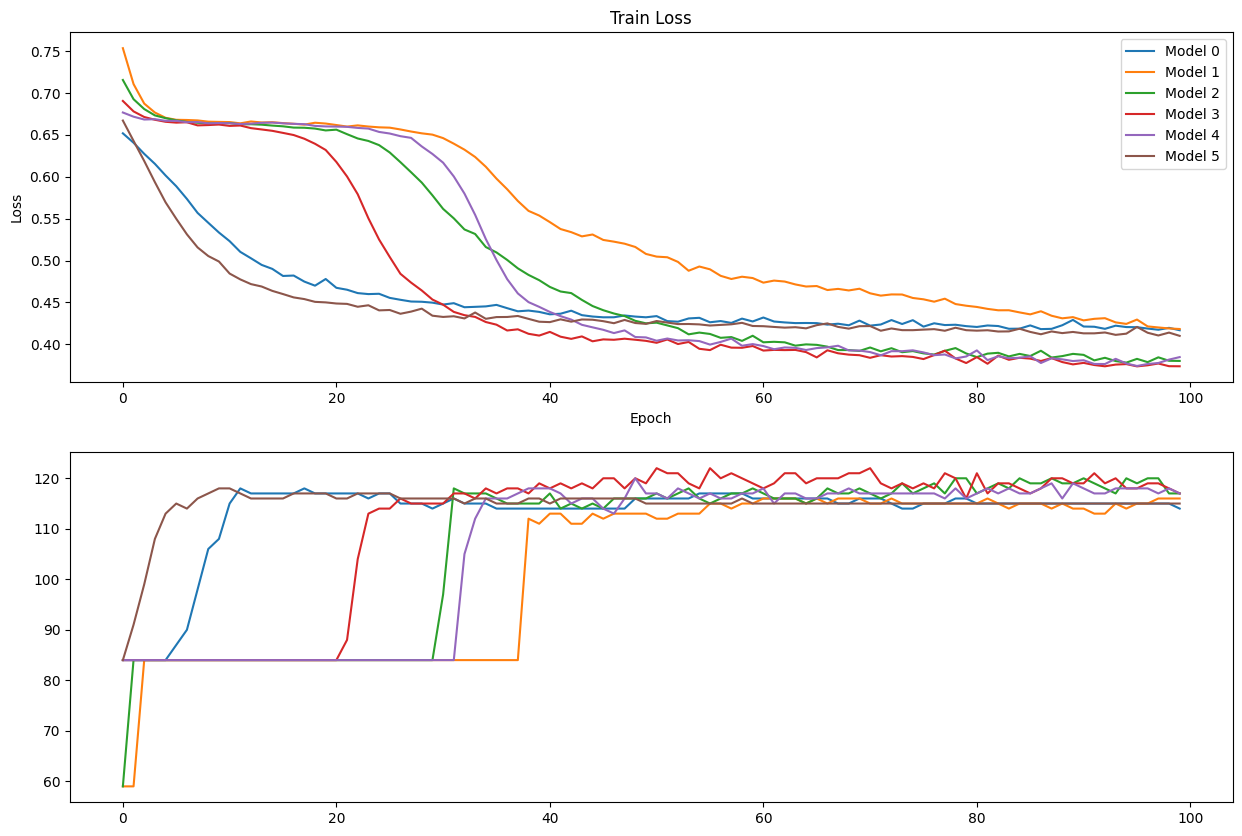

In [42]:
# Plot
num_plots = len(models)

# fig, axs = plt.subplots(num_plots, 2, figsize=(15, 5*num_plots))
# if num_plots == 1:
#     axs = [axs]
# for i in range(num_plots):
#     axs[i][0].plot(overall_train_stats[i]["epoch"], overall_train_stats[i]["loss"])
#     axs[i][0].set_title("Train Loss")
#     axs[i][0].set_xlabel("Epoch")
#     axs[i][0].set_ylabel("Loss")

#     axs[i][1].plot(overall_val_stats[i]["epoch"], overall_val_stats[i]["acc"])
#     axs[i][1].set_title("Validation Accuracy")
#     axs[i][1].set_xlabel("Epoch")
#     axs[i][1].set_ylabel("Accuracy")


# Plot all in one
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
for i in range(len(models)):
    axs[0].plot(overall_train_stats[i]["epoch"], overall_train_stats[i]["loss"], label=f"Model {i}")
    axs[1].plot(overall_val_stats[i]["epoch"], overall_val_stats[i]["acc"], label=f"Model {i}")

axs[0].set_title("Train Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
